## Описание проекта
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. <br>
Постройте модель для такого предсказания. <br>
Значение метрики RMSE на тестовой выборке должно быть не больше 48.<br>

## Загрузка и преобработка данных

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Загрузим данные:

In [ ]:
try:
    data = pd.read_csv('autos.csv', 
                       parse_dates=['datetime'],
                       index_col = 'datetime')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', 
                       parse_dates=['datetime'],
                       index_col = 'datetime')

Посмотрим на данные:

In [ ]:
data.head()

In [ ]:
data.info()

In [ ]:
data = data.sort_index()

Пропусков нет. Типы в норме. 

## Анализ временного ряда: 

Проведем ресемплирование по 1 часу:

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(data['num_orders'].resample('1h').sum())

Обычный график, сгладим по суткам:

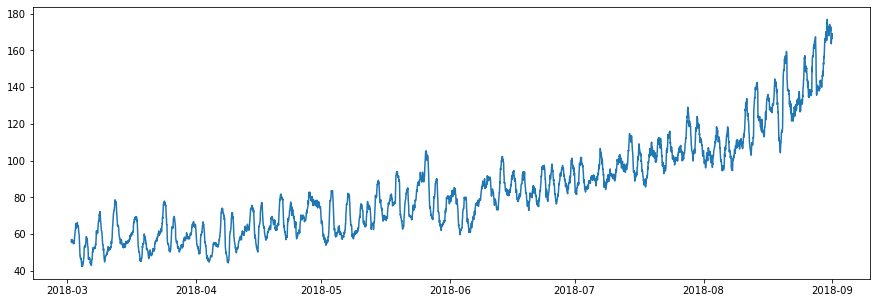

In [7]:
plt.figure(figsize = (15,5))
plt.plot(data['num_orders'].resample('1h').sum().rolling(24).mean())

Явный тренд наблюдаем мы. 

Глянем сезонность:

<AxesSubplot:xlabel='datetime'>

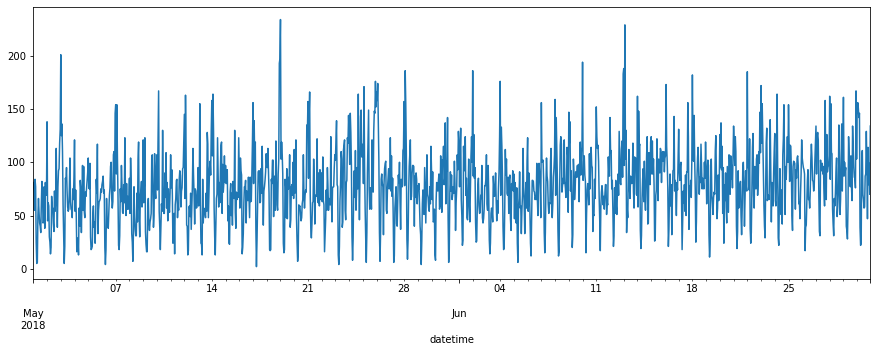

In [8]:
plt.figure(figsize = (15,5))
data['2018-05':'2018-06']['num_orders'].resample('1h').sum().plot()

Явно сезонность есть, уменьшим окно:

<AxesSubplot:xlabel='datetime'>

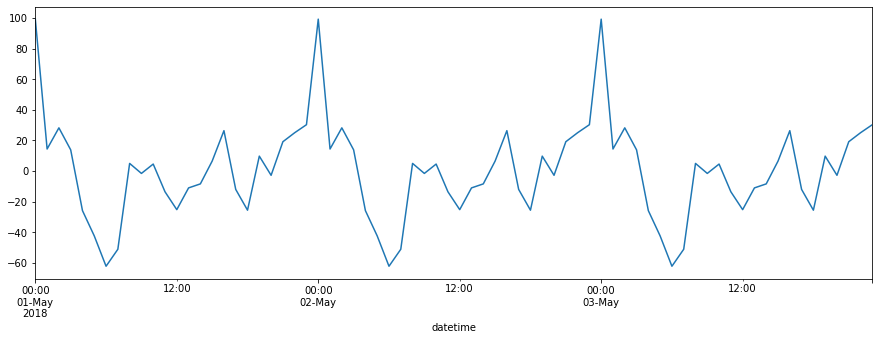

In [9]:
plt.figure(figsize = (15,5))
decomposed = seasonal_decompose(data['2018-05-01':'2018-05-03']['num_orders'].resample('1h').sum())
decomposed.seasonal.plot(ax=plt.gca())

## Обучение моделей



Итак, перед тем, как перейти к анализу, заготовим функции. 

Моя цель, посмотреть разные вариации гиперпараметров моделей и если взять разные параметры отставания и скользящей. 

Для этого понадобиться функция из тренажера чутка с апгейдом:

In [10]:
data = data.resample('1h').sum()

In [11]:
data

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
...                         ...
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205

[4416 rows x 1 columns]

In [12]:
def make_features(data : pd.DataFrame, column_name : str, max_lag : int, rolling_mean_size : int) -> None:
    """Добавленные временных признаков в датасет."""
    data2 = data.copy()
    data2['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data2['lag_{}'.format(lag)] = data[column_name].shift(lag)

    data2['rolling_mean'] = data[column_name].shift().rolling(rolling_mean_size).mean()
    return data2

In [13]:
def prepations_dataset(data : pd.DataFrame, max_lag : int, rolling_mean_size : int) -> pd.DataFrame:
    """Добавление признаков, разделение данных на выборки."""
    data_tmp = make_features(data, 'num_orders', max_lag, rolling_mean_size)
    data_tmp = data_tmp.dropna()
    ost, test = train_test_split(data_tmp, shuffle = False, test_size = 0.1)
    train, valid = train_test_split(ost, shuffle = False, test_size = 0.2)
    return train, valid, test

In [14]:
def aggregation_operation(data : pd.DataFrame, max_lag : int, rolling_mean_size : int, model) -> None:
    """Функция связи."""
    train, valid, test = prepations_dataset(data, max_lag, rolling_mean_size)
    train_model(model, train, valid, max_lag, rolling_mean_size)

In [15]:
result = pd.DataFrame(columns = ['name_model', 'parametrs', 'score', "max_lag", "rolling_mean_size"])
def train_model(model, train, valid, max_lag, rolling_mean_size) -> None:
    """Тренировка моделей."""
    model.fit(train.drop(columns = ['num_orders']), train['num_orders']);
    score = mean_squared_error(model.predict(valid.drop(columns = ['num_orders'])), valid['num_orders'], squared = False)
    get_row_to_result(model, score, max_lag, rolling_mean_size)
    print('Обучение {} закончено c max_lag = {} и rolling_mean_size = {}'.format(model.__class__.__name__, max_lag, rolling_mean_size))

In [16]:
def get_row_to_result(model, score : float, max_lag : int, rolling_mean_size : int) -> None:
    """Добавление строки в отчёт."""
    global result
    result = result.append({"name_model" : model.__class__.__name__ , 
                            "parametrs" : model.get_params(), 
                            "score" : score,
                            "max_lag" : max_lag,
                            "rolling_mean_size" : rolling_mean_size},
                            ignore_index = True)

Заготовим лист моделей:

In [17]:
lst_model = [LinearRegression(),
             CatBoostRegressor(loss_function='RMSE', 
                          iterations=500, 
                          learning_rate=0.1, 
                          thread_count=-1, 
                          random_state=12345,
                          l2_leaf_reg=3),
             lgb.LGBMRegressor(task='train', 
                                boosting_type='gbdt', 
                                objective='regression', 
                                metric='rmse', 
                                learning_rate=0.5, 
                                verbose=200)]
for depth in range(5, 21, 5):
        lst_model.append(DecisionTreeRegressor(max_depth = depth))
for est in range(100, 121, 20):
    for depth in range(10, 21, 10):
        lst_model.append(RandomForestRegressor(n_estimators = est, max_depth = depth))

Запустим обучение: 

In [18]:
for lag in range(1, 51, 5):
    for roll in range(1, 51, 5):
        for model in lst_model:
            aggregation_operation(data, lag, roll, model)

Обучение LinearRegression закончено c max_lag = 1 и rolling_mean_size = 1
0:	learn: 33.3399287	total: 55.7ms	remaining: 27.8s
1:	learn: 32.5835629	total: 58.1ms	remaining: 14.5s
2:	learn: 31.9126676	total: 60.5ms	remaining: 10s
3:	learn: 31.3641925	total: 62.9ms	remaining: 7.79s
4:	learn: 30.9108246	total: 65.1ms	remaining: 6.45s
5:	learn: 30.5086018	total: 69.6ms	remaining: 5.73s
6:	learn: 30.1737795	total: 75ms	remaining: 5.28s
7:	learn: 29.9182657	total: 79.1ms	remaining: 4.86s
8:	learn: 29.6828946	total: 82.7ms	remaining: 4.51s
9:	learn: 29.4888466	total: 86.7ms	remaining: 4.25s
10:	learn: 29.3296333	total: 92ms	remaining: 4.09s
11:	learn: 29.1889062	total: 97ms	remaining: 3.94s
12:	learn: 29.0762857	total: 120ms	remaining: 4.5s
13:	learn: 28.9770330	total: 127ms	remaining: 4.4s
14:	learn: 28.8872135	total: 129ms	remaining: 4.18s
15:	learn: 28.8246832	total: 132ms	remaining: 3.98s
16:	learn: 28.7591184	total: 134ms	remaining: 3.81s
17:	learn: 28.6971142	total: 138ms	remaining: 3.71

160:	learn: 27.4063121	total: 728ms	remaining: 1.53s
161:	learn: 27.4036172	total: 732ms	remaining: 1.53s
162:	learn: 27.4013537	total: 735ms	remaining: 1.52s
163:	learn: 27.3966908	total: 739ms	remaining: 1.51s
164:	learn: 27.3830363	total: 742ms	remaining: 1.51s
165:	learn: 27.3805941	total: 746ms	remaining: 1.5s
166:	learn: 27.3706870	total: 749ms	remaining: 1.49s
167:	learn: 27.3662576	total: 752ms	remaining: 1.49s
168:	learn: 27.3644311	total: 756ms	remaining: 1.48s
169:	learn: 27.3624610	total: 759ms	remaining: 1.47s
170:	learn: 27.3589754	total: 763ms	remaining: 1.47s
171:	learn: 27.3561283	total: 767ms	remaining: 1.46s
172:	learn: 27.3482524	total: 770ms	remaining: 1.46s
173:	learn: 27.3459100	total: 776ms	remaining: 1.45s
174:	learn: 27.3422287	total: 781ms	remaining: 1.45s
175:	learn: 27.3402419	total: 785ms	remaining: 1.45s
176:	learn: 27.3296632	total: 789ms	remaining: 1.44s
177:	learn: 27.3284697	total: 793ms	remaining: 1.43s
178:	learn: 27.3239287	total: 796ms	remaining: 

355:	learn: 26.6155049	total: 1.48s	remaining: 601ms
356:	learn: 26.6151393	total: 1.49s	remaining: 596ms
357:	learn: 26.6139046	total: 1.49s	remaining: 592ms
358:	learn: 26.6137160	total: 1.49s	remaining: 587ms
359:	learn: 26.6108378	total: 1.5s	remaining: 583ms
360:	learn: 26.6105905	total: 1.5s	remaining: 578ms
361:	learn: 26.6017693	total: 1.5s	remaining: 574ms
362:	learn: 26.6009146	total: 1.51s	remaining: 571ms
363:	learn: 26.5961740	total: 1.51s	remaining: 566ms
364:	learn: 26.5960172	total: 1.52s	remaining: 561ms
365:	learn: 26.5926016	total: 1.52s	remaining: 557ms
366:	learn: 26.5881033	total: 1.52s	remaining: 552ms
367:	learn: 26.5836819	total: 1.53s	remaining: 548ms
368:	learn: 26.5795343	total: 1.53s	remaining: 543ms
369:	learn: 26.5794741	total: 1.53s	remaining: 538ms
370:	learn: 26.5793653	total: 1.53s	remaining: 534ms
371:	learn: 26.5777970	total: 1.54s	remaining: 529ms
372:	learn: 26.5729469	total: 1.54s	remaining: 525ms
373:	learn: 26.5717694	total: 1.54s	remaining: 52

[LightGBM] [Info] Number of data points in the train set: 3178, number of used features: 3
[LightGBM] [Info] Start training from score 71.235053
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19


23:	learn: 27.8576787	total: 67.3ms	remaining: 1.33s
24:	learn: 27.8200626	total: 72.3ms	remaining: 1.37s
25:	learn: 27.7788280	total: 76.2ms	remaining: 1.39s
26:	learn: 27.7392744	total: 80.2ms	remaining: 1.41s
27:	learn: 27.6959960	total: 84.3ms	remaining: 1.42s
28:	learn: 27.6674575	total: 94.3ms	remaining: 1.53s
29:	learn: 27.6219264	total: 97.1ms	remaining: 1.52s
30:	learn: 27.6047743	total: 100ms	remaining: 1.51s
31:	learn: 27.5815811	total: 103ms	remaining: 1.5s
32:	learn: 27.5742391	total: 106ms	remaining: 1.5s
33:	learn: 27.5457964	total: 109ms	remaining: 1.5s
34:	learn: 27.5228025	total: 112ms	remaining: 1.49s
35:	learn: 27.4999713	total: 115ms	remaining: 1.48s
36:	learn: 27.4871628	total: 117ms	remaining: 1.47s
37:	learn: 27.4718250	total: 120ms	remaining: 1.46s
38:	learn: 27.4582277	total: 123ms	remaining: 1.45s
39:	learn: 27.4426338	total: 126ms	remaining: 1.44s
40:	learn: 27.4310056	total: 128ms	remaining: 1.44s
41:	learn: 27.3993339	total: 131ms	remaining: 1.43s
42:	lear

191:	learn: 25.3402824	total: 561ms	remaining: 900ms
192:	learn: 25.3331806	total: 565ms	remaining: 899ms
193:	learn: 25.3163416	total: 569ms	remaining: 898ms
194:	learn: 25.3114996	total: 572ms	remaining: 895ms
195:	learn: 25.3003639	total: 576ms	remaining: 893ms
196:	learn: 25.2901800	total: 580ms	remaining: 892ms
197:	learn: 25.2894477	total: 585ms	remaining: 892ms
198:	learn: 25.2731517	total: 592ms	remaining: 896ms
199:	learn: 25.2509729	total: 596ms	remaining: 894ms
200:	learn: 25.2439716	total: 600ms	remaining: 893ms
201:	learn: 25.2280485	total: 606ms	remaining: 894ms
202:	learn: 25.2053022	total: 610ms	remaining: 892ms
203:	learn: 25.1978736	total: 614ms	remaining: 891ms
204:	learn: 25.1836996	total: 619ms	remaining: 890ms
205:	learn: 25.1821184	total: 623ms	remaining: 889ms
206:	learn: 25.1598642	total: 627ms	remaining: 888ms
207:	learn: 25.1529241	total: 630ms	remaining: 885ms
208:	learn: 25.1389023	total: 633ms	remaining: 882ms
209:	learn: 25.1235182	total: 636ms	remaining:

351:	learn: 23.8284134	total: 1.2s	remaining: 504ms
352:	learn: 23.8202333	total: 1.2s	remaining: 501ms
353:	learn: 23.8146734	total: 1.21s	remaining: 498ms
354:	learn: 23.8004911	total: 1.21s	remaining: 495ms
355:	learn: 23.7860934	total: 1.21s	remaining: 491ms
356:	learn: 23.7859520	total: 1.22s	remaining: 488ms
357:	learn: 23.7828352	total: 1.22s	remaining: 485ms
358:	learn: 23.7789736	total: 1.23s	remaining: 483ms
359:	learn: 23.7712427	total: 1.23s	remaining: 480ms
360:	learn: 23.7696931	total: 1.24s	remaining: 476ms
361:	learn: 23.7689629	total: 1.24s	remaining: 473ms
362:	learn: 23.7643467	total: 1.25s	remaining: 470ms
363:	learn: 23.7613832	total: 1.25s	remaining: 466ms
364:	learn: 23.7561276	total: 1.25s	remaining: 463ms
365:	learn: 23.7510287	total: 1.26s	remaining: 460ms
366:	learn: 23.7495852	total: 1.26s	remaining: 457ms
367:	learn: 23.7432646	total: 1.26s	remaining: 454ms
368:	learn: 23.7309963	total: 1.27s	remaining: 450ms
369:	learn: 23.7149740	total: 1.27s	remaining: 4

Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 6
Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 6
Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 6
Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 6
Обучение LinearRegression закончено c max_lag = 1 и rolling_mean_size = 11
0:	learn: 33.2779513	total: 2.88ms	remaining: 1.44s
1:	learn: 32.4813234	total: 5.52ms	remaining: 1.37s
2:	learn: 31.7904861	total: 8.17ms	remaining: 1.35s
3:	learn: 31.2158248	total: 10.9ms	remaining: 1.35s
4:	learn: 30.7156386	total: 13.4ms	remaining: 1.33s
5:	learn: 30.2731202	total: 16ms	

188:	learn: 25.5696365	total: 564ms	remaining: 929ms
189:	learn: 25.5471764	total: 568ms	remaining: 927ms
190:	learn: 25.5338063	total: 573ms	remaining: 926ms
191:	learn: 25.5161305	total: 577ms	remaining: 925ms
192:	learn: 25.5093239	total: 580ms	remaining: 923ms
193:	learn: 25.5020271	total: 584ms	remaining: 921ms
194:	learn: 25.4946677	total: 587ms	remaining: 918ms
195:	learn: 25.4879027	total: 591ms	remaining: 916ms
196:	learn: 25.4787733	total: 594ms	remaining: 914ms
197:	learn: 25.4705894	total: 598ms	remaining: 913ms
198:	learn: 25.4482314	total: 604ms	remaining: 913ms
199:	learn: 25.4280113	total: 607ms	remaining: 910ms
200:	learn: 25.4193146	total: 610ms	remaining: 907ms
201:	learn: 25.4189366	total: 612ms	remaining: 903ms
202:	learn: 25.4073004	total: 615ms	remaining: 900ms
203:	learn: 25.3930660	total: 619ms	remaining: 898ms
204:	learn: 25.3857375	total: 622ms	remaining: 895ms
205:	learn: 25.3732372	total: 624ms	remaining: 891ms
206:	learn: 25.3497099	total: 627ms	remaining:

349:	learn: 23.9074553	total: 1.05s	remaining: 451ms
350:	learn: 23.8854940	total: 1.06s	remaining: 448ms
351:	learn: 23.8744390	total: 1.06s	remaining: 446ms
352:	learn: 23.8680717	total: 1.06s	remaining: 443ms
353:	learn: 23.8569834	total: 1.07s	remaining: 441ms
354:	learn: 23.8446992	total: 1.07s	remaining: 438ms
355:	learn: 23.8380444	total: 1.08s	remaining: 438ms
356:	learn: 23.8298288	total: 1.08s	remaining: 435ms
357:	learn: 23.8214216	total: 1.09s	remaining: 432ms
358:	learn: 23.8178421	total: 1.09s	remaining: 429ms
359:	learn: 23.8114574	total: 1.09s	remaining: 426ms
360:	learn: 23.8045756	total: 1.1s	remaining: 424ms
361:	learn: 23.7952271	total: 1.1s	remaining: 421ms
362:	learn: 23.7882441	total: 1.11s	remaining: 418ms
363:	learn: 23.7865325	total: 1.11s	remaining: 414ms
364:	learn: 23.7764611	total: 1.11s	remaining: 411ms
365:	learn: 23.7734701	total: 1.11s	remaining: 408ms
366:	learn: 23.7606029	total: 1.12s	remaining: 405ms
367:	learn: 23.7468750	total: 1.12s	remaining: 4

Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 11
Обучение LinearRegression закончено c max_lag = 1 и rolling_mean_size = 16
0:	learn: 33.3104500	total: 2.64ms	remaining: 1.32s
1:	learn: 32.5386038	total: 5.43ms	remaining: 1.35s
2:	learn: 31.8613816	total: 8.12ms	remaining: 1.34s
3:	learn: 31.3050228	total: 10.8ms	remaining: 1.34s
4:	learn: 30.7969683	total: 13.6ms	remaining: 1.35s
5:	learn: 30.3726051	tota

187:	learn: 25.7609948	total: 558ms	remaining: 926ms
188:	learn: 25.7521999	total: 562ms	remaining: 925ms
189:	learn: 25.7249601	total: 566ms	remaining: 923ms
190:	learn: 25.7092641	total: 570ms	remaining: 922ms
191:	learn: 25.6945784	total: 574ms	remaining: 920ms
192:	learn: 25.6768701	total: 577ms	remaining: 918ms
193:	learn: 25.6647451	total: 581ms	remaining: 916ms
194:	learn: 25.6539912	total: 585ms	remaining: 915ms
195:	learn: 25.6438668	total: 593ms	remaining: 920ms
196:	learn: 25.6306300	total: 596ms	remaining: 917ms
197:	learn: 25.6270582	total: 599ms	remaining: 913ms
198:	learn: 25.6251620	total: 601ms	remaining: 909ms
199:	learn: 25.6232491	total: 605ms	remaining: 908ms
200:	learn: 25.6169619	total: 608ms	remaining: 905ms
201:	learn: 25.6142205	total: 611ms	remaining: 901ms
202:	learn: 25.6132289	total: 614ms	remaining: 898ms
203:	learn: 25.6096313	total: 616ms	remaining: 894ms
204:	learn: 25.5962019	total: 620ms	remaining: 892ms
205:	learn: 25.5840690	total: 623ms	remaining:

353:	learn: 24.3585761	total: 1.05s	remaining: 432ms
354:	learn: 24.3510547	total: 1.05s	remaining: 430ms
355:	learn: 24.3490579	total: 1.05s	remaining: 427ms
356:	learn: 24.3353068	total: 1.06s	remaining: 424ms
357:	learn: 24.3227978	total: 1.06s	remaining: 422ms
358:	learn: 24.3185026	total: 1.07s	remaining: 419ms
359:	learn: 24.3131421	total: 1.07s	remaining: 418ms
360:	learn: 24.3070060	total: 1.08s	remaining: 415ms
361:	learn: 24.2969076	total: 1.08s	remaining: 412ms
362:	learn: 24.2883546	total: 1.08s	remaining: 409ms
363:	learn: 24.2807792	total: 1.09s	remaining: 406ms
364:	learn: 24.2673727	total: 1.09s	remaining: 403ms
365:	learn: 24.2585799	total: 1.09s	remaining: 400ms
366:	learn: 24.2489766	total: 1.09s	remaining: 397ms
367:	learn: 24.2487855	total: 1.1s	remaining: 394ms
368:	learn: 24.2435565	total: 1.1s	remaining: 391ms
369:	learn: 24.2371385	total: 1.1s	remaining: 388ms
370:	learn: 24.2213404	total: 1.11s	remaining: 385ms
371:	learn: 24.2103141	total: 1.11s	remaining: 38

Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 16
Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 16
Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 16
Обучение LinearRegression закончено c max_lag = 1 и rolling_mean_size = 21
0:	learn: 33.3471976	total: 3.22ms	remaining: 1.61s
1:	learn: 32.6264095	total: 5.98ms	remaining: 1.49s
2:	learn: 31.9440734	total: 8.77ms	remaining: 1.45s
3:	learn: 31.3942784	total: 11.5ms	remaining: 1.43s
4:	learn: 30.9243151	total: 13.9ms	remaining: 1.38s
5:	learn: 30.5229324	total: 16.5ms	remaining: 1.36s
6:	learn: 30.1643219	total: 19.1ms	remaining: 1.35s
7

191:	learn: 25.8722517	total: 566ms	remaining: 908ms
192:	learn: 25.8574771	total: 572ms	remaining: 909ms
193:	learn: 25.8456155	total: 575ms	remaining: 907ms
194:	learn: 25.8396014	total: 579ms	remaining: 905ms
195:	learn: 25.8389982	total: 582ms	remaining: 903ms
196:	learn: 25.8360320	total: 585ms	remaining: 900ms
197:	learn: 25.8284762	total: 589ms	remaining: 898ms
198:	learn: 25.8200174	total: 593ms	remaining: 896ms
199:	learn: 25.8042166	total: 597ms	remaining: 896ms
200:	learn: 25.8023298	total: 605ms	remaining: 900ms
201:	learn: 25.7925985	total: 608ms	remaining: 896ms
202:	learn: 25.7921152	total: 612ms	remaining: 896ms
203:	learn: 25.7881005	total: 615ms	remaining: 892ms
204:	learn: 25.7755179	total: 618ms	remaining: 889ms
205:	learn: 25.7665252	total: 621ms	remaining: 886ms
206:	learn: 25.7611118	total: 623ms	remaining: 882ms
207:	learn: 25.7466580	total: 627ms	remaining: 880ms
208:	learn: 25.7370933	total: 630ms	remaining: 877ms
209:	learn: 25.7178761	total: 633ms	remaining:

354:	learn: 24.4003592	total: 1.05s	remaining: 430ms
355:	learn: 24.3790139	total: 1.06s	remaining: 428ms
356:	learn: 24.3766014	total: 1.06s	remaining: 426ms
357:	learn: 24.3750997	total: 1.07s	remaining: 423ms
358:	learn: 24.3722479	total: 1.07s	remaining: 421ms
359:	learn: 24.3647546	total: 1.07s	remaining: 418ms
360:	learn: 24.3600334	total: 1.08s	remaining: 417ms
361:	learn: 24.3591326	total: 1.09s	remaining: 414ms
362:	learn: 24.3531000	total: 1.09s	remaining: 411ms
363:	learn: 24.3452664	total: 1.09s	remaining: 409ms
364:	learn: 24.3352309	total: 1.1s	remaining: 406ms
365:	learn: 24.3255321	total: 1.1s	remaining: 403ms
366:	learn: 24.3115124	total: 1.1s	remaining: 400ms
367:	learn: 24.3011283	total: 1.11s	remaining: 397ms
368:	learn: 24.2926238	total: 1.11s	remaining: 394ms
369:	learn: 24.2837005	total: 1.11s	remaining: 391ms
370:	learn: 24.2747084	total: 1.11s	remaining: 388ms
371:	learn: 24.2746124	total: 1.12s	remaining: 385ms
372:	learn: 24.2744154	total: 1.12s	remaining: 38

Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 21
Обучение LinearRegression закончено c max_lag = 1 и rolling_mean_size = 26
0:	learn: 33.3282474	total: 2.66ms	remaining: 1.33s
1:	learn: 32.5339671	total: 5.37ms	remaining: 1.34s
2:	learn: 31.8542068	total: 7.98ms	remaining: 1.32s
3:	learn: 31.2687055	total: 10.7ms	remaining: 1.32s
4:	learn: 30.7526019	total: 13.3ms	remaining: 1.32s
5:	learn: 30.3281148	total: 15.9ms	remaining: 1.31s
6:	learn: 29.9565985	total: 18.6ms	remaining: 1.31s
7

187:	learn: 25.8147252	total: 559ms	remaining: 928ms
188:	learn: 25.7974950	total: 564ms	remaining: 928ms
189:	learn: 25.7850734	total: 568ms	remaining: 926ms
190:	learn: 25.7687862	total: 571ms	remaining: 924ms
191:	learn: 25.7536850	total: 575ms	remaining: 923ms
192:	learn: 25.7488879	total: 579ms	remaining: 921ms
193:	learn: 25.7482505	total: 583ms	remaining: 919ms
194:	learn: 25.7317298	total: 587ms	remaining: 917ms
195:	learn: 25.7104552	total: 596ms	remaining: 924ms
196:	learn: 25.7092850	total: 598ms	remaining: 920ms
197:	learn: 25.6920028	total: 601ms	remaining: 916ms
198:	learn: 25.6795335	total: 604ms	remaining: 913ms
199:	learn: 25.6648436	total: 607ms	remaining: 910ms
200:	learn: 25.6547859	total: 609ms	remaining: 906ms
201:	learn: 25.6495974	total: 612ms	remaining: 903ms
202:	learn: 25.6282540	total: 615ms	remaining: 899ms
203:	learn: 25.6143346	total: 618ms	remaining: 897ms
204:	learn: 25.6052391	total: 621ms	remaining: 894ms
205:	learn: 25.5931079	total: 624ms	remaining:

352:	learn: 24.3452855	total: 1.05s	remaining: 437ms
353:	learn: 24.3381790	total: 1.05s	remaining: 434ms
354:	learn: 24.3333995	total: 1.06s	remaining: 432ms
355:	learn: 24.3248464	total: 1.06s	remaining: 429ms
356:	learn: 24.3056683	total: 1.06s	remaining: 427ms
357:	learn: 24.3055309	total: 1.07s	remaining: 424ms
358:	learn: 24.2894483	total: 1.07s	remaining: 422ms
359:	learn: 24.2857069	total: 1.08s	remaining: 419ms
360:	learn: 24.2705250	total: 1.08s	remaining: 416ms
361:	learn: 24.2607861	total: 1.08s	remaining: 413ms
362:	learn: 24.2565196	total: 1.09s	remaining: 410ms
363:	learn: 24.2484255	total: 1.09s	remaining: 407ms
364:	learn: 24.2423478	total: 1.09s	remaining: 404ms
365:	learn: 24.2402554	total: 1.09s	remaining: 401ms
366:	learn: 24.2318679	total: 1.1s	remaining: 398ms
367:	learn: 24.2266900	total: 1.1s	remaining: 395ms
368:	learn: 24.2259754	total: 1.1s	remaining: 391ms
369:	learn: 24.2155381	total: 1.1s	remaining: 388ms
370:	learn: 24.2102595	total: 1.11s	remaining: 385

Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 26
Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 26
Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 26
Обучение LinearRegression закончено c max_lag = 1 и rolling_mean_size = 31
0:	learn: 33.3677253	total: 2.65ms	remaining: 1.32s
1:	learn: 32.5881517	total: 5.29ms	remaining: 1.32s
2:	learn: 31.9116557	total: 8.01ms	remaining: 1.33s
3:	learn: 31.3552483	total: 10.7ms	remaining: 1.32s
4:	learn: 30.8317744	total: 13.4ms	remaining: 1.33s
5:	learn: 30.4234963	total: 16ms	remaining: 1.32s
6:	learn: 30.0680671	total: 18.6ms	remaining: 1.31s
7:	

185:	learn: 25.9292879	total: 559ms	remaining: 945ms
186:	learn: 25.9078335	total: 564ms	remaining: 944ms
187:	learn: 25.8925175	total: 567ms	remaining: 941ms
188:	learn: 25.8782309	total: 571ms	remaining: 939ms
189:	learn: 25.8700325	total: 575ms	remaining: 938ms
190:	learn: 25.8563067	total: 579ms	remaining: 936ms
191:	learn: 25.8438020	total: 583ms	remaining: 935ms
192:	learn: 25.8312942	total: 588ms	remaining: 935ms
193:	learn: 25.8253088	total: 595ms	remaining: 939ms
194:	learn: 25.8230579	total: 598ms	remaining: 935ms
195:	learn: 25.8154721	total: 600ms	remaining: 931ms
196:	learn: 25.8057980	total: 605ms	remaining: 931ms
197:	learn: 25.7954755	total: 608ms	remaining: 927ms
198:	learn: 25.7869792	total: 611ms	remaining: 924ms
199:	learn: 25.7726036	total: 614ms	remaining: 920ms
200:	learn: 25.7627276	total: 616ms	remaining: 917ms
201:	learn: 25.7545990	total: 620ms	remaining: 914ms
202:	learn: 25.7402289	total: 622ms	remaining: 910ms
203:	learn: 25.7358864	total: 625ms	remaining:

349:	learn: 24.3372675	total: 1.05s	remaining: 451ms
350:	learn: 24.3300863	total: 1.06s	remaining: 449ms
351:	learn: 24.3180853	total: 1.06s	remaining: 446ms
352:	learn: 24.3123356	total: 1.06s	remaining: 443ms
353:	learn: 24.3041201	total: 1.07s	remaining: 441ms
354:	learn: 24.2912051	total: 1.07s	remaining: 438ms
355:	learn: 24.2910209	total: 1.08s	remaining: 437ms
356:	learn: 24.2852750	total: 1.08s	remaining: 434ms
357:	learn: 24.2738380	total: 1.09s	remaining: 432ms
358:	learn: 24.2612919	total: 1.09s	remaining: 429ms
359:	learn: 24.2532283	total: 1.09s	remaining: 426ms
360:	learn: 24.2440794	total: 1.1s	remaining: 422ms
361:	learn: 24.2372536	total: 1.1s	remaining: 419ms
362:	learn: 24.2296866	total: 1.1s	remaining: 416ms
363:	learn: 24.2158903	total: 1.1s	remaining: 413ms
364:	learn: 24.2062062	total: 1.11s	remaining: 410ms
365:	learn: 24.1976771	total: 1.11s	remaining: 407ms
366:	learn: 24.1952102	total: 1.11s	remaining: 404ms
367:	learn: 24.1915460	total: 1.12s	remaining: 401

Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 31
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 31
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 31
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 31
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 31
Обучение LinearRegression закончено c max_lag = 1 и rolling_mean_size = 36
0:	learn: 33.3616499	total: 2.66ms	remaining: 1.33s
1:	learn: 32.5676329	total: 5.37ms	remaining: 1.34s
2:	learn: 31.8769202	total: 8.07ms	remaining: 1.34s
3:	learn: 31.3283592	total: 10.8ms	remaining: 1.34s
4:	learn: 30.8244705	total: 13.5ms	remaining: 1.34s
5:	learn: 30.4204881	total: 16.2ms	remaining: 1.33s
6:	learn: 30.0709697	total: 18.9ms	remaining: 1.33s
7

184:	learn: 25.9519134	total: 552ms	remaining: 940ms
185:	learn: 25.9422070	total: 556ms	remaining: 939ms
186:	learn: 25.9255578	total: 560ms	remaining: 937ms
187:	learn: 25.9247982	total: 563ms	remaining: 934ms
188:	learn: 25.9150085	total: 566ms	remaining: 932ms
189:	learn: 25.9088062	total: 569ms	remaining: 929ms
190:	learn: 25.8913397	total: 573ms	remaining: 927ms
191:	learn: 25.8806932	total: 577ms	remaining: 926ms
192:	learn: 25.8752104	total: 581ms	remaining: 925ms
193:	learn: 25.8542606	total: 589ms	remaining: 929ms
194:	learn: 25.8499252	total: 592ms	remaining: 926ms
195:	learn: 25.8376891	total: 597ms	remaining: 925ms
196:	learn: 25.8271263	total: 600ms	remaining: 922ms
197:	learn: 25.8118919	total: 603ms	remaining: 919ms
198:	learn: 25.8089322	total: 605ms	remaining: 915ms
199:	learn: 25.8082717	total: 608ms	remaining: 912ms
200:	learn: 25.7959551	total: 611ms	remaining: 910ms
201:	learn: 25.7869775	total: 615ms	remaining: 907ms
202:	learn: 25.7773635	total: 617ms	remaining:

389:	learn: 24.1593061	total: 1.2s	remaining: 339ms
390:	learn: 24.1453554	total: 1.21s	remaining: 336ms
391:	learn: 24.1420225	total: 1.21s	remaining: 333ms
392:	learn: 24.1320408	total: 1.21s	remaining: 330ms
393:	learn: 24.1247623	total: 1.22s	remaining: 327ms
394:	learn: 24.1237352	total: 1.22s	remaining: 324ms
395:	learn: 24.1092532	total: 1.22s	remaining: 322ms
396:	learn: 24.1044206	total: 1.23s	remaining: 319ms
397:	learn: 24.1028435	total: 1.24s	remaining: 317ms
398:	learn: 24.1026321	total: 1.24s	remaining: 314ms
399:	learn: 24.0900346	total: 1.24s	remaining: 311ms
400:	learn: 24.0808833	total: 1.25s	remaining: 308ms
401:	learn: 24.0776023	total: 1.25s	remaining: 305ms
402:	learn: 24.0708672	total: 1.26s	remaining: 302ms
403:	learn: 24.0620915	total: 1.26s	remaining: 300ms
404:	learn: 24.0510828	total: 1.26s	remaining: 297ms
405:	learn: 24.0451975	total: 1.27s	remaining: 294ms
406:	learn: 24.0267557	total: 1.27s	remaining: 291ms
407:	learn: 24.0186432	total: 1.28s	remaining: 

Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 36
Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 36
Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 36
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 36
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 36
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 36
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 36
Обучение LinearRegression закончено c max_lag = 1 и rolling_mean_size = 41
0:	learn: 33.3713744	total: 2.62ms	remaining: 1.31s
1:	learn: 32.5791052	total: 5.24ms	remaining: 1.3s
2:	learn: 31.9205626	total: 7.99ms	remaining: 1.32s
3:	learn: 31.3741296	total: 10.6ms	remaining: 1.31s
4:	learn: 30.8636386	total: 13.3ms	remaining: 1.32s
5:	learn: 30.4647986	total: 15.9ms	remaining: 1.3s
6:	learn: 30.1147262	total: 18.5ms	remaining: 1.3s
7:	l

190:	learn: 25.9528669	total: 559ms	remaining: 905ms
191:	learn: 25.9450164	total: 564ms	remaining: 904ms
192:	learn: 25.9290460	total: 568ms	remaining: 903ms
193:	learn: 25.9260691	total: 572ms	remaining: 902ms
194:	learn: 25.9216159	total: 575ms	remaining: 900ms
195:	learn: 25.9040734	total: 579ms	remaining: 898ms
196:	learn: 25.8902236	total: 583ms	remaining: 896ms
197:	learn: 25.8833888	total: 587ms	remaining: 895ms
198:	learn: 25.8704023	total: 593ms	remaining: 898ms
199:	learn: 25.8613516	total: 598ms	remaining: 897ms
200:	learn: 25.8525069	total: 601ms	remaining: 893ms
201:	learn: 25.8382425	total: 603ms	remaining: 890ms
202:	learn: 25.8361232	total: 606ms	remaining: 887ms
203:	learn: 25.8255292	total: 609ms	remaining: 883ms
204:	learn: 25.8130282	total: 612ms	remaining: 881ms
205:	learn: 25.8113848	total: 615ms	remaining: 878ms
206:	learn: 25.8023808	total: 618ms	remaining: 875ms
207:	learn: 25.7883982	total: 621ms	remaining: 871ms
208:	learn: 25.7782870	total: 623ms	remaining:

357:	learn: 24.4272506	total: 1.05s	remaining: 415ms
358:	learn: 24.4166580	total: 1.05s	remaining: 413ms
359:	learn: 24.4154116	total: 1.05s	remaining: 410ms
360:	learn: 24.4015796	total: 1.06s	remaining: 408ms
361:	learn: 24.3905431	total: 1.06s	remaining: 406ms
362:	learn: 24.3895989	total: 1.07s	remaining: 403ms
363:	learn: 24.3775022	total: 1.07s	remaining: 401ms
364:	learn: 24.3692754	total: 1.08s	remaining: 399ms
365:	learn: 24.3671265	total: 1.08s	remaining: 396ms
366:	learn: 24.3670128	total: 1.08s	remaining: 393ms
367:	learn: 24.3496618	total: 1.09s	remaining: 390ms
368:	learn: 24.3398629	total: 1.09s	remaining: 387ms
369:	learn: 24.3305015	total: 1.09s	remaining: 384ms
370:	learn: 24.3142800	total: 1.1s	remaining: 381ms
371:	learn: 24.3083320	total: 1.1s	remaining: 378ms
372:	learn: 24.3003751	total: 1.1s	remaining: 375ms
373:	learn: 24.3002788	total: 1.1s	remaining: 372ms
374:	learn: 24.2926534	total: 1.11s	remaining: 369ms
375:	learn: 24.2891790	total: 1.11s	remaining: 366

Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 41
Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 41
Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 41
Обучение LinearRegression закончено c max_lag = 1 и rolling_mean_size = 46
0:	learn: 33.3688186	total: 2.72ms	remaining: 1.36s
1:	learn: 32.6195929	total: 5.42ms	remaining: 1.35s
2:	learn: 31.9408212	total: 8.15ms	remaining: 1.35s
3:	learn: 31.3846928	total: 10.8ms	remaining: 1.34s
4:	learn: 30.8678283	total: 13.5ms	remaining: 1.34s
5:	learn: 30.4702930	total: 16.1ms	remaining: 1.33s
6:	learn: 30.1066975	total: 18.7ms	remaining: 1.32s
7

185:	learn: 25.9172295	total: 557ms	remaining: 941ms
186:	learn: 25.9022697	total: 562ms	remaining: 941ms
187:	learn: 25.8944018	total: 565ms	remaining: 938ms
188:	learn: 25.8790781	total: 569ms	remaining: 937ms
189:	learn: 25.8694166	total: 573ms	remaining: 935ms
190:	learn: 25.8659012	total: 577ms	remaining: 934ms
191:	learn: 25.8465284	total: 581ms	remaining: 932ms
192:	learn: 25.8321179	total: 586ms	remaining: 932ms
193:	learn: 25.8213414	total: 590ms	remaining: 931ms
194:	learn: 25.8024294	total: 593ms	remaining: 927ms
195:	learn: 25.7891918	total: 598ms	remaining: 927ms
196:	learn: 25.7782557	total: 600ms	remaining: 923ms
197:	learn: 25.7643999	total: 603ms	remaining: 920ms
198:	learn: 25.7428470	total: 606ms	remaining: 917ms
199:	learn: 25.7314772	total: 609ms	remaining: 913ms
200:	learn: 25.7214842	total: 612ms	remaining: 911ms
201:	learn: 25.7190605	total: 615ms	remaining: 907ms
202:	learn: 25.7116237	total: 618ms	remaining: 904ms
203:	learn: 25.7069505	total: 621ms	remaining:

346:	learn: 24.4116857	total: 1.04s	remaining: 461ms
347:	learn: 24.4039189	total: 1.05s	remaining: 459ms
348:	learn: 24.3963054	total: 1.05s	remaining: 456ms
349:	learn: 24.3867707	total: 1.06s	remaining: 453ms
350:	learn: 24.3777255	total: 1.06s	remaining: 451ms
351:	learn: 24.3667316	total: 1.06s	remaining: 448ms
352:	learn: 24.3592506	total: 1.07s	remaining: 445ms
353:	learn: 24.3396892	total: 1.07s	remaining: 443ms
354:	learn: 24.3394496	total: 1.08s	remaining: 441ms
355:	learn: 24.3363186	total: 1.08s	remaining: 438ms
356:	learn: 24.3289468	total: 1.08s	remaining: 434ms
357:	learn: 24.3232452	total: 1.09s	remaining: 431ms
358:	learn: 24.3168713	total: 1.09s	remaining: 428ms
359:	learn: 24.2963757	total: 1.09s	remaining: 425ms
360:	learn: 24.2872544	total: 1.1s	remaining: 422ms
361:	learn: 24.2796333	total: 1.1s	remaining: 419ms
362:	learn: 24.2706793	total: 1.1s	remaining: 416ms
363:	learn: 24.2590565	total: 1.1s	remaining: 413ms
364:	learn: 24.2580191	total: 1.11s	remaining: 410

Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 46
Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 46
Обучение DecisionTreeRegressor закончено c max_lag = 1 и rolling_mean_size = 46
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 46
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 46
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 46
Обучение RandomForestRegressor закончено c max_lag = 1 и rolling_mean_size = 46
Обучение LinearRegression закончено c max_lag = 6 и rolling_mean_size = 1
0:	learn: 33.2489372	total: 5.18ms	remaining: 2.58s
1:	learn: 32.4299011	total: 10.2ms	remaining: 2.53s
2:	learn: 31.7261752	total: 15.3ms	remaining: 2.53s
3:	learn: 31.1833897	total: 20.4ms	remaining: 2.52s
4:	learn: 30.7054519	total: 25.2ms	remaining: 2.49s
5:	learn: 30.2555560	total: 30ms	remaining: 2.47s
6:	learn: 29.8363988	total: 34.8ms	remaining: 2.45s
7:	l

165:	learn: 23.0302985	total: 910ms	remaining: 1.83s
166:	learn: 23.0152907	total: 918ms	remaining: 1.83s
167:	learn: 22.9890998	total: 926ms	remaining: 1.83s
168:	learn: 22.9654557	total: 934ms	remaining: 1.83s
169:	learn: 22.9471819	total: 945ms	remaining: 1.83s
170:	learn: 22.9146516	total: 950ms	remaining: 1.83s
171:	learn: 22.8764695	total: 956ms	remaining: 1.82s
172:	learn: 22.8359048	total: 962ms	remaining: 1.82s
173:	learn: 22.7857327	total: 967ms	remaining: 1.81s
174:	learn: 22.7769635	total: 972ms	remaining: 1.8s
175:	learn: 22.7574167	total: 976ms	remaining: 1.8s
176:	learn: 22.7328785	total: 981ms	remaining: 1.79s
177:	learn: 22.7054630	total: 986ms	remaining: 1.78s
178:	learn: 22.6854519	total: 991ms	remaining: 1.78s
179:	learn: 22.6714441	total: 996ms	remaining: 1.77s
180:	learn: 22.6341061	total: 1s	remaining: 1.76s
181:	learn: 22.6332238	total: 1.01s	remaining: 1.76s
182:	learn: 22.6029111	total: 1.01s	remaining: 1.75s
183:	learn: 22.5705788	total: 1.01s	remaining: 1.74

322:	learn: 20.0200655	total: 1.77s	remaining: 973ms
323:	learn: 20.0061120	total: 1.78s	remaining: 969ms
324:	learn: 19.9972815	total: 1.79s	remaining: 965ms
325:	learn: 19.9750790	total: 1.8s	remaining: 964ms
326:	learn: 19.9566485	total: 1.81s	remaining: 958ms
327:	learn: 19.9262674	total: 1.81s	remaining: 952ms
328:	learn: 19.9256696	total: 1.82s	remaining: 947ms
329:	learn: 19.9146321	total: 1.83s	remaining: 941ms
330:	learn: 19.9016490	total: 1.83s	remaining: 936ms
331:	learn: 19.8915044	total: 1.84s	remaining: 930ms
332:	learn: 19.8653197	total: 1.84s	remaining: 924ms
333:	learn: 19.8386252	total: 1.85s	remaining: 918ms
334:	learn: 19.8264893	total: 1.85s	remaining: 913ms
335:	learn: 19.8226571	total: 1.86s	remaining: 907ms
336:	learn: 19.8220996	total: 1.86s	remaining: 901ms
337:	learn: 19.8095470	total: 1.87s	remaining: 895ms
338:	learn: 19.7935231	total: 1.87s	remaining: 889ms
339:	learn: 19.7720528	total: 1.88s	remaining: 883ms
340:	learn: 19.7687223	total: 1.88s	remaining: 

482:	learn: 17.8393542	total: 2.66s	remaining: 93.7ms
483:	learn: 17.8389817	total: 2.67s	remaining: 88.2ms
484:	learn: 17.8248987	total: 2.68s	remaining: 82.8ms
485:	learn: 17.8232177	total: 2.69s	remaining: 77.5ms
486:	learn: 17.8033014	total: 2.69s	remaining: 71.9ms
487:	learn: 17.7921746	total: 2.7s	remaining: 66.4ms
488:	learn: 17.7867868	total: 2.71s	remaining: 60.9ms
489:	learn: 17.7777251	total: 2.71s	remaining: 55.3ms
490:	learn: 17.7735089	total: 2.71s	remaining: 49.8ms
491:	learn: 17.7732064	total: 2.72s	remaining: 44.2ms
492:	learn: 17.7729498	total: 2.73s	remaining: 38.7ms
493:	learn: 17.7597838	total: 2.73s	remaining: 33.2ms
494:	learn: 17.7507030	total: 2.73s	remaining: 27.6ms
495:	learn: 17.7504943	total: 2.74s	remaining: 22.1ms
496:	learn: 17.7443464	total: 2.74s	remaining: 16.6ms
497:	learn: 17.7303781	total: 2.75s	remaining: 11ms
498:	learn: 17.7237532	total: 2.75s	remaining: 5.52ms
499:	learn: 17.7154745	total: 2.76s	remaining: 0us
Обучение CatBoostRegressor законче

Обучение DecisionTreeRegressor закончено c max_lag = 6 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 6 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 6 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 6 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 6 и rolling_mean_size = 1
Обучение LinearRegression закончено c max_lag = 6 и rolling_mean_size = 6
0:	learn: 33.2489372	total: 5.55ms	remaining: 2.77s
1:	learn: 32.4475335	total: 10.9ms	remaining: 2.7s
2:	learn: 31.7350152	total: 16.2ms	remaining: 2.68s
3:	learn: 31.1582130	total: 21ms	remaining: 2.6s
4:	learn: 30.6207890	total: 26.1ms	remaining: 2.58s
5:	learn: 30.1887474	total: 31.2ms	remaining: 2.57s
6:	learn: 29.7912087	total: 36.4ms	remaining: 2.56s
7:	learn: 29.4579825	total: 41.5ms	remaining: 2.55s
8:	learn: 29.1337682	total: 51.9ms	remaining: 2.83s
9:	learn: 28.8338978	total: 61.4ms	remaining: 3.01s
10:	learn: 28.5

159:	learn: 23.0345776	total: 938ms	remaining: 1.99s
160:	learn: 23.0171642	total: 945ms	remaining: 1.99s
161:	learn: 22.9961687	total: 954ms	remaining: 1.99s
162:	learn: 22.9789258	total: 963ms	remaining: 1.99s
163:	learn: 22.9264252	total: 974ms	remaining: 1.99s
164:	learn: 22.9130950	total: 980ms	remaining: 1.99s
165:	learn: 22.8928504	total: 987ms	remaining: 1.99s
166:	learn: 22.8743735	total: 992ms	remaining: 1.98s
167:	learn: 22.8576300	total: 998ms	remaining: 1.97s
168:	learn: 22.8155306	total: 1s	remaining: 1.97s
169:	learn: 22.7816937	total: 1.01s	remaining: 1.96s
170:	learn: 22.7553761	total: 1.01s	remaining: 1.95s
171:	learn: 22.7254188	total: 1.02s	remaining: 1.94s
172:	learn: 22.7002541	total: 1.02s	remaining: 1.94s
173:	learn: 22.6798214	total: 1.03s	remaining: 1.93s
174:	learn: 22.6640163	total: 1.03s	remaining: 1.92s
175:	learn: 22.6386221	total: 1.04s	remaining: 1.92s
176:	learn: 22.6346234	total: 1.04s	remaining: 1.91s
177:	learn: 22.6062634	total: 1.05s	remaining: 1.

337:	learn: 19.5600747	total: 2s	remaining: 959ms
338:	learn: 19.5425917	total: 2.01s	remaining: 954ms
339:	learn: 19.5189830	total: 2.02s	remaining: 949ms
340:	learn: 19.4993497	total: 2.02s	remaining: 945ms
341:	learn: 19.4919898	total: 2.04s	remaining: 942ms
342:	learn: 19.4710807	total: 2.05s	remaining: 937ms
343:	learn: 19.4667958	total: 2.06s	remaining: 933ms
344:	learn: 19.4485786	total: 2.06s	remaining: 928ms
345:	learn: 19.4274851	total: 2.07s	remaining: 923ms
346:	learn: 19.4189305	total: 2.08s	remaining: 918ms
347:	learn: 19.4137195	total: 2.09s	remaining: 913ms
348:	learn: 19.3992847	total: 2.1s	remaining: 908ms
349:	learn: 19.3783515	total: 2.11s	remaining: 903ms
350:	learn: 19.3671205	total: 2.11s	remaining: 898ms
351:	learn: 19.3543441	total: 2.12s	remaining: 892ms
352:	learn: 19.3260828	total: 2.13s	remaining: 887ms
353:	learn: 19.3043257	total: 2.14s	remaining: 881ms
354:	learn: 19.2752451	total: 2.14s	remaining: 875ms
355:	learn: 19.2642335	total: 2.15s	remaining: 868

Обучение CatBoostRegressor закончено c max_lag = 6 и rolling_mean_size = 6
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.018189
[LightGBM] [Debug] init for col-wise cost 0.000006 seconds, init for row-wise cost 0.000952 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 3175, number of used features: 8
[LightGBM] [Info] Start training from score 71.265512
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM]

7:	learn: 29.3645057	total: 47.6ms	remaining: 2.93s
8:	learn: 29.0191464	total: 57.3ms	remaining: 3.13s
9:	learn: 28.7387043	total: 66.5ms	remaining: 3.26s
10:	learn: 28.4990507	total: 83.2ms	remaining: 3.7s
11:	learn: 28.2494113	total: 90.6ms	remaining: 3.68s
12:	learn: 28.0155309	total: 95.8ms	remaining: 3.59s
13:	learn: 27.8410909	total: 102ms	remaining: 3.53s
14:	learn: 27.6803036	total: 107ms	remaining: 3.46s
15:	learn: 27.5302322	total: 112ms	remaining: 3.4s
16:	learn: 27.3758926	total: 118ms	remaining: 3.34s
17:	learn: 27.2798949	total: 123ms	remaining: 3.29s
18:	learn: 27.1852678	total: 128ms	remaining: 3.24s
19:	learn: 27.0890096	total: 133ms	remaining: 3.19s
20:	learn: 26.9840938	total: 139ms	remaining: 3.16s
21:	learn: 26.9071898	total: 144ms	remaining: 3.13s
22:	learn: 26.8082160	total: 149ms	remaining: 3.09s
23:	learn: 26.7333624	total: 155ms	remaining: 3.07s
24:	learn: 26.6620019	total: 160ms	remaining: 3.04s
25:	learn: 26.6113198	total: 165ms	remaining: 3.01s
26:	learn: 

171:	learn: 22.0647068	total: 1.1s	remaining: 2.1s
172:	learn: 22.0390769	total: 1.11s	remaining: 2.1s
173:	learn: 22.0225912	total: 1.12s	remaining: 2.09s
174:	learn: 22.0032745	total: 1.13s	remaining: 2.1s
175:	learn: 21.9660826	total: 1.14s	remaining: 2.09s
176:	learn: 21.9365342	total: 1.14s	remaining: 2.09s
177:	learn: 21.9303387	total: 1.15s	remaining: 2.08s
178:	learn: 21.9164983	total: 1.16s	remaining: 2.07s
179:	learn: 21.8896671	total: 1.16s	remaining: 2.06s
180:	learn: 21.8836717	total: 1.17s	remaining: 2.05s
181:	learn: 21.8790685	total: 1.17s	remaining: 2.04s
182:	learn: 21.8623717	total: 1.18s	remaining: 2.04s
183:	learn: 21.8322647	total: 1.18s	remaining: 2.03s
184:	learn: 21.7949942	total: 1.19s	remaining: 2.02s
185:	learn: 21.7871820	total: 1.19s	remaining: 2.01s
186:	learn: 21.7835119	total: 1.2s	remaining: 2s
187:	learn: 21.7796130	total: 1.2s	remaining: 1.99s
188:	learn: 21.7232549	total: 1.21s	remaining: 1.99s
189:	learn: 21.7049675	total: 1.21s	remaining: 1.98s
19

347:	learn: 18.7123695	total: 2.15s	remaining: 937ms
348:	learn: 18.6914953	total: 2.15s	remaining: 932ms
349:	learn: 18.6873945	total: 2.16s	remaining: 927ms
350:	learn: 18.6742478	total: 2.18s	remaining: 924ms
351:	learn: 18.6606188	total: 2.18s	remaining: 918ms
352:	learn: 18.6528127	total: 2.19s	remaining: 911ms
353:	learn: 18.6523577	total: 2.19s	remaining: 905ms
354:	learn: 18.6410954	total: 2.2s	remaining: 899ms
355:	learn: 18.6220015	total: 2.21s	remaining: 892ms
356:	learn: 18.6022829	total: 2.21s	remaining: 885ms
357:	learn: 18.5957411	total: 2.21s	remaining: 879ms
358:	learn: 18.5820701	total: 2.22s	remaining: 872ms
359:	learn: 18.5783532	total: 2.23s	remaining: 866ms
360:	learn: 18.5633100	total: 2.23s	remaining: 859ms
361:	learn: 18.5573137	total: 2.24s	remaining: 853ms
362:	learn: 18.5424839	total: 2.24s	remaining: 846ms
363:	learn: 18.5259223	total: 2.25s	remaining: 840ms
364:	learn: 18.5037227	total: 2.25s	remaining: 833ms
365:	learn: 18.5028342	total: 2.26s	remaining: 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
Обучение LGBMRegressor закончено c max_lag = 6 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 6 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 6 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 6 и rolling_mean_size = 11
Обучение DecisionTreeRegresso

157:	learn: 22.7011330	total: 939ms	remaining: 2.03s
158:	learn: 22.6757162	total: 947ms	remaining: 2.03s
159:	learn: 22.6399806	total: 956ms	remaining: 2.03s
160:	learn: 22.6098469	total: 964ms	remaining: 2.03s
161:	learn: 22.5820928	total: 975ms	remaining: 2.03s
162:	learn: 22.5536375	total: 981ms	remaining: 2.03s
163:	learn: 22.5199558	total: 988ms	remaining: 2.02s
164:	learn: 22.5033848	total: 993ms	remaining: 2.02s
165:	learn: 22.4682382	total: 999ms	remaining: 2.01s
166:	learn: 22.4582281	total: 1s	remaining: 2s
167:	learn: 22.4392154	total: 1.01s	remaining: 2s
168:	learn: 22.4131069	total: 1.01s	remaining: 1.99s
169:	learn: 22.3840586	total: 1.02s	remaining: 1.98s
170:	learn: 22.3622495	total: 1.02s	remaining: 1.97s
171:	learn: 22.3440927	total: 1.03s	remaining: 1.97s
172:	learn: 22.3422512	total: 1.04s	remaining: 1.96s
173:	learn: 22.3327695	total: 1.04s	remaining: 1.95s
174:	learn: 22.3027181	total: 1.05s	remaining: 1.94s
175:	learn: 22.2657267	total: 1.05s	remaining: 1.94s
17

331:	learn: 19.2540617	total: 1.97s	remaining: 999ms
332:	learn: 19.2533225	total: 1.98s	remaining: 994ms
333:	learn: 19.2295853	total: 1.99s	remaining: 990ms
334:	learn: 19.1983628	total: 2s	remaining: 987ms
335:	learn: 19.1608932	total: 2.01s	remaining: 980ms
336:	learn: 19.1462785	total: 2.01s	remaining: 974ms
337:	learn: 19.1321913	total: 2.02s	remaining: 969ms
338:	learn: 19.1083334	total: 2.03s	remaining: 963ms
339:	learn: 19.0867651	total: 2.03s	remaining: 956ms
340:	learn: 19.0731607	total: 2.04s	remaining: 950ms
341:	learn: 19.0595818	total: 2.04s	remaining: 944ms
342:	learn: 19.0355266	total: 2.05s	remaining: 937ms
343:	learn: 19.0125963	total: 2.05s	remaining: 931ms
344:	learn: 18.9972179	total: 2.06s	remaining: 925ms
345:	learn: 18.9649289	total: 2.06s	remaining: 919ms
346:	learn: 18.9475163	total: 2.07s	remaining: 913ms
347:	learn: 18.9289189	total: 2.08s	remaining: 906ms
348:	learn: 18.9077147	total: 2.08s	remaining: 900ms
349:	learn: 18.8931102	total: 2.08s	remaining: 89

Обучение CatBoostRegressor закончено c max_lag = 6 и rolling_mean_size = 16
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.018229
[LightGBM] [Debug] init for col-wise cost 0.000006 seconds, init for row-wise cost 0.000857 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 3168, number of used features: 8
[LightGBM] [Info] Start training from score 71.378788
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGB

24:	learn: 26.7843063	total: 187ms	remaining: 3.55s
25:	learn: 26.7243845	total: 195ms	remaining: 3.55s
26:	learn: 26.6594309	total: 203ms	remaining: 3.56s
27:	learn: 26.6099468	total: 211ms	remaining: 3.56s
28:	learn: 26.5261249	total: 219ms	remaining: 3.56s
29:	learn: 26.4445885	total: 227ms	remaining: 3.55s
30:	learn: 26.3860666	total: 235ms	remaining: 3.55s
31:	learn: 26.3315470	total: 243ms	remaining: 3.55s
32:	learn: 26.2736711	total: 264ms	remaining: 3.74s
33:	learn: 26.1901866	total: 272ms	remaining: 3.73s
34:	learn: 26.1251670	total: 280ms	remaining: 3.73s
35:	learn: 26.0641512	total: 288ms	remaining: 3.71s
36:	learn: 26.0334177	total: 297ms	remaining: 3.72s
37:	learn: 25.9986853	total: 306ms	remaining: 3.72s
38:	learn: 25.9628890	total: 314ms	remaining: 3.71s
39:	learn: 25.9101854	total: 323ms	remaining: 3.71s
40:	learn: 25.8497699	total: 347ms	remaining: 3.88s
41:	learn: 25.8148579	total: 356ms	remaining: 3.88s
42:	learn: 25.7202256	total: 367ms	remaining: 3.9s
43:	learn: 25

190:	learn: 21.4606954	total: 1.25s	remaining: 2.03s
191:	learn: 21.4362794	total: 1.26s	remaining: 2.03s
192:	learn: 21.4224630	total: 1.27s	remaining: 2.02s
193:	learn: 21.4062833	total: 1.28s	remaining: 2.02s
194:	learn: 21.3879174	total: 1.29s	remaining: 2.02s
195:	learn: 21.3709140	total: 1.3s	remaining: 2.01s
196:	learn: 21.3435826	total: 1.3s	remaining: 2s
197:	learn: 21.3239805	total: 1.31s	remaining: 2s
198:	learn: 21.3193144	total: 1.31s	remaining: 1.99s
199:	learn: 21.3057860	total: 1.32s	remaining: 1.98s
200:	learn: 21.2952230	total: 1.32s	remaining: 1.97s
201:	learn: 21.2640880	total: 1.33s	remaining: 1.96s
202:	learn: 21.2282123	total: 1.33s	remaining: 1.95s
203:	learn: 21.2050248	total: 1.34s	remaining: 1.95s
204:	learn: 21.1753451	total: 1.35s	remaining: 1.94s
205:	learn: 21.1517822	total: 1.35s	remaining: 1.93s
206:	learn: 21.1284584	total: 1.36s	remaining: 1.92s
207:	learn: 21.1158669	total: 1.36s	remaining: 1.91s
208:	learn: 21.1028334	total: 1.37s	remaining: 1.9s
20

359:	learn: 18.4500772	total: 2.32s	remaining: 901ms
360:	learn: 18.4338421	total: 2.33s	remaining: 896ms
361:	learn: 18.4228796	total: 2.33s	remaining: 890ms
362:	learn: 18.4091468	total: 2.34s	remaining: 884ms
363:	learn: 18.3964113	total: 2.35s	remaining: 880ms
364:	learn: 18.3900091	total: 2.36s	remaining: 873ms
365:	learn: 18.3803208	total: 2.37s	remaining: 866ms
366:	learn: 18.3604296	total: 2.37s	remaining: 860ms
367:	learn: 18.3580535	total: 2.38s	remaining: 853ms
368:	learn: 18.3554783	total: 2.38s	remaining: 846ms
369:	learn: 18.3237248	total: 2.39s	remaining: 840ms
370:	learn: 18.3106307	total: 2.4s	remaining: 833ms
371:	learn: 18.3012918	total: 2.4s	remaining: 826ms
372:	learn: 18.2853160	total: 2.4s	remaining: 819ms
373:	learn: 18.2677550	total: 2.41s	remaining: 812ms
374:	learn: 18.2445535	total: 2.42s	remaining: 806ms
375:	learn: 18.2255034	total: 2.42s	remaining: 799ms
376:	learn: 18.2028091	total: 2.43s	remaining: 792ms
377:	learn: 18.1867118	total: 2.43s	remaining: 78

Обучение LGBMRegressor закончено c max_lag = 6 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 6 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 6 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 6 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 6 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 6 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 6 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 6 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 6 и rolling_mean_size = 21
Обучение LinearRegression закончено c max_lag = 6 и rolling_mean_size = 26
0:	learn: 33.2766087	total: 5.48ms	remaining: 2.73s
1:	learn: 32.4280197	total: 10.9ms	remaining: 2.71s
2:	learn: 31.6548659	total: 16.2ms	remaining: 2.69s
3:	learn: 30.9873358	total: 21.5ms	remaining: 2.67s
4:	le

151:	learn: 22.0874004	total: 909ms	remaining: 2.08s
152:	learn: 22.0651627	total: 916ms	remaining: 2.08s
153:	learn: 22.0414510	total: 924ms	remaining: 2.08s
154:	learn: 22.0174057	total: 933ms	remaining: 2.08s
155:	learn: 21.9959534	total: 946ms	remaining: 2.08s
156:	learn: 21.9669326	total: 953ms	remaining: 2.08s
157:	learn: 21.9475791	total: 958ms	remaining: 2.07s
158:	learn: 21.9064382	total: 963ms	remaining: 2.06s
159:	learn: 21.8650884	total: 970ms	remaining: 2.06s
160:	learn: 21.8551912	total: 975ms	remaining: 2.05s
161:	learn: 21.8227997	total: 980ms	remaining: 2.04s
162:	learn: 21.7967794	total: 986ms	remaining: 2.04s
163:	learn: 21.7748195	total: 991ms	remaining: 2.03s
164:	learn: 21.7627459	total: 996ms	remaining: 2.02s
165:	learn: 21.7419295	total: 1s	remaining: 2.01s
166:	learn: 21.7109579	total: 1.01s	remaining: 2.01s
167:	learn: 21.6818628	total: 1.01s	remaining: 2s
168:	learn: 21.6416164	total: 1.02s	remaining: 1.99s
169:	learn: 21.6256826	total: 1.02s	remaining: 1.98s

328:	learn: 18.5133512	total: 1.96s	remaining: 1.02s
329:	learn: 18.4798951	total: 1.97s	remaining: 1.01s
330:	learn: 18.4667146	total: 1.97s	remaining: 1.01s
331:	learn: 18.4496439	total: 1.99s	remaining: 1s
332:	learn: 18.4361471	total: 1.99s	remaining: 998ms
333:	learn: 18.4227539	total: 2s	remaining: 993ms
334:	learn: 18.4066770	total: 2s	remaining: 987ms
335:	learn: 18.3814062	total: 2.01s	remaining: 981ms
336:	learn: 18.3490481	total: 2.01s	remaining: 975ms
337:	learn: 18.3293573	total: 2.02s	remaining: 968ms
338:	learn: 18.2996949	total: 2.02s	remaining: 962ms
339:	learn: 18.2819672	total: 2.03s	remaining: 956ms
340:	learn: 18.2814530	total: 2.04s	remaining: 949ms
341:	learn: 18.2557926	total: 2.04s	remaining: 943ms
342:	learn: 18.2430665	total: 2.05s	remaining: 937ms
343:	learn: 18.2239348	total: 2.05s	remaining: 930ms
344:	learn: 18.2035017	total: 2.06s	remaining: 924ms
345:	learn: 18.1879890	total: 2.06s	remaining: 918ms
346:	learn: 18.1758726	total: 2.07s	remaining: 912ms
34

Обучение CatBoostRegressor закончено c max_lag = 6 и rolling_mean_size = 26
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.018275
[LightGBM] [Debug] init for col-wise cost 0.000006 seconds, init for row-wise cost 0.000699 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 3160, number of used features: 8
[LightGBM] [Info] Start training from score 71.416139
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM

10:	learn: 28.4602754	total: 62.1ms	remaining: 2.76s
11:	learn: 28.2000963	total: 70.5ms	remaining: 2.87s
12:	learn: 28.0038100	total: 81.2ms	remaining: 3.04s
13:	learn: 27.8114747	total: 96ms	remaining: 3.33s
14:	learn: 27.6530760	total: 101ms	remaining: 3.27s
15:	learn: 27.5115929	total: 109ms	remaining: 3.28s
16:	learn: 27.3741740	total: 114ms	remaining: 3.24s
17:	learn: 27.2485432	total: 120ms	remaining: 3.22s
18:	learn: 27.1570190	total: 125ms	remaining: 3.17s
19:	learn: 27.0528218	total: 131ms	remaining: 3.13s
20:	learn: 26.9526438	total: 136ms	remaining: 3.1s
21:	learn: 26.8764737	total: 141ms	remaining: 3.07s
22:	learn: 26.7780286	total: 146ms	remaining: 3.04s
23:	learn: 26.7063965	total: 152ms	remaining: 3.01s
24:	learn: 26.6163757	total: 157ms	remaining: 2.98s
25:	learn: 26.5440549	total: 162ms	remaining: 2.96s
26:	learn: 26.4708505	total: 168ms	remaining: 2.94s
27:	learn: 26.4195444	total: 173ms	remaining: 2.92s
28:	learn: 26.3437223	total: 179ms	remaining: 2.9s
29:	learn: 2

186:	learn: 21.8918654	total: 1.11s	remaining: 1.85s
187:	learn: 21.8838251	total: 1.11s	remaining: 1.85s
188:	learn: 21.8627610	total: 1.12s	remaining: 1.85s
189:	learn: 21.8586360	total: 1.13s	remaining: 1.85s
190:	learn: 21.8319607	total: 1.14s	remaining: 1.85s
191:	learn: 21.8003954	total: 1.15s	remaining: 1.85s
192:	learn: 21.7913991	total: 1.16s	remaining: 1.84s
193:	learn: 21.7659399	total: 1.16s	remaining: 1.83s
194:	learn: 21.7307969	total: 1.17s	remaining: 1.83s
195:	learn: 21.7148387	total: 1.17s	remaining: 1.82s
196:	learn: 21.6861804	total: 1.18s	remaining: 1.81s
197:	learn: 21.6554184	total: 1.18s	remaining: 1.8s
198:	learn: 21.6217315	total: 1.19s	remaining: 1.8s
199:	learn: 21.6028344	total: 1.19s	remaining: 1.79s
200:	learn: 21.5886320	total: 1.2s	remaining: 1.78s
201:	learn: 21.5645126	total: 1.21s	remaining: 1.78s
202:	learn: 21.5448102	total: 1.21s	remaining: 1.77s
203:	learn: 21.5058480	total: 1.22s	remaining: 1.76s
204:	learn: 21.4806282	total: 1.22s	remaining: 1.

359:	learn: 18.5795421	total: 2.14s	remaining: 834ms
360:	learn: 18.5680233	total: 2.15s	remaining: 829ms
361:	learn: 18.5588707	total: 2.16s	remaining: 824ms
362:	learn: 18.5413972	total: 2.18s	remaining: 821ms
363:	learn: 18.5331748	total: 2.18s	remaining: 815ms
364:	learn: 18.5116698	total: 2.19s	remaining: 810ms
365:	learn: 18.5089048	total: 2.19s	remaining: 803ms
366:	learn: 18.4816476	total: 2.2s	remaining: 797ms
367:	learn: 18.4653222	total: 2.21s	remaining: 791ms
368:	learn: 18.4579942	total: 2.21s	remaining: 785ms
369:	learn: 18.4451228	total: 2.22s	remaining: 779ms
370:	learn: 18.4382100	total: 2.22s	remaining: 772ms
371:	learn: 18.4184019	total: 2.23s	remaining: 766ms
372:	learn: 18.3962566	total: 2.23s	remaining: 760ms
373:	learn: 18.3794721	total: 2.24s	remaining: 754ms
374:	learn: 18.3789109	total: 2.24s	remaining: 747ms
375:	learn: 18.3540331	total: 2.25s	remaining: 741ms
376:	learn: 18.3250656	total: 2.25s	remaining: 735ms
377:	learn: 18.3010858	total: 2.26s	remaining: 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
Обучение LGBMRegressor закончено c max_lag = 6 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 6 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 6 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 6 и rolling_mean_size = 31
Обучение DecisionTreeRegressor

154:	learn: 22.4121331	total: 942ms	remaining: 2.1s
155:	learn: 22.3975383	total: 950ms	remaining: 2.09s
156:	learn: 22.3722628	total: 957ms	remaining: 2.09s
157:	learn: 22.3466193	total: 967ms	remaining: 2.09s
158:	learn: 22.3177719	total: 981ms	remaining: 2.1s
159:	learn: 22.2897222	total: 986ms	remaining: 2.1s
160:	learn: 22.2673002	total: 991ms	remaining: 2.09s
161:	learn: 22.2452145	total: 997ms	remaining: 2.08s
162:	learn: 22.2291168	total: 1s	remaining: 2.07s
163:	learn: 22.2261754	total: 1.01s	remaining: 2.06s
164:	learn: 22.1823391	total: 1.01s	remaining: 2.06s
165:	learn: 22.1484147	total: 1.02s	remaining: 2.05s
166:	learn: 22.1394817	total: 1.02s	remaining: 2.04s
167:	learn: 22.1121436	total: 1.03s	remaining: 2.03s
168:	learn: 22.0769677	total: 1.03s	remaining: 2.03s
169:	learn: 22.0443498	total: 1.04s	remaining: 2.02s
170:	learn: 22.0034267	total: 1.05s	remaining: 2.01s
171:	learn: 21.9901462	total: 1.05s	remaining: 2.01s
172:	learn: 21.9837081	total: 1.06s	remaining: 2s
17

331:	learn: 18.8412463	total: 2.01s	remaining: 1.02s
332:	learn: 18.8182598	total: 2.02s	remaining: 1.01s
333:	learn: 18.7973192	total: 2.03s	remaining: 1.01s
334:	learn: 18.7769532	total: 2.04s	remaining: 1s
335:	learn: 18.7518621	total: 2.05s	remaining: 999ms
336:	learn: 18.7431536	total: 2.05s	remaining: 993ms
337:	learn: 18.7197092	total: 2.06s	remaining: 987ms
338:	learn: 18.6935155	total: 2.06s	remaining: 981ms
339:	learn: 18.6720346	total: 2.07s	remaining: 974ms
340:	learn: 18.6616356	total: 2.07s	remaining: 968ms
341:	learn: 18.6508349	total: 2.08s	remaining: 961ms
342:	learn: 18.6253001	total: 2.08s	remaining: 955ms
343:	learn: 18.6059278	total: 2.09s	remaining: 948ms
344:	learn: 18.5862974	total: 2.1s	remaining: 942ms
345:	learn: 18.5717416	total: 2.1s	remaining: 935ms
346:	learn: 18.5485516	total: 2.11s	remaining: 929ms
347:	learn: 18.5295337	total: 2.11s	remaining: 923ms
348:	learn: 18.5048158	total: 2.12s	remaining: 916ms
349:	learn: 18.5037544	total: 2.12s	remaining: 910m

Обучение CatBoostRegressor закончено c max_lag = 6 и rolling_mean_size = 36
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.018316
[LightGBM] [Debug] init for col-wise cost 0.000013 seconds, init for row-wise cost 0.000863 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 3153, number of used features: 8
[LightGBM] [Info] Start training from score 71.518871
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM]

7:	learn: 29.3994997	total: 52.8ms	remaining: 3.25s
8:	learn: 29.0615862	total: 60.8ms	remaining: 3.32s
9:	learn: 28.7744632	total: 71.4ms	remaining: 3.5s
10:	learn: 28.4974138	total: 88.3ms	remaining: 3.93s
11:	learn: 28.3046583	total: 95.6ms	remaining: 3.89s
12:	learn: 28.1199767	total: 101ms	remaining: 3.78s
13:	learn: 27.9421917	total: 108ms	remaining: 3.75s
14:	learn: 27.7926307	total: 116ms	remaining: 3.75s
15:	learn: 27.6238006	total: 124ms	remaining: 3.74s
16:	learn: 27.4711085	total: 131ms	remaining: 3.72s
17:	learn: 27.3630783	total: 139ms	remaining: 3.72s
18:	learn: 27.2360113	total: 147ms	remaining: 3.71s
19:	learn: 27.1091023	total: 154ms	remaining: 3.7s
20:	learn: 27.0009361	total: 162ms	remaining: 3.7s
21:	learn: 26.9139751	total: 167ms	remaining: 3.64s
22:	learn: 26.8163745	total: 173ms	remaining: 3.58s
23:	learn: 26.7380597	total: 178ms	remaining: 3.53s
24:	learn: 26.6449538	total: 183ms	remaining: 3.48s
25:	learn: 26.5853999	total: 189ms	remaining: 3.44s
26:	learn: 26

180:	learn: 21.6978721	total: 1.52s	remaining: 2.67s
181:	learn: 21.6554825	total: 1.52s	remaining: 2.67s
182:	learn: 21.6318781	total: 1.53s	remaining: 2.66s
183:	learn: 21.6145133	total: 1.54s	remaining: 2.65s
184:	learn: 21.5987214	total: 1.55s	remaining: 2.65s
185:	learn: 21.5622382	total: 1.56s	remaining: 2.64s
186:	learn: 21.5265482	total: 1.57s	remaining: 2.63s
187:	learn: 21.5013054	total: 1.58s	remaining: 2.62s
188:	learn: 21.4758423	total: 1.59s	remaining: 2.61s
189:	learn: 21.4744133	total: 1.59s	remaining: 2.6s
190:	learn: 21.4647929	total: 1.6s	remaining: 2.59s
191:	learn: 21.4612486	total: 1.61s	remaining: 2.58s
192:	learn: 21.4446103	total: 1.62s	remaining: 2.57s
193:	learn: 21.4116795	total: 1.63s	remaining: 2.56s
194:	learn: 21.3840963	total: 1.63s	remaining: 2.56s
195:	learn: 21.3790017	total: 1.64s	remaining: 2.55s
196:	learn: 21.3569854	total: 1.65s	remaining: 2.54s
197:	learn: 21.3337780	total: 1.66s	remaining: 2.53s
198:	learn: 21.3147037	total: 1.67s	remaining: 2

342:	learn: 18.6588088	total: 2.72s	remaining: 1.25s
343:	learn: 18.6549954	total: 2.73s	remaining: 1.24s
344:	learn: 18.6529754	total: 2.75s	remaining: 1.23s
345:	learn: 18.6321400	total: 2.8s	remaining: 1.25s
346:	learn: 18.6255459	total: 2.81s	remaining: 1.24s
347:	learn: 18.6116289	total: 2.82s	remaining: 1.23s
348:	learn: 18.5986190	total: 2.83s	remaining: 1.23s
349:	learn: 18.5728859	total: 2.84s	remaining: 1.22s
350:	learn: 18.5644220	total: 2.85s	remaining: 1.21s
351:	learn: 18.5330017	total: 2.86s	remaining: 1.2s
352:	learn: 18.5192184	total: 2.87s	remaining: 1.19s
353:	learn: 18.5004703	total: 2.87s	remaining: 1.18s
354:	learn: 18.4901892	total: 2.88s	remaining: 1.17s
355:	learn: 18.4698906	total: 2.88s	remaining: 1.17s
356:	learn: 18.4310138	total: 2.89s	remaining: 1.16s
357:	learn: 18.4068604	total: 2.89s	remaining: 1.15s
358:	learn: 18.3852014	total: 2.9s	remaining: 1.14s
359:	learn: 18.3818626	total: 2.91s	remaining: 1.13s
360:	learn: 18.3739087	total: 2.93s	remaining: 1.

Обучение CatBoostRegressor закончено c max_lag = 6 и rolling_mean_size = 41
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.018339
[LightGBM] [Debug] init for col-wise cost 0.000005 seconds, init for row-wise cost 0.000842 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 3149, number of used features: 8
[LightGBM] [Info] Start training from score 71.555097
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGB

10:	learn: 28.4621071	total: 64ms	remaining: 2.85s
11:	learn: 28.2343952	total: 72.8ms	remaining: 2.96s
12:	learn: 28.0302599	total: 82.3ms	remaining: 3.08s
13:	learn: 27.8295371	total: 98.6ms	remaining: 3.42s
14:	learn: 27.6707405	total: 104ms	remaining: 3.36s
15:	learn: 27.5202026	total: 111ms	remaining: 3.37s
16:	learn: 27.4055711	total: 119ms	remaining: 3.38s
17:	learn: 27.2938539	total: 126ms	remaining: 3.36s
18:	learn: 27.1765696	total: 131ms	remaining: 3.31s
19:	learn: 27.0523799	total: 140ms	remaining: 3.37s
20:	learn: 26.9737250	total: 146ms	remaining: 3.32s
21:	learn: 26.8713266	total: 151ms	remaining: 3.28s
22:	learn: 26.7429571	total: 156ms	remaining: 3.24s
23:	learn: 26.6747968	total: 162ms	remaining: 3.2s
24:	learn: 26.5882321	total: 167ms	remaining: 3.17s
25:	learn: 26.5163856	total: 172ms	remaining: 3.14s
26:	learn: 26.4417996	total: 177ms	remaining: 3.11s
27:	learn: 26.3845823	total: 183ms	remaining: 3.08s
28:	learn: 26.3433772	total: 188ms	remaining: 3.06s
29:	learn: 

183:	learn: 21.6279290	total: 1.12s	remaining: 1.93s
184:	learn: 21.6255854	total: 1.13s	remaining: 1.93s
185:	learn: 21.6070643	total: 1.14s	remaining: 1.93s
186:	learn: 21.5875481	total: 1.15s	remaining: 1.93s
187:	learn: 21.5774814	total: 1.16s	remaining: 1.93s
188:	learn: 21.5731923	total: 1.17s	remaining: 1.92s
189:	learn: 21.5713413	total: 1.17s	remaining: 1.91s
190:	learn: 21.5447161	total: 1.18s	remaining: 1.9s
191:	learn: 21.5248476	total: 1.18s	remaining: 1.9s
192:	learn: 21.4666219	total: 1.19s	remaining: 1.89s
193:	learn: 21.4490646	total: 1.19s	remaining: 1.88s
194:	learn: 21.4297416	total: 1.2s	remaining: 1.87s
195:	learn: 21.4279869	total: 1.2s	remaining: 1.86s
196:	learn: 21.4107506	total: 1.21s	remaining: 1.86s
197:	learn: 21.3686833	total: 1.21s	remaining: 1.85s
198:	learn: 21.3323874	total: 1.22s	remaining: 1.84s
199:	learn: 21.2874566	total: 1.22s	remaining: 1.84s
200:	learn: 21.2620041	total: 1.23s	remaining: 1.83s
201:	learn: 21.2230193	total: 1.24s	remaining: 1.8

362:	learn: 18.0047558	total: 2.2s	remaining: 830ms
363:	learn: 17.9928792	total: 2.21s	remaining: 824ms
364:	learn: 17.9855793	total: 2.21s	remaining: 819ms
365:	learn: 17.9694766	total: 2.22s	remaining: 814ms
366:	learn: 17.9624430	total: 2.24s	remaining: 811ms
367:	learn: 17.9497523	total: 2.24s	remaining: 805ms
368:	learn: 17.9293090	total: 2.25s	remaining: 798ms
369:	learn: 17.9216166	total: 2.25s	remaining: 792ms
370:	learn: 17.9111307	total: 2.26s	remaining: 786ms
371:	learn: 17.8936004	total: 2.27s	remaining: 779ms
372:	learn: 17.8712715	total: 2.27s	remaining: 773ms
373:	learn: 17.8559863	total: 2.27s	remaining: 767ms
374:	learn: 17.8476721	total: 2.28s	remaining: 760ms
375:	learn: 17.8225258	total: 2.29s	remaining: 754ms
376:	learn: 17.8081886	total: 2.29s	remaining: 748ms
377:	learn: 17.7906604	total: 2.3s	remaining: 741ms
378:	learn: 17.7829657	total: 2.3s	remaining: 735ms
379:	learn: 17.7709621	total: 2.31s	remaining: 729ms
380:	learn: 17.7630258	total: 2.31s	remaining: 72

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
Обучение LGBMRegressor закончено c max_lag = 6 и rolling_mean_size = 46
Обучение DecisionTreeRegressor закончено c max_lag = 6 и rolling_mean_size = 46
Обучение DecisionTreeRegressor закончено c max_lag = 6 и rolling_mean_size = 46
Обучение DecisionTreeRegressor закончено c max_lag = 6 и rolling_mean_size = 46
Обучение DecisionTreeRegressor закончено c max_lag = 6 и rolling_mean_size = 46
Обучение RandomForestRegressor закончено c max_lag = 6 и rolling_mean_size = 46
О

138:	learn: 20.6866053	total: 1.17s	remaining: 3.03s
139:	learn: 20.6494466	total: 1.18s	remaining: 3.04s
140:	learn: 20.6239038	total: 1.2s	remaining: 3.05s
141:	learn: 20.6152773	total: 1.21s	remaining: 3.04s
142:	learn: 20.5781805	total: 1.21s	remaining: 3.03s
143:	learn: 20.5444933	total: 1.22s	remaining: 3.02s
144:	learn: 20.4860536	total: 1.23s	remaining: 3.01s
145:	learn: 20.4809833	total: 1.24s	remaining: 3s
146:	learn: 20.4733715	total: 1.24s	remaining: 2.99s
147:	learn: 20.4518841	total: 1.25s	remaining: 2.98s
148:	learn: 20.4507332	total: 1.26s	remaining: 2.96s
149:	learn: 20.4205210	total: 1.27s	remaining: 2.95s
150:	learn: 20.3997064	total: 1.27s	remaining: 2.94s
151:	learn: 20.3800629	total: 1.28s	remaining: 2.93s
152:	learn: 20.3383777	total: 1.29s	remaining: 2.92s
153:	learn: 20.3002574	total: 1.3s	remaining: 2.91s
154:	learn: 20.2788758	total: 1.3s	remaining: 2.9s
155:	learn: 20.2578784	total: 1.31s	remaining: 2.89s
156:	learn: 20.2531999	total: 1.32s	remaining: 2.88s


316:	learn: 16.8439254	total: 2.65s	remaining: 1.53s
317:	learn: 16.8326521	total: 2.66s	remaining: 1.52s
318:	learn: 16.8283077	total: 2.67s	remaining: 1.52s
319:	learn: 16.7908457	total: 2.69s	remaining: 1.51s
320:	learn: 16.7766638	total: 2.7s	remaining: 1.5s
321:	learn: 16.7574569	total: 2.71s	remaining: 1.5s
322:	learn: 16.7359720	total: 2.71s	remaining: 1.49s
323:	learn: 16.7191829	total: 2.72s	remaining: 1.48s
324:	learn: 16.6987129	total: 2.73s	remaining: 1.47s
325:	learn: 16.6722308	total: 2.73s	remaining: 1.46s
326:	learn: 16.6399754	total: 2.74s	remaining: 1.45s
327:	learn: 16.6291219	total: 2.75s	remaining: 1.44s
328:	learn: 16.5974789	total: 2.76s	remaining: 1.43s
329:	learn: 16.5567289	total: 2.76s	remaining: 1.42s
330:	learn: 16.5299234	total: 2.77s	remaining: 1.42s
331:	learn: 16.5286639	total: 2.78s	remaining: 1.41s
332:	learn: 16.4996001	total: 2.79s	remaining: 1.4s
333:	learn: 16.4780890	total: 2.79s	remaining: 1.39s
334:	learn: 16.4696166	total: 2.8s	remaining: 1.38

474:	learn: 14.2620153	total: 3.97s	remaining: 209ms
475:	learn: 14.2532739	total: 3.98s	remaining: 201ms
476:	learn: 14.2368810	total: 4s	remaining: 193ms
477:	learn: 14.2139401	total: 4s	remaining: 184ms
478:	learn: 14.1979853	total: 4.01s	remaining: 176ms
479:	learn: 14.1866582	total: 4.02s	remaining: 168ms
480:	learn: 14.1819104	total: 4.03s	remaining: 159ms
481:	learn: 14.1806095	total: 4.04s	remaining: 151ms
482:	learn: 14.1642645	total: 4.04s	remaining: 142ms
483:	learn: 14.1532099	total: 4.05s	remaining: 134ms
484:	learn: 14.1261612	total: 4.06s	remaining: 126ms
485:	learn: 14.1150601	total: 4.07s	remaining: 117ms
486:	learn: 14.1020801	total: 4.07s	remaining: 109ms
487:	learn: 14.0980514	total: 4.08s	remaining: 100ms
488:	learn: 14.0968616	total: 4.09s	remaining: 91.9ms
489:	learn: 14.0857399	total: 4.09s	remaining: 83.6ms
490:	learn: 14.0751011	total: 4.1s	remaining: 75.2ms
491:	learn: 14.0574339	total: 4.11s	remaining: 66.8ms
492:	learn: 14.0559021	total: 4.12s	remaining: 58

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
Обучение LGBMRegressor закончено c max_lag = 11 и rolling_mean_size = 1
Обучение DecisionTreeRegressor закончено c max_lag = 11 и rolling_mean_size = 1
Обучение DecisionTreeRegressor закончено c max_lag = 11 и rolling_mean_size = 1
Обучение DecisionTreeRegressor закончено c max_lag = 11 и rolling_mean_size = 1
Обучение DecisionTreeRegressor закончено c max_lag = 11 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 11 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 11 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 11 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 11 и rolling_mean_size = 1
Обучение LinearRegression 

151:	learn: 20.1388160	total: 1.36s	remaining: 3.12s
152:	learn: 20.1236952	total: 1.38s	remaining: 3.13s
153:	learn: 20.1145419	total: 1.39s	remaining: 3.12s
154:	learn: 20.0990317	total: 1.4s	remaining: 3.13s
155:	learn: 20.0487817	total: 1.41s	remaining: 3.11s
156:	learn: 20.0427809	total: 1.42s	remaining: 3.1s
157:	learn: 20.0415904	total: 1.43s	remaining: 3.09s
158:	learn: 20.0314987	total: 1.44s	remaining: 3.08s
159:	learn: 20.0112846	total: 1.45s	remaining: 3.07s
160:	learn: 19.9860411	total: 1.45s	remaining: 3.06s
161:	learn: 19.9541283	total: 1.46s	remaining: 3.05s
162:	learn: 19.9335740	total: 1.47s	remaining: 3.04s
163:	learn: 19.9322781	total: 1.48s	remaining: 3.02s
164:	learn: 19.9113066	total: 1.48s	remaining: 3.01s
165:	learn: 19.9042809	total: 1.49s	remaining: 3s
166:	learn: 19.8655487	total: 1.5s	remaining: 2.99s
167:	learn: 19.8031021	total: 1.51s	remaining: 2.98s
168:	learn: 19.7915376	total: 1.51s	remaining: 2.97s
169:	learn: 19.7724397	total: 1.52s	remaining: 2.96s

324:	learn: 16.6058076	total: 2.89s	remaining: 1.55s
325:	learn: 16.5751903	total: 2.9s	remaining: 1.55s
326:	learn: 16.5438929	total: 2.92s	remaining: 1.54s
327:	learn: 16.5140823	total: 2.93s	remaining: 1.53s
328:	learn: 16.4875071	total: 2.94s	remaining: 1.53s
329:	learn: 16.4727548	total: 2.94s	remaining: 1.52s
330:	learn: 16.4502660	total: 2.95s	remaining: 1.51s
331:	learn: 16.4402732	total: 2.96s	remaining: 1.5s
332:	learn: 16.4052639	total: 2.97s	remaining: 1.49s
333:	learn: 16.3806971	total: 2.98s	remaining: 1.48s
334:	learn: 16.3550024	total: 2.98s	remaining: 1.47s
335:	learn: 16.3428857	total: 2.99s	remaining: 1.46s
336:	learn: 16.3422748	total: 3s	remaining: 1.45s
337:	learn: 16.3324599	total: 3.01s	remaining: 1.44s
338:	learn: 16.3077263	total: 3.02s	remaining: 1.43s
339:	learn: 16.2890077	total: 3.02s	remaining: 1.42s
340:	learn: 16.2747176	total: 3.03s	remaining: 1.41s
341:	learn: 16.2741145	total: 3.04s	remaining: 1.4s
342:	learn: 16.2626220	total: 3.05s	remaining: 1.4s


487:	learn: 13.9936387	total: 4.42s	remaining: 109ms
488:	learn: 13.9732970	total: 4.44s	remaining: 99.8ms
489:	learn: 13.9720488	total: 4.45s	remaining: 90.8ms
490:	learn: 13.9532150	total: 4.46s	remaining: 81.8ms
491:	learn: 13.9487253	total: 4.47s	remaining: 72.7ms
492:	learn: 13.9454142	total: 4.48s	remaining: 63.6ms
493:	learn: 13.9361616	total: 4.49s	remaining: 54.5ms
494:	learn: 13.9275150	total: 4.49s	remaining: 45.4ms
495:	learn: 13.9175339	total: 4.5s	remaining: 36.3ms
496:	learn: 13.9023474	total: 4.51s	remaining: 27.2ms
497:	learn: 13.8915578	total: 4.52s	remaining: 18.1ms
498:	learn: 13.8700495	total: 4.53s	remaining: 9.07ms
499:	learn: 13.8595696	total: 4.53s	remaining: 0us
Обучение CatBoostRegressor закончено c max_lag = 11 и rolling_mean_size = 6
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.011329
[LightGBM] [Debug] init for col-wise cost 0.000007 seconds, init for row-wise cost 0.000936 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-

Обучение DecisionTreeRegressor закончено c max_lag = 11 и rolling_mean_size = 6
Обучение DecisionTreeRegressor закончено c max_lag = 11 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 11 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 11 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 11 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 11 и rolling_mean_size = 6
Обучение LinearRegression закончено c max_lag = 11 и rolling_mean_size = 11
0:	learn: 33.2396633	total: 7.87ms	remaining: 3.93s
1:	learn: 32.4414566	total: 15.4ms	remaining: 3.83s
2:	learn: 31.7720602	total: 23ms	remaining: 3.82s
3:	learn: 31.1020185	total: 30.5ms	remaining: 3.78s
4:	learn: 30.5026286	total: 38ms	remaining: 3.76s
5:	learn: 30.0377831	total: 52.8ms	remaining: 4.35s
6:	learn: 29.5794846	total: 77.5ms	remaining: 5.46s
7:	learn: 29.2126763	total: 85ms	remaining: 5.23s
8:	learn: 28.8487419	total: 95.1ms

157:	learn: 20.5376012	total: 1.39s	remaining: 3s
158:	learn: 20.5155325	total: 1.4s	remaining: 3s
159:	learn: 20.4879984	total: 1.41s	remaining: 3.01s
160:	learn: 20.4773700	total: 1.43s	remaining: 3.01s
161:	learn: 20.4692513	total: 1.44s	remaining: 3s
162:	learn: 20.4169297	total: 1.45s	remaining: 2.99s
163:	learn: 20.4135216	total: 1.46s	remaining: 2.98s
164:	learn: 20.3936512	total: 1.46s	remaining: 2.97s
165:	learn: 20.3579018	total: 1.47s	remaining: 2.96s
166:	learn: 20.3532086	total: 1.48s	remaining: 2.95s
167:	learn: 20.3232902	total: 1.49s	remaining: 2.94s
168:	learn: 20.2736562	total: 1.5s	remaining: 2.93s
169:	learn: 20.2449596	total: 1.5s	remaining: 2.92s
170:	learn: 20.1982162	total: 1.51s	remaining: 2.91s
171:	learn: 20.1922388	total: 1.52s	remaining: 2.9s
172:	learn: 20.1837978	total: 1.52s	remaining: 2.88s
173:	learn: 20.1555774	total: 1.53s	remaining: 2.87s
174:	learn: 20.1294420	total: 1.54s	remaining: 2.86s
175:	learn: 20.0900265	total: 1.55s	remaining: 2.85s
176:	l

330:	learn: 16.6657645	total: 2.9s	remaining: 1.48s
331:	learn: 16.6502386	total: 2.91s	remaining: 1.47s
332:	learn: 16.6494521	total: 2.92s	remaining: 1.47s
333:	learn: 16.6254635	total: 2.94s	remaining: 1.46s
334:	learn: 16.6242422	total: 2.95s	remaining: 1.45s
335:	learn: 16.6074710	total: 2.96s	remaining: 1.44s
336:	learn: 16.5837449	total: 2.96s	remaining: 1.43s
337:	learn: 16.5634272	total: 2.97s	remaining: 1.42s
338:	learn: 16.5313428	total: 2.98s	remaining: 1.41s
339:	learn: 16.5119577	total: 2.99s	remaining: 1.41s
340:	learn: 16.5026031	total: 2.99s	remaining: 1.4s
341:	learn: 16.4806335	total: 3s	remaining: 1.39s
342:	learn: 16.4793970	total: 3.01s	remaining: 1.38s
343:	learn: 16.4639889	total: 3.02s	remaining: 1.37s
344:	learn: 16.4445493	total: 3.02s	remaining: 1.36s
345:	learn: 16.4296353	total: 3.03s	remaining: 1.35s
346:	learn: 16.4255597	total: 3.04s	remaining: 1.34s
347:	learn: 16.4093017	total: 3.05s	remaining: 1.33s
348:	learn: 16.3888755	total: 3.06s	remaining: 1.32

Обучение CatBoostRegressor закончено c max_lag = 11 и rolling_mean_size = 11
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.011329
[LightGBM] [Debug] init for col-wise cost 0.000009 seconds, init for row-wise cost 0.001522 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2119
[LightGBM] [Info] Number of data points in the train set: 3171, number of used features: 13
[LightGBM] [Info] Start training from score 71.333964
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[Light

5:	learn: 29.9939760	total: 52.2ms	remaining: 4.3s
6:	learn: 29.5382559	total: 66.3ms	remaining: 4.67s
7:	learn: 29.1680810	total: 88.8ms	remaining: 5.46s
8:	learn: 28.7707451	total: 96.5ms	remaining: 5.26s
9:	learn: 28.4817344	total: 107ms	remaining: 5.26s
10:	learn: 28.2095371	total: 116ms	remaining: 5.17s
11:	learn: 27.9569649	total: 124ms	remaining: 5.03s
12:	learn: 27.7348106	total: 131ms	remaining: 4.92s
13:	learn: 27.5260311	total: 139ms	remaining: 4.83s
14:	learn: 27.2744202	total: 147ms	remaining: 4.75s
15:	learn: 27.0657517	total: 155ms	remaining: 4.69s
16:	learn: 26.8706416	total: 163ms	remaining: 4.62s
17:	learn: 26.7055555	total: 170ms	remaining: 4.56s
18:	learn: 26.5478993	total: 178ms	remaining: 4.5s
19:	learn: 26.4264831	total: 185ms	remaining: 4.45s
20:	learn: 26.2713771	total: 193ms	remaining: 4.4s
21:	learn: 26.1545044	total: 200ms	remaining: 4.35s
22:	learn: 26.0334966	total: 208ms	remaining: 4.32s
23:	learn: 25.9164727	total: 216ms	remaining: 4.29s
24:	learn: 25.82

178:	learn: 19.6580310	total: 1.57s	remaining: 2.83s
179:	learn: 19.6187656	total: 1.59s	remaining: 2.82s
180:	learn: 19.5853138	total: 1.6s	remaining: 2.82s
181:	learn: 19.5832779	total: 1.62s	remaining: 2.83s
182:	learn: 19.5542648	total: 1.63s	remaining: 2.82s
183:	learn: 19.5458005	total: 1.63s	remaining: 2.81s
184:	learn: 19.5278828	total: 1.64s	remaining: 2.8s
185:	learn: 19.5155686	total: 1.65s	remaining: 2.79s
186:	learn: 19.4828142	total: 1.66s	remaining: 2.77s
187:	learn: 19.4816797	total: 1.67s	remaining: 2.76s
188:	learn: 19.4435633	total: 1.67s	remaining: 2.75s
189:	learn: 19.4108300	total: 1.68s	remaining: 2.74s
190:	learn: 19.3959357	total: 1.69s	remaining: 2.73s
191:	learn: 19.3564237	total: 1.7s	remaining: 2.72s
192:	learn: 19.3439949	total: 1.7s	remaining: 2.71s
193:	learn: 19.3267284	total: 1.71s	remaining: 2.7s
194:	learn: 19.2938217	total: 1.72s	remaining: 2.69s
195:	learn: 19.2581056	total: 1.73s	remaining: 2.68s
196:	learn: 19.2500959	total: 1.73s	remaining: 2.67

355:	learn: 15.8155817	total: 3.11s	remaining: 1.26s
356:	learn: 15.8047690	total: 3.12s	remaining: 1.25s
357:	learn: 15.7841655	total: 3.14s	remaining: 1.24s
358:	learn: 15.7684703	total: 3.15s	remaining: 1.24s
359:	learn: 15.7668893	total: 3.16s	remaining: 1.23s
360:	learn: 15.7627561	total: 3.17s	remaining: 1.22s
361:	learn: 15.7520435	total: 3.18s	remaining: 1.21s
362:	learn: 15.7292085	total: 3.19s	remaining: 1.2s
363:	learn: 15.7134574	total: 3.19s	remaining: 1.19s
364:	learn: 15.6936285	total: 3.2s	remaining: 1.18s
365:	learn: 15.6617647	total: 3.21s	remaining: 1.17s
366:	learn: 15.6297723	total: 3.22s	remaining: 1.17s
367:	learn: 15.6288068	total: 3.22s	remaining: 1.16s
368:	learn: 15.6086234	total: 3.23s	remaining: 1.15s
369:	learn: 15.5990843	total: 3.24s	remaining: 1.14s
370:	learn: 15.5913656	total: 3.25s	remaining: 1.13s
371:	learn: 15.5692662	total: 3.25s	remaining: 1.12s
372:	learn: 15.5538381	total: 3.26s	remaining: 1.11s
373:	learn: 15.5249488	total: 3.27s	remaining: 1

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] 

90:	learn: 22.0792270	total: 820ms	remaining: 3.68s
91:	learn: 22.0390388	total: 832ms	remaining: 3.69s
92:	learn: 22.0004618	total: 850ms	remaining: 3.72s
93:	learn: 21.9635547	total: 857ms	remaining: 3.7s
94:	learn: 21.9218889	total: 867ms	remaining: 3.69s
95:	learn: 21.8885744	total: 875ms	remaining: 3.68s
96:	learn: 21.8673666	total: 884ms	remaining: 3.67s
97:	learn: 21.8300648	total: 891ms	remaining: 3.65s
98:	learn: 21.8129385	total: 899ms	remaining: 3.64s
99:	learn: 21.7398844	total: 906ms	remaining: 3.63s
100:	learn: 21.6954069	total: 914ms	remaining: 3.61s
101:	learn: 21.6378611	total: 922ms	remaining: 3.6s
102:	learn: 21.6164393	total: 930ms	remaining: 3.58s
103:	learn: 21.5817160	total: 938ms	remaining: 3.57s
104:	learn: 21.5449192	total: 945ms	remaining: 3.56s
105:	learn: 21.4994441	total: 953ms	remaining: 3.54s
106:	learn: 21.4601271	total: 961ms	remaining: 3.53s
107:	learn: 21.4242365	total: 968ms	remaining: 3.51s
108:	learn: 21.3919169	total: 976ms	remaining: 3.5s
109:	l

266:	learn: 17.3158721	total: 2.35s	remaining: 2.06s
267:	learn: 17.3098154	total: 2.37s	remaining: 2.05s
268:	learn: 17.2836188	total: 2.38s	remaining: 2.04s
269:	learn: 17.2622088	total: 2.39s	remaining: 2.04s
270:	learn: 17.2301224	total: 2.4s	remaining: 2.03s
271:	learn: 17.2075941	total: 2.41s	remaining: 2.02s
272:	learn: 17.1962930	total: 2.42s	remaining: 2.01s
273:	learn: 17.1682910	total: 2.43s	remaining: 2s
274:	learn: 17.1412153	total: 2.44s	remaining: 1.99s
275:	learn: 17.1341265	total: 2.44s	remaining: 1.98s
276:	learn: 17.0944597	total: 2.45s	remaining: 1.97s
277:	learn: 17.0924787	total: 2.46s	remaining: 1.96s
278:	learn: 17.0779972	total: 2.46s	remaining: 1.95s
279:	learn: 17.0516624	total: 2.47s	remaining: 1.94s
280:	learn: 17.0392595	total: 2.48s	remaining: 1.93s
281:	learn: 17.0236862	total: 2.49s	remaining: 1.92s
282:	learn: 17.0057431	total: 2.5s	remaining: 1.91s
283:	learn: 16.9836033	total: 2.5s	remaining: 1.9s
284:	learn: 16.9599228	total: 2.51s	remaining: 1.89s


440:	learn: 14.1033740	total: 3.88s	remaining: 519ms
441:	learn: 14.0837391	total: 3.89s	remaining: 511ms
442:	learn: 14.0595952	total: 3.91s	remaining: 503ms
443:	learn: 14.0414622	total: 3.92s	remaining: 494ms
444:	learn: 14.0172526	total: 3.93s	remaining: 485ms
445:	learn: 14.0149207	total: 3.94s	remaining: 476ms
446:	learn: 13.9936986	total: 3.94s	remaining: 468ms
447:	learn: 13.9795121	total: 3.95s	remaining: 459ms
448:	learn: 13.9616075	total: 3.96s	remaining: 450ms
449:	learn: 13.9461205	total: 3.97s	remaining: 441ms
450:	learn: 13.9268634	total: 3.97s	remaining: 432ms
451:	learn: 13.9073540	total: 3.98s	remaining: 423ms
452:	learn: 13.8868744	total: 3.99s	remaining: 414ms
453:	learn: 13.8698248	total: 4s	remaining: 405ms
454:	learn: 13.8550832	total: 4s	remaining: 396ms
455:	learn: 13.8401938	total: 4.01s	remaining: 387ms
456:	learn: 13.8323883	total: 4.02s	remaining: 378ms
457:	learn: 13.8094058	total: 4.03s	remaining: 369ms
458:	learn: 13.7835258	total: 4.04s	remaining: 360ms

Обучение DecisionTreeRegressor закончено c max_lag = 11 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 11 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 11 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 11 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 11 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 11 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 11 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 11 и rolling_mean_size = 21
Обучение LinearRegression закончено c max_lag = 11 и rolling_mean_size = 26
0:	learn: 33.3270302	total: 7.95ms	remaining: 3.96s
1:	learn: 32.4810709	total: 15.4ms	remaining: 3.82s
2:	learn: 31.7033561	total: 23.2ms	remaining: 3.85s
3:	learn: 31.0396996	total: 30.9ms	remaining: 3.83s
4:	learn: 30.4295141	total: 38.6ms	remaining: 3.82s
5:	learn: 29.972

154:	learn: 19.8759692	total: 1.38s	remaining: 3.08s
155:	learn: 19.8235520	total: 1.4s	remaining: 3.08s
156:	learn: 19.7971924	total: 1.41s	remaining: 3.08s
157:	learn: 19.7664109	total: 1.42s	remaining: 3.08s
158:	learn: 19.7233385	total: 1.43s	remaining: 3.07s
159:	learn: 19.6796282	total: 1.44s	remaining: 3.06s
160:	learn: 19.6552221	total: 1.45s	remaining: 3.05s
161:	learn: 19.6117908	total: 1.46s	remaining: 3.04s
162:	learn: 19.5667775	total: 1.47s	remaining: 3.03s
163:	learn: 19.5089909	total: 1.47s	remaining: 3.02s
164:	learn: 19.4876091	total: 1.48s	remaining: 3s
165:	learn: 19.4850240	total: 1.49s	remaining: 2.99s
166:	learn: 19.4610402	total: 1.5s	remaining: 2.98s
167:	learn: 19.4597399	total: 1.5s	remaining: 2.97s
168:	learn: 19.4408296	total: 1.51s	remaining: 2.96s
169:	learn: 19.4366597	total: 1.52s	remaining: 2.94s
170:	learn: 19.4216914	total: 1.52s	remaining: 2.93s
171:	learn: 19.3872023	total: 1.53s	remaining: 2.92s
172:	learn: 19.3422306	total: 1.54s	remaining: 2.91s

326:	learn: 15.8609172	total: 2.9s	remaining: 1.53s
327:	learn: 15.8493593	total: 2.91s	remaining: 1.53s
328:	learn: 15.8351703	total: 2.93s	remaining: 1.52s
329:	learn: 15.8312377	total: 2.94s	remaining: 1.52s
330:	learn: 15.8114669	total: 2.95s	remaining: 1.51s
331:	learn: 15.8098101	total: 2.96s	remaining: 1.5s
332:	learn: 15.8081655	total: 2.97s	remaining: 1.49s
333:	learn: 15.7811493	total: 2.98s	remaining: 1.48s
334:	learn: 15.7706293	total: 2.98s	remaining: 1.47s
335:	learn: 15.7689077	total: 2.99s	remaining: 1.46s
336:	learn: 15.7657638	total: 3s	remaining: 1.45s
337:	learn: 15.7531554	total: 3.01s	remaining: 1.44s
338:	learn: 15.7313461	total: 3.02s	remaining: 1.43s
339:	learn: 15.7106975	total: 3.02s	remaining: 1.42s
340:	learn: 15.6950243	total: 3.03s	remaining: 1.41s
341:	learn: 15.6691981	total: 3.04s	remaining: 1.4s
342:	learn: 15.6512740	total: 3.05s	remaining: 1.39s
343:	learn: 15.6471110	total: 3.05s	remaining: 1.38s
344:	learn: 15.6259781	total: 3.06s	remaining: 1.38s

489:	learn: 13.3194733	total: 4.39s	remaining: 89.6ms
490:	learn: 13.3037273	total: 4.4s	remaining: 80.7ms
491:	learn: 13.2935722	total: 4.42s	remaining: 71.8ms
492:	learn: 13.2738072	total: 4.44s	remaining: 63ms
493:	learn: 13.2615364	total: 4.45s	remaining: 54ms
494:	learn: 13.2316912	total: 4.46s	remaining: 45ms
495:	learn: 13.2109056	total: 4.47s	remaining: 36ms
496:	learn: 13.1946054	total: 4.47s	remaining: 27ms
497:	learn: 13.1773815	total: 4.48s	remaining: 18ms
498:	learn: 13.1646816	total: 4.49s	remaining: 9ms
499:	learn: 13.1557116	total: 4.5s	remaining: 0us
Обучение CatBoostRegressor закончено c max_lag = 11 и rolling_mean_size = 26
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.011368
[LightGBM] [Debug] init for col-wise cost 0.000008 seconds, init for row-wise cost 0.001018 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if 

Обучение RandomForestRegressor закончено c max_lag = 11 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 11 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 11 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 11 и rolling_mean_size = 26
Обучение LinearRegression закончено c max_lag = 11 и rolling_mean_size = 31
0:	learn: 33.3644754	total: 8.09ms	remaining: 4.04s
1:	learn: 32.5809937	total: 15.7ms	remaining: 3.92s
2:	learn: 31.8126984	total: 24.2ms	remaining: 4.01s
3:	learn: 31.1606062	total: 31.9ms	remaining: 3.95s
4:	learn: 30.5825476	total: 47.6ms	remaining: 4.72s
5:	learn: 30.1032406	total: 63.2ms	remaining: 5.2s
6:	learn: 29.6274533	total: 81.5ms	remaining: 5.74s
7:	learn: 29.2003168	total: 94.6ms	remaining: 5.82s
8:	learn: 28.8061451	total: 107ms	remaining: 5.83s
9:	learn: 28.4996461	total: 120ms	remaining: 5.9s
10:	learn: 28.2216033	total: 128ms	remaining: 5.71s
11:	learn: 27.9607906	total: 136

164:	learn: 19.6193393	total: 1.58s	remaining: 3.21s
165:	learn: 19.5790154	total: 1.59s	remaining: 3.21s
166:	learn: 19.5673696	total: 1.61s	remaining: 3.21s
167:	learn: 19.5289145	total: 1.62s	remaining: 3.2s
168:	learn: 19.4966736	total: 1.63s	remaining: 3.19s
169:	learn: 19.4579321	total: 1.64s	remaining: 3.18s
170:	learn: 19.4231327	total: 1.65s	remaining: 3.17s
171:	learn: 19.3963869	total: 1.65s	remaining: 3.15s
172:	learn: 19.3674573	total: 1.66s	remaining: 3.14s
173:	learn: 19.3390706	total: 1.67s	remaining: 3.13s
174:	learn: 19.3365653	total: 1.68s	remaining: 3.11s
175:	learn: 19.3215073	total: 1.68s	remaining: 3.1s
176:	learn: 19.2903252	total: 1.69s	remaining: 3.09s
177:	learn: 19.2592656	total: 1.7s	remaining: 3.07s
178:	learn: 19.2386298	total: 1.71s	remaining: 3.06s
179:	learn: 19.2168119	total: 1.71s	remaining: 3.05s
180:	learn: 19.2154381	total: 1.72s	remaining: 3.03s
181:	learn: 19.1654537	total: 1.73s	remaining: 3.02s
182:	learn: 19.1515907	total: 1.74s	remaining: 3.

335:	learn: 15.9448320	total: 3.09s	remaining: 1.51s
336:	learn: 15.9292851	total: 3.1s	remaining: 1.5s
337:	learn: 15.9067552	total: 3.12s	remaining: 1.49s
338:	learn: 15.8943307	total: 3.13s	remaining: 1.49s
339:	learn: 15.8742211	total: 3.14s	remaining: 1.48s
340:	learn: 15.8599566	total: 3.15s	remaining: 1.47s
341:	learn: 15.8410732	total: 3.15s	remaining: 1.46s
342:	learn: 15.8179671	total: 3.16s	remaining: 1.45s
343:	learn: 15.8087675	total: 3.17s	remaining: 1.44s
344:	learn: 15.7996726	total: 3.18s	remaining: 1.43s
345:	learn: 15.7988271	total: 3.19s	remaining: 1.42s
346:	learn: 15.7831106	total: 3.19s	remaining: 1.41s
347:	learn: 15.7615295	total: 3.2s	remaining: 1.4s
348:	learn: 15.7592784	total: 3.21s	remaining: 1.39s
349:	learn: 15.7385020	total: 3.21s	remaining: 1.38s
350:	learn: 15.7315397	total: 3.22s	remaining: 1.37s
351:	learn: 15.7106537	total: 3.23s	remaining: 1.36s
352:	learn: 15.6762718	total: 3.24s	remaining: 1.35s
353:	learn: 15.6501203	total: 3.25s	remaining: 1.3

Обучение CatBoostRegressor закончено c max_lag = 11 и rolling_mean_size = 31
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.011382
[LightGBM] [Debug] init for col-wise cost 0.000006 seconds, init for row-wise cost 0.001050 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 2121
[LightGBM] [Info] Number of data points in the train set: 3156, number of used features: 13
[LightGBM] [Info] Start training from score 71.474651
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a 

21:	learn: 26.3453872	total: 212ms	remaining: 4.61s
22:	learn: 26.2265879	total: 250ms	remaining: 5.17s
23:	learn: 26.1081594	total: 263ms	remaining: 5.22s
24:	learn: 25.9852411	total: 275ms	remaining: 5.22s
25:	learn: 25.8320620	total: 282ms	remaining: 5.15s
26:	learn: 25.7313481	total: 291ms	remaining: 5.09s
27:	learn: 25.6234674	total: 301ms	remaining: 5.07s
28:	learn: 25.4863858	total: 309ms	remaining: 5.01s
29:	learn: 25.4179418	total: 317ms	remaining: 4.96s
30:	learn: 25.3461025	total: 324ms	remaining: 4.91s
31:	learn: 25.2808612	total: 332ms	remaining: 4.85s
32:	learn: 25.2340923	total: 340ms	remaining: 4.81s
33:	learn: 25.1135104	total: 348ms	remaining: 4.76s
34:	learn: 25.0185025	total: 355ms	remaining: 4.72s
35:	learn: 24.9575664	total: 363ms	remaining: 4.68s
36:	learn: 24.8899986	total: 371ms	remaining: 4.64s
37:	learn: 24.8132654	total: 379ms	remaining: 4.6s
38:	learn: 24.7157840	total: 387ms	remaining: 4.57s
39:	learn: 24.6301618	total: 402ms	remaining: 4.62s
40:	learn: 24

190:	learn: 19.1419223	total: 1.72s	remaining: 2.79s
191:	learn: 19.0954355	total: 1.74s	remaining: 2.79s
192:	learn: 19.0716432	total: 1.75s	remaining: 2.79s
193:	learn: 19.0683547	total: 1.76s	remaining: 2.78s
194:	learn: 19.0261518	total: 1.77s	remaining: 2.77s
195:	learn: 19.0144174	total: 1.78s	remaining: 2.76s
196:	learn: 18.9981988	total: 1.79s	remaining: 2.75s
197:	learn: 18.9831755	total: 1.79s	remaining: 2.74s
198:	learn: 18.9611739	total: 1.8s	remaining: 2.73s
199:	learn: 18.9550408	total: 1.81s	remaining: 2.71s
200:	learn: 18.9286581	total: 1.82s	remaining: 2.7s
201:	learn: 18.9045221	total: 1.82s	remaining: 2.69s
202:	learn: 18.9033771	total: 1.83s	remaining: 2.68s
203:	learn: 18.9023843	total: 1.84s	remaining: 2.67s
204:	learn: 18.8785102	total: 1.85s	remaining: 2.66s
205:	learn: 18.8689417	total: 1.85s	remaining: 2.65s
206:	learn: 18.8363582	total: 1.86s	remaining: 2.64s
207:	learn: 18.7916018	total: 1.87s	remaining: 2.63s
208:	learn: 18.7392838	total: 1.88s	remaining: 2

364:	learn: 15.6431617	total: 3.25s	remaining: 1.2s
365:	learn: 15.6195046	total: 3.26s	remaining: 1.19s
366:	learn: 15.6022735	total: 3.28s	remaining: 1.19s
367:	learn: 15.5842639	total: 3.29s	remaining: 1.18s
368:	learn: 15.5692299	total: 3.3s	remaining: 1.17s
369:	learn: 15.5337649	total: 3.31s	remaining: 1.16s
370:	learn: 15.5013901	total: 3.31s	remaining: 1.15s
371:	learn: 15.4925806	total: 3.32s	remaining: 1.14s
372:	learn: 15.4823577	total: 3.33s	remaining: 1.13s
373:	learn: 15.4577083	total: 3.34s	remaining: 1.12s
374:	learn: 15.4338571	total: 3.35s	remaining: 1.11s
375:	learn: 15.4227069	total: 3.35s	remaining: 1.11s
376:	learn: 15.4069596	total: 3.36s	remaining: 1.1s
377:	learn: 15.3883281	total: 3.37s	remaining: 1.09s
378:	learn: 15.3676911	total: 3.38s	remaining: 1.08s
379:	learn: 15.3340017	total: 3.38s	remaining: 1.07s
380:	learn: 15.3183440	total: 3.39s	remaining: 1.06s
381:	learn: 15.3026292	total: 3.4s	remaining: 1.05s
382:	learn: 15.2818316	total: 3.41s	remaining: 1.0

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] 

90:	learn: 22.1051302	total: 812ms	remaining: 3.65s
91:	learn: 22.0615603	total: 826ms	remaining: 3.66s
92:	learn: 22.0146361	total: 844ms	remaining: 3.69s
93:	learn: 22.0062236	total: 851ms	remaining: 3.68s
94:	learn: 21.9158269	total: 860ms	remaining: 3.67s
95:	learn: 21.8483851	total: 868ms	remaining: 3.65s
96:	learn: 21.8100339	total: 876ms	remaining: 3.64s
97:	learn: 21.7582963	total: 884ms	remaining: 3.63s
98:	learn: 21.7257284	total: 892ms	remaining: 3.61s
99:	learn: 21.6739868	total: 900ms	remaining: 3.6s
100:	learn: 21.6587304	total: 907ms	remaining: 3.58s
101:	learn: 21.6179407	total: 915ms	remaining: 3.57s
102:	learn: 21.6040047	total: 922ms	remaining: 3.56s
103:	learn: 21.5631386	total: 930ms	remaining: 3.54s
104:	learn: 21.5327859	total: 938ms	remaining: 3.53s
105:	learn: 21.4801653	total: 946ms	remaining: 3.51s
106:	learn: 21.4438043	total: 953ms	remaining: 3.5s
107:	learn: 21.4312815	total: 960ms	remaining: 3.49s
108:	learn: 21.3917378	total: 968ms	remaining: 3.47s
109:	

265:	learn: 17.3750935	total: 2.35s	remaining: 2.06s
266:	learn: 17.3399635	total: 2.36s	remaining: 2.06s
267:	learn: 17.3270145	total: 2.37s	remaining: 2.05s
268:	learn: 17.2991601	total: 2.39s	remaining: 2.05s
269:	learn: 17.2801593	total: 2.4s	remaining: 2.04s
270:	learn: 17.2355436	total: 2.41s	remaining: 2.03s
271:	learn: 17.2215862	total: 2.41s	remaining: 2.02s
272:	learn: 17.2177966	total: 2.42s	remaining: 2.01s
273:	learn: 17.1907748	total: 2.43s	remaining: 2s
274:	learn: 17.1881776	total: 2.44s	remaining: 1.99s
275:	learn: 17.1681012	total: 2.44s	remaining: 1.98s
276:	learn: 17.1430998	total: 2.45s	remaining: 1.97s
277:	learn: 17.1177200	total: 2.46s	remaining: 1.96s
278:	learn: 17.0936431	total: 2.47s	remaining: 1.95s
279:	learn: 17.0675901	total: 2.48s	remaining: 1.95s
280:	learn: 17.0179374	total: 2.48s	remaining: 1.94s
281:	learn: 16.9881368	total: 2.49s	remaining: 1.93s
282:	learn: 16.9550316	total: 2.5s	remaining: 1.92s
283:	learn: 16.9402163	total: 2.51s	remaining: 1.91

436:	learn: 14.4182000	total: 3.87s	remaining: 558ms
437:	learn: 14.4062555	total: 3.89s	remaining: 550ms
438:	learn: 14.3957172	total: 3.9s	remaining: 542ms
439:	learn: 14.3785871	total: 3.91s	remaining: 534ms
440:	learn: 14.3657043	total: 3.92s	remaining: 525ms
441:	learn: 14.3442689	total: 3.93s	remaining: 516ms
442:	learn: 14.3353259	total: 3.94s	remaining: 507ms
443:	learn: 14.3257904	total: 3.95s	remaining: 498ms
444:	learn: 14.3172414	total: 3.95s	remaining: 489ms
445:	learn: 14.2930467	total: 3.96s	remaining: 480ms
446:	learn: 14.2729631	total: 3.97s	remaining: 471ms
447:	learn: 14.2499405	total: 3.98s	remaining: 462ms
448:	learn: 14.2327307	total: 3.98s	remaining: 453ms
449:	learn: 14.2154544	total: 3.99s	remaining: 444ms
450:	learn: 14.1895826	total: 4s	remaining: 435ms
451:	learn: 14.1501368	total: 4.01s	remaining: 426ms
452:	learn: 14.1388697	total: 4.02s	remaining: 417ms
453:	learn: 14.1245207	total: 4.03s	remaining: 408ms
454:	learn: 14.1026695	total: 4.03s	remaining: 399

Обучение DecisionTreeRegressor закончено c max_lag = 11 и rolling_mean_size = 41
Обучение DecisionTreeRegressor закончено c max_lag = 11 и rolling_mean_size = 41
Обучение DecisionTreeRegressor закончено c max_lag = 11 и rolling_mean_size = 41
Обучение DecisionTreeRegressor закончено c max_lag = 11 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_lag = 11 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_lag = 11 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_lag = 11 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_lag = 11 и rolling_mean_size = 41
Обучение LinearRegression закончено c max_lag = 11 и rolling_mean_size = 46
0:	learn: 33.3371355	total: 9.16ms	remaining: 4.57s
1:	learn: 32.5465897	total: 16.6ms	remaining: 4.14s
2:	learn: 31.8771149	total: 24ms	remaining: 3.97s
3:	learn: 31.2231852	total: 31.6ms	remaining: 3.92s
4:	learn: 30.6234157	total: 39.2ms	remaining: 3.88s
5:	learn: 30.15416

153:	learn: 19.8849096	total: 1.39s	remaining: 3.13s
154:	learn: 19.8519314	total: 1.41s	remaining: 3.13s
155:	learn: 19.8319858	total: 1.42s	remaining: 3.14s
156:	learn: 19.8243707	total: 1.43s	remaining: 3.13s
157:	learn: 19.7856771	total: 1.44s	remaining: 3.12s
158:	learn: 19.7641213	total: 1.45s	remaining: 3.11s
159:	learn: 19.7142495	total: 1.46s	remaining: 3.1s
160:	learn: 19.6725275	total: 1.47s	remaining: 3.09s
161:	learn: 19.6557185	total: 1.48s	remaining: 3.08s
162:	learn: 19.6187131	total: 1.48s	remaining: 3.07s
163:	learn: 19.5959770	total: 1.49s	remaining: 3.06s
164:	learn: 19.5657686	total: 1.5s	remaining: 3.04s
165:	learn: 19.5496755	total: 1.51s	remaining: 3.03s
166:	learn: 19.5263058	total: 1.51s	remaining: 3.02s
167:	learn: 19.4664423	total: 1.52s	remaining: 3.01s
168:	learn: 19.4421750	total: 1.53s	remaining: 3s
169:	learn: 19.4219029	total: 1.54s	remaining: 2.99s
170:	learn: 19.4024138	total: 1.55s	remaining: 2.98s
171:	learn: 19.3844318	total: 1.55s	remaining: 2.96

327:	learn: 16.0763032	total: 2.93s	remaining: 1.54s
328:	learn: 16.0505682	total: 2.94s	remaining: 1.53s
329:	learn: 16.0494370	total: 2.96s	remaining: 1.52s
330:	learn: 16.0305169	total: 2.97s	remaining: 1.52s
331:	learn: 16.0219615	total: 2.98s	remaining: 1.51s
332:	learn: 16.0210260	total: 2.99s	remaining: 1.5s
333:	learn: 15.9952083	total: 3s	remaining: 1.49s
334:	learn: 15.9733650	total: 3s	remaining: 1.48s
335:	learn: 15.9386216	total: 3.01s	remaining: 1.47s
336:	learn: 15.9258662	total: 3.02s	remaining: 1.46s
337:	learn: 15.8931868	total: 3.03s	remaining: 1.45s
338:	learn: 15.8793877	total: 3.04s	remaining: 1.44s
339:	learn: 15.8697733	total: 3.04s	remaining: 1.43s
340:	learn: 15.8481692	total: 3.05s	remaining: 1.42s
341:	learn: 15.8360834	total: 3.06s	remaining: 1.41s
342:	learn: 15.8229970	total: 3.07s	remaining: 1.4s
343:	learn: 15.7934273	total: 3.07s	remaining: 1.39s
344:	learn: 15.7678798	total: 3.08s	remaining: 1.38s
345:	learn: 15.7672920	total: 3.09s	remaining: 1.38s
3

Обучение CatBoostRegressor закончено c max_lag = 11 и rolling_mean_size = 46
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.011419
[LightGBM] [Debug] init for col-wise cost 0.000006 seconds, init for row-wise cost 0.001026 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 2121
[LightGBM] [Info] Number of data points in the train set: 3146, number of used features: 13
[LightGBM] [Info] Start training from score 71.551494
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a 

5:	learn: 29.8166142	total: 69.5ms	remaining: 5.72s
6:	learn: 29.3372366	total: 91.1ms	remaining: 6.42s
7:	learn: 28.9637636	total: 104ms	remaining: 6.4s
8:	learn: 28.5797924	total: 115ms	remaining: 6.29s
9:	learn: 28.3211327	total: 125ms	remaining: 6.14s
10:	learn: 28.0498371	total: 135ms	remaining: 6.01s
11:	learn: 27.7605830	total: 145ms	remaining: 5.91s
12:	learn: 27.4953482	total: 156ms	remaining: 5.83s
13:	learn: 27.2683048	total: 166ms	remaining: 5.76s
14:	learn: 27.0696562	total: 176ms	remaining: 5.68s
15:	learn: 26.8886166	total: 186ms	remaining: 5.62s
16:	learn: 26.7227480	total: 196ms	remaining: 5.56s
17:	learn: 26.5500072	total: 205ms	remaining: 5.5s
18:	learn: 26.4187199	total: 215ms	remaining: 5.45s
19:	learn: 26.2764867	total: 225ms	remaining: 5.4s
20:	learn: 26.1147511	total: 235ms	remaining: 5.36s
21:	learn: 25.9715364	total: 253ms	remaining: 5.49s
22:	learn: 25.8768393	total: 277ms	remaining: 5.75s
23:	learn: 25.7543963	total: 287ms	remaining: 5.7s
24:	learn: 25.61027

174:	learn: 18.4530530	total: 1.99s	remaining: 3.7s
175:	learn: 18.3920800	total: 2.01s	remaining: 3.7s
176:	learn: 18.3585271	total: 2.03s	remaining: 3.71s
177:	learn: 18.3290443	total: 2.04s	remaining: 3.7s
178:	learn: 18.2923988	total: 2.05s	remaining: 3.69s
179:	learn: 18.2429802	total: 2.06s	remaining: 3.67s
180:	learn: 18.2205692	total: 2.08s	remaining: 3.66s
181:	learn: 18.1951064	total: 2.08s	remaining: 3.64s
182:	learn: 18.1449443	total: 2.1s	remaining: 3.63s
183:	learn: 18.1233571	total: 2.11s	remaining: 3.62s
184:	learn: 18.0967175	total: 2.12s	remaining: 3.6s
185:	learn: 18.0927313	total: 2.13s	remaining: 3.59s
186:	learn: 18.0855671	total: 2.14s	remaining: 3.58s
187:	learn: 18.0537103	total: 2.15s	remaining: 3.56s
188:	learn: 18.0114818	total: 2.16s	remaining: 3.55s
189:	learn: 17.9497980	total: 2.17s	remaining: 3.54s
190:	learn: 17.9150498	total: 2.19s	remaining: 3.54s
191:	learn: 17.8690152	total: 2.21s	remaining: 3.54s
192:	learn: 17.8501115	total: 2.22s	remaining: 3.53

346:	learn: 14.4813743	total: 3.93s	remaining: 1.73s
347:	learn: 14.4569743	total: 3.95s	remaining: 1.73s
348:	learn: 14.4388614	total: 3.97s	remaining: 1.72s
349:	learn: 14.4315320	total: 3.98s	remaining: 1.71s
350:	learn: 14.4008105	total: 3.99s	remaining: 1.7s
351:	learn: 14.3832190	total: 4s	remaining: 1.68s
352:	learn: 14.3656639	total: 4.01s	remaining: 1.67s
353:	learn: 14.3471297	total: 4.02s	remaining: 1.66s
354:	learn: 14.3208729	total: 4.03s	remaining: 1.65s
355:	learn: 14.3049898	total: 4.04s	remaining: 1.64s
356:	learn: 14.2826996	total: 4.05s	remaining: 1.62s
357:	learn: 14.2694658	total: 4.06s	remaining: 1.61s
358:	learn: 14.2488808	total: 4.07s	remaining: 1.6s
359:	learn: 14.2327458	total: 4.08s	remaining: 1.59s
360:	learn: 14.2198325	total: 4.09s	remaining: 1.57s
361:	learn: 14.2011755	total: 4.1s	remaining: 1.56s
362:	learn: 14.1982172	total: 4.12s	remaining: 1.56s
363:	learn: 14.1819619	total: 4.14s	remaining: 1.55s
364:	learn: 14.1605390	total: 4.15s	remaining: 1.53s

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [D

66:	learn: 22.3714813	total: 811ms	remaining: 5.24s
67:	learn: 22.3407972	total: 834ms	remaining: 5.3s
68:	learn: 22.2684164	total: 846ms	remaining: 5.28s
69:	learn: 22.1861232	total: 856ms	remaining: 5.26s
70:	learn: 22.1442506	total: 867ms	remaining: 5.24s
71:	learn: 22.1108178	total: 878ms	remaining: 5.22s
72:	learn: 22.0331215	total: 888ms	remaining: 5.19s
73:	learn: 21.9828686	total: 898ms	remaining: 5.17s
74:	learn: 21.9266623	total: 909ms	remaining: 5.15s
75:	learn: 21.8514051	total: 919ms	remaining: 5.13s
76:	learn: 21.8090713	total: 930ms	remaining: 5.11s
77:	learn: 21.7663002	total: 939ms	remaining: 5.08s
78:	learn: 21.7291169	total: 950ms	remaining: 5.06s
79:	learn: 21.7118155	total: 961ms	remaining: 5.05s
80:	learn: 21.6588955	total: 971ms	remaining: 5.02s
81:	learn: 21.6210778	total: 982ms	remaining: 5s
82:	learn: 21.6143502	total: 1s	remaining: 5.03s
83:	learn: 21.5792697	total: 1.02s	remaining: 5.07s
84:	learn: 21.5219369	total: 1.03s	remaining: 5.05s
85:	learn: 21.46597

231:	learn: 16.8462306	total: 2.75s	remaining: 3.18s
232:	learn: 16.8340761	total: 2.77s	remaining: 3.18s
233:	learn: 16.8053996	total: 2.79s	remaining: 3.17s
234:	learn: 16.7868395	total: 2.8s	remaining: 3.16s
235:	learn: 16.7769481	total: 2.81s	remaining: 3.14s
236:	learn: 16.7472205	total: 2.82s	remaining: 3.13s
237:	learn: 16.7453513	total: 2.83s	remaining: 3.12s
238:	learn: 16.7268583	total: 2.84s	remaining: 3.1s
239:	learn: 16.6995669	total: 2.85s	remaining: 3.09s
240:	learn: 16.6801151	total: 2.86s	remaining: 3.08s
241:	learn: 16.6463342	total: 2.87s	remaining: 3.06s
242:	learn: 16.6273693	total: 2.88s	remaining: 3.05s
243:	learn: 16.5940757	total: 2.89s	remaining: 3.03s
244:	learn: 16.5629344	total: 2.9s	remaining: 3.02s
245:	learn: 16.5379261	total: 2.91s	remaining: 3.01s
246:	learn: 16.5011025	total: 2.92s	remaining: 2.99s
247:	learn: 16.4761278	total: 2.94s	remaining: 2.99s
248:	learn: 16.4386976	total: 2.96s	remaining: 2.98s
249:	learn: 16.4207973	total: 2.97s	remaining: 2.

396:	learn: 13.4640531	total: 4.69s	remaining: 1.22s
397:	learn: 13.4504419	total: 4.71s	remaining: 1.21s
398:	learn: 13.4312546	total: 4.72s	remaining: 1.2s
399:	learn: 13.4163868	total: 4.74s	remaining: 1.18s
400:	learn: 13.4108044	total: 4.75s	remaining: 1.17s
401:	learn: 13.3948298	total: 4.76s	remaining: 1.16s
402:	learn: 13.3913268	total: 4.77s	remaining: 1.15s
403:	learn: 13.3693844	total: 4.78s	remaining: 1.14s
404:	learn: 13.3436633	total: 4.79s	remaining: 1.12s
405:	learn: 13.3386623	total: 4.8s	remaining: 1.11s
406:	learn: 13.3361375	total: 4.81s	remaining: 1.1s
407:	learn: 13.3244938	total: 4.82s	remaining: 1.09s
408:	learn: 13.3078637	total: 4.83s	remaining: 1.07s
409:	learn: 13.2904514	total: 4.84s	remaining: 1.06s
410:	learn: 13.2570218	total: 4.85s	remaining: 1.05s
411:	learn: 13.2448825	total: 4.86s	remaining: 1.04s
412:	learn: 13.2275613	total: 4.87s	remaining: 1.02s
413:	learn: 13.2060023	total: 4.89s	remaining: 1.01s
414:	learn: 13.1817334	total: 4.91s	remaining: 1s

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [De

68:	learn: 22.2918068	total: 825ms	remaining: 5.15s
69:	learn: 22.2185585	total: 845ms	remaining: 5.19s
70:	learn: 22.1703414	total: 858ms	remaining: 5.18s
71:	learn: 22.1345053	total: 872ms	remaining: 5.18s
72:	learn: 22.1002243	total: 882ms	remaining: 5.16s
73:	learn: 22.0734812	total: 892ms	remaining: 5.13s
74:	learn: 22.0257662	total: 902ms	remaining: 5.11s
75:	learn: 21.9666803	total: 912ms	remaining: 5.09s
76:	learn: 21.9231469	total: 922ms	remaining: 5.07s
77:	learn: 21.8917544	total: 932ms	remaining: 5.04s
78:	learn: 21.8459275	total: 942ms	remaining: 5.02s
79:	learn: 21.8037018	total: 952ms	remaining: 5s
80:	learn: 21.7573404	total: 962ms	remaining: 4.98s
81:	learn: 21.6894368	total: 972ms	remaining: 4.96s
82:	learn: 21.6421591	total: 982ms	remaining: 4.93s
83:	learn: 21.6062174	total: 992ms	remaining: 4.91s
84:	learn: 21.5516700	total: 1.01s	remaining: 4.94s
85:	learn: 21.4766825	total: 1.03s	remaining: 4.97s
86:	learn: 21.4334192	total: 1.04s	remaining: 4.96s
87:	learn: 21.4

235:	learn: 16.9303556	total: 2.75s	remaining: 3.08s
236:	learn: 16.9161019	total: 2.77s	remaining: 3.07s
237:	learn: 16.9084458	total: 2.79s	remaining: 3.07s
238:	learn: 16.8618733	total: 2.8s	remaining: 3.06s
239:	learn: 16.8272455	total: 2.81s	remaining: 3.04s
240:	learn: 16.7893296	total: 2.82s	remaining: 3.03s
241:	learn: 16.7616133	total: 2.83s	remaining: 3.02s
242:	learn: 16.7395470	total: 2.84s	remaining: 3.01s
243:	learn: 16.7326821	total: 2.85s	remaining: 2.99s
244:	learn: 16.7102476	total: 2.86s	remaining: 2.98s
245:	learn: 16.6924430	total: 2.87s	remaining: 2.97s
246:	learn: 16.6574351	total: 2.88s	remaining: 2.95s
247:	learn: 16.6436706	total: 2.89s	remaining: 2.94s
248:	learn: 16.6163689	total: 2.9s	remaining: 2.93s
249:	learn: 16.6034309	total: 2.91s	remaining: 2.91s
250:	learn: 16.5893215	total: 2.92s	remaining: 2.9s
251:	learn: 16.5400993	total: 2.93s	remaining: 2.89s
252:	learn: 16.5093932	total: 2.95s	remaining: 2.88s
253:	learn: 16.4986566	total: 2.97s	remaining: 2.

402:	learn: 13.5653873	total: 4.7s	remaining: 1.13s
403:	learn: 13.5443130	total: 4.72s	remaining: 1.12s
404:	learn: 13.5428075	total: 4.74s	remaining: 1.11s
405:	learn: 13.5280983	total: 4.75s	remaining: 1.1s
406:	learn: 13.5194070	total: 4.76s	remaining: 1.09s
407:	learn: 13.4936611	total: 4.77s	remaining: 1.07s
408:	learn: 13.4866561	total: 4.78s	remaining: 1.06s
409:	learn: 13.4777885	total: 4.79s	remaining: 1.05s
410:	learn: 13.4466108	total: 4.8s	remaining: 1.04s
411:	learn: 13.4283213	total: 4.81s	remaining: 1.03s
412:	learn: 13.4085190	total: 4.82s	remaining: 1.01s
413:	learn: 13.3880541	total: 4.83s	remaining: 1s
414:	learn: 13.3868447	total: 4.84s	remaining: 992ms
415:	learn: 13.3582228	total: 4.85s	remaining: 980ms
416:	learn: 13.3216406	total: 4.86s	remaining: 968ms
417:	learn: 13.3074848	total: 4.87s	remaining: 956ms
418:	learn: 13.2867972	total: 4.89s	remaining: 946ms
419:	learn: 13.2698134	total: 4.91s	remaining: 936ms
420:	learn: 13.2538911	total: 4.92s	remaining: 924ms

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [D

68:	learn: 22.4376370	total: 817ms	remaining: 5.11s
69:	learn: 22.3920007	total: 836ms	remaining: 5.13s
70:	learn: 22.3149831	total: 848ms	remaining: 5.12s
71:	learn: 22.2639611	total: 859ms	remaining: 5.11s
72:	learn: 22.2010386	total: 870ms	remaining: 5.09s
73:	learn: 22.1368266	total: 880ms	remaining: 5.07s
74:	learn: 22.0820206	total: 890ms	remaining: 5.04s
75:	learn: 22.0470881	total: 901ms	remaining: 5.02s
76:	learn: 22.0064632	total: 911ms	remaining: 5s
77:	learn: 21.9941281	total: 920ms	remaining: 4.98s
78:	learn: 21.9501406	total: 930ms	remaining: 4.96s
79:	learn: 21.9188908	total: 940ms	remaining: 4.93s
80:	learn: 21.8547962	total: 950ms	remaining: 4.91s
81:	learn: 21.8239650	total: 960ms	remaining: 4.89s
82:	learn: 21.8185886	total: 969ms	remaining: 4.87s
83:	learn: 21.7808067	total: 980ms	remaining: 4.85s
84:	learn: 21.7073187	total: 990ms	remaining: 4.83s
85:	learn: 21.6895622	total: 1.01s	remaining: 4.86s
86:	learn: 21.6435973	total: 1.03s	remaining: 4.89s
87:	learn: 21.5

235:	learn: 16.7307200	total: 2.76s	remaining: 3.08s
236:	learn: 16.7030942	total: 2.77s	remaining: 3.08s
237:	learn: 16.6894130	total: 2.79s	remaining: 3.07s
238:	learn: 16.6527371	total: 2.81s	remaining: 3.06s
239:	learn: 16.6298150	total: 2.82s	remaining: 3.05s
240:	learn: 16.6151871	total: 2.83s	remaining: 3.04s
241:	learn: 16.5864287	total: 2.84s	remaining: 3.02s
242:	learn: 16.5742270	total: 2.85s	remaining: 3.01s
243:	learn: 16.5450994	total: 2.86s	remaining: 3s
244:	learn: 16.5148958	total: 2.87s	remaining: 2.98s
245:	learn: 16.4894476	total: 2.88s	remaining: 2.97s
246:	learn: 16.4637673	total: 2.89s	remaining: 2.96s
247:	learn: 16.4476862	total: 2.9s	remaining: 2.94s
248:	learn: 16.4307617	total: 2.91s	remaining: 2.93s
249:	learn: 16.4143438	total: 2.92s	remaining: 2.92s
250:	learn: 16.3846088	total: 2.93s	remaining: 2.9s
251:	learn: 16.3657806	total: 2.95s	remaining: 2.9s
252:	learn: 16.3521963	total: 2.97s	remaining: 2.9s
253:	learn: 16.3289120	total: 2.98s	remaining: 2.88s


402:	learn: 13.3313515	total: 4.7s	remaining: 1.13s
403:	learn: 13.3297053	total: 4.72s	remaining: 1.12s
404:	learn: 13.3275836	total: 4.74s	remaining: 1.11s
405:	learn: 13.3081259	total: 4.75s	remaining: 1.1s
406:	learn: 13.2945986	total: 4.76s	remaining: 1.09s
407:	learn: 13.2624358	total: 4.77s	remaining: 1.07s
408:	learn: 13.2497998	total: 4.78s	remaining: 1.06s
409:	learn: 13.2490706	total: 4.79s	remaining: 1.05s
410:	learn: 13.2308421	total: 4.8s	remaining: 1.04s
411:	learn: 13.2175685	total: 4.81s	remaining: 1.03s
412:	learn: 13.1933080	total: 4.82s	remaining: 1.01s
413:	learn: 13.1871701	total: 4.83s	remaining: 1s
414:	learn: 13.1625842	total: 4.84s	remaining: 992ms
415:	learn: 13.1619336	total: 4.85s	remaining: 980ms
416:	learn: 13.1543051	total: 4.86s	remaining: 968ms
417:	learn: 13.1388974	total: 4.87s	remaining: 956ms
418:	learn: 13.1122218	total: 4.88s	remaining: 944ms
419:	learn: 13.0883180	total: 4.9s	remaining: 934ms
420:	learn: 13.0790242	total: 4.92s	remaining: 924ms


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [D

85:	learn: 21.6965436	total: 1.05s	remaining: 5.04s
86:	learn: 21.6541469	total: 1.06s	remaining: 5.06s
87:	learn: 21.6342432	total: 1.08s	remaining: 5.07s
88:	learn: 21.5937892	total: 1.09s	remaining: 5.06s
89:	learn: 21.5666244	total: 1.11s	remaining: 5.04s
90:	learn: 21.5283370	total: 1.12s	remaining: 5.02s
91:	learn: 21.4891757	total: 1.13s	remaining: 5s
92:	learn: 21.4297981	total: 1.14s	remaining: 4.98s
93:	learn: 21.3734809	total: 1.15s	remaining: 4.96s
94:	learn: 21.3537079	total: 1.16s	remaining: 4.94s
95:	learn: 21.3187305	total: 1.17s	remaining: 4.92s
96:	learn: 21.2738889	total: 1.18s	remaining: 4.9s
97:	learn: 21.2259887	total: 1.19s	remaining: 4.88s
98:	learn: 21.1950796	total: 1.2s	remaining: 4.86s
99:	learn: 21.1929305	total: 1.21s	remaining: 4.84s
100:	learn: 21.1143080	total: 1.22s	remaining: 4.82s
101:	learn: 21.0643573	total: 1.24s	remaining: 4.83s
102:	learn: 21.0084175	total: 1.26s	remaining: 4.85s
103:	learn: 20.9771977	total: 1.27s	remaining: 4.83s
104:	learn: 2

250:	learn: 16.3638676	total: 2.98s	remaining: 2.96s
251:	learn: 16.3376957	total: 3s	remaining: 2.95s
252:	learn: 16.3240227	total: 3.02s	remaining: 2.95s
253:	learn: 16.3109145	total: 3.03s	remaining: 2.94s
254:	learn: 16.2917353	total: 3.04s	remaining: 2.92s
255:	learn: 16.2614346	total: 3.06s	remaining: 2.91s
256:	learn: 16.2353681	total: 3.06s	remaining: 2.9s
257:	learn: 16.2076592	total: 3.08s	remaining: 2.88s
258:	learn: 16.1927070	total: 3.08s	remaining: 2.87s
259:	learn: 16.1491254	total: 3.1s	remaining: 2.86s
260:	learn: 16.1200364	total: 3.11s	remaining: 2.84s
261:	learn: 16.1040872	total: 3.12s	remaining: 2.83s
262:	learn: 16.0881646	total: 3.13s	remaining: 2.82s
263:	learn: 16.0567261	total: 3.14s	remaining: 2.8s
264:	learn: 16.0433977	total: 3.15s	remaining: 2.79s
265:	learn: 16.0093627	total: 3.16s	remaining: 2.78s
266:	learn: 15.9976243	total: 3.18s	remaining: 2.77s
267:	learn: 15.9775951	total: 3.2s	remaining: 2.77s
268:	learn: 15.9551650	total: 3.21s	remaining: 2.75s


417:	learn: 13.0029965	total: 4.93s	remaining: 967ms
418:	learn: 12.9914671	total: 4.95s	remaining: 956ms
419:	learn: 12.9884533	total: 4.96s	remaining: 946ms
420:	learn: 12.9878257	total: 4.98s	remaining: 934ms
421:	learn: 12.9746907	total: 4.99s	remaining: 922ms
422:	learn: 12.9687257	total: 5s	remaining: 910ms
423:	learn: 12.9514474	total: 5.01s	remaining: 898ms
424:	learn: 12.9297461	total: 5.02s	remaining: 886ms
425:	learn: 12.9171940	total: 5.03s	remaining: 874ms
426:	learn: 12.8963505	total: 5.04s	remaining: 861ms
427:	learn: 12.8878495	total: 5.05s	remaining: 849ms
428:	learn: 12.8827002	total: 5.06s	remaining: 837ms
429:	learn: 12.8660547	total: 5.07s	remaining: 825ms
430:	learn: 12.8573021	total: 5.08s	remaining: 813ms
431:	learn: 12.8382011	total: 5.09s	remaining: 801ms
432:	learn: 12.8275924	total: 5.1s	remaining: 789ms
433:	learn: 12.8164413	total: 5.11s	remaining: 777ms
434:	learn: 12.8095421	total: 5.13s	remaining: 766ms
435:	learn: 12.7970099	total: 5.15s	remaining: 756

Обучение LGBMRegressor закончено c max_lag = 16 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 16 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 16 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 16 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 16 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 16 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 16 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 16 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 16 и rolling_mean_size = 21
Обучение LinearRegression закончено c max_lag = 16 и rolling_mean_size = 26
0:	learn: 33.3209197	total: 14.6ms	remaining: 7.29s
1:	learn: 32.4347972	total: 24.9ms	remaining: 6.21s
2:	learn: 31.6100825	total: 41.7ms	remaining: 6.9s
3:	learn: 30.9562869	total: 52.8ms	remaining: 6.

156:	learn: 18.8778508	total: 1.94s	remaining: 4.25s
157:	learn: 18.8677979	total: 1.96s	remaining: 4.25s
158:	learn: 18.8305755	total: 1.99s	remaining: 4.26s
159:	learn: 18.8120480	total: 2s	remaining: 4.25s
160:	learn: 18.7538465	total: 2.01s	remaining: 4.23s
161:	learn: 18.7263723	total: 2.02s	remaining: 4.22s
162:	learn: 18.7091922	total: 2.03s	remaining: 4.2s
163:	learn: 18.6967382	total: 2.04s	remaining: 4.18s
164:	learn: 18.6463414	total: 2.05s	remaining: 4.17s
165:	learn: 18.6401425	total: 2.06s	remaining: 4.15s
166:	learn: 18.6215899	total: 2.07s	remaining: 4.14s
167:	learn: 18.5834302	total: 2.08s	remaining: 4.12s
168:	learn: 18.5327161	total: 2.1s	remaining: 4.1s
169:	learn: 18.4973144	total: 2.1s	remaining: 4.09s
170:	learn: 18.4672379	total: 2.12s	remaining: 4.07s
171:	learn: 18.4428140	total: 2.14s	remaining: 4.07s
172:	learn: 18.4161399	total: 2.16s	remaining: 4.08s
173:	learn: 18.3615695	total: 2.17s	remaining: 4.06s
174:	learn: 18.3045197	total: 2.18s	remaining: 4.05s


316:	learn: 14.9322848	total: 4.63s	remaining: 2.67s
317:	learn: 14.9038279	total: 4.65s	remaining: 2.66s
318:	learn: 14.8722728	total: 4.68s	remaining: 2.65s
319:	learn: 14.8385497	total: 4.7s	remaining: 2.64s
320:	learn: 14.8220168	total: 4.71s	remaining: 2.63s
321:	learn: 14.7947153	total: 4.72s	remaining: 2.61s
322:	learn: 14.7562042	total: 4.73s	remaining: 2.59s
323:	learn: 14.7425313	total: 4.74s	remaining: 2.58s
324:	learn: 14.7255262	total: 4.75s	remaining: 2.56s
325:	learn: 14.7104114	total: 4.76s	remaining: 2.54s
326:	learn: 14.6932573	total: 4.78s	remaining: 2.53s
327:	learn: 14.6711244	total: 4.79s	remaining: 2.51s
328:	learn: 14.6531072	total: 4.8s	remaining: 2.49s
329:	learn: 14.6305827	total: 4.81s	remaining: 2.48s
330:	learn: 14.6046986	total: 4.83s	remaining: 2.46s
331:	learn: 14.5757166	total: 4.84s	remaining: 2.45s
332:	learn: 14.5476261	total: 4.87s	remaining: 2.44s
333:	learn: 14.5215718	total: 4.88s	remaining: 2.42s
334:	learn: 14.4839231	total: 4.89s	remaining: 2

472:	learn: 12.2038836	total: 6.76s	remaining: 386ms
473:	learn: 12.1886591	total: 6.78s	remaining: 372ms
474:	learn: 12.1776419	total: 6.81s	remaining: 358ms
475:	learn: 12.1629302	total: 6.83s	remaining: 345ms
476:	learn: 12.1620706	total: 6.84s	remaining: 330ms
477:	learn: 12.1496682	total: 6.86s	remaining: 316ms
478:	learn: 12.1338301	total: 6.87s	remaining: 301ms
479:	learn: 12.1285404	total: 6.88s	remaining: 287ms
480:	learn: 12.0981613	total: 6.89s	remaining: 272ms
481:	learn: 12.0856785	total: 6.9s	remaining: 258ms
482:	learn: 12.0767376	total: 6.91s	remaining: 243ms
483:	learn: 12.0749006	total: 6.92s	remaining: 229ms
484:	learn: 12.0579261	total: 6.93s	remaining: 214ms
485:	learn: 12.0363828	total: 6.94s	remaining: 200ms
486:	learn: 12.0192985	total: 6.96s	remaining: 186ms
487:	learn: 11.9991816	total: 6.99s	remaining: 172ms
488:	learn: 11.9825907	total: 7s	remaining: 158ms
489:	learn: 11.9632814	total: 7.01s	remaining: 143ms
490:	learn: 11.9441335	total: 7.02s	remaining: 129

Обучение DecisionTreeRegressor закончено c max_lag = 16 и rolling_mean_size = 26
Обучение DecisionTreeRegressor закончено c max_lag = 16 и rolling_mean_size = 26
Обучение DecisionTreeRegressor закончено c max_lag = 16 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 16 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 16 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 16 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 16 и rolling_mean_size = 26
Обучение LinearRegression закончено c max_lag = 16 и rolling_mean_size = 31
0:	learn: 33.3344956	total: 32.1ms	remaining: 16s
1:	learn: 32.4697943	total: 63.4ms	remaining: 15.8s
2:	learn: 31.7105460	total: 83.5ms	remaining: 13.8s
3:	learn: 31.0640333	total: 102ms	remaining: 12.6s
4:	learn: 30.4580736	total: 122ms	remaining: 12.1s
5:	learn: 29.8892444	total: 146ms	remaining: 12.1s
6:	learn: 29.4137012	total: 188ms	remaining: 13.2s

149:	learn: 19.0817571	total: 3.03s	remaining: 7.07s
150:	learn: 19.0522537	total: 3.04s	remaining: 7.04s
151:	learn: 19.0152750	total: 3.06s	remaining: 7s
152:	learn: 18.9584600	total: 3.07s	remaining: 6.97s
153:	learn: 18.9066963	total: 3.08s	remaining: 6.93s
154:	learn: 18.8543750	total: 3.1s	remaining: 6.89s
155:	learn: 18.7891924	total: 3.11s	remaining: 6.86s
156:	learn: 18.7537584	total: 3.13s	remaining: 6.83s
157:	learn: 18.7167102	total: 3.15s	remaining: 6.81s
158:	learn: 18.6856665	total: 3.17s	remaining: 6.8s
159:	learn: 18.6469662	total: 3.19s	remaining: 6.79s
160:	learn: 18.6326865	total: 3.21s	remaining: 6.76s
161:	learn: 18.5843100	total: 3.24s	remaining: 6.76s
162:	learn: 18.5531320	total: 3.27s	remaining: 6.76s
163:	learn: 18.5209473	total: 3.29s	remaining: 6.74s
164:	learn: 18.4699839	total: 3.3s	remaining: 6.7s
165:	learn: 18.4257119	total: 3.32s	remaining: 6.69s
166:	learn: 18.3956374	total: 3.37s	remaining: 6.71s
167:	learn: 18.3935976	total: 3.4s	remaining: 6.72s
1

310:	learn: 14.9886124	total: 5.82s	remaining: 3.54s
311:	learn: 14.9659262	total: 5.83s	remaining: 3.51s
312:	learn: 14.9597131	total: 5.84s	remaining: 3.49s
313:	learn: 14.9396901	total: 5.86s	remaining: 3.47s
314:	learn: 14.9215721	total: 5.87s	remaining: 3.45s
315:	learn: 14.9033203	total: 5.88s	remaining: 3.43s
316:	learn: 14.8872214	total: 5.9s	remaining: 3.4s
317:	learn: 14.8791339	total: 5.91s	remaining: 3.38s
318:	learn: 14.8717304	total: 5.92s	remaining: 3.36s
319:	learn: 14.8541926	total: 5.93s	remaining: 3.34s
320:	learn: 14.8280249	total: 5.95s	remaining: 3.32s
321:	learn: 14.8017027	total: 5.96s	remaining: 3.29s
322:	learn: 14.7741477	total: 5.97s	remaining: 3.27s
323:	learn: 14.7480601	total: 5.98s	remaining: 3.25s
324:	learn: 14.7241978	total: 6s	remaining: 3.23s
325:	learn: 14.6958954	total: 6.01s	remaining: 3.21s
326:	learn: 14.6716435	total: 6.03s	remaining: 3.19s
327:	learn: 14.6454758	total: 6.04s	remaining: 3.17s
328:	learn: 14.6294757	total: 6.05s	remaining: 3.14

469:	learn: 12.1517806	total: 7.95s	remaining: 507ms
470:	learn: 12.1405173	total: 7.96s	remaining: 490ms
471:	learn: 12.1232591	total: 7.97s	remaining: 473ms
472:	learn: 12.1055714	total: 7.99s	remaining: 456ms
473:	learn: 12.0832644	total: 8s	remaining: 439ms
474:	learn: 12.0695440	total: 8.02s	remaining: 422ms
475:	learn: 12.0500764	total: 8.03s	remaining: 405ms
476:	learn: 12.0352598	total: 8.04s	remaining: 388ms
477:	learn: 12.0170867	total: 8.05s	remaining: 371ms
478:	learn: 12.0040675	total: 8.07s	remaining: 354ms
479:	learn: 11.9742147	total: 8.08s	remaining: 337ms
480:	learn: 11.9599116	total: 8.09s	remaining: 320ms
481:	learn: 11.9419052	total: 8.1s	remaining: 303ms
482:	learn: 11.9414010	total: 8.12s	remaining: 286ms
483:	learn: 11.9401965	total: 8.13s	remaining: 269ms
484:	learn: 11.9286228	total: 8.15s	remaining: 252ms
485:	learn: 11.9133482	total: 8.16s	remaining: 235ms
486:	learn: 11.8939710	total: 8.17s	remaining: 218ms
487:	learn: 11.8836757	total: 8.18s	remaining: 201

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
Обучение LGBMRegressor закончено c max_lag = 16 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 16 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 16 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 16 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 16 и rolling_mean_size = 31
Обучение Ra

145:	learn: 19.3381654	total: 2.36s	remaining: 5.73s
146:	learn: 19.3065075	total: 2.38s	remaining: 5.72s
147:	learn: 19.2739336	total: 2.4s	remaining: 5.7s
148:	learn: 19.2441025	total: 2.41s	remaining: 5.67s
149:	learn: 19.2127477	total: 2.42s	remaining: 5.65s
150:	learn: 19.2045362	total: 2.44s	remaining: 5.63s
151:	learn: 19.2027392	total: 2.45s	remaining: 5.61s
152:	learn: 19.1818888	total: 2.46s	remaining: 5.58s
153:	learn: 19.1404202	total: 2.47s	remaining: 5.55s
154:	learn: 19.1293905	total: 2.48s	remaining: 5.53s
155:	learn: 19.1092831	total: 2.5s	remaining: 5.51s
156:	learn: 19.0662164	total: 2.51s	remaining: 5.48s
157:	learn: 19.0306207	total: 2.52s	remaining: 5.46s
158:	learn: 18.9786932	total: 2.53s	remaining: 5.43s
159:	learn: 18.9388231	total: 2.55s	remaining: 5.41s
160:	learn: 18.8910470	total: 2.56s	remaining: 5.4s
161:	learn: 18.8597126	total: 2.58s	remaining: 5.39s
162:	learn: 18.8335312	total: 2.61s	remaining: 5.4s
163:	learn: 18.8039155	total: 2.63s	remaining: 5.38

314:	learn: 14.9145924	total: 4.84s	remaining: 2.84s
315:	learn: 14.9007243	total: 4.85s	remaining: 2.82s
316:	learn: 14.8765418	total: 4.86s	remaining: 2.81s
317:	learn: 14.8709017	total: 4.87s	remaining: 2.79s
318:	learn: 14.8389821	total: 4.88s	remaining: 2.77s
319:	learn: 14.8204335	total: 4.9s	remaining: 2.75s
320:	learn: 14.8035562	total: 4.91s	remaining: 2.74s
321:	learn: 14.8007451	total: 4.92s	remaining: 2.72s
322:	learn: 14.7755735	total: 4.93s	remaining: 2.7s
323:	learn: 14.7531977	total: 4.95s	remaining: 2.69s
324:	learn: 14.7263081	total: 4.96s	remaining: 2.67s
325:	learn: 14.6890071	total: 4.97s	remaining: 2.65s
326:	learn: 14.6686876	total: 4.98s	remaining: 2.64s
327:	learn: 14.6542877	total: 5s	remaining: 2.62s
328:	learn: 14.6248259	total: 5.01s	remaining: 2.6s
329:	learn: 14.6155093	total: 5.02s	remaining: 2.58s
330:	learn: 14.6117715	total: 5.03s	remaining: 2.57s
331:	learn: 14.5886350	total: 5.05s	remaining: 2.55s
332:	learn: 14.5556255	total: 5.06s	remaining: 2.54s

477:	learn: 12.1507025	total: 6.98s	remaining: 321ms
478:	learn: 12.1348292	total: 7s	remaining: 307ms
479:	learn: 12.1109929	total: 7.01s	remaining: 292ms
480:	learn: 12.1012716	total: 7.02s	remaining: 277ms
481:	learn: 12.0921772	total: 7.03s	remaining: 263ms
482:	learn: 12.0811829	total: 7.05s	remaining: 248ms
483:	learn: 12.0576051	total: 7.06s	remaining: 233ms
484:	learn: 12.0368180	total: 7.07s	remaining: 219ms
485:	learn: 12.0228357	total: 7.08s	remaining: 204ms
486:	learn: 12.0152148	total: 7.09s	remaining: 189ms
487:	learn: 12.0044512	total: 7.11s	remaining: 175ms
488:	learn: 11.9957732	total: 7.12s	remaining: 160ms
489:	learn: 11.9901684	total: 7.14s	remaining: 146ms
490:	learn: 11.9831092	total: 7.15s	remaining: 131ms
491:	learn: 11.9789650	total: 7.16s	remaining: 117ms
492:	learn: 11.9531391	total: 7.18s	remaining: 102ms
493:	learn: 11.9422083	total: 7.19s	remaining: 87.3ms
494:	learn: 11.9227821	total: 7.2s	remaining: 72.7ms
495:	learn: 11.9113681	total: 7.21s	remaining: 5

Обучение DecisionTreeRegressor закончено c max_lag = 16 и rolling_mean_size = 36
Обучение DecisionTreeRegressor закончено c max_lag = 16 и rolling_mean_size = 36
Обучение DecisionTreeRegressor закончено c max_lag = 16 и rolling_mean_size = 36
Обучение DecisionTreeRegressor закончено c max_lag = 16 и rolling_mean_size = 36
Обучение RandomForestRegressor закончено c max_lag = 16 и rolling_mean_size = 36
Обучение RandomForestRegressor закончено c max_lag = 16 и rolling_mean_size = 36
Обучение RandomForestRegressor закончено c max_lag = 16 и rolling_mean_size = 36
Обучение RandomForestRegressor закончено c max_lag = 16 и rolling_mean_size = 36
Обучение LinearRegression закончено c max_lag = 16 и rolling_mean_size = 41
0:	learn: 33.3053700	total: 18.2ms	remaining: 9.09s
1:	learn: 32.4654007	total: 31.3ms	remaining: 7.78s
2:	learn: 31.7954552	total: 41.6ms	remaining: 6.88s
3:	learn: 31.1536465	total: 54.1ms	remaining: 6.71s
4:	learn: 30.5636245	total: 67.5ms	remaining: 6.68s
5:	learn: 29.977

144:	learn: 19.4169155	total: 1.89s	remaining: 4.63s
145:	learn: 19.4153111	total: 1.9s	remaining: 4.61s
146:	learn: 19.3699693	total: 1.91s	remaining: 4.6s
147:	learn: 19.3382495	total: 1.93s	remaining: 4.59s
148:	learn: 19.2855131	total: 1.94s	remaining: 4.58s
149:	learn: 19.2480065	total: 1.96s	remaining: 4.56s
150:	learn: 19.2175672	total: 1.97s	remaining: 4.55s
151:	learn: 19.1585939	total: 1.98s	remaining: 4.54s
152:	learn: 19.1295284	total: 2s	remaining: 4.53s
153:	learn: 19.0870811	total: 2.01s	remaining: 4.51s
154:	learn: 19.0395678	total: 2.02s	remaining: 4.5s
155:	learn: 18.9884086	total: 2.03s	remaining: 4.48s
156:	learn: 18.9607793	total: 2.04s	remaining: 4.47s
157:	learn: 18.9284432	total: 2.06s	remaining: 4.45s
158:	learn: 18.8754651	total: 2.07s	remaining: 4.45s
159:	learn: 18.8733066	total: 2.09s	remaining: 4.43s
160:	learn: 18.8337387	total: 2.1s	remaining: 4.42s
161:	learn: 18.8189874	total: 2.11s	remaining: 4.4s
162:	learn: 18.8171166	total: 2.12s	remaining: 4.38s
1

313:	learn: 14.9483211	total: 4.2s	remaining: 2.49s
314:	learn: 14.9209426	total: 4.21s	remaining: 2.47s
315:	learn: 14.9157938	total: 4.22s	remaining: 2.46s
316:	learn: 14.8962113	total: 4.23s	remaining: 2.44s
317:	learn: 14.8909635	total: 4.24s	remaining: 2.43s
318:	learn: 14.8820710	total: 4.26s	remaining: 2.41s
319:	learn: 14.8767143	total: 4.27s	remaining: 2.4s
320:	learn: 14.8386839	total: 4.28s	remaining: 2.39s
321:	learn: 14.8100029	total: 4.29s	remaining: 2.37s
322:	learn: 14.7964353	total: 4.3s	remaining: 2.36s
323:	learn: 14.7659851	total: 4.32s	remaining: 2.34s
324:	learn: 14.7521455	total: 4.33s	remaining: 2.33s
325:	learn: 14.7301425	total: 4.34s	remaining: 2.32s
326:	learn: 14.7060741	total: 4.35s	remaining: 2.3s
327:	learn: 14.7015699	total: 4.37s	remaining: 2.29s
328:	learn: 14.6874405	total: 4.38s	remaining: 2.28s
329:	learn: 14.6859500	total: 4.39s	remaining: 2.26s
330:	learn: 14.6676950	total: 4.41s	remaining: 2.25s
331:	learn: 14.6619935	total: 4.42s	remaining: 2.2

475:	learn: 12.2457503	total: 6.51s	remaining: 328ms
476:	learn: 12.2274834	total: 6.52s	remaining: 314ms
477:	learn: 12.2098951	total: 6.53s	remaining: 301ms
478:	learn: 12.1839674	total: 6.54s	remaining: 287ms
479:	learn: 12.1597189	total: 6.56s	remaining: 273ms
480:	learn: 12.1396892	total: 6.57s	remaining: 260ms
481:	learn: 12.1268656	total: 6.58s	remaining: 246ms
482:	learn: 12.1108110	total: 6.59s	remaining: 232ms
483:	learn: 12.0976632	total: 6.61s	remaining: 218ms
484:	learn: 12.0847611	total: 6.62s	remaining: 205ms
485:	learn: 12.0643347	total: 6.63s	remaining: 191ms
486:	learn: 12.0396705	total: 6.64s	remaining: 177ms
487:	learn: 12.0219588	total: 6.66s	remaining: 164ms
488:	learn: 12.0019726	total: 6.67s	remaining: 150ms
489:	learn: 11.9942978	total: 6.68s	remaining: 136ms
490:	learn: 11.9726911	total: 6.69s	remaining: 123ms
491:	learn: 11.9423450	total: 6.7s	remaining: 109ms
492:	learn: 11.9242421	total: 6.71s	remaining: 95.4ms
493:	learn: 11.9056049	total: 6.73s	remaining:

Обучение DecisionTreeRegressor закончено c max_lag = 16 и rolling_mean_size = 41
Обучение DecisionTreeRegressor закончено c max_lag = 16 и rolling_mean_size = 41
Обучение DecisionTreeRegressor закончено c max_lag = 16 и rolling_mean_size = 41
Обучение DecisionTreeRegressor закончено c max_lag = 16 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_lag = 16 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_lag = 16 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_lag = 16 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_lag = 16 и rolling_mean_size = 41
Обучение LinearRegression закончено c max_lag = 16 и rolling_mean_size = 46
0:	learn: 33.3094483	total: 16.5ms	remaining: 8.23s
1:	learn: 32.4632789	total: 29.5ms	remaining: 7.35s
2:	learn: 31.6941190	total: 42.5ms	remaining: 7.05s
3:	learn: 31.0474947	total: 55.2ms	remaining: 6.84s
4:	learn: 30.4280645	total: 65.3ms	remaining: 6.46s
5:	learn: 29.879

151:	learn: 19.2281864	total: 1.91s	remaining: 4.36s
152:	learn: 19.2217409	total: 1.92s	remaining: 4.35s
153:	learn: 19.1952724	total: 1.93s	remaining: 4.33s
154:	learn: 19.1650014	total: 1.94s	remaining: 4.32s
155:	learn: 19.1479754	total: 1.95s	remaining: 4.31s
156:	learn: 19.0944991	total: 1.97s	remaining: 4.3s
157:	learn: 19.0606476	total: 1.98s	remaining: 4.29s
158:	learn: 19.0270622	total: 1.99s	remaining: 4.27s
159:	learn: 19.0137753	total: 2s	remaining: 4.25s
160:	learn: 18.9820820	total: 2.02s	remaining: 4.24s
161:	learn: 18.9576421	total: 2.03s	remaining: 4.23s
162:	learn: 18.8908330	total: 2.04s	remaining: 4.22s
163:	learn: 18.8618457	total: 2.05s	remaining: 4.2s
164:	learn: 18.8063048	total: 2.06s	remaining: 4.19s
165:	learn: 18.7954050	total: 2.08s	remaining: 4.18s
166:	learn: 18.7450344	total: 2.09s	remaining: 4.17s
167:	learn: 18.7164694	total: 2.1s	remaining: 4.16s
168:	learn: 18.6768761	total: 2.12s	remaining: 4.14s
169:	learn: 18.6457493	total: 2.13s	remaining: 4.13s

313:	learn: 15.1952681	total: 3.95s	remaining: 2.34s
314:	learn: 15.1504887	total: 3.96s	remaining: 2.33s
315:	learn: 15.1270106	total: 3.98s	remaining: 2.31s
316:	learn: 15.1004702	total: 3.99s	remaining: 2.3s
317:	learn: 15.0843592	total: 4s	remaining: 2.29s
318:	learn: 15.0506287	total: 4.01s	remaining: 2.27s
319:	learn: 15.0040026	total: 4.02s	remaining: 2.26s
320:	learn: 14.9891393	total: 4.04s	remaining: 2.25s
321:	learn: 14.9595025	total: 4.05s	remaining: 2.24s
322:	learn: 14.9240429	total: 4.06s	remaining: 2.22s
323:	learn: 14.8975554	total: 4.07s	remaining: 2.21s
324:	learn: 14.8648508	total: 4.08s	remaining: 2.2s
325:	learn: 14.8354453	total: 4.1s	remaining: 2.19s
326:	learn: 14.8227665	total: 4.11s	remaining: 2.17s
327:	learn: 14.7968370	total: 4.12s	remaining: 2.16s
328:	learn: 14.7692778	total: 4.14s	remaining: 2.15s
329:	learn: 14.7605438	total: 4.15s	remaining: 2.14s
330:	learn: 14.7391863	total: 4.16s	remaining: 2.13s
331:	learn: 14.7218091	total: 4.17s	remaining: 2.11s

478:	learn: 11.9486158	total: 6.01s	remaining: 264ms
479:	learn: 11.9252613	total: 6.08s	remaining: 254ms
480:	learn: 11.9018793	total: 6.1s	remaining: 241ms
481:	learn: 11.8883771	total: 6.11s	remaining: 228ms
482:	learn: 11.8772570	total: 6.12s	remaining: 216ms
483:	learn: 11.8470550	total: 6.14s	remaining: 203ms
484:	learn: 11.8329204	total: 6.15s	remaining: 190ms
485:	learn: 11.8260961	total: 6.16s	remaining: 177ms
486:	learn: 11.8098295	total: 6.17s	remaining: 165ms
487:	learn: 11.7945688	total: 6.19s	remaining: 152ms
488:	learn: 11.7811441	total: 6.2s	remaining: 140ms
489:	learn: 11.7614393	total: 6.21s	remaining: 127ms
490:	learn: 11.7503266	total: 6.22s	remaining: 114ms
491:	learn: 11.7463785	total: 6.24s	remaining: 101ms
492:	learn: 11.7406020	total: 6.25s	remaining: 88.8ms
493:	learn: 11.7226256	total: 6.26s	remaining: 76.1ms
494:	learn: 11.7121097	total: 6.27s	remaining: 63.4ms
495:	learn: 11.6902383	total: 6.29s	remaining: 50.7ms
496:	learn: 11.6706213	total: 6.3s	remaining

Обучение DecisionTreeRegressor закончено c max_lag = 16 и rolling_mean_size = 46
Обучение DecisionTreeRegressor закончено c max_lag = 16 и rolling_mean_size = 46
Обучение DecisionTreeRegressor закончено c max_lag = 16 и rolling_mean_size = 46
Обучение RandomForestRegressor закончено c max_lag = 16 и rolling_mean_size = 46
Обучение RandomForestRegressor закончено c max_lag = 16 и rolling_mean_size = 46
Обучение RandomForestRegressor закончено c max_lag = 16 и rolling_mean_size = 46
Обучение RandomForestRegressor закончено c max_lag = 16 и rolling_mean_size = 46
Обучение LinearRegression закончено c max_lag = 21 и rolling_mean_size = 1
0:	learn: 33.1989885	total: 17.9ms	remaining: 8.92s
1:	learn: 32.3424749	total: 33.5ms	remaining: 8.33s
2:	learn: 31.4429203	total: 48.5ms	remaining: 8.03s
3:	learn: 30.8206731	total: 63.5ms	remaining: 7.88s
4:	learn: 30.1583856	total: 76.7ms	remaining: 7.6s
5:	learn: 29.6270223	total: 91.1ms	remaining: 7.5s
6:	learn: 29.0940971	total: 105ms	remaining: 7.4

155:	learn: 17.2394987	total: 2.35s	remaining: 5.18s
156:	learn: 17.1942759	total: 2.37s	remaining: 5.17s
157:	learn: 17.1838076	total: 2.38s	remaining: 5.16s
158:	learn: 17.1404888	total: 2.4s	remaining: 5.14s
159:	learn: 17.1069206	total: 2.41s	remaining: 5.13s
160:	learn: 17.0812183	total: 2.42s	remaining: 5.11s
161:	learn: 17.0409012	total: 2.44s	remaining: 5.09s
162:	learn: 17.0391196	total: 2.45s	remaining: 5.08s
163:	learn: 17.0129130	total: 2.47s	remaining: 5.06s
164:	learn: 16.9786138	total: 2.48s	remaining: 5.04s
165:	learn: 16.9646991	total: 2.5s	remaining: 5.02s
166:	learn: 16.9116151	total: 2.51s	remaining: 5.01s
167:	learn: 16.8780192	total: 2.53s	remaining: 4.99s
168:	learn: 16.8211944	total: 2.55s	remaining: 4.99s
169:	learn: 16.7717339	total: 2.56s	remaining: 4.97s
170:	learn: 16.7328954	total: 2.58s	remaining: 4.96s
171:	learn: 16.6933371	total: 2.59s	remaining: 4.94s
172:	learn: 16.6549817	total: 2.61s	remaining: 4.93s
173:	learn: 16.6480272	total: 2.62s	remaining: 4

312:	learn: 13.5394848	total: 4.91s	remaining: 2.94s
313:	learn: 13.5140574	total: 4.93s	remaining: 2.92s
314:	learn: 13.5006577	total: 4.94s	remaining: 2.9s
315:	learn: 13.4868490	total: 4.95s	remaining: 2.88s
316:	learn: 13.4652459	total: 4.97s	remaining: 2.87s
317:	learn: 13.4531528	total: 4.98s	remaining: 2.85s
318:	learn: 13.4336409	total: 5s	remaining: 2.84s
319:	learn: 13.3965057	total: 5.01s	remaining: 2.82s
320:	learn: 13.3781225	total: 5.03s	remaining: 2.8s
321:	learn: 13.3573493	total: 5.04s	remaining: 2.79s
322:	learn: 13.3274176	total: 5.06s	remaining: 2.77s
323:	learn: 13.3057062	total: 5.07s	remaining: 2.75s
324:	learn: 13.2882135	total: 5.09s	remaining: 2.74s
325:	learn: 13.2682313	total: 5.1s	remaining: 2.72s
326:	learn: 13.2479320	total: 5.12s	remaining: 2.71s
327:	learn: 13.2350035	total: 5.13s	remaining: 2.69s
328:	learn: 13.2140843	total: 5.14s	remaining: 2.67s
329:	learn: 13.1979856	total: 5.16s	remaining: 2.66s
330:	learn: 13.1730693	total: 5.18s	remaining: 2.64s

473:	learn: 10.7657679	total: 7.34s	remaining: 403ms
474:	learn: 10.7484597	total: 7.36s	remaining: 387ms
475:	learn: 10.7310122	total: 7.37s	remaining: 372ms
476:	learn: 10.7136050	total: 7.39s	remaining: 356ms
477:	learn: 10.6971819	total: 7.4s	remaining: 341ms
478:	learn: 10.6859485	total: 7.42s	remaining: 325ms
479:	learn: 10.6708450	total: 7.43s	remaining: 310ms
480:	learn: 10.6608460	total: 7.45s	remaining: 294ms
481:	learn: 10.6411147	total: 7.46s	remaining: 279ms
482:	learn: 10.6283578	total: 7.48s	remaining: 263ms
483:	learn: 10.6124174	total: 7.49s	remaining: 248ms
484:	learn: 10.6084195	total: 7.51s	remaining: 232ms
485:	learn: 10.5953432	total: 7.52s	remaining: 217ms
486:	learn: 10.5867300	total: 7.54s	remaining: 201ms
487:	learn: 10.5852627	total: 7.55s	remaining: 186ms
488:	learn: 10.5729929	total: 7.57s	remaining: 170ms
489:	learn: 10.5522331	total: 7.58s	remaining: 155ms
490:	learn: 10.5423764	total: 7.59s	remaining: 139ms
491:	learn: 10.5244106	total: 7.61s	remaining: 

Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 1
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 1
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 1
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 1
Обучение LinearRegression закончено c max_lag = 21 и rolling_mean_size = 6
0:	learn: 33.1111982	total: 16.5ms	remaining: 8.24s
1:	learn: 32.2619820	total: 31.7ms	remaining: 7.9s
2:	learn: 31.4336547	total: 47.7ms	remaining: 7.9s
3:	learn: 30.6618952	total: 63.9ms	remaining: 7.92s
4:	learn: 30.0000939	total: 79.6ms	remaining: 7.88s
5:	learn: 29.4202922	total:

150:	learn: 17.2954953	total: 2.36s	remaining: 5.45s
151:	learn: 17.2467420	total: 2.37s	remaining: 5.42s
152:	learn: 17.2448234	total: 2.38s	remaining: 5.41s
153:	learn: 17.2074837	total: 2.4s	remaining: 5.39s
154:	learn: 17.1779828	total: 2.41s	remaining: 5.37s
155:	learn: 17.1450648	total: 2.43s	remaining: 5.35s
156:	learn: 17.1013325	total: 2.44s	remaining: 5.33s
157:	learn: 17.0734868	total: 2.46s	remaining: 5.32s
158:	learn: 17.0425009	total: 2.47s	remaining: 5.3s
159:	learn: 17.0142901	total: 2.49s	remaining: 5.29s
160:	learn: 16.9771355	total: 2.5s	remaining: 5.27s
161:	learn: 16.9508951	total: 2.52s	remaining: 5.26s
162:	learn: 16.9079856	total: 2.54s	remaining: 5.25s
163:	learn: 16.8742530	total: 2.55s	remaining: 5.23s
164:	learn: 16.8488145	total: 2.57s	remaining: 5.22s
165:	learn: 16.8269812	total: 2.59s	remaining: 5.2s
166:	learn: 16.8252428	total: 2.6s	remaining: 5.19s
167:	learn: 16.8235798	total: 2.62s	remaining: 5.17s
168:	learn: 16.8220771	total: 2.63s	remaining: 5.15

315:	learn: 13.3705508	total: 4.88s	remaining: 2.84s
316:	learn: 13.3508742	total: 4.9s	remaining: 2.83s
317:	learn: 13.3451700	total: 4.91s	remaining: 2.81s
318:	learn: 13.3259855	total: 4.93s	remaining: 2.8s
319:	learn: 13.2964293	total: 4.95s	remaining: 2.78s
320:	learn: 13.2757422	total: 4.96s	remaining: 2.77s
321:	learn: 13.2603773	total: 4.98s	remaining: 2.75s
322:	learn: 13.2447683	total: 4.99s	remaining: 2.73s
323:	learn: 13.2246540	total: 5.01s	remaining: 2.72s
324:	learn: 13.1916839	total: 5.02s	remaining: 2.7s
325:	learn: 13.1697146	total: 5.04s	remaining: 2.69s
326:	learn: 13.1514149	total: 5.05s	remaining: 2.67s
327:	learn: 13.1251232	total: 5.06s	remaining: 2.65s
328:	learn: 13.1057853	total: 5.08s	remaining: 2.64s
329:	learn: 13.0806481	total: 5.1s	remaining: 2.63s
330:	learn: 13.0530273	total: 5.11s	remaining: 2.61s
331:	learn: 13.0375860	total: 5.13s	remaining: 2.59s
332:	learn: 13.0124400	total: 5.14s	remaining: 2.58s
333:	learn: 13.0042784	total: 5.16s	remaining: 2.5

478:	learn: 10.7288777	total: 7.37s	remaining: 323ms
479:	learn: 10.7111186	total: 7.39s	remaining: 308ms
480:	learn: 10.6929319	total: 7.4s	remaining: 292ms
481:	learn: 10.6787144	total: 7.42s	remaining: 277ms
482:	learn: 10.6645557	total: 7.43s	remaining: 262ms
483:	learn: 10.6504501	total: 7.45s	remaining: 246ms
484:	learn: 10.6363679	total: 7.46s	remaining: 231ms
485:	learn: 10.6246621	total: 7.48s	remaining: 216ms
486:	learn: 10.6131687	total: 7.5s	remaining: 200ms
487:	learn: 10.6038831	total: 7.51s	remaining: 185ms
488:	learn: 10.5919040	total: 7.53s	remaining: 169ms
489:	learn: 10.5808232	total: 7.54s	remaining: 154ms
490:	learn: 10.5646388	total: 7.55s	remaining: 138ms
491:	learn: 10.5511605	total: 7.57s	remaining: 123ms
492:	learn: 10.5505571	total: 7.59s	remaining: 108ms
493:	learn: 10.5261191	total: 7.6s	remaining: 92.3ms
494:	learn: 10.5149855	total: 7.62s	remaining: 76.9ms
495:	learn: 10.4918078	total: 7.63s	remaining: 61.5ms
496:	learn: 10.4826857	total: 7.64s	remaining:

Обучение LGBMRegressor закончено c max_lag = 21 и rolling_mean_size = 6
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 6
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 6
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 6
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 6
Обучение LinearRegression закончено c max_lag = 21 и rolling_mean_size = 11
0:	learn: 33.1006602	total: 18.1ms	remaining: 9.02s
1:	learn: 32.2484596	total: 33.5ms	remaining: 8.33s
2:	learn: 31.4670382	total: 49ms	remaining: 8.12s
3:	learn: 30.6599821	total: 64.9ms	remaining: 8.04s
4:	lea

150:	learn: 17.3910982	total: 2.49s	remaining: 5.75s
151:	learn: 17.3584716	total: 2.5s	remaining: 5.73s
152:	learn: 17.3184513	total: 2.52s	remaining: 5.71s
153:	learn: 17.2920910	total: 2.53s	remaining: 5.69s
154:	learn: 17.2537865	total: 2.55s	remaining: 5.67s
155:	learn: 17.2181835	total: 2.56s	remaining: 5.66s
156:	learn: 17.1749612	total: 2.58s	remaining: 5.64s
157:	learn: 17.1567482	total: 2.6s	remaining: 5.62s
158:	learn: 17.1176862	total: 2.61s	remaining: 5.6s
159:	learn: 17.0885813	total: 2.63s	remaining: 5.58s
160:	learn: 17.0405687	total: 2.64s	remaining: 5.57s
161:	learn: 17.0024393	total: 2.66s	remaining: 5.54s
162:	learn: 16.9696857	total: 2.67s	remaining: 5.52s
163:	learn: 16.9298600	total: 2.69s	remaining: 5.51s
164:	learn: 16.8955357	total: 2.7s	remaining: 5.49s
165:	learn: 16.8780280	total: 2.72s	remaining: 5.47s
166:	learn: 16.8434039	total: 2.73s	remaining: 5.45s
167:	learn: 16.8169985	total: 2.75s	remaining: 5.42s
168:	learn: 16.8152694	total: 2.76s	remaining: 5.4

316:	learn: 13.3344187	total: 5.01s	remaining: 2.89s
317:	learn: 13.3292932	total: 5.03s	remaining: 2.88s
318:	learn: 13.3036089	total: 5.04s	remaining: 2.86s
319:	learn: 13.2676958	total: 5.06s	remaining: 2.85s
320:	learn: 13.2487337	total: 5.07s	remaining: 2.83s
321:	learn: 13.2341633	total: 5.09s	remaining: 2.81s
322:	learn: 13.2115756	total: 5.1s	remaining: 2.79s
323:	learn: 13.2104292	total: 5.12s	remaining: 2.78s
324:	learn: 13.1886383	total: 5.13s	remaining: 2.76s
325:	learn: 13.1740407	total: 5.14s	remaining: 2.75s
326:	learn: 13.1487669	total: 5.16s	remaining: 2.73s
327:	learn: 13.1104814	total: 5.18s	remaining: 2.71s
328:	learn: 13.0772596	total: 5.19s	remaining: 2.7s
329:	learn: 13.0484149	total: 5.21s	remaining: 2.68s
330:	learn: 13.0250035	total: 5.22s	remaining: 2.67s
331:	learn: 13.0079833	total: 5.24s	remaining: 2.65s
332:	learn: 12.9811413	total: 5.26s	remaining: 2.64s
333:	learn: 12.9637184	total: 5.27s	remaining: 2.62s
334:	learn: 12.9417973	total: 5.29s	remaining: 2

480:	learn: 10.5595175	total: 7.51s	remaining: 297ms
481:	learn: 10.5394832	total: 7.53s	remaining: 281ms
482:	learn: 10.5329884	total: 7.54s	remaining: 265ms
483:	learn: 10.5206568	total: 7.56s	remaining: 250ms
484:	learn: 10.5055767	total: 7.57s	remaining: 234ms
485:	learn: 10.4994042	total: 7.59s	remaining: 219ms
486:	learn: 10.4902837	total: 7.6s	remaining: 203ms
487:	learn: 10.4779646	total: 7.62s	remaining: 187ms
488:	learn: 10.4658560	total: 7.63s	remaining: 172ms
489:	learn: 10.4450762	total: 7.65s	remaining: 156ms
490:	learn: 10.4289348	total: 7.66s	remaining: 140ms
491:	learn: 10.4110857	total: 7.67s	remaining: 125ms
492:	learn: 10.4101766	total: 7.69s	remaining: 109ms
493:	learn: 10.3950487	total: 7.71s	remaining: 93.6ms
494:	learn: 10.3807253	total: 7.72s	remaining: 78ms
495:	learn: 10.3702016	total: 7.74s	remaining: 62.4ms
496:	learn: 10.3565014	total: 7.75s	remaining: 46.8ms
497:	learn: 10.3444994	total: 7.77s	remaining: 31.2ms
498:	learn: 10.3341434	total: 7.78s	remainin

Обучение LGBMRegressor закончено c max_lag = 21 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 11
Обучение LinearRegression закончено c max_lag = 21 и rolling_mean_size = 16
0:	learn: 33.2260024	total: 22.7ms	remaining: 11.3s
1:	learn: 32.3295855	total: 38.2ms	remaining: 9.51s
2:	learn: 31.4913359	total: 52.8ms	remaining: 8.74s
3:	learn: 30.7724279	total: 67.9ms	remaining: 8

144:	learn: 17.6558679	total: 2.34s	remaining: 5.74s
145:	learn: 17.6491583	total: 2.36s	remaining: 5.72s
146:	learn: 17.6441616	total: 2.37s	remaining: 5.7s
147:	learn: 17.6087592	total: 2.39s	remaining: 5.68s
148:	learn: 17.6002320	total: 2.4s	remaining: 5.66s
149:	learn: 17.5953181	total: 2.42s	remaining: 5.64s
150:	learn: 17.5790156	total: 2.43s	remaining: 5.62s
151:	learn: 17.5300761	total: 2.45s	remaining: 5.61s
152:	learn: 17.4899279	total: 2.46s	remaining: 5.59s
153:	learn: 17.4517111	total: 2.48s	remaining: 5.57s
154:	learn: 17.4318986	total: 2.5s	remaining: 5.55s
155:	learn: 17.3901649	total: 2.51s	remaining: 5.53s
156:	learn: 17.3311024	total: 2.52s	remaining: 5.51s
157:	learn: 17.2885015	total: 2.54s	remaining: 5.5s
158:	learn: 17.2484555	total: 2.55s	remaining: 5.48s
159:	learn: 17.2073195	total: 2.57s	remaining: 5.46s
160:	learn: 17.1687855	total: 2.59s	remaining: 5.45s
161:	learn: 17.1401519	total: 2.6s	remaining: 5.42s
162:	learn: 17.1073390	total: 2.62s	remaining: 5.41

301:	learn: 13.5541103	total: 4.81s	remaining: 3.15s
302:	learn: 13.5417884	total: 4.83s	remaining: 3.14s
303:	learn: 13.5138507	total: 4.85s	remaining: 3.13s
304:	learn: 13.4789413	total: 4.87s	remaining: 3.11s
305:	learn: 13.4574557	total: 4.89s	remaining: 3.1s
306:	learn: 13.4336178	total: 4.91s	remaining: 3.09s
307:	learn: 13.4184857	total: 4.93s	remaining: 3.07s
308:	learn: 13.4021427	total: 4.95s	remaining: 3.06s
309:	learn: 13.3620032	total: 4.96s	remaining: 3.04s
310:	learn: 13.3386354	total: 4.98s	remaining: 3.03s
311:	learn: 13.3169733	total: 5s	remaining: 3.01s
312:	learn: 13.2913712	total: 5.02s	remaining: 3s
313:	learn: 13.2902257	total: 5.04s	remaining: 2.99s
314:	learn: 13.2891868	total: 5.06s	remaining: 2.97s
315:	learn: 13.2653301	total: 5.08s	remaining: 2.96s
316:	learn: 13.2380189	total: 5.1s	remaining: 2.95s
317:	learn: 13.2208660	total: 5.12s	remaining: 2.93s
318:	learn: 13.2040997	total: 5.14s	remaining: 2.92s
319:	learn: 13.1734428	total: 5.17s	remaining: 2.91s
3

465:	learn: 10.8819700	total: 7.82s	remaining: 571ms
466:	learn: 10.8718051	total: 7.84s	remaining: 554ms
467:	learn: 10.8563957	total: 7.86s	remaining: 537ms
468:	learn: 10.8463316	total: 7.87s	remaining: 520ms
469:	learn: 10.8221706	total: 7.89s	remaining: 503ms
470:	learn: 10.8146917	total: 7.9s	remaining: 487ms
471:	learn: 10.8070008	total: 7.92s	remaining: 470ms
472:	learn: 10.7867345	total: 7.93s	remaining: 453ms
473:	learn: 10.7787869	total: 7.95s	remaining: 436ms
474:	learn: 10.7559839	total: 7.96s	remaining: 419ms
475:	learn: 10.7417063	total: 7.97s	remaining: 402ms
476:	learn: 10.7236755	total: 7.99s	remaining: 385ms
477:	learn: 10.7071875	total: 8.01s	remaining: 369ms
478:	learn: 10.7000418	total: 8.02s	remaining: 352ms
479:	learn: 10.6785566	total: 8.04s	remaining: 335ms
480:	learn: 10.6635427	total: 8.05s	remaining: 318ms
481:	learn: 10.6463736	total: 8.07s	remaining: 301ms
482:	learn: 10.6338440	total: 8.08s	remaining: 285ms
483:	learn: 10.6155894	total: 8.1s	remaining: 2

Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 16
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 16
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 16
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 16
Обучение LinearRegression закончено c max_lag = 21 и rolling_mean_size = 21
0:	learn: 33.2343121	total: 20.2ms	remaining: 10.1s
1:	learn: 32.2796930	total: 34.5ms	remaining: 8.58s
2:	learn: 31.5180077	total: 49ms	remaining: 8.12s
3:	learn: 30.8500096	total: 64.7ms	remaining: 8.03s
4:	learn: 30.2156773	total: 80.4ms	remaining: 7.96s
5:	learn: 29.60807

152:	learn: 17.2505049	total: 2.38s	remaining: 5.4s
153:	learn: 17.2187044	total: 2.4s	remaining: 5.39s
154:	learn: 17.2122897	total: 2.41s	remaining: 5.37s
155:	learn: 17.1954336	total: 2.43s	remaining: 5.36s
156:	learn: 17.1683009	total: 2.44s	remaining: 5.34s
157:	learn: 17.1413146	total: 2.46s	remaining: 5.32s
158:	learn: 17.1122473	total: 2.47s	remaining: 5.3s
159:	learn: 17.0657108	total: 2.49s	remaining: 5.29s
160:	learn: 17.0446459	total: 2.5s	remaining: 5.27s
161:	learn: 17.0169565	total: 2.52s	remaining: 5.25s
162:	learn: 17.0153689	total: 2.53s	remaining: 5.23s
163:	learn: 17.0063210	total: 2.54s	remaining: 5.21s
164:	learn: 16.9719168	total: 2.56s	remaining: 5.2s
165:	learn: 16.9420234	total: 2.58s	remaining: 5.19s
166:	learn: 16.9094579	total: 2.6s	remaining: 5.18s
167:	learn: 16.8777578	total: 2.61s	remaining: 5.16s
168:	learn: 16.8452767	total: 2.63s	remaining: 5.14s
169:	learn: 16.7853866	total: 2.64s	remaining: 5.13s
170:	learn: 16.7505491	total: 2.66s	remaining: 5.11s

317:	learn: 13.3676614	total: 4.91s	remaining: 2.81s
318:	learn: 13.3458873	total: 4.92s	remaining: 2.79s
319:	learn: 13.3273668	total: 4.94s	remaining: 2.78s
320:	learn: 13.3131131	total: 4.96s	remaining: 2.76s
321:	learn: 13.3082249	total: 4.97s	remaining: 2.75s
322:	learn: 13.3017427	total: 4.98s	remaining: 2.73s
323:	learn: 13.2779729	total: 5s	remaining: 2.71s
324:	learn: 13.2602076	total: 5.01s	remaining: 2.7s
325:	learn: 13.2369013	total: 5.03s	remaining: 2.68s
326:	learn: 13.2296345	total: 5.04s	remaining: 2.67s
327:	learn: 13.2095827	total: 5.05s	remaining: 2.65s
328:	learn: 13.1898972	total: 5.07s	remaining: 2.64s
329:	learn: 13.1722221	total: 5.09s	remaining: 2.62s
330:	learn: 13.1662806	total: 5.11s	remaining: 2.61s
331:	learn: 13.1554123	total: 5.12s	remaining: 2.59s
332:	learn: 13.1285795	total: 5.14s	remaining: 2.58s
333:	learn: 13.1256970	total: 5.15s	remaining: 2.56s
334:	learn: 13.1137681	total: 5.17s	remaining: 2.54s
335:	learn: 13.0951863	total: 5.18s	remaining: 2.5

483:	learn: 10.7076252	total: 7.45s	remaining: 246ms
484:	learn: 10.6908085	total: 7.46s	remaining: 231ms
485:	learn: 10.6669476	total: 7.48s	remaining: 215ms
486:	learn: 10.6546403	total: 7.49s	remaining: 200ms
487:	learn: 10.6395517	total: 7.51s	remaining: 185ms
488:	learn: 10.6294337	total: 7.52s	remaining: 169ms
489:	learn: 10.6205903	total: 7.54s	remaining: 154ms
490:	learn: 10.6083665	total: 7.55s	remaining: 138ms
491:	learn: 10.5929804	total: 7.57s	remaining: 123ms
492:	learn: 10.5921701	total: 7.58s	remaining: 108ms
493:	learn: 10.5734722	total: 7.6s	remaining: 92.3ms
494:	learn: 10.5619074	total: 7.62s	remaining: 76.9ms
495:	learn: 10.5469892	total: 7.63s	remaining: 61.5ms
496:	learn: 10.5251004	total: 7.65s	remaining: 46.2ms
497:	learn: 10.5123766	total: 7.66s	remaining: 30.8ms
498:	learn: 10.5117480	total: 7.67s	remaining: 15.4ms
499:	learn: 10.5086415	total: 7.69s	remaining: 0us
Обучение CatBoostRegressor закончено c max_lag = 21 и rolling_mean_size = 21
[LightGBM] [Debug] 

Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 21
Обучение LinearRegression закончено c max_lag = 21 и rolling_mean_size = 26
0:	learn: 33.1932839	total: 16.6ms	remaining: 8.27s
1:	learn: 32.3045224	total: 32.3ms	remaining: 8.03s
2:	learn: 31.4943256	total: 47.7ms	remaining: 7.9s
3:	learn: 30.7768022	total: 63.3ms	remaining: 7.85s
4:	learn: 30.1274242	total: 78.4ms	remaining: 7.76s
5:	learn: 29.5876

150:	learn: 17.2069911	total: 2.36s	remaining: 5.46s
151:	learn: 17.1812716	total: 2.38s	remaining: 5.44s
152:	learn: 17.1328008	total: 2.39s	remaining: 5.42s
153:	learn: 17.0988773	total: 2.41s	remaining: 5.41s
154:	learn: 17.0595458	total: 2.42s	remaining: 5.39s
155:	learn: 17.0343893	total: 2.43s	remaining: 5.37s
156:	learn: 16.9985320	total: 2.45s	remaining: 5.35s
157:	learn: 16.9675650	total: 2.46s	remaining: 5.33s
158:	learn: 16.9442769	total: 2.48s	remaining: 5.32s
159:	learn: 16.9005487	total: 2.49s	remaining: 5.3s
160:	learn: 16.8627867	total: 2.51s	remaining: 5.28s
161:	learn: 16.8427658	total: 2.52s	remaining: 5.27s
162:	learn: 16.7997829	total: 2.54s	remaining: 5.25s
163:	learn: 16.7650526	total: 2.56s	remaining: 5.25s
164:	learn: 16.7234146	total: 2.58s	remaining: 5.23s
165:	learn: 16.7216465	total: 2.59s	remaining: 5.21s
166:	learn: 16.7030406	total: 2.61s	remaining: 5.2s
167:	learn: 16.6634887	total: 2.62s	remaining: 5.18s
168:	learn: 16.6419348	total: 2.64s	remaining: 5

315:	learn: 13.3646393	total: 4.88s	remaining: 2.84s
316:	learn: 13.3396509	total: 4.9s	remaining: 2.83s
317:	learn: 13.3272537	total: 4.91s	remaining: 2.81s
318:	learn: 13.3207617	total: 4.93s	remaining: 2.8s
319:	learn: 13.3084381	total: 4.94s	remaining: 2.78s
320:	learn: 13.2890752	total: 4.96s	remaining: 2.77s
321:	learn: 13.2687279	total: 4.97s	remaining: 2.75s
322:	learn: 13.2486688	total: 4.99s	remaining: 2.73s
323:	learn: 13.2229493	total: 5s	remaining: 2.72s
324:	learn: 13.1919574	total: 5.02s	remaining: 2.7s
325:	learn: 13.1785993	total: 5.04s	remaining: 2.69s
326:	learn: 13.1454274	total: 5.05s	remaining: 2.67s
327:	learn: 13.1292700	total: 5.06s	remaining: 2.65s
328:	learn: 13.1089989	total: 5.08s	remaining: 2.64s
329:	learn: 13.0847258	total: 5.1s	remaining: 2.63s
330:	learn: 13.0592958	total: 5.11s	remaining: 2.61s
331:	learn: 13.0565441	total: 5.13s	remaining: 2.59s
332:	learn: 13.0456775	total: 5.14s	remaining: 2.58s
333:	learn: 13.0342435	total: 5.16s	remaining: 2.56s


478:	learn: 10.6805887	total: 7.4s	remaining: 324ms
479:	learn: 10.6646285	total: 7.41s	remaining: 309ms
480:	learn: 10.6473418	total: 7.43s	remaining: 293ms
481:	learn: 10.6418055	total: 7.44s	remaining: 278ms
482:	learn: 10.6275783	total: 7.46s	remaining: 262ms
483:	learn: 10.6131575	total: 7.47s	remaining: 247ms
484:	learn: 10.5916661	total: 7.49s	remaining: 232ms
485:	learn: 10.5722311	total: 7.5s	remaining: 216ms
486:	learn: 10.5602774	total: 7.52s	remaining: 201ms
487:	learn: 10.5531932	total: 7.53s	remaining: 185ms
488:	learn: 10.5411879	total: 7.55s	remaining: 170ms
489:	learn: 10.5198568	total: 7.56s	remaining: 154ms
490:	learn: 10.4996541	total: 7.58s	remaining: 139ms
491:	learn: 10.4812154	total: 7.59s	remaining: 124ms
492:	learn: 10.4719361	total: 7.61s	remaining: 108ms
493:	learn: 10.4529241	total: 7.63s	remaining: 92.6ms
494:	learn: 10.4451919	total: 7.64s	remaining: 77.2ms
495:	learn: 10.4207283	total: 7.66s	remaining: 61.7ms
496:	learn: 10.4102705	total: 7.67s	remaining

Обучение LGBMRegressor закончено c max_lag = 21 и rolling_mean_size = 26
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 26
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 26
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 26
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 26
Обучение LinearRegression закончено c max_lag = 21 и rolling_mean_size = 31
0:	learn: 33.2686841	total: 15.3ms	remaining: 7.61s
1:	learn: 32.2772785	total: 28.9ms	remaining: 7.2s
2:	learn: 31.5222628	total: 43.6ms	remaining: 7.23s
3:	learn: 30.7962677	total: 59.9ms	remaining: 7.

143:	learn: 17.4380046	total: 2.35s	remaining: 5.82s
144:	learn: 17.3993506	total: 2.37s	remaining: 5.79s
145:	learn: 17.3458391	total: 2.38s	remaining: 5.77s
146:	learn: 17.3151269	total: 2.4s	remaining: 5.75s
147:	learn: 17.2586705	total: 2.41s	remaining: 5.74s
148:	learn: 17.2257147	total: 2.43s	remaining: 5.72s
149:	learn: 17.2001151	total: 2.44s	remaining: 5.7s
150:	learn: 17.1698981	total: 2.46s	remaining: 5.68s
151:	learn: 17.1421203	total: 2.47s	remaining: 5.66s
152:	learn: 17.0979678	total: 2.49s	remaining: 5.64s
153:	learn: 17.0639390	total: 2.5s	remaining: 5.62s
154:	learn: 17.0160583	total: 2.52s	remaining: 5.6s
155:	learn: 16.9789677	total: 2.53s	remaining: 5.59s
156:	learn: 16.9452263	total: 2.55s	remaining: 5.58s
157:	learn: 16.9081630	total: 2.57s	remaining: 5.55s
158:	learn: 16.8890664	total: 2.58s	remaining: 5.54s
159:	learn: 16.8613083	total: 2.6s	remaining: 5.52s
160:	learn: 16.8242104	total: 2.61s	remaining: 5.5s
161:	learn: 16.7912972	total: 2.63s	remaining: 5.48s

307:	learn: 13.4200107	total: 4.88s	remaining: 3.04s
308:	learn: 13.3924464	total: 4.89s	remaining: 3.02s
309:	learn: 13.3713363	total: 4.91s	remaining: 3.01s
310:	learn: 13.3585538	total: 4.92s	remaining: 2.99s
311:	learn: 13.3435124	total: 4.94s	remaining: 2.98s
312:	learn: 13.3279069	total: 4.95s	remaining: 2.96s
313:	learn: 13.3116429	total: 4.97s	remaining: 2.94s
314:	learn: 13.2946102	total: 4.99s	remaining: 2.93s
315:	learn: 13.2775461	total: 5s	remaining: 2.91s
316:	learn: 13.2543251	total: 5.01s	remaining: 2.89s
317:	learn: 13.2347254	total: 5.03s	remaining: 2.88s
318:	learn: 13.2170748	total: 5.04s	remaining: 2.86s
319:	learn: 13.1966805	total: 5.06s	remaining: 2.85s
320:	learn: 13.1593397	total: 5.07s	remaining: 2.83s
321:	learn: 13.1366166	total: 5.09s	remaining: 2.81s
322:	learn: 13.1210064	total: 5.1s	remaining: 2.8s
323:	learn: 13.0863662	total: 5.12s	remaining: 2.78s
324:	learn: 13.0617278	total: 5.13s	remaining: 2.76s
325:	learn: 13.0451174	total: 5.14s	remaining: 2.75

472:	learn: 10.5810547	total: 7.42s	remaining: 423ms
473:	learn: 10.5578877	total: 7.43s	remaining: 408ms
474:	learn: 10.5422556	total: 7.44s	remaining: 392ms
475:	learn: 10.5231487	total: 7.46s	remaining: 376ms
476:	learn: 10.5090846	total: 7.47s	remaining: 360ms
477:	learn: 10.4904642	total: 7.49s	remaining: 345ms
478:	learn: 10.4897860	total: 7.5s	remaining: 329ms
479:	learn: 10.4886613	total: 7.52s	remaining: 313ms
480:	learn: 10.4772264	total: 7.54s	remaining: 298ms
481:	learn: 10.4665314	total: 7.55s	remaining: 282ms
482:	learn: 10.4570647	total: 7.56s	remaining: 266ms
483:	learn: 10.4369532	total: 7.58s	remaining: 251ms
484:	learn: 10.4205569	total: 7.59s	remaining: 235ms
485:	learn: 10.4098323	total: 7.61s	remaining: 219ms
486:	learn: 10.3901477	total: 7.62s	remaining: 204ms
487:	learn: 10.3742933	total: 7.64s	remaining: 188ms
488:	learn: 10.3516531	total: 7.65s	remaining: 172ms
489:	learn: 10.3440554	total: 7.67s	remaining: 156ms
490:	learn: 10.3321092	total: 7.68s	remaining: 

Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 31
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 31
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 31
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 31
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 31
Обучение LinearRegression закончено c max_lag = 21 и rolling_mean_size = 36
0:	learn: 33.2487992	total: 16.2ms	remaining: 8.1s
1:	learn: 32.2703244	total: 32.1ms	remaining: 8s
2:	learn: 31.4428311	total: 47.5ms	remaining: 7.87s
3:	learn: 30.7635707	total: 63ms	remaining: 7.81s
4:	learn: 30.0617764	total: 78.4ms	remaining: 7.76s
5:	learn: 29.4694288	t

151:	learn: 17.2232007	total: 2.32s	remaining: 5.32s
152:	learn: 17.1968465	total: 2.34s	remaining: 5.3s
153:	learn: 17.1563943	total: 2.35s	remaining: 5.29s
154:	learn: 17.1219713	total: 2.37s	remaining: 5.27s
155:	learn: 17.0983638	total: 2.38s	remaining: 5.25s
156:	learn: 17.0655498	total: 2.4s	remaining: 5.24s
157:	learn: 17.0242889	total: 2.41s	remaining: 5.22s
158:	learn: 16.9992482	total: 2.43s	remaining: 5.21s
159:	learn: 16.9550103	total: 2.44s	remaining: 5.2s
160:	learn: 16.9532483	total: 2.46s	remaining: 5.18s
161:	learn: 16.9047768	total: 2.48s	remaining: 5.17s
162:	learn: 16.8677405	total: 2.49s	remaining: 5.15s
163:	learn: 16.8068919	total: 2.51s	remaining: 5.14s
164:	learn: 16.8050473	total: 2.52s	remaining: 5.13s
165:	learn: 16.7865895	total: 2.54s	remaining: 5.11s
166:	learn: 16.7454358	total: 2.55s	remaining: 5.09s
167:	learn: 16.7203136	total: 2.57s	remaining: 5.08s
168:	learn: 16.6796809	total: 2.58s	remaining: 5.06s
169:	learn: 16.6687082	total: 2.6s	remaining: 5.0

319:	learn: 13.1950299	total: 4.98s	remaining: 2.8s
320:	learn: 13.1693293	total: 4.99s	remaining: 2.78s
321:	learn: 13.1460488	total: 5.01s	remaining: 2.77s
322:	learn: 13.1218836	total: 5.02s	remaining: 2.75s
323:	learn: 13.1015474	total: 5.04s	remaining: 2.74s
324:	learn: 13.0777115	total: 5.05s	remaining: 2.72s
325:	learn: 13.0563708	total: 5.07s	remaining: 2.71s
326:	learn: 13.0269257	total: 5.09s	remaining: 2.69s
327:	learn: 13.0136661	total: 5.1s	remaining: 2.67s
328:	learn: 12.9927940	total: 5.12s	remaining: 2.66s
329:	learn: 12.9815276	total: 5.13s	remaining: 2.64s
330:	learn: 12.9595696	total: 5.15s	remaining: 2.63s
331:	learn: 12.9396663	total: 5.16s	remaining: 2.61s
332:	learn: 12.9262579	total: 5.18s	remaining: 2.6s
333:	learn: 12.9025650	total: 5.2s	remaining: 2.58s
334:	learn: 12.9017737	total: 5.21s	remaining: 2.57s
335:	learn: 12.8858215	total: 5.23s	remaining: 2.55s
336:	learn: 12.8669102	total: 5.24s	remaining: 2.54s
337:	learn: 12.8423509	total: 5.26s	remaining: 2.5

486:	learn: 10.5648699	total: 7.53s	remaining: 201ms
487:	learn: 10.5528839	total: 7.55s	remaining: 186ms
488:	learn: 10.5472612	total: 7.56s	remaining: 170ms
489:	learn: 10.5278979	total: 7.58s	remaining: 155ms
490:	learn: 10.5189011	total: 7.59s	remaining: 139ms
491:	learn: 10.5064111	total: 7.61s	remaining: 124ms
492:	learn: 10.4939063	total: 7.62s	remaining: 108ms
493:	learn: 10.4778241	total: 7.64s	remaining: 92.8ms
494:	learn: 10.4628298	total: 7.65s	remaining: 77.3ms
495:	learn: 10.4532337	total: 7.67s	remaining: 61.8ms
496:	learn: 10.4376464	total: 7.68s	remaining: 46.4ms
497:	learn: 10.4192951	total: 7.7s	remaining: 30.9ms
498:	learn: 10.3998567	total: 7.72s	remaining: 15.5ms
499:	learn: 10.3889842	total: 7.73s	remaining: 0us
Обучение CatBoostRegressor закончено c max_lag = 21 и rolling_mean_size = 36
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.006578
[LightGBM] [Debug] init for col-wise cost 0.000008 seconds, init for row-wise cost 0.001175 seconds
[

Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 36
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 36
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 36
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 36
Обучение LinearRegression закончено c max_lag = 21 и rolling_mean_size = 41
0:	learn: 33.2535175	total: 18.1ms	remaining: 9.01s
1:	learn: 32.4445623	total: 33.8ms	remaining: 8.41s
2:	learn: 31.6558160	total: 49.7ms	remaining: 8.24s
3:	learn: 30.9513139	total: 65.5ms	remaining: 8.12s
4:	learn: 30.2356787	total: 81.7ms	remaining: 8.09s
5:	learn: 29.6843624	total: 95.1ms	remaining: 7.83s
6:	learn: 29.1633444	total: 110ms	remaining: 7.75s
7:	learn: 28.7087780	total: 125ms	remaining: 7.67s
8:	learn: 28.2332073	total: 139ms	remaining: 7.57s
9:	learn: 27.7684713	total: 153ms	remaining: 7.47s
10:	learn: 27.4468278	total: 169ms	remaining: 7.5s
11:	learn: 27.1229611	total: 185m

151:	learn: 17.3924682	total: 2.35s	remaining: 5.38s
152:	learn: 17.3714736	total: 2.37s	remaining: 5.37s
153:	learn: 17.3337740	total: 2.38s	remaining: 5.35s
154:	learn: 17.2904087	total: 2.4s	remaining: 5.33s
155:	learn: 17.2579329	total: 2.41s	remaining: 5.32s
156:	learn: 17.2457754	total: 2.43s	remaining: 5.3s
157:	learn: 17.2045046	total: 2.44s	remaining: 5.29s
158:	learn: 17.1707425	total: 2.46s	remaining: 5.27s
159:	learn: 17.1344801	total: 2.47s	remaining: 5.26s
160:	learn: 17.0945001	total: 2.49s	remaining: 5.24s
161:	learn: 17.0660783	total: 2.5s	remaining: 5.22s
162:	learn: 17.0193379	total: 2.52s	remaining: 5.21s
163:	learn: 16.9778094	total: 2.53s	remaining: 5.19s
164:	learn: 16.9405097	total: 2.55s	remaining: 5.18s
165:	learn: 16.9060932	total: 2.56s	remaining: 5.16s
166:	learn: 16.8683045	total: 2.58s	remaining: 5.14s
167:	learn: 16.8535785	total: 2.59s	remaining: 5.12s
168:	learn: 16.8519118	total: 2.61s	remaining: 5.11s
169:	learn: 16.8264598	total: 2.62s	remaining: 5.

312:	learn: 13.5126846	total: 4.82s	remaining: 2.88s
313:	learn: 13.4948095	total: 4.83s	remaining: 2.86s
314:	learn: 13.4734590	total: 4.85s	remaining: 2.85s
315:	learn: 13.4502495	total: 4.87s	remaining: 2.83s
316:	learn: 13.4316512	total: 4.88s	remaining: 2.82s
317:	learn: 13.4053079	total: 4.9s	remaining: 2.8s
318:	learn: 13.3907629	total: 4.91s	remaining: 2.79s
319:	learn: 13.3684686	total: 4.93s	remaining: 2.77s
320:	learn: 13.3466882	total: 4.95s	remaining: 2.76s
321:	learn: 13.3443328	total: 4.96s	remaining: 2.74s
322:	learn: 13.3384394	total: 4.97s	remaining: 2.73s
323:	learn: 13.3134333	total: 4.99s	remaining: 2.71s
324:	learn: 13.2869234	total: 5s	remaining: 2.69s
325:	learn: 13.2715305	total: 5.02s	remaining: 2.68s
326:	learn: 13.2526731	total: 5.04s	remaining: 2.67s
327:	learn: 13.2184667	total: 5.06s	remaining: 2.65s
328:	learn: 13.1870513	total: 5.08s	remaining: 2.64s
329:	learn: 13.1764272	total: 5.09s	remaining: 2.62s
330:	learn: 13.1466079	total: 5.11s	remaining: 2.61

476:	learn: 10.6951321	total: 7.34s	remaining: 354ms
477:	learn: 10.6700308	total: 7.36s	remaining: 339ms
478:	learn: 10.6566918	total: 7.38s	remaining: 323ms
479:	learn: 10.6396194	total: 7.39s	remaining: 308ms
480:	learn: 10.6260675	total: 7.41s	remaining: 293ms
481:	learn: 10.6244320	total: 7.42s	remaining: 277ms
482:	learn: 10.5993099	total: 7.43s	remaining: 262ms
483:	learn: 10.5877143	total: 7.45s	remaining: 246ms
484:	learn: 10.5711348	total: 7.46s	remaining: 231ms
485:	learn: 10.5590272	total: 7.48s	remaining: 215ms
486:	learn: 10.5582307	total: 7.5s	remaining: 200ms
487:	learn: 10.5379688	total: 7.51s	remaining: 185ms
488:	learn: 10.5295826	total: 7.53s	remaining: 169ms
489:	learn: 10.5173290	total: 7.55s	remaining: 154ms
490:	learn: 10.5046180	total: 7.56s	remaining: 139ms
491:	learn: 10.4808726	total: 7.58s	remaining: 123ms
492:	learn: 10.4628290	total: 7.59s	remaining: 108ms
493:	learn: 10.4591436	total: 7.61s	remaining: 92.4ms
494:	learn: 10.4547952	total: 7.62s	remaining:

Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 41
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 41
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 41
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 41
Обучение LinearRegression закончено c max_lag = 21 и rolling_mean_size = 46
0:	learn: 33.1980022	total: 18.6ms	remaining: 9.26s
1:	learn: 32.2876650	total: 32.4ms	remaining: 8.07s
2:	learn: 31.5677206	total: 46.5ms	remaining: 7.7s
3:	learn: 30.8969935	total: 62.1ms	remaining: 7.69s
4:	learn: 30.2473125	total: 78.4ms	remaining: 7.76s
5:	learn: 29.6492

146:	learn: 17.2347308	total: 2.41s	remaining: 5.79s
147:	learn: 17.1934742	total: 2.42s	remaining: 5.77s
148:	learn: 17.1917977	total: 2.44s	remaining: 5.75s
149:	learn: 17.1412423	total: 2.46s	remaining: 5.73s
150:	learn: 17.0980771	total: 2.47s	remaining: 5.71s
151:	learn: 17.0631277	total: 2.48s	remaining: 5.69s
152:	learn: 17.0127077	total: 2.5s	remaining: 5.67s
153:	learn: 16.9749903	total: 2.51s	remaining: 5.65s
154:	learn: 16.9548301	total: 2.53s	remaining: 5.63s
155:	learn: 16.9232384	total: 2.54s	remaining: 5.61s
156:	learn: 16.8872444	total: 2.56s	remaining: 5.59s
157:	learn: 16.8854953	total: 2.57s	remaining: 5.57s
158:	learn: 16.8652405	total: 2.59s	remaining: 5.56s
159:	learn: 16.8253409	total: 2.61s	remaining: 5.54s
160:	learn: 16.7922488	total: 2.62s	remaining: 5.52s
161:	learn: 16.7551132	total: 2.64s	remaining: 5.5s
162:	learn: 16.7146149	total: 2.65s	remaining: 5.49s
163:	learn: 16.6972024	total: 2.67s	remaining: 5.47s
164:	learn: 16.6592353	total: 2.68s	remaining: 5

308:	learn: 13.1332523	total: 4.95s	remaining: 3.06s
309:	learn: 13.1213145	total: 4.96s	remaining: 3.04s
310:	learn: 13.1073343	total: 4.98s	remaining: 3.02s
311:	learn: 13.0817577	total: 4.99s	remaining: 3.01s
312:	learn: 13.0632463	total: 5.01s	remaining: 2.99s
313:	learn: 13.0460496	total: 5.03s	remaining: 2.98s
314:	learn: 13.0355399	total: 5.04s	remaining: 2.96s
315:	learn: 13.0313857	total: 5.06s	remaining: 2.94s
316:	learn: 13.0165372	total: 5.07s	remaining: 2.93s
317:	learn: 13.0154243	total: 5.09s	remaining: 2.91s
318:	learn: 13.0061149	total: 5.1s	remaining: 2.9s
319:	learn: 12.9909203	total: 5.12s	remaining: 2.88s
320:	learn: 12.9660286	total: 5.13s	remaining: 2.86s
321:	learn: 12.9588184	total: 5.15s	remaining: 2.85s
322:	learn: 12.9210881	total: 5.16s	remaining: 2.83s
323:	learn: 12.9024642	total: 5.18s	remaining: 2.81s
324:	learn: 12.8877297	total: 5.19s	remaining: 2.79s
325:	learn: 12.8531168	total: 5.21s	remaining: 2.78s
326:	learn: 12.8191380	total: 5.22s	remaining: 2

472:	learn: 10.6144280	total: 7.45s	remaining: 425ms
473:	learn: 10.6073345	total: 7.46s	remaining: 409ms
474:	learn: 10.5911816	total: 7.48s	remaining: 394ms
475:	learn: 10.5719082	total: 7.49s	remaining: 378ms
476:	learn: 10.5714312	total: 7.51s	remaining: 362ms
477:	learn: 10.5595401	total: 7.52s	remaining: 346ms
478:	learn: 10.5447736	total: 7.54s	remaining: 330ms
479:	learn: 10.5362686	total: 7.55s	remaining: 315ms
480:	learn: 10.5212542	total: 7.57s	remaining: 299ms
481:	learn: 10.5015085	total: 7.58s	remaining: 283ms
482:	learn: 10.4895646	total: 7.6s	remaining: 267ms
483:	learn: 10.4778888	total: 7.62s	remaining: 252ms
484:	learn: 10.4641324	total: 7.63s	remaining: 236ms
485:	learn: 10.4541802	total: 7.65s	remaining: 220ms
486:	learn: 10.4352070	total: 7.67s	remaining: 205ms
487:	learn: 10.4220463	total: 7.68s	remaining: 189ms
488:	learn: 10.4049074	total: 7.7s	remaining: 173ms
489:	learn: 10.4044305	total: 7.71s	remaining: 157ms
490:	learn: 10.3856177	total: 7.73s	remaining: 1

Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 46
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 46
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 46
Обучение DecisionTreeRegressor закончено c max_lag = 21 и rolling_mean_size = 46
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 46
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 46
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 46
Обучение RandomForestRegressor закончено c max_lag = 21 и rolling_mean_size = 46
Обучение LinearRegression закончено c max_lag = 26 и rolling_mean_size = 1
0:	learn: 32.9128381	total: 19.5ms	remaining: 9.75s
1:	learn: 31.6780568	total: 37.2ms	remaining: 9.27s
2:	learn: 30.4545035	total: 54.5ms	remaining: 9.03s
3:	learn: 29.4095315	total: 70.1ms	remaining: 8.69s
4:	learn: 28.4860215	total: 89.1ms	remaining: 8.82s
5:	learn: 27.7122

153:	learn: 15.9295100	total: 2.78s	remaining: 6.25s
154:	learn: 15.8945103	total: 2.8s	remaining: 6.23s
155:	learn: 15.8647313	total: 2.82s	remaining: 6.21s
156:	learn: 15.8311781	total: 2.83s	remaining: 6.19s
157:	learn: 15.8018641	total: 2.85s	remaining: 6.17s
158:	learn: 15.7614380	total: 2.87s	remaining: 6.15s
159:	learn: 15.7433148	total: 2.89s	remaining: 6.13s
160:	learn: 15.7207369	total: 2.9s	remaining: 6.11s
161:	learn: 15.6900161	total: 2.92s	remaining: 6.09s
162:	learn: 15.6574823	total: 2.94s	remaining: 6.07s
163:	learn: 15.6250979	total: 2.96s	remaining: 6.05s
164:	learn: 15.5906515	total: 2.97s	remaining: 6.04s
165:	learn: 15.5620333	total: 2.99s	remaining: 6.02s
166:	learn: 15.5192266	total: 3.01s	remaining: 6s
167:	learn: 15.4867728	total: 3.03s	remaining: 5.99s
168:	learn: 15.4470712	total: 3.05s	remaining: 5.97s
169:	learn: 15.4127848	total: 3.06s	remaining: 5.95s
170:	learn: 15.3984695	total: 3.08s	remaining: 5.93s
171:	learn: 15.3477250	total: 3.1s	remaining: 5.91s

317:	learn: 11.8529523	total: 5.71s	remaining: 3.27s
318:	learn: 11.8306580	total: 5.73s	remaining: 3.25s
319:	learn: 11.8199193	total: 5.75s	remaining: 3.23s
320:	learn: 11.8009512	total: 5.76s	remaining: 3.21s
321:	learn: 11.7965670	total: 5.78s	remaining: 3.19s
322:	learn: 11.7762918	total: 5.8s	remaining: 3.18s
323:	learn: 11.7571964	total: 5.81s	remaining: 3.16s
324:	learn: 11.7408377	total: 5.83s	remaining: 3.14s
325:	learn: 11.7342177	total: 5.85s	remaining: 3.12s
326:	learn: 11.7161359	total: 5.87s	remaining: 3.1s
327:	learn: 11.6892603	total: 5.88s	remaining: 3.09s
328:	learn: 11.6507464	total: 5.91s	remaining: 3.07s
329:	learn: 11.6360928	total: 5.93s	remaining: 3.05s
330:	learn: 11.6138701	total: 5.94s	remaining: 3.03s
331:	learn: 11.6127317	total: 5.96s	remaining: 3.02s
332:	learn: 11.5871273	total: 5.98s	remaining: 3s
333:	learn: 11.5730227	total: 5.99s	remaining: 2.98s
334:	learn: 11.5477801	total: 6.01s	remaining: 2.96s
335:	learn: 11.5259485	total: 6.03s	remaining: 2.94

479:	learn: 9.4324281	total: 8.61s	remaining: 359ms
480:	learn: 9.4203121	total: 8.63s	remaining: 341ms
481:	learn: 9.4055681	total: 8.65s	remaining: 323ms
482:	learn: 9.3948608	total: 8.66s	remaining: 305ms
483:	learn: 9.3812125	total: 8.68s	remaining: 287ms
484:	learn: 9.3730650	total: 8.7s	remaining: 269ms
485:	learn: 9.3511877	total: 8.72s	remaining: 251ms
486:	learn: 9.3337573	total: 8.73s	remaining: 233ms
487:	learn: 9.3158360	total: 8.75s	remaining: 215ms
488:	learn: 9.3021993	total: 8.77s	remaining: 197ms
489:	learn: 9.2887858	total: 8.79s	remaining: 179ms
490:	learn: 9.2695754	total: 8.81s	remaining: 161ms
491:	learn: 9.2430618	total: 8.83s	remaining: 144ms
492:	learn: 9.2320457	total: 8.85s	remaining: 126ms
493:	learn: 9.2167921	total: 8.86s	remaining: 108ms
494:	learn: 9.1999694	total: 8.88s	remaining: 89.7ms
495:	learn: 9.1895501	total: 8.9s	remaining: 71.8ms
496:	learn: 9.1790612	total: 8.92s	remaining: 53.8ms
497:	learn: 9.1596728	total: 8.94s	remaining: 35.9ms
498:	learn

Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 1
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 1
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 1
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 1
Обучение LinearRegression закончено c max_lag = 26 и rolling_mean_size = 6
0:	learn: 32.9128381	total: 19.4ms	remaining: 9.7s
1:	learn: 31.6570422	total: 37.3ms	remaining: 9.29s
2:	learn: 30.4428344	total: 55.9ms	remaining: 9.26s
3:	learn: 29.4314680	total: 73.1ms	remaining: 9.06s
4:	learn: 28.5026874	total: 91.9ms	remaining: 9.09s
5:	learn: 27.6377009	total

146:	learn: 16.0912314	total: 2.85s	remaining: 6.84s
147:	learn: 16.0553112	total: 2.86s	remaining: 6.81s
148:	learn: 16.0153980	total: 2.88s	remaining: 6.79s
149:	learn: 15.9702272	total: 2.9s	remaining: 6.77s
150:	learn: 15.9404990	total: 2.92s	remaining: 6.74s
151:	learn: 15.9197275	total: 2.94s	remaining: 6.72s
152:	learn: 15.8793483	total: 2.95s	remaining: 6.7s
153:	learn: 15.8437360	total: 2.97s	remaining: 6.68s
154:	learn: 15.8090518	total: 2.99s	remaining: 6.66s
155:	learn: 15.7817931	total: 3.01s	remaining: 6.63s
156:	learn: 15.7488898	total: 3.03s	remaining: 6.62s
157:	learn: 15.7111023	total: 3.05s	remaining: 6.6s
158:	learn: 15.6878859	total: 3.07s	remaining: 6.58s
159:	learn: 15.6503271	total: 3.08s	remaining: 6.56s
160:	learn: 15.6157970	total: 3.1s	remaining: 6.54s
161:	learn: 15.5798798	total: 3.12s	remaining: 6.51s
162:	learn: 15.5441922	total: 3.14s	remaining: 6.49s
163:	learn: 15.5167708	total: 3.16s	remaining: 6.47s
164:	learn: 15.4874822	total: 3.18s	remaining: 6.4

307:	learn: 12.3379191	total: 5.79s	remaining: 3.61s
308:	learn: 12.3141469	total: 5.81s	remaining: 3.59s
309:	learn: 12.3069052	total: 5.83s	remaining: 3.57s
310:	learn: 12.3057223	total: 5.85s	remaining: 3.55s
311:	learn: 12.2916973	total: 5.87s	remaining: 3.53s
312:	learn: 12.2752504	total: 5.88s	remaining: 3.51s
313:	learn: 12.2579372	total: 5.9s	remaining: 3.5s
314:	learn: 12.2439312	total: 5.92s	remaining: 3.48s
315:	learn: 12.2334848	total: 5.93s	remaining: 3.46s
316:	learn: 12.2087479	total: 5.95s	remaining: 3.44s
317:	learn: 12.1820914	total: 5.97s	remaining: 3.42s
318:	learn: 12.1720723	total: 6s	remaining: 3.4s
319:	learn: 12.1540711	total: 6.01s	remaining: 3.38s
320:	learn: 12.1463082	total: 6.03s	remaining: 3.36s
321:	learn: 12.1213019	total: 6.05s	remaining: 3.34s
322:	learn: 12.1052854	total: 6.07s	remaining: 3.33s
323:	learn: 12.0812673	total: 6.09s	remaining: 3.31s
324:	learn: 12.0630076	total: 6.11s	remaining: 3.29s
325:	learn: 12.0433982	total: 6.13s	remaining: 3.27s

473:	learn: 9.6298260	total: 8.85s	remaining: 485ms
474:	learn: 9.6230350	total: 8.87s	remaining: 467ms
475:	learn: 9.6222754	total: 8.88s	remaining: 448ms
476:	learn: 9.6056120	total: 8.9s	remaining: 429ms
477:	learn: 9.5884062	total: 8.92s	remaining: 411ms
478:	learn: 9.5755191	total: 8.94s	remaining: 392ms
479:	learn: 9.5568245	total: 8.96s	remaining: 373ms
480:	learn: 9.5436524	total: 8.97s	remaining: 354ms
481:	learn: 9.5270192	total: 8.99s	remaining: 336ms
482:	learn: 9.5139405	total: 9.01s	remaining: 317ms
483:	learn: 9.5037325	total: 9.03s	remaining: 298ms
484:	learn: 9.4895819	total: 9.05s	remaining: 280ms
485:	learn: 9.4778275	total: 9.07s	remaining: 261ms
486:	learn: 9.4642771	total: 9.09s	remaining: 243ms
487:	learn: 9.4538329	total: 9.11s	remaining: 224ms
488:	learn: 9.4378243	total: 9.12s	remaining: 205ms
489:	learn: 9.4208148	total: 9.14s	remaining: 187ms
490:	learn: 9.4034123	total: 9.16s	remaining: 168ms
491:	learn: 9.3872182	total: 9.18s	remaining: 149ms
492:	learn: 9

Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 6
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 6
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 6
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 6
Обучение LinearRegression закончено c max_lag = 26 и rolling_mean_size = 11
0:	learn: 32.9128381	total: 19.3ms	remaining: 9.65s
1:	learn: 31.6850273	total: 37.9ms	remaining: 9.43s
2:	learn: 30.4605450	total: 56ms	remaining: 9.28s
3:	learn: 29.4152745	total: 74.8ms	remaining: 9.27s
4:	learn: 28.4918290	total: 90.7ms	remaining: 8.98s
5:	learn: 27.6708281	total

147:	learn: 15.9030766	total: 2.83s	remaining: 6.72s
148:	learn: 15.8784555	total: 2.84s	remaining: 6.7s
149:	learn: 15.8506685	total: 2.86s	remaining: 6.68s
150:	learn: 15.8132327	total: 2.88s	remaining: 6.65s
151:	learn: 15.7941513	total: 2.9s	remaining: 6.64s
152:	learn: 15.7709000	total: 2.91s	remaining: 6.61s
153:	learn: 15.7366656	total: 2.93s	remaining: 6.59s
154:	learn: 15.7080726	total: 2.95s	remaining: 6.57s
155:	learn: 15.6747745	total: 2.97s	remaining: 6.54s
156:	learn: 15.6489289	total: 2.98s	remaining: 6.52s
157:	learn: 15.6155985	total: 3s	remaining: 6.5s
158:	learn: 15.5656978	total: 3.03s	remaining: 6.49s
159:	learn: 15.5302169	total: 3.04s	remaining: 6.47s
160:	learn: 15.5044843	total: 3.06s	remaining: 6.44s
161:	learn: 15.4610199	total: 3.08s	remaining: 6.42s
162:	learn: 15.4387518	total: 3.1s	remaining: 6.4s
163:	learn: 15.4105631	total: 3.11s	remaining: 6.38s
164:	learn: 15.3814260	total: 3.13s	remaining: 6.36s
165:	learn: 15.3529958	total: 3.15s	remaining: 6.34s
1

308:	learn: 12.2047721	total: 5.79s	remaining: 3.58s
309:	learn: 12.1865713	total: 5.81s	remaining: 3.56s
310:	learn: 12.1686065	total: 5.83s	remaining: 3.54s
311:	learn: 12.1465714	total: 5.85s	remaining: 3.53s
312:	learn: 12.1220374	total: 5.88s	remaining: 3.51s
313:	learn: 12.0979386	total: 5.9s	remaining: 3.49s
314:	learn: 12.0781296	total: 5.91s	remaining: 3.47s
315:	learn: 12.0658903	total: 5.93s	remaining: 3.45s
316:	learn: 12.0430279	total: 5.95s	remaining: 3.43s
317:	learn: 12.0316415	total: 5.97s	remaining: 3.42s
318:	learn: 12.0113694	total: 5.99s	remaining: 3.4s
319:	learn: 11.9921603	total: 6.01s	remaining: 3.38s
320:	learn: 11.9910206	total: 6.03s	remaining: 3.36s
321:	learn: 11.9892206	total: 6.04s	remaining: 3.34s
322:	learn: 11.9737445	total: 6.06s	remaining: 3.32s
323:	learn: 11.9505162	total: 6.08s	remaining: 3.3s
324:	learn: 11.9213396	total: 6.1s	remaining: 3.28s
325:	learn: 11.9043756	total: 6.12s	remaining: 3.26s
326:	learn: 11.8770773	total: 6.13s	remaining: 3.2

469:	learn: 9.6993890	total: 8.76s	remaining: 559ms
470:	learn: 9.6883087	total: 8.78s	remaining: 540ms
471:	learn: 9.6660108	total: 8.79s	remaining: 522ms
472:	learn: 9.6532606	total: 8.81s	remaining: 503ms
473:	learn: 9.6435327	total: 8.83s	remaining: 484ms
474:	learn: 9.6300309	total: 8.85s	remaining: 466ms
475:	learn: 9.6113351	total: 8.86s	remaining: 447ms
476:	learn: 9.6029922	total: 8.88s	remaining: 428ms
477:	learn: 9.5876714	total: 8.9s	remaining: 410ms
478:	learn: 9.5746364	total: 8.92s	remaining: 391ms
479:	learn: 9.5739723	total: 8.93s	remaining: 372ms
480:	learn: 9.5641045	total: 8.96s	remaining: 354ms
481:	learn: 9.5634772	total: 8.97s	remaining: 335ms
482:	learn: 9.5494016	total: 8.99s	remaining: 316ms
483:	learn: 9.5248672	total: 9.01s	remaining: 298ms
484:	learn: 9.5099080	total: 9.03s	remaining: 279ms
485:	learn: 9.4867372	total: 9.04s	remaining: 261ms
486:	learn: 9.4762727	total: 9.06s	remaining: 242ms
487:	learn: 9.4514310	total: 9.08s	remaining: 223ms
488:	learn: 9

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
Обучение LGBMRegressor закончено c max_lag = 26 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max

142:	learn: 16.1428299	total: 2.63s	remaining: 6.57s
143:	learn: 16.1146662	total: 2.65s	remaining: 6.55s
144:	learn: 16.0796373	total: 2.67s	remaining: 6.53s
145:	learn: 16.0503852	total: 2.68s	remaining: 6.5s
146:	learn: 16.0283490	total: 2.7s	remaining: 6.48s
147:	learn: 16.0261856	total: 2.72s	remaining: 6.46s
148:	learn: 16.0100632	total: 2.73s	remaining: 6.44s
149:	learn: 15.9828345	total: 2.75s	remaining: 6.42s
150:	learn: 15.9462949	total: 2.77s	remaining: 6.41s
151:	learn: 15.9136032	total: 2.79s	remaining: 6.39s
152:	learn: 15.8866713	total: 2.81s	remaining: 6.37s
153:	learn: 15.8586857	total: 2.83s	remaining: 6.37s
154:	learn: 15.8400444	total: 2.85s	remaining: 6.34s
155:	learn: 15.8146900	total: 2.87s	remaining: 6.33s
156:	learn: 15.7824213	total: 2.89s	remaining: 6.31s
157:	learn: 15.7431773	total: 2.9s	remaining: 6.29s
158:	learn: 15.7134013	total: 2.92s	remaining: 6.27s
159:	learn: 15.6786100	total: 2.94s	remaining: 6.25s
160:	learn: 15.6724679	total: 2.96s	remaining: 6.

306:	learn: 12.3218127	total: 5.64s	remaining: 3.54s
307:	learn: 12.3018220	total: 5.65s	remaining: 3.52s
308:	learn: 12.2831962	total: 5.67s	remaining: 3.51s
309:	learn: 12.2542935	total: 5.69s	remaining: 3.49s
310:	learn: 12.2302006	total: 5.71s	remaining: 3.47s
311:	learn: 12.2113543	total: 5.73s	remaining: 3.45s
312:	learn: 12.1799175	total: 5.75s	remaining: 3.43s
313:	learn: 12.1470523	total: 5.76s	remaining: 3.41s
314:	learn: 12.1346228	total: 5.78s	remaining: 3.4s
315:	learn: 12.1149986	total: 5.8s	remaining: 3.38s
316:	learn: 12.1015847	total: 5.82s	remaining: 3.36s
317:	learn: 12.0811172	total: 5.83s	remaining: 3.34s
318:	learn: 12.0641442	total: 5.85s	remaining: 3.32s
319:	learn: 12.0463475	total: 5.87s	remaining: 3.3s
320:	learn: 12.0266936	total: 5.89s	remaining: 3.28s
321:	learn: 12.0063998	total: 5.91s	remaining: 3.27s
322:	learn: 11.9882146	total: 5.92s	remaining: 3.25s
323:	learn: 11.9603362	total: 5.94s	remaining: 3.23s
324:	learn: 11.9307752	total: 5.96s	remaining: 3.

466:	learn: 9.8086153	total: 8.57s	remaining: 606ms
467:	learn: 9.7981295	total: 8.59s	remaining: 587ms
468:	learn: 9.7920609	total: 8.61s	remaining: 569ms
469:	learn: 9.7840374	total: 8.63s	remaining: 551ms
470:	learn: 9.7636630	total: 8.64s	remaining: 532ms
471:	learn: 9.7472077	total: 8.66s	remaining: 514ms
472:	learn: 9.7463002	total: 8.68s	remaining: 495ms
473:	learn: 9.7407550	total: 8.7s	remaining: 477ms
474:	learn: 9.7199262	total: 8.71s	remaining: 459ms
475:	learn: 9.7054233	total: 8.73s	remaining: 440ms
476:	learn: 9.6981090	total: 8.75s	remaining: 422ms
477:	learn: 9.6906247	total: 8.77s	remaining: 404ms
478:	learn: 9.6822498	total: 8.79s	remaining: 386ms
479:	learn: 9.6660203	total: 8.81s	remaining: 367ms
480:	learn: 9.6505918	total: 8.83s	remaining: 349ms
481:	learn: 9.6414902	total: 8.85s	remaining: 330ms
482:	learn: 9.6407830	total: 8.86s	remaining: 312ms
483:	learn: 9.6316011	total: 8.88s	remaining: 294ms
484:	learn: 9.6146128	total: 8.9s	remaining: 275ms
485:	learn: 9.

Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 16
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 16
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 16
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 16
Обучение LinearRegression закончено c max_lag = 26 и rolling_mean_size = 21
0:	learn: 32.9128381	total: 35ms	remaining: 17.5s
1:	learn: 31.6850273	total: 87.8ms	remaining: 21.9s
2:	learn: 30.4605450	total: 111ms	remaining: 18.3s
3:	learn: 29.4152745	total: 129ms	remaining: 16s
4:	learn: 28.4918290	total: 147ms	remaining: 14.5s
5:	learn: 27.7287956	to

150:	learn: 16.0195612	total: 2.82s	remaining: 6.51s
151:	learn: 15.9789656	total: 2.84s	remaining: 6.49s
152:	learn: 15.9434733	total: 2.85s	remaining: 6.47s
153:	learn: 15.9020287	total: 2.87s	remaining: 6.45s
154:	learn: 15.8999063	total: 2.89s	remaining: 6.43s
155:	learn: 15.8480028	total: 2.91s	remaining: 6.42s
156:	learn: 15.8459869	total: 2.92s	remaining: 6.39s
157:	learn: 15.7915331	total: 2.94s	remaining: 6.37s
158:	learn: 15.7408141	total: 2.96s	remaining: 6.35s
159:	learn: 15.6880997	total: 2.98s	remaining: 6.33s
160:	learn: 15.6589529	total: 3s	remaining: 6.31s
161:	learn: 15.6258591	total: 3.02s	remaining: 6.3s
162:	learn: 15.5936153	total: 3.04s	remaining: 6.3s
163:	learn: 15.5680455	total: 3.06s	remaining: 6.28s
164:	learn: 15.5421569	total: 3.08s	remaining: 6.26s
165:	learn: 15.5110137	total: 3.1s	remaining: 6.24s
166:	learn: 15.4679036	total: 3.12s	remaining: 6.22s
167:	learn: 15.4661601	total: 3.13s	remaining: 6.2s
168:	learn: 15.4644223	total: 3.15s	remaining: 6.18s


309:	learn: 12.0491465	total: 5.77s	remaining: 3.54s
310:	learn: 12.0251191	total: 5.79s	remaining: 3.52s
311:	learn: 12.0157190	total: 5.8s	remaining: 3.5s
312:	learn: 11.9986298	total: 5.82s	remaining: 3.48s
313:	learn: 11.9765248	total: 5.84s	remaining: 3.46s
314:	learn: 11.9532759	total: 5.86s	remaining: 3.44s
315:	learn: 11.9518753	total: 5.88s	remaining: 3.42s
316:	learn: 11.9399639	total: 5.9s	remaining: 3.4s
317:	learn: 11.9145497	total: 5.91s	remaining: 3.38s
318:	learn: 11.8927295	total: 5.93s	remaining: 3.37s
319:	learn: 11.8768265	total: 5.95s	remaining: 3.35s
320:	learn: 11.8511107	total: 5.97s	remaining: 3.33s
321:	learn: 11.8376085	total: 5.99s	remaining: 3.31s
322:	learn: 11.8187558	total: 6.01s	remaining: 3.29s
323:	learn: 11.7893821	total: 6.03s	remaining: 3.27s
324:	learn: 11.7712450	total: 6.05s	remaining: 3.25s
325:	learn: 11.7426089	total: 6.06s	remaining: 3.24s
326:	learn: 11.7220575	total: 6.08s	remaining: 3.22s
327:	learn: 11.7030378	total: 6.1s	remaining: 3.2s

469:	learn: 9.4485248	total: 8.72s	remaining: 557ms
470:	learn: 9.4371918	total: 8.74s	remaining: 538ms
471:	learn: 9.4166180	total: 8.76s	remaining: 520ms
472:	learn: 9.3998999	total: 8.78s	remaining: 501ms
473:	learn: 9.3818786	total: 8.8s	remaining: 483ms
474:	learn: 9.3677707	total: 8.82s	remaining: 464ms
475:	learn: 9.3669903	total: 8.83s	remaining: 445ms
476:	learn: 9.3502710	total: 8.85s	remaining: 427ms
477:	learn: 9.3318506	total: 8.87s	remaining: 408ms
478:	learn: 9.3231684	total: 8.89s	remaining: 390ms
479:	learn: 9.3147211	total: 8.9s	remaining: 371ms
480:	learn: 9.3004022	total: 8.92s	remaining: 353ms
481:	learn: 9.2803498	total: 8.94s	remaining: 334ms
482:	learn: 9.2659431	total: 8.96s	remaining: 315ms
483:	learn: 9.2584109	total: 8.98s	remaining: 297ms
484:	learn: 9.2479922	total: 9s	remaining: 278ms
485:	learn: 9.2383196	total: 9.01s	remaining: 260ms
486:	learn: 9.2262304	total: 9.03s	remaining: 241ms
487:	learn: 9.2230603	total: 9.05s	remaining: 223ms
488:	learn: 9.210

Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 21
Обучение LinearRegression закончено c max_lag = 26 и rolling_mean_size = 26
0:	learn: 32.9128381	total: 19.5ms	remaining: 9.74s
1:	learn: 31.6850273	total: 37.5ms	remaining: 9.34s
2:	learn: 30.4605450	total: 55.3ms	remaining: 9.16s
3:	learn: 29.4152745	total: 74.2ms	remaining: 9.2s
4:	learn: 28.4918290	total: 89.9ms	remaining: 8.9s
5:	learn: 27.72879

147:	learn: 15.9144622	total: 3.09s	remaining: 7.35s
148:	learn: 15.8780461	total: 3.12s	remaining: 7.35s
149:	learn: 15.8354125	total: 3.15s	remaining: 7.36s
150:	learn: 15.8034185	total: 3.19s	remaining: 7.37s
151:	learn: 15.8008663	total: 3.21s	remaining: 7.36s
152:	learn: 15.7589310	total: 3.25s	remaining: 7.37s
153:	learn: 15.7383000	total: 3.29s	remaining: 7.38s
154:	learn: 15.7125053	total: 3.32s	remaining: 7.39s
155:	learn: 15.6710543	total: 3.35s	remaining: 7.38s
156:	learn: 15.6503635	total: 3.37s	remaining: 7.36s
157:	learn: 15.6283255	total: 3.39s	remaining: 7.34s
158:	learn: 15.6084372	total: 3.42s	remaining: 7.33s
159:	learn: 15.5888949	total: 3.45s	remaining: 7.34s
160:	learn: 15.5865176	total: 3.48s	remaining: 7.32s
161:	learn: 15.5842573	total: 3.51s	remaining: 7.32s
162:	learn: 15.5515047	total: 3.54s	remaining: 7.31s
163:	learn: 15.5146085	total: 3.57s	remaining: 7.31s
164:	learn: 15.4735749	total: 3.6s	remaining: 7.31s
165:	learn: 15.4434466	total: 3.63s	remaining: 

309:	learn: 12.0586191	total: 6.46s	remaining: 3.96s
310:	learn: 12.0346491	total: 6.48s	remaining: 3.94s
311:	learn: 12.0107259	total: 6.5s	remaining: 3.91s
312:	learn: 11.9729850	total: 6.51s	remaining: 3.89s
313:	learn: 11.9527787	total: 6.53s	remaining: 3.87s
314:	learn: 11.9349203	total: 6.55s	remaining: 3.85s
315:	learn: 11.9043155	total: 6.57s	remaining: 3.83s
316:	learn: 11.8786461	total: 6.59s	remaining: 3.8s
317:	learn: 11.8558040	total: 6.61s	remaining: 3.78s
318:	learn: 11.8281887	total: 6.62s	remaining: 3.76s
319:	learn: 11.8125346	total: 6.64s	remaining: 3.74s
320:	learn: 11.7867634	total: 6.66s	remaining: 3.71s
321:	learn: 11.7545044	total: 6.68s	remaining: 3.69s
322:	learn: 11.7353835	total: 6.7s	remaining: 3.67s
323:	learn: 11.7063632	total: 6.72s	remaining: 3.65s
324:	learn: 11.6850310	total: 6.74s	remaining: 3.63s
325:	learn: 11.6722842	total: 6.76s	remaining: 3.61s
326:	learn: 11.6477718	total: 6.77s	remaining: 3.58s
327:	learn: 11.6301359	total: 6.79s	remaining: 3.

473:	learn: 9.5125121	total: 9.46s	remaining: 519ms
474:	learn: 9.4992031	total: 9.48s	remaining: 499ms
475:	learn: 9.4822301	total: 9.5s	remaining: 479ms
476:	learn: 9.4794210	total: 9.52s	remaining: 459ms
477:	learn: 9.4608458	total: 9.53s	remaining: 439ms
478:	learn: 9.4485229	total: 9.55s	remaining: 419ms
479:	learn: 9.4242796	total: 9.57s	remaining: 399ms
480:	learn: 9.4016172	total: 9.59s	remaining: 379ms
481:	learn: 9.3901933	total: 9.61s	remaining: 359ms
482:	learn: 9.3806358	total: 9.62s	remaining: 339ms
483:	learn: 9.3799750	total: 9.64s	remaining: 319ms
484:	learn: 9.3686510	total: 9.66s	remaining: 299ms
485:	learn: 9.3465062	total: 9.68s	remaining: 279ms
486:	learn: 9.3299771	total: 9.7s	remaining: 259ms
487:	learn: 9.3147582	total: 9.72s	remaining: 239ms
488:	learn: 9.3045998	total: 9.73s	remaining: 219ms
489:	learn: 9.2916570	total: 9.75s	remaining: 199ms
490:	learn: 9.2727774	total: 9.77s	remaining: 179ms
491:	learn: 9.2577248	total: 9.79s	remaining: 159ms
492:	learn: 9.

Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 26
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 26
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 26
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 26
Обучение LinearRegression закончено c max_lag = 26 и rolling_mean_size = 31
0:	learn: 32.8885313	total: 18.9ms	remaining: 9.45s
1:	learn: 31.6078580	total: 46.2ms	remaining: 11.5s
2:	learn: 30.3763165	total: 64.2ms	remaining: 10.6s
3:	learn: 29.3604491	total: 82.9ms	remaining: 10.3s
4:	learn: 28.4031728	total: 106ms	remaining: 10.5s
5:	learn: 27.5849

148:	learn: 16.0213862	total: 2.79s	remaining: 6.58s
149:	learn: 16.0007232	total: 2.81s	remaining: 6.56s
150:	learn: 15.9461485	total: 2.83s	remaining: 6.54s
151:	learn: 15.8962404	total: 2.85s	remaining: 6.51s
152:	learn: 15.8687249	total: 2.87s	remaining: 6.5s
153:	learn: 15.8258558	total: 2.88s	remaining: 6.48s
154:	learn: 15.7849799	total: 2.9s	remaining: 6.46s
155:	learn: 15.7524778	total: 2.92s	remaining: 6.44s
156:	learn: 15.7177865	total: 2.94s	remaining: 6.42s
157:	learn: 15.6999241	total: 2.96s	remaining: 6.4s
158:	learn: 15.6780438	total: 2.98s	remaining: 6.38s
159:	learn: 15.6189996	total: 2.99s	remaining: 6.36s
160:	learn: 15.5827929	total: 3.01s	remaining: 6.34s
161:	learn: 15.5480352	total: 3.03s	remaining: 6.32s
162:	learn: 15.5257042	total: 3.05s	remaining: 6.3s
163:	learn: 15.5047570	total: 3.07s	remaining: 6.28s
164:	learn: 15.4604293	total: 3.08s	remaining: 6.26s
165:	learn: 15.4249231	total: 3.1s	remaining: 6.24s
166:	learn: 15.3941467	total: 3.12s	remaining: 6.22

309:	learn: 12.0128357	total: 5.77s	remaining: 3.54s
310:	learn: 12.0002709	total: 5.79s	remaining: 3.52s
311:	learn: 11.9987052	total: 5.81s	remaining: 3.5s
312:	learn: 11.9779669	total: 5.83s	remaining: 3.48s
313:	learn: 11.9769267	total: 5.85s	remaining: 3.46s
314:	learn: 11.9585626	total: 5.87s	remaining: 3.45s
315:	learn: 11.9425006	total: 5.88s	remaining: 3.43s
316:	learn: 11.9161755	total: 5.9s	remaining: 3.41s
317:	learn: 11.9055163	total: 5.92s	remaining: 3.39s
318:	learn: 11.8849475	total: 5.94s	remaining: 3.37s
319:	learn: 11.8579246	total: 5.96s	remaining: 3.35s
320:	learn: 11.8391285	total: 5.98s	remaining: 3.33s
321:	learn: 11.8122425	total: 6s	remaining: 3.31s
322:	learn: 11.8112935	total: 6.01s	remaining: 3.29s
323:	learn: 11.7890211	total: 6.03s	remaining: 3.28s
324:	learn: 11.7839182	total: 6.05s	remaining: 3.26s
325:	learn: 11.7561262	total: 6.07s	remaining: 3.24s
326:	learn: 11.7327063	total: 6.08s	remaining: 3.22s
327:	learn: 11.7161773	total: 6.1s	remaining: 3.2s


469:	learn: 9.5867155	total: 8.78s	remaining: 561ms
470:	learn: 9.5646262	total: 8.8s	remaining: 542ms
471:	learn: 9.5462909	total: 8.82s	remaining: 523ms
472:	learn: 9.5267612	total: 8.84s	remaining: 505ms
473:	learn: 9.5143411	total: 8.86s	remaining: 486ms
474:	learn: 9.4920156	total: 8.88s	remaining: 467ms
475:	learn: 9.4754471	total: 8.89s	remaining: 448ms
476:	learn: 9.4592192	total: 8.91s	remaining: 430ms
477:	learn: 9.4578194	total: 8.93s	remaining: 411ms
478:	learn: 9.4363444	total: 8.94s	remaining: 392ms
479:	learn: 9.4357012	total: 8.96s	remaining: 373ms
480:	learn: 9.4155599	total: 8.98s	remaining: 355ms
481:	learn: 9.4042560	total: 9s	remaining: 336ms
482:	learn: 9.3912495	total: 9.02s	remaining: 317ms
483:	learn: 9.3729192	total: 9.04s	remaining: 299ms
484:	learn: 9.3578140	total: 9.05s	remaining: 280ms
485:	learn: 9.3460024	total: 9.07s	remaining: 261ms
486:	learn: 9.3318838	total: 9.09s	remaining: 243ms
487:	learn: 9.3198568	total: 9.11s	remaining: 224ms
488:	learn: 9.31

Обучение LGBMRegressor закончено c max_lag = 26 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 31
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 31
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 31
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 31
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 31
Обучение LinearRegression закончено c max_lag = 26 и rolling_mean_size = 36
0:	learn: 32.8899494	total: 20ms	remaining: 9.99s
1:	learn: 31.6129368	total: 37.6ms	remaining: 9.37s
2:	learn: 30.4220436	total: 56.1ms	remaining: 9.3s
3:	learn: 29.3844021	total: 74.4ms	remaining: 9.22

152:	learn: 15.9274110	total: 2.83s	remaining: 6.42s
153:	learn: 15.9246728	total: 2.85s	remaining: 6.4s
154:	learn: 15.8971619	total: 2.87s	remaining: 6.38s
155:	learn: 15.8523672	total: 2.89s	remaining: 6.37s
156:	learn: 15.8247097	total: 2.9s	remaining: 6.34s
157:	learn: 15.7981458	total: 2.92s	remaining: 6.33s
158:	learn: 15.7578902	total: 2.94s	remaining: 6.31s
159:	learn: 15.7055597	total: 2.96s	remaining: 6.29s
160:	learn: 15.6646926	total: 2.98s	remaining: 6.27s
161:	learn: 15.6475588	total: 2.99s	remaining: 6.25s
162:	learn: 15.6117492	total: 3.01s	remaining: 6.23s
163:	learn: 15.5655018	total: 3.03s	remaining: 6.22s
164:	learn: 15.5277659	total: 3.05s	remaining: 6.2s
165:	learn: 15.4904071	total: 3.07s	remaining: 6.18s
166:	learn: 15.4628912	total: 3.09s	remaining: 6.16s
167:	learn: 15.4610520	total: 3.1s	remaining: 6.14s
168:	learn: 15.4286789	total: 3.12s	remaining: 6.12s
169:	learn: 15.4261463	total: 3.14s	remaining: 6.09s
170:	learn: 15.3990990	total: 3.16s	remaining: 6.0

318:	learn: 11.9926205	total: 5.86s	remaining: 3.32s
319:	learn: 11.9652518	total: 5.87s	remaining: 3.3s
320:	learn: 11.9484410	total: 5.89s	remaining: 3.29s
321:	learn: 11.9184258	total: 5.91s	remaining: 3.27s
322:	learn: 11.8911631	total: 5.93s	remaining: 3.25s
323:	learn: 11.8799442	total: 5.95s	remaining: 3.23s
324:	learn: 11.8610453	total: 5.97s	remaining: 3.21s
325:	learn: 11.8466050	total: 5.98s	remaining: 3.19s
326:	learn: 11.8209710	total: 6s	remaining: 3.17s
327:	learn: 11.8054932	total: 6.02s	remaining: 3.16s
328:	learn: 11.8043417	total: 6.04s	remaining: 3.14s
329:	learn: 11.7773667	total: 6.06s	remaining: 3.12s
330:	learn: 11.7582212	total: 6.08s	remaining: 3.1s
331:	learn: 11.7521878	total: 6.1s	remaining: 3.08s
332:	learn: 11.7327481	total: 6.11s	remaining: 3.07s
333:	learn: 11.7088122	total: 6.13s	remaining: 3.05s
334:	learn: 11.6882854	total: 6.15s	remaining: 3.03s
335:	learn: 11.6563445	total: 6.17s	remaining: 3.01s
336:	learn: 11.6458260	total: 6.19s	remaining: 2.99s

482:	learn: 9.4288273	total: 8.89s	remaining: 313ms
483:	learn: 9.4134396	total: 8.9s	remaining: 294ms
484:	learn: 9.3975583	total: 8.92s	remaining: 276ms
485:	learn: 9.3830021	total: 8.94s	remaining: 258ms
486:	learn: 9.3730531	total: 8.96s	remaining: 239ms
487:	learn: 9.3505280	total: 8.98s	remaining: 221ms
488:	learn: 9.3397743	total: 9s	remaining: 202ms
489:	learn: 9.3266552	total: 9.02s	remaining: 184ms
490:	learn: 9.3141290	total: 9.03s	remaining: 166ms
491:	learn: 9.3072944	total: 9.05s	remaining: 147ms
492:	learn: 9.2944807	total: 9.07s	remaining: 129ms
493:	learn: 9.2830199	total: 9.09s	remaining: 110ms
494:	learn: 9.2796658	total: 9.11s	remaining: 92ms
495:	learn: 9.2694619	total: 9.13s	remaining: 73.6ms
496:	learn: 9.2517791	total: 9.14s	remaining: 55.2ms
497:	learn: 9.2387628	total: 9.16s	remaining: 36.8ms
498:	learn: 9.2186147	total: 9.18s	remaining: 18.4ms
499:	learn: 9.2024736	total: 9.2s	remaining: 0us
Обучение CatBoostRegressor закончено c max_lag = 26 и rolling_mean_s

Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 36
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 36
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 36
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 36
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 36
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 36
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 36
Обучение RandomForestRegressor закончено c max_lag = 26 и rolling_mean_size = 36
Обучение LinearRegression закончено c max_lag = 26 и rolling_mean_size = 41
0:	learn: 32.8849902	total: 21.4ms	remaining: 10.7s
1:	learn: 31.6795515	total: 39.8ms	remaining: 9.91s
2:	learn: 30.4779584	total: 57.5ms	remaining: 9.52s
3:	learn: 29.4347756	total: 73.7ms	remaining: 9.14s
4:	learn: 28.6189713	total: 92.2ms	remaining: 9.13s
5:	learn: 27.831

144:	learn: 16.2479235	total: 2.77s	remaining: 6.77s
145:	learn: 16.2184484	total: 2.78s	remaining: 6.75s
146:	learn: 16.1889108	total: 2.8s	remaining: 6.73s
147:	learn: 16.1649207	total: 2.82s	remaining: 6.71s
148:	learn: 16.1255389	total: 2.83s	remaining: 6.68s
149:	learn: 16.0850603	total: 2.85s	remaining: 6.66s
150:	learn: 16.0431602	total: 2.87s	remaining: 6.64s
151:	learn: 16.0137669	total: 2.89s	remaining: 6.62s
152:	learn: 15.9694576	total: 2.91s	remaining: 6.6s
153:	learn: 15.9559016	total: 2.93s	remaining: 6.57s
154:	learn: 15.9350665	total: 2.94s	remaining: 6.55s
155:	learn: 15.8913056	total: 2.97s	remaining: 6.54s
156:	learn: 15.8461016	total: 2.98s	remaining: 6.52s
157:	learn: 15.8060855	total: 3s	remaining: 6.5s
158:	learn: 15.7802042	total: 3.02s	remaining: 6.48s
159:	learn: 15.7554394	total: 3.04s	remaining: 6.46s
160:	learn: 15.7531742	total: 3.06s	remaining: 6.43s
161:	learn: 15.7169520	total: 3.08s	remaining: 6.42s
162:	learn: 15.6848300	total: 3.09s	remaining: 6.39s

306:	learn: 12.3896662	total: 5.8s	remaining: 3.65s
307:	learn: 12.3765808	total: 5.84s	remaining: 3.64s
308:	learn: 12.3517420	total: 5.87s	remaining: 3.63s
309:	learn: 12.3281910	total: 5.89s	remaining: 3.61s
310:	learn: 12.3001321	total: 5.91s	remaining: 3.59s
311:	learn: 12.2755308	total: 5.93s	remaining: 3.57s
312:	learn: 12.2562196	total: 5.95s	remaining: 3.55s
313:	learn: 12.2362170	total: 5.97s	remaining: 3.54s
314:	learn: 12.2223682	total: 6s	remaining: 3.53s
315:	learn: 12.1996822	total: 6.03s	remaining: 3.51s
316:	learn: 12.1876887	total: 6.04s	remaining: 3.49s
317:	learn: 12.1671697	total: 6.07s	remaining: 3.48s
318:	learn: 12.1549389	total: 6.09s	remaining: 3.46s
319:	learn: 12.1537616	total: 6.11s	remaining: 3.44s
320:	learn: 12.1359560	total: 6.13s	remaining: 3.42s
321:	learn: 12.1348852	total: 6.15s	remaining: 3.4s
322:	learn: 12.1136413	total: 6.17s	remaining: 3.38s
323:	learn: 12.0957727	total: 6.18s	remaining: 3.36s
324:	learn: 12.0720112	total: 6.2s	remaining: 3.34s

462:	learn: 9.8186087	total: 8.73s	remaining: 698ms
463:	learn: 9.8009637	total: 8.75s	remaining: 679ms
464:	learn: 9.7833881	total: 8.77s	remaining: 660ms
465:	learn: 9.7704474	total: 8.78s	remaining: 641ms
466:	learn: 9.7576634	total: 8.8s	remaining: 622ms
467:	learn: 9.7440103	total: 8.82s	remaining: 603ms
468:	learn: 9.7319819	total: 8.84s	remaining: 584ms
469:	learn: 9.7235621	total: 8.86s	remaining: 565ms
470:	learn: 9.7083061	total: 8.87s	remaining: 546ms
471:	learn: 9.6920050	total: 8.89s	remaining: 527ms
472:	learn: 9.6695556	total: 8.91s	remaining: 509ms
473:	learn: 9.6581299	total: 8.93s	remaining: 490ms
474:	learn: 9.6433513	total: 8.95s	remaining: 471ms
475:	learn: 9.6279426	total: 8.97s	remaining: 452ms
476:	learn: 9.6205804	total: 8.99s	remaining: 433ms
477:	learn: 9.6104840	total: 9.01s	remaining: 414ms
478:	learn: 9.5952004	total: 9.02s	remaining: 396ms
479:	learn: 9.5798696	total: 9.04s	remaining: 377ms
480:	learn: 9.5791024	total: 9.06s	remaining: 358ms
481:	learn: 9

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
Обучение LGBMRegressor закончено c max_lag = 26 и rolling_mean_size = 41
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 41
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_size = 41
Обучение DecisionTreeRegressor закончено 

129:	learn: 16.6775503	total: 2.39s	remaining: 6.8s
130:	learn: 16.6428411	total: 2.41s	remaining: 6.78s
131:	learn: 16.6075028	total: 2.42s	remaining: 6.76s
132:	learn: 16.5649735	total: 2.44s	remaining: 6.74s
133:	learn: 16.5302864	total: 2.46s	remaining: 6.72s
134:	learn: 16.4893294	total: 2.48s	remaining: 6.71s
135:	learn: 16.4551290	total: 2.5s	remaining: 6.68s
136:	learn: 16.4179842	total: 2.52s	remaining: 6.67s
137:	learn: 16.3682062	total: 2.53s	remaining: 6.64s
138:	learn: 16.3527678	total: 2.55s	remaining: 6.62s
139:	learn: 16.3190581	total: 2.57s	remaining: 6.6s
140:	learn: 16.2840389	total: 2.59s	remaining: 6.59s
141:	learn: 16.2468236	total: 2.61s	remaining: 6.58s
142:	learn: 16.2051892	total: 2.63s	remaining: 6.56s
143:	learn: 16.1630121	total: 2.65s	remaining: 6.54s
144:	learn: 16.1259770	total: 2.66s	remaining: 6.52s
145:	learn: 16.1091829	total: 2.68s	remaining: 6.5s
146:	learn: 16.1065743	total: 2.7s	remaining: 6.48s
147:	learn: 16.0534490	total: 2.71s	remaining: 6.46

288:	learn: 12.3823039	total: 5.31s	remaining: 3.88s
289:	learn: 12.3641924	total: 5.33s	remaining: 3.86s
290:	learn: 12.3449621	total: 5.35s	remaining: 3.84s
291:	learn: 12.3436157	total: 5.37s	remaining: 3.82s
292:	learn: 12.3232669	total: 5.38s	remaining: 3.8s
293:	learn: 12.3007633	total: 5.4s	remaining: 3.79s
294:	learn: 12.2794917	total: 5.42s	remaining: 3.77s
295:	learn: 12.2505977	total: 5.44s	remaining: 3.75s
296:	learn: 12.2363122	total: 5.46s	remaining: 3.73s
297:	learn: 12.2117784	total: 5.47s	remaining: 3.71s
298:	learn: 12.1837130	total: 5.49s	remaining: 3.69s
299:	learn: 12.1645266	total: 5.51s	remaining: 3.68s
300:	learn: 12.1392654	total: 5.53s	remaining: 3.66s
301:	learn: 12.1336569	total: 5.55s	remaining: 3.64s
302:	learn: 12.1186055	total: 5.57s	remaining: 3.62s
303:	learn: 12.1046970	total: 5.58s	remaining: 3.6s
304:	learn: 12.0870961	total: 5.6s	remaining: 3.58s
305:	learn: 12.0818167	total: 5.62s	remaining: 3.56s
306:	learn: 12.0564329	total: 5.63s	remaining: 3.5

447:	learn: 9.7388319	total: 8.25s	remaining: 958ms
448:	learn: 9.7290760	total: 8.27s	remaining: 940ms
449:	learn: 9.7164660	total: 8.29s	remaining: 921ms
450:	learn: 9.7047082	total: 8.31s	remaining: 903ms
451:	learn: 9.6936696	total: 8.32s	remaining: 884ms
452:	learn: 9.6826401	total: 8.34s	remaining: 866ms
453:	learn: 9.6697390	total: 8.36s	remaining: 847ms
454:	learn: 9.6620487	total: 8.38s	remaining: 829ms
455:	learn: 9.6534489	total: 8.4s	remaining: 810ms
456:	learn: 9.6397065	total: 8.41s	remaining: 792ms
457:	learn: 9.6301153	total: 8.43s	remaining: 773ms
458:	learn: 9.6230124	total: 8.45s	remaining: 755ms
459:	learn: 9.6057338	total: 8.47s	remaining: 737ms
460:	learn: 9.5899015	total: 8.49s	remaining: 718ms
461:	learn: 9.5666855	total: 8.51s	remaining: 700ms
462:	learn: 9.5596007	total: 8.53s	remaining: 681ms
463:	learn: 9.5503450	total: 8.54s	remaining: 663ms
464:	learn: 9.5394159	total: 8.56s	remaining: 645ms
465:	learn: 9.5146496	total: 8.58s	remaining: 626ms
466:	learn: 9

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
Обучение LGBMRegressor закончено c max_lag = 26 и rolling_mean_size = 46
Обучение DecisionTreeRegressor закончено c max_lag = 26 и rolling_mean_

129:	learn: 16.5187584	total: 2.9s	remaining: 8.26s
130:	learn: 16.4712210	total: 2.92s	remaining: 8.23s
131:	learn: 16.4292364	total: 2.94s	remaining: 8.21s
132:	learn: 16.3872376	total: 2.96s	remaining: 8.17s
133:	learn: 16.3462678	total: 2.98s	remaining: 8.15s
134:	learn: 16.3141529	total: 3s	remaining: 8.12s
135:	learn: 16.2805163	total: 3.03s	remaining: 8.1s
136:	learn: 16.2326934	total: 3.05s	remaining: 8.08s
137:	learn: 16.1921910	total: 3.07s	remaining: 8.05s
138:	learn: 16.1426727	total: 3.09s	remaining: 8.03s
139:	learn: 16.1056521	total: 3.12s	remaining: 8.01s
140:	learn: 16.0555798	total: 3.14s	remaining: 7.99s
141:	learn: 16.0313720	total: 3.16s	remaining: 7.96s
142:	learn: 16.0007123	total: 3.18s	remaining: 7.94s
143:	learn: 15.9683165	total: 3.2s	remaining: 7.91s
144:	learn: 15.9507533	total: 3.22s	remaining: 7.88s
145:	learn: 15.9276225	total: 3.24s	remaining: 7.86s
146:	learn: 15.8982541	total: 3.26s	remaining: 7.83s
147:	learn: 15.8689854	total: 3.28s	remaining: 7.81s

292:	learn: 12.1098247	total: 6.36s	remaining: 4.5s
293:	learn: 12.0758215	total: 6.38s	remaining: 4.47s
294:	learn: 12.0537184	total: 6.4s	remaining: 4.45s
295:	learn: 12.0327619	total: 6.42s	remaining: 4.43s
296:	learn: 12.0162077	total: 6.45s	remaining: 4.41s
297:	learn: 11.9953517	total: 6.47s	remaining: 4.38s
298:	learn: 11.9717860	total: 6.49s	remaining: 4.36s
299:	learn: 11.9444732	total: 6.51s	remaining: 4.34s
300:	learn: 11.9175126	total: 6.53s	remaining: 4.32s
301:	learn: 11.9053814	total: 6.55s	remaining: 4.3s
302:	learn: 11.8819603	total: 6.57s	remaining: 4.27s
303:	learn: 11.8595002	total: 6.6s	remaining: 4.25s
304:	learn: 11.8329326	total: 6.62s	remaining: 4.23s
305:	learn: 11.8174261	total: 6.64s	remaining: 4.21s
306:	learn: 11.8017662	total: 6.66s	remaining: 4.19s
307:	learn: 11.7860147	total: 6.68s	remaining: 4.16s
308:	learn: 11.7725845	total: 6.7s	remaining: 4.14s
309:	learn: 11.7477136	total: 6.72s	remaining: 4.12s
310:	learn: 11.7463105	total: 6.75s	remaining: 4.1s

457:	learn: 9.4280151	total: 9.87s	remaining: 905ms
458:	learn: 9.4234001	total: 9.88s	remaining: 883ms
459:	learn: 9.4082381	total: 9.9s	remaining: 861ms
460:	learn: 9.4016187	total: 9.93s	remaining: 840ms
461:	learn: 9.3922830	total: 9.95s	remaining: 818ms
462:	learn: 9.3765515	total: 9.97s	remaining: 797ms
463:	learn: 9.3673998	total: 9.99s	remaining: 775ms
464:	learn: 9.3510109	total: 10s	remaining: 754ms
465:	learn: 9.3419691	total: 10s	remaining: 732ms
466:	learn: 9.3159006	total: 10.1s	remaining: 710ms
467:	learn: 9.3000372	total: 10.1s	remaining: 689ms
468:	learn: 9.2807720	total: 10.1s	remaining: 668ms
469:	learn: 9.2700041	total: 10.1s	remaining: 646ms
470:	learn: 9.2570675	total: 10.1s	remaining: 624ms
471:	learn: 9.2414004	total: 10.2s	remaining: 603ms
472:	learn: 9.2323967	total: 10.2s	remaining: 581ms
473:	learn: 9.2228097	total: 10.2s	remaining: 560ms
474:	learn: 9.2148170	total: 10.2s	remaining: 538ms
475:	learn: 9.2141396	total: 10.2s	remaining: 516ms
476:	learn: 9.202

Обучение LGBMRegressor закончено c max_lag = 31 и rolling_mean_size = 1
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 1
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 1
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 1
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 1
Обучение LinearRegression закончено c max_lag = 31 и rolling_mean_size = 6
0:	learn: 32.7441640	total: 20.4ms	remaining: 10.2s
1:	learn: 31.4780351	total: 38ms	remaining: 9.46s
2:	learn: 30.2606392	total: 56ms	remaining: 9.28s
3:	learn: 29.3192142	total: 74.2ms	remaining: 9.2s
4:	learn: 

145:	learn: 16.0023315	total: 2.66s	remaining: 6.45s
146:	learn: 15.9742104	total: 2.68s	remaining: 6.43s
147:	learn: 15.9377121	total: 2.69s	remaining: 6.41s
148:	learn: 15.9077319	total: 2.71s	remaining: 6.39s
149:	learn: 15.8790357	total: 2.73s	remaining: 6.37s
150:	learn: 15.8524549	total: 2.75s	remaining: 6.35s
151:	learn: 15.8308428	total: 2.76s	remaining: 6.33s
152:	learn: 15.8045686	total: 2.78s	remaining: 6.31s
153:	learn: 15.7772925	total: 2.8s	remaining: 6.29s
154:	learn: 15.7750581	total: 2.82s	remaining: 6.27s
155:	learn: 15.7333416	total: 2.83s	remaining: 6.25s
156:	learn: 15.7313348	total: 2.85s	remaining: 6.24s
157:	learn: 15.6961986	total: 2.87s	remaining: 6.22s
158:	learn: 15.6795787	total: 2.89s	remaining: 6.2s
159:	learn: 15.6522427	total: 2.91s	remaining: 6.18s
160:	learn: 15.6094404	total: 2.93s	remaining: 6.17s
161:	learn: 15.6074263	total: 2.94s	remaining: 6.14s
162:	learn: 15.5854791	total: 2.96s	remaining: 6.13s
163:	learn: 15.5525618	total: 2.98s	remaining: 6

312:	learn: 11.6994892	total: 5.67s	remaining: 3.38s
313:	learn: 11.6830468	total: 5.68s	remaining: 3.37s
314:	learn: 11.6553395	total: 5.7s	remaining: 3.35s
315:	learn: 11.6274942	total: 5.72s	remaining: 3.33s
316:	learn: 11.6004186	total: 5.74s	remaining: 3.31s
317:	learn: 11.5775296	total: 5.75s	remaining: 3.29s
318:	learn: 11.5661894	total: 5.77s	remaining: 3.27s
319:	learn: 11.5355413	total: 5.79s	remaining: 3.26s
320:	learn: 11.5056107	total: 5.81s	remaining: 3.24s
321:	learn: 11.4851998	total: 5.83s	remaining: 3.22s
322:	learn: 11.4639757	total: 5.84s	remaining: 3.2s
323:	learn: 11.4462406	total: 5.87s	remaining: 3.19s
324:	learn: 11.4300389	total: 5.88s	remaining: 3.17s
325:	learn: 11.4108133	total: 5.9s	remaining: 3.15s
326:	learn: 11.3974772	total: 5.92s	remaining: 3.13s
327:	learn: 11.3815373	total: 5.94s	remaining: 3.11s
328:	learn: 11.3545500	total: 5.96s	remaining: 3.1s
329:	learn: 11.3382392	total: 5.97s	remaining: 3.08s
330:	learn: 11.3095989	total: 5.99s	remaining: 3.0

477:	learn: 8.9801329	total: 8.64s	remaining: 398ms
478:	learn: 8.9629031	total: 8.66s	remaining: 380ms
479:	learn: 8.9497483	total: 8.68s	remaining: 362ms
480:	learn: 8.9300885	total: 8.7s	remaining: 344ms
481:	learn: 8.9134624	total: 8.71s	remaining: 325ms
482:	learn: 8.8979382	total: 8.73s	remaining: 307ms
483:	learn: 8.8857027	total: 8.75s	remaining: 289ms
484:	learn: 8.8740105	total: 8.77s	remaining: 271ms
485:	learn: 8.8575858	total: 8.79s	remaining: 253ms
486:	learn: 8.8414722	total: 8.8s	remaining: 235ms
487:	learn: 8.8274841	total: 8.82s	remaining: 217ms
488:	learn: 8.8062078	total: 8.84s	remaining: 199ms
489:	learn: 8.7917077	total: 8.86s	remaining: 181ms
490:	learn: 8.7774034	total: 8.88s	remaining: 163ms
491:	learn: 8.7563740	total: 8.9s	remaining: 145ms
492:	learn: 8.7528389	total: 8.91s	remaining: 127ms
493:	learn: 8.7521068	total: 8.93s	remaining: 108ms
494:	learn: 8.7397703	total: 8.95s	remaining: 90.4ms
495:	learn: 8.7343419	total: 8.97s	remaining: 72.3ms
496:	learn: 8

Обучение LGBMRegressor закончено c max_lag = 31 и rolling_mean_size = 6
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 6
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 6
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 6
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 6
Обучение LinearRegression закончено c max_lag = 31 и rolling_mean_size = 11
0:	learn: 32.7011117	total: 18.7ms	remaining: 9.34s
1:	learn: 31.4308412	total: 36.4ms	remaining: 9.07s
2:	learn: 30.2278028	total: 54.6ms	remaining: 9.04s
3:	learn: 29.2682932	total: 73.4ms	remaining: 9.1s
4:	le

143:	learn: 15.9484391	total: 2.63s	remaining: 6.51s
144:	learn: 15.9189431	total: 2.65s	remaining: 6.49s
145:	learn: 15.9163823	total: 2.67s	remaining: 6.47s
146:	learn: 15.8929589	total: 2.68s	remaining: 6.45s
147:	learn: 15.8905780	total: 2.7s	remaining: 6.42s
148:	learn: 15.8561279	total: 2.72s	remaining: 6.41s
149:	learn: 15.8337158	total: 2.74s	remaining: 6.38s
150:	learn: 15.7945403	total: 2.75s	remaining: 6.37s
151:	learn: 15.7594463	total: 2.77s	remaining: 6.34s
152:	learn: 15.7337466	total: 2.79s	remaining: 6.32s
153:	learn: 15.7315857	total: 2.81s	remaining: 6.3s
154:	learn: 15.6767964	total: 2.82s	remaining: 6.29s
155:	learn: 15.6394503	total: 2.85s	remaining: 6.27s
156:	learn: 15.5976368	total: 2.86s	remaining: 6.25s
157:	learn: 15.5692713	total: 2.88s	remaining: 6.24s
158:	learn: 15.5285780	total: 2.9s	remaining: 6.22s
159:	learn: 15.4811399	total: 2.92s	remaining: 6.2s
160:	learn: 15.4394667	total: 2.94s	remaining: 6.18s
161:	learn: 15.4373878	total: 2.95s	remaining: 6.1

300:	learn: 11.7256404	total: 5.46s	remaining: 3.61s
301:	learn: 11.7078368	total: 5.48s	remaining: 3.6s
302:	learn: 11.6867620	total: 5.5s	remaining: 3.58s
303:	learn: 11.6732070	total: 5.52s	remaining: 3.56s
304:	learn: 11.6535538	total: 5.54s	remaining: 3.54s
305:	learn: 11.6315182	total: 5.55s	remaining: 3.52s
306:	learn: 11.6074334	total: 5.57s	remaining: 3.5s
307:	learn: 11.5816845	total: 5.59s	remaining: 3.48s
308:	learn: 11.5622778	total: 5.61s	remaining: 3.46s
309:	learn: 11.5441773	total: 5.62s	remaining: 3.45s
310:	learn: 11.5232250	total: 5.64s	remaining: 3.43s
311:	learn: 11.5007411	total: 5.66s	remaining: 3.41s
312:	learn: 11.4994323	total: 5.68s	remaining: 3.39s
313:	learn: 11.4845880	total: 5.7s	remaining: 3.38s
314:	learn: 11.4540446	total: 5.72s	remaining: 3.36s
315:	learn: 11.4397296	total: 5.73s	remaining: 3.34s
316:	learn: 11.4161003	total: 5.75s	remaining: 3.32s
317:	learn: 11.3972447	total: 5.77s	remaining: 3.3s
318:	learn: 11.3714648	total: 5.79s	remaining: 3.28

465:	learn: 9.1255066	total: 8.43s	remaining: 615ms
466:	learn: 9.1134332	total: 8.45s	remaining: 597ms
467:	learn: 9.0985339	total: 8.47s	remaining: 579ms
468:	learn: 9.0900720	total: 8.48s	remaining: 561ms
469:	learn: 9.0785298	total: 8.5s	remaining: 543ms
470:	learn: 9.0671538	total: 8.52s	remaining: 525ms
471:	learn: 9.0552881	total: 8.54s	remaining: 506ms
472:	learn: 9.0433060	total: 8.55s	remaining: 488ms
473:	learn: 9.0289618	total: 8.57s	remaining: 470ms
474:	learn: 9.0207903	total: 8.59s	remaining: 452ms
475:	learn: 9.0113983	total: 8.61s	remaining: 434ms
476:	learn: 8.9954046	total: 8.63s	remaining: 416ms
477:	learn: 8.9863092	total: 8.64s	remaining: 398ms
478:	learn: 8.9735922	total: 8.66s	remaining: 380ms
479:	learn: 8.9652617	total: 8.68s	remaining: 362ms
480:	learn: 8.9531286	total: 8.7s	remaining: 344ms
481:	learn: 8.9354036	total: 8.72s	remaining: 326ms
482:	learn: 8.9160032	total: 8.73s	remaining: 307ms
483:	learn: 8.8961208	total: 8.75s	remaining: 289ms
484:	learn: 8.

Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 11
Обучение LinearRegression закончено c max_lag = 31 и rolling_mean_size = 16
0:	learn: 32.7501562	total: 18.8ms	remaining: 9.4s
1:	learn: 31.4800694	total: 36.4ms	remaining: 9.06s
2:	learn: 30.2605594	total: 54.2ms	remaining: 8.99s
3:	learn: 29.3112136	total: 72.2ms	remaining: 8.95s
4:	learn: 28.3562135	total: 89.9ms	remaining: 8.9s
5:	learn: 27.52609

148:	learn: 15.9775810	total: 2.67s	remaining: 6.3s
149:	learn: 15.9567720	total: 2.69s	remaining: 6.29s
150:	learn: 15.9364460	total: 2.71s	remaining: 6.26s
151:	learn: 15.9233411	total: 2.73s	remaining: 6.25s
152:	learn: 15.8947454	total: 2.75s	remaining: 6.23s
153:	learn: 15.8672245	total: 2.76s	remaining: 6.21s
154:	learn: 15.8156818	total: 2.78s	remaining: 6.19s
155:	learn: 15.7765584	total: 2.8s	remaining: 6.17s
156:	learn: 15.7334746	total: 2.82s	remaining: 6.15s
157:	learn: 15.7114441	total: 2.83s	remaining: 6.14s
158:	learn: 15.6842603	total: 2.85s	remaining: 6.12s
159:	learn: 15.6346840	total: 2.87s	remaining: 6.1s
160:	learn: 15.6052961	total: 2.89s	remaining: 6.08s
161:	learn: 15.6032996	total: 2.91s	remaining: 6.07s
162:	learn: 15.5701404	total: 2.92s	remaining: 6.05s
163:	learn: 15.5171813	total: 2.94s	remaining: 6.03s
164:	learn: 15.4883572	total: 2.96s	remaining: 6.01s
165:	learn: 15.4763158	total: 2.98s	remaining: 5.99s
166:	learn: 15.4711179	total: 3s	remaining: 5.97s

304:	learn: 11.8661027	total: 5.48s	remaining: 3.5s
305:	learn: 11.8533266	total: 5.49s	remaining: 3.48s
306:	learn: 11.8339047	total: 5.51s	remaining: 3.46s
307:	learn: 11.8163040	total: 5.53s	remaining: 3.45s
308:	learn: 11.7948868	total: 5.55s	remaining: 3.43s
309:	learn: 11.7667846	total: 5.56s	remaining: 3.41s
310:	learn: 11.7495924	total: 5.58s	remaining: 3.39s
311:	learn: 11.7286369	total: 5.6s	remaining: 3.37s
312:	learn: 11.7157953	total: 5.62s	remaining: 3.35s
313:	learn: 11.7043080	total: 5.63s	remaining: 3.34s
314:	learn: 11.6815409	total: 5.65s	remaining: 3.32s
315:	learn: 11.6588042	total: 5.67s	remaining: 3.3s
316:	learn: 11.6350372	total: 5.69s	remaining: 3.29s
317:	learn: 11.6038794	total: 5.71s	remaining: 3.27s
318:	learn: 11.5950885	total: 5.73s	remaining: 3.25s
319:	learn: 11.5667255	total: 5.74s	remaining: 3.23s
320:	learn: 11.5407058	total: 5.76s	remaining: 3.21s
321:	learn: 11.5241367	total: 5.78s	remaining: 3.19s
322:	learn: 11.5112672	total: 5.8s	remaining: 3.1

469:	learn: 9.1713704	total: 8.46s	remaining: 540ms
470:	learn: 9.1504284	total: 8.48s	remaining: 522ms
471:	learn: 9.1399035	total: 8.49s	remaining: 504ms
472:	learn: 9.1221177	total: 8.51s	remaining: 486ms
473:	learn: 9.1075273	total: 8.53s	remaining: 468ms
474:	learn: 9.0964046	total: 8.55s	remaining: 450ms
475:	learn: 9.0848434	total: 8.56s	remaining: 432ms
476:	learn: 9.0714685	total: 8.58s	remaining: 414ms
477:	learn: 9.0627641	total: 8.6s	remaining: 396ms
478:	learn: 9.0466097	total: 8.62s	remaining: 378ms
479:	learn: 9.0336084	total: 8.63s	remaining: 360ms
480:	learn: 9.0210802	total: 8.66s	remaining: 342ms
481:	learn: 9.0075894	total: 8.67s	remaining: 324ms
482:	learn: 8.9915251	total: 8.69s	remaining: 306ms
483:	learn: 8.9741618	total: 8.71s	remaining: 288ms
484:	learn: 8.9588194	total: 8.73s	remaining: 270ms
485:	learn: 8.9366467	total: 8.75s	remaining: 252ms
486:	learn: 8.9271866	total: 8.76s	remaining: 234ms
487:	learn: 8.9187761	total: 8.78s	remaining: 216ms
488:	learn: 8

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
Обучение LGBMRegressor закончено c max_lag = 31 и rolling_mean_size = 16
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 16
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 16
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 16
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_

137:	learn: 16.3369779	total: 2.49s	remaining: 6.53s
138:	learn: 16.3036227	total: 2.51s	remaining: 6.51s
139:	learn: 16.2556879	total: 2.52s	remaining: 6.49s
140:	learn: 16.2087248	total: 2.54s	remaining: 6.47s
141:	learn: 16.1756787	total: 2.56s	remaining: 6.45s
142:	learn: 16.1311153	total: 2.58s	remaining: 6.44s
143:	learn: 16.1043620	total: 2.6s	remaining: 6.42s
144:	learn: 16.0636434	total: 2.61s	remaining: 6.4s
145:	learn: 16.0240333	total: 2.63s	remaining: 6.38s
146:	learn: 16.0001862	total: 2.65s	remaining: 6.36s
147:	learn: 15.9595282	total: 2.67s	remaining: 6.34s
148:	learn: 15.9100905	total: 2.69s	remaining: 6.33s
149:	learn: 15.8775815	total: 2.71s	remaining: 6.31s
150:	learn: 15.8459009	total: 2.72s	remaining: 6.29s
151:	learn: 15.8269199	total: 2.74s	remaining: 6.28s
152:	learn: 15.7906916	total: 2.76s	remaining: 6.26s
153:	learn: 15.7625358	total: 2.78s	remaining: 6.24s
154:	learn: 15.6977522	total: 2.79s	remaining: 6.22s
155:	learn: 15.6734648	total: 2.81s	remaining: 6

303:	learn: 12.0236440	total: 5.48s	remaining: 3.53s
304:	learn: 11.9959970	total: 5.49s	remaining: 3.51s
305:	learn: 11.9697174	total: 5.51s	remaining: 3.49s
306:	learn: 11.9594218	total: 5.53s	remaining: 3.48s
307:	learn: 11.9355020	total: 5.55s	remaining: 3.46s
308:	learn: 11.9106151	total: 5.57s	remaining: 3.44s
309:	learn: 11.8868972	total: 5.58s	remaining: 3.42s
310:	learn: 11.8623145	total: 5.6s	remaining: 3.4s
311:	learn: 11.8417608	total: 5.62s	remaining: 3.38s
312:	learn: 11.8232922	total: 5.64s	remaining: 3.37s
313:	learn: 11.8069795	total: 5.65s	remaining: 3.35s
314:	learn: 11.7747995	total: 5.67s	remaining: 3.33s
315:	learn: 11.7567338	total: 5.69s	remaining: 3.31s
316:	learn: 11.7441558	total: 5.71s	remaining: 3.3s
317:	learn: 11.7110784	total: 5.73s	remaining: 3.28s
318:	learn: 11.6909746	total: 5.75s	remaining: 3.26s
319:	learn: 11.6760657	total: 5.76s	remaining: 3.24s
320:	learn: 11.6579572	total: 5.78s	remaining: 3.22s
321:	learn: 11.6374323	total: 5.8s	remaining: 3.2

465:	learn: 9.4209889	total: 8.4s	remaining: 613ms
466:	learn: 9.4126927	total: 8.42s	remaining: 595ms
467:	learn: 9.4012674	total: 8.44s	remaining: 577ms
468:	learn: 9.3969257	total: 8.46s	remaining: 559ms
469:	learn: 9.3749946	total: 8.47s	remaining: 541ms
470:	learn: 9.3560130	total: 8.49s	remaining: 523ms
471:	learn: 9.3428233	total: 8.51s	remaining: 505ms
472:	learn: 9.3315283	total: 8.53s	remaining: 487ms
473:	learn: 9.3257998	total: 8.54s	remaining: 469ms
474:	learn: 9.3047151	total: 8.56s	remaining: 451ms
475:	learn: 9.2866236	total: 8.58s	remaining: 433ms
476:	learn: 9.2716009	total: 8.6s	remaining: 415ms
477:	learn: 9.2527806	total: 8.62s	remaining: 397ms
478:	learn: 9.2384198	total: 8.64s	remaining: 379ms
479:	learn: 9.2179807	total: 8.66s	remaining: 361ms
480:	learn: 9.1997500	total: 8.67s	remaining: 343ms
481:	learn: 9.1906847	total: 8.69s	remaining: 325ms
482:	learn: 9.1754394	total: 8.71s	remaining: 307ms
483:	learn: 9.1558862	total: 8.73s	remaining: 289ms
484:	learn: 9.

Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 21
Обучение LinearRegression закончено c max_lag = 31 и rolling_mean_size = 26
0:	learn: 32.8540574	total: 20.8ms	remaining: 10.4s
1:	learn: 31.5794331	total: 38.6ms	remaining: 9.61s
2:	learn: 30.3650736	total: 56.7ms	remaining: 9.39s
3:	learn: 29.3692247	total: 75.2ms	remaining: 9.32s
4:	learn: 28.5415806	total: 93.5ms	remaining: 9.25s
5:	learn: 27.743

145:	learn: 16.0339250	total: 2.63s	remaining: 6.39s
146:	learn: 15.9898694	total: 2.65s	remaining: 6.37s
147:	learn: 15.9671953	total: 2.67s	remaining: 6.35s
148:	learn: 15.9138061	total: 2.69s	remaining: 6.33s
149:	learn: 15.8867705	total: 2.71s	remaining: 6.31s
150:	learn: 15.8368274	total: 2.72s	remaining: 6.29s
151:	learn: 15.8189054	total: 2.74s	remaining: 6.28s
152:	learn: 15.7815633	total: 2.76s	remaining: 6.26s
153:	learn: 15.7514381	total: 2.78s	remaining: 6.24s
154:	learn: 15.7041228	total: 2.79s	remaining: 6.22s
155:	learn: 15.6611228	total: 2.81s	remaining: 6.2s
156:	learn: 15.6279293	total: 2.83s	remaining: 6.19s
157:	learn: 15.5943596	total: 2.85s	remaining: 6.17s
158:	learn: 15.5616111	total: 2.87s	remaining: 6.15s
159:	learn: 15.5296607	total: 2.89s	remaining: 6.13s
160:	learn: 15.4970177	total: 2.9s	remaining: 6.12s
161:	learn: 15.4653911	total: 2.92s	remaining: 6.1s
162:	learn: 15.4311840	total: 2.94s	remaining: 6.08s
163:	learn: 15.3804192	total: 2.96s	remaining: 6.

302:	learn: 11.8605387	total: 5.46s	remaining: 3.55s
303:	learn: 11.8453150	total: 5.48s	remaining: 3.53s
304:	learn: 11.8154967	total: 5.5s	remaining: 3.52s
305:	learn: 11.8092247	total: 5.51s	remaining: 3.5s
306:	learn: 11.7932263	total: 5.53s	remaining: 3.48s
307:	learn: 11.7657388	total: 5.55s	remaining: 3.46s
308:	learn: 11.7295421	total: 5.57s	remaining: 3.44s
309:	learn: 11.7064315	total: 5.58s	remaining: 3.42s
310:	learn: 11.6913425	total: 5.6s	remaining: 3.4s
311:	learn: 11.6728840	total: 5.62s	remaining: 3.39s
312:	learn: 11.6561849	total: 5.64s	remaining: 3.37s
313:	learn: 11.6500368	total: 5.66s	remaining: 3.35s
314:	learn: 11.6258540	total: 5.68s	remaining: 3.33s
315:	learn: 11.6023179	total: 5.7s	remaining: 3.32s
316:	learn: 11.5844332	total: 5.71s	remaining: 3.3s
317:	learn: 11.5651589	total: 5.73s	remaining: 3.28s
318:	learn: 11.5423042	total: 5.75s	remaining: 3.26s
319:	learn: 11.5410020	total: 5.77s	remaining: 3.24s
320:	learn: 11.5206311	total: 5.79s	remaining: 3.23s

467:	learn: 9.1534595	total: 8.46s	remaining: 579ms
468:	learn: 9.1451053	total: 8.48s	remaining: 561ms
469:	learn: 9.1258444	total: 8.5s	remaining: 543ms
470:	learn: 9.1091718	total: 8.52s	remaining: 524ms
471:	learn: 9.0927135	total: 8.54s	remaining: 506ms
472:	learn: 9.0781707	total: 8.55s	remaining: 488ms
473:	learn: 9.0687483	total: 8.57s	remaining: 470ms
474:	learn: 9.0542466	total: 8.59s	remaining: 452ms
475:	learn: 9.0467819	total: 8.61s	remaining: 434ms
476:	learn: 9.0257785	total: 8.62s	remaining: 416ms
477:	learn: 9.0118060	total: 8.64s	remaining: 398ms
478:	learn: 9.0013733	total: 8.66s	remaining: 380ms
479:	learn: 8.9924660	total: 8.68s	remaining: 362ms
480:	learn: 8.9914995	total: 8.7s	remaining: 344ms
481:	learn: 8.9699419	total: 8.72s	remaining: 326ms
482:	learn: 8.9604727	total: 8.73s	remaining: 307ms
483:	learn: 8.9502439	total: 8.75s	remaining: 289ms
484:	learn: 8.9324560	total: 8.77s	remaining: 271ms
485:	learn: 8.9194160	total: 8.79s	remaining: 253ms
486:	learn: 8.

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
Обучение LGBMRegressor закончено c max_lag = 31 и rolling_mean_size = 26
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 26
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 26
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 26
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 26
Обучение LinearR

148:	learn: 15.9669186	total: 2.67s	remaining: 6.28s
149:	learn: 15.9328466	total: 2.68s	remaining: 6.26s
150:	learn: 15.8972207	total: 2.7s	remaining: 6.24s
151:	learn: 15.8828311	total: 2.72s	remaining: 6.22s
152:	learn: 15.8625976	total: 2.73s	remaining: 6.2s
153:	learn: 15.8179947	total: 2.75s	remaining: 6.18s
154:	learn: 15.7995826	total: 2.77s	remaining: 6.17s
155:	learn: 15.7698334	total: 2.79s	remaining: 6.15s
156:	learn: 15.7293587	total: 2.81s	remaining: 6.13s
157:	learn: 15.6936259	total: 2.82s	remaining: 6.11s
158:	learn: 15.6428656	total: 2.84s	remaining: 6.09s
159:	learn: 15.5989388	total: 2.86s	remaining: 6.07s
160:	learn: 15.5626838	total: 2.88s	remaining: 6.06s
161:	learn: 15.5601962	total: 2.9s	remaining: 6.04s
162:	learn: 15.5359248	total: 2.91s	remaining: 6.03s
163:	learn: 15.4990381	total: 2.93s	remaining: 6.01s
164:	learn: 15.4518603	total: 2.95s	remaining: 5.99s
165:	learn: 15.4318261	total: 2.97s	remaining: 5.97s
166:	learn: 15.3869424	total: 2.98s	remaining: 5.

309:	learn: 11.8499732	total: 5.54s	remaining: 3.4s
310:	learn: 11.8286304	total: 5.56s	remaining: 3.38s
311:	learn: 11.8135517	total: 5.58s	remaining: 3.36s
312:	learn: 11.7895145	total: 5.59s	remaining: 3.34s
313:	learn: 11.7761339	total: 5.61s	remaining: 3.32s
314:	learn: 11.7749228	total: 5.63s	remaining: 3.3s
315:	learn: 11.7445866	total: 5.64s	remaining: 3.29s
316:	learn: 11.7263253	total: 5.66s	remaining: 3.27s
317:	learn: 11.6953703	total: 5.68s	remaining: 3.25s
318:	learn: 11.6664714	total: 5.7s	remaining: 3.23s
319:	learn: 11.6516804	total: 5.71s	remaining: 3.21s
320:	learn: 11.6284348	total: 5.73s	remaining: 3.19s
321:	learn: 11.6040807	total: 5.75s	remaining: 3.18s
322:	learn: 11.5750937	total: 5.77s	remaining: 3.16s
323:	learn: 11.5468998	total: 5.79s	remaining: 3.14s
324:	learn: 11.5360187	total: 5.8s	remaining: 3.13s
325:	learn: 11.5114456	total: 5.82s	remaining: 3.11s
326:	learn: 11.4909325	total: 5.84s	remaining: 3.09s
327:	learn: 11.4897487	total: 5.86s	remaining: 3.0

468:	learn: 9.1641685	total: 8.38s	remaining: 554ms
469:	learn: 9.1549633	total: 8.4s	remaining: 536ms
470:	learn: 9.1364611	total: 8.42s	remaining: 518ms
471:	learn: 9.1191043	total: 8.44s	remaining: 501ms
472:	learn: 9.0980899	total: 8.46s	remaining: 483ms
473:	learn: 9.0861280	total: 8.47s	remaining: 465ms
474:	learn: 9.0697362	total: 8.49s	remaining: 447ms
475:	learn: 9.0554901	total: 8.51s	remaining: 429ms
476:	learn: 9.0404934	total: 8.53s	remaining: 411ms
477:	learn: 9.0308163	total: 8.54s	remaining: 393ms
478:	learn: 9.0165466	total: 8.56s	remaining: 375ms
479:	learn: 9.0065268	total: 8.58s	remaining: 357ms
480:	learn: 8.9901189	total: 8.6s	remaining: 340ms
481:	learn: 8.9720903	total: 8.62s	remaining: 322ms
482:	learn: 8.9560217	total: 8.63s	remaining: 304ms
483:	learn: 8.9469278	total: 8.65s	remaining: 286ms
484:	learn: 8.9332871	total: 8.67s	remaining: 268ms
485:	learn: 8.9241315	total: 8.69s	remaining: 250ms
486:	learn: 8.9089143	total: 8.7s	remaining: 232ms
487:	learn: 8.8

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
Обучение LGBMRegressor закончено c max_lag = 31 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 31
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 31
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 31
Обучение RandomForestRegressor закончено c max

135:	learn: 16.3964402	total: 2.44s	remaining: 6.52s
136:	learn: 16.3741151	total: 2.45s	remaining: 6.5s
137:	learn: 16.3361340	total: 2.47s	remaining: 6.48s
138:	learn: 16.3059932	total: 2.49s	remaining: 6.46s
139:	learn: 16.2665241	total: 2.5s	remaining: 6.44s
140:	learn: 16.2330974	total: 2.52s	remaining: 6.42s
141:	learn: 16.1897931	total: 2.54s	remaining: 6.4s
142:	learn: 16.1439156	total: 2.56s	remaining: 6.38s
143:	learn: 16.1236041	total: 2.58s	remaining: 6.37s
144:	learn: 16.1039241	total: 2.59s	remaining: 6.35s
145:	learn: 16.0806074	total: 2.61s	remaining: 6.33s
146:	learn: 16.0442695	total: 2.63s	remaining: 6.31s
147:	learn: 15.9966030	total: 2.65s	remaining: 6.3s
148:	learn: 15.9627622	total: 2.67s	remaining: 6.28s
149:	learn: 15.9405297	total: 2.68s	remaining: 6.26s
150:	learn: 15.8999215	total: 2.7s	remaining: 6.24s
151:	learn: 15.8652576	total: 2.72s	remaining: 6.23s
152:	learn: 15.8284667	total: 2.74s	remaining: 6.21s
153:	learn: 15.8148821	total: 2.75s	remaining: 6.19

300:	learn: 12.0782994	total: 5.37s	remaining: 3.55s
301:	learn: 12.0678741	total: 5.39s	remaining: 3.53s
302:	learn: 12.0464715	total: 5.41s	remaining: 3.52s
303:	learn: 12.0310329	total: 5.43s	remaining: 3.5s
304:	learn: 12.0275541	total: 5.44s	remaining: 3.48s
305:	learn: 12.0117760	total: 5.46s	remaining: 3.46s
306:	learn: 11.9760956	total: 5.48s	remaining: 3.44s
307:	learn: 11.9404326	total: 5.5s	remaining: 3.43s
308:	learn: 11.9165557	total: 5.51s	remaining: 3.41s
309:	learn: 11.8936224	total: 5.53s	remaining: 3.39s
310:	learn: 11.8784641	total: 5.55s	remaining: 3.37s
311:	learn: 11.8602507	total: 5.57s	remaining: 3.36s
312:	learn: 11.8372146	total: 5.59s	remaining: 3.34s
313:	learn: 11.8291415	total: 5.61s	remaining: 3.32s
314:	learn: 11.8131985	total: 5.62s	remaining: 3.3s
315:	learn: 11.7910693	total: 5.64s	remaining: 3.28s
316:	learn: 11.7597996	total: 5.66s	remaining: 3.27s
317:	learn: 11.7443583	total: 5.68s	remaining: 3.25s
318:	learn: 11.7337208	total: 5.69s	remaining: 3.

458:	learn: 9.4000033	total: 8.21s	remaining: 733ms
459:	learn: 9.3853187	total: 8.22s	remaining: 715ms
460:	learn: 9.3692173	total: 8.24s	remaining: 697ms
461:	learn: 9.3663755	total: 8.26s	remaining: 679ms
462:	learn: 9.3490911	total: 8.28s	remaining: 661ms
463:	learn: 9.3484179	total: 8.29s	remaining: 643ms
464:	learn: 9.3372915	total: 8.31s	remaining: 626ms
465:	learn: 9.3218442	total: 8.33s	remaining: 608ms
466:	learn: 9.3018668	total: 8.35s	remaining: 590ms
467:	learn: 9.2857314	total: 8.36s	remaining: 572ms
468:	learn: 9.2696972	total: 8.38s	remaining: 554ms
469:	learn: 9.2545677	total: 8.4s	remaining: 536ms
470:	learn: 9.2329853	total: 8.42s	remaining: 518ms
471:	learn: 9.2154745	total: 8.44s	remaining: 501ms
472:	learn: 9.1955365	total: 8.46s	remaining: 483ms
473:	learn: 9.1824263	total: 8.47s	remaining: 465ms
474:	learn: 9.1562278	total: 8.49s	remaining: 447ms
475:	learn: 9.1456465	total: 8.51s	remaining: 429ms
476:	learn: 9.1281880	total: 8.53s	remaining: 411ms
477:	learn: 9

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
Обучение LGBMRegressor закончено c max_lag = 31 и rolling_mean_size = 36
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 36
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 36
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 36
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 36
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 36
Обучение RandomForestRegressor закончено c max_lag = 31 и ro

134:	learn: 16.4863770	total: 2.44s	remaining: 6.59s
135:	learn: 16.4514678	total: 2.46s	remaining: 6.57s
136:	learn: 16.4067267	total: 2.47s	remaining: 6.55s
137:	learn: 16.3577443	total: 2.49s	remaining: 6.54s
138:	learn: 16.3232001	total: 2.51s	remaining: 6.52s
139:	learn: 16.2932925	total: 2.53s	remaining: 6.5s
140:	learn: 16.2610634	total: 2.54s	remaining: 6.48s
141:	learn: 16.2252476	total: 2.56s	remaining: 6.46s
142:	learn: 16.1763861	total: 2.58s	remaining: 6.44s
143:	learn: 16.1407088	total: 2.6s	remaining: 6.42s
144:	learn: 16.1075936	total: 2.62s	remaining: 6.41s
145:	learn: 16.0642777	total: 2.64s	remaining: 6.39s
146:	learn: 16.0348560	total: 2.65s	remaining: 6.38s
147:	learn: 16.0322559	total: 2.67s	remaining: 6.36s
148:	learn: 16.0031186	total: 2.69s	remaining: 6.33s
149:	learn: 15.9679807	total: 2.71s	remaining: 6.32s
150:	learn: 15.9335813	total: 2.73s	remaining: 6.3s
151:	learn: 15.9138642	total: 2.74s	remaining: 6.28s
152:	learn: 15.8613960	total: 2.76s	remaining: 6.

298:	learn: 11.9583655	total: 5.41s	remaining: 3.64s
299:	learn: 11.9436942	total: 5.44s	remaining: 3.62s
300:	learn: 11.9147845	total: 5.46s	remaining: 3.61s
301:	learn: 11.9003155	total: 5.49s	remaining: 3.6s
302:	learn: 11.8800828	total: 5.51s	remaining: 3.58s
303:	learn: 11.8630774	total: 5.54s	remaining: 3.57s
304:	learn: 11.8576210	total: 5.56s	remaining: 3.56s
305:	learn: 11.8311690	total: 5.58s	remaining: 3.54s
306:	learn: 11.7988831	total: 5.61s	remaining: 3.52s
307:	learn: 11.7858810	total: 5.64s	remaining: 3.51s
308:	learn: 11.7602621	total: 5.66s	remaining: 3.5s
309:	learn: 11.7553995	total: 5.68s	remaining: 3.48s
310:	learn: 11.7523485	total: 5.71s	remaining: 3.47s
311:	learn: 11.7510299	total: 5.73s	remaining: 3.46s
312:	learn: 11.7242252	total: 5.76s	remaining: 3.44s
313:	learn: 11.7035264	total: 5.78s	remaining: 3.42s
314:	learn: 11.6898662	total: 5.81s	remaining: 3.41s
315:	learn: 11.6886086	total: 5.83s	remaining: 3.4s
316:	learn: 11.6775744	total: 5.86s	remaining: 3.

459:	learn: 9.3419642	total: 8.87s	remaining: 771ms
460:	learn: 9.3276267	total: 8.89s	remaining: 752ms
461:	learn: 9.3112404	total: 8.9s	remaining: 732ms
462:	learn: 9.2970759	total: 8.92s	remaining: 713ms
463:	learn: 9.2854326	total: 8.94s	remaining: 694ms
464:	learn: 9.2674928	total: 8.96s	remaining: 674ms
465:	learn: 9.2516745	total: 8.98s	remaining: 655ms
466:	learn: 9.2504471	total: 8.99s	remaining: 636ms
467:	learn: 9.2355545	total: 9.01s	remaining: 616ms
468:	learn: 9.2264563	total: 9.03s	remaining: 597ms
469:	learn: 9.2115094	total: 9.05s	remaining: 577ms
470:	learn: 9.1999789	total: 9.06s	remaining: 558ms
471:	learn: 9.1915215	total: 9.09s	remaining: 539ms
472:	learn: 9.1747766	total: 9.1s	remaining: 520ms
473:	learn: 9.1525936	total: 9.12s	remaining: 500ms
474:	learn: 9.1332867	total: 9.14s	remaining: 481ms
475:	learn: 9.1325457	total: 9.16s	remaining: 462ms
476:	learn: 9.1317356	total: 9.17s	remaining: 442ms
477:	learn: 9.1237289	total: 9.19s	remaining: 423ms
478:	learn: 9.

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
Обучение LGBMRegressor закончено c max_lag = 31 и rolling_mean_size = 41
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 41
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 41
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 41
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_l

136:	learn: 16.3913342	total: 2.51s	remaining: 6.65s
137:	learn: 16.3421937	total: 2.53s	remaining: 6.63s
138:	learn: 16.2868658	total: 2.54s	remaining: 6.61s
139:	learn: 16.2649673	total: 2.56s	remaining: 6.59s
140:	learn: 16.2281455	total: 2.58s	remaining: 6.57s
141:	learn: 16.2032792	total: 2.6s	remaining: 6.55s
142:	learn: 16.1623155	total: 2.61s	remaining: 6.53s
143:	learn: 16.1245283	total: 2.63s	remaining: 6.51s
144:	learn: 16.1066860	total: 2.65s	remaining: 6.49s
145:	learn: 16.1042860	total: 2.67s	remaining: 6.47s
146:	learn: 16.0561847	total: 2.69s	remaining: 6.45s
147:	learn: 16.0295572	total: 2.71s	remaining: 6.44s
148:	learn: 15.9985706	total: 2.73s	remaining: 6.42s
149:	learn: 15.9405581	total: 2.74s	remaining: 6.4s
150:	learn: 15.9180616	total: 2.76s	remaining: 6.38s
151:	learn: 15.8895553	total: 2.78s	remaining: 6.36s
152:	learn: 15.8623512	total: 2.8s	remaining: 6.34s
153:	learn: 15.8270578	total: 2.81s	remaining: 6.32s
154:	learn: 15.7969241	total: 2.83s	remaining: 6.

292:	learn: 12.1907435	total: 5.34s	remaining: 3.77s
293:	learn: 12.1620869	total: 5.36s	remaining: 3.75s
294:	learn: 12.1355435	total: 5.38s	remaining: 3.74s
295:	learn: 12.1025740	total: 5.39s	remaining: 3.72s
296:	learn: 12.0826448	total: 5.41s	remaining: 3.7s
297:	learn: 12.0540740	total: 5.43s	remaining: 3.68s
298:	learn: 12.0242733	total: 5.45s	remaining: 3.66s
299:	learn: 12.0033648	total: 5.46s	remaining: 3.64s
300:	learn: 11.9740982	total: 5.48s	remaining: 3.63s
301:	learn: 11.9514923	total: 5.5s	remaining: 3.61s
302:	learn: 11.9307943	total: 5.52s	remaining: 3.59s
303:	learn: 11.9101695	total: 5.54s	remaining: 3.57s
304:	learn: 11.8954761	total: 5.56s	remaining: 3.55s
305:	learn: 11.8608123	total: 5.58s	remaining: 3.53s
306:	learn: 11.8343234	total: 5.59s	remaining: 3.52s
307:	learn: 11.8154359	total: 5.61s	remaining: 3.5s
308:	learn: 11.7915872	total: 5.63s	remaining: 3.48s
309:	learn: 11.7623726	total: 5.65s	remaining: 3.46s
310:	learn: 11.7447431	total: 5.67s	remaining: 3.

449:	learn: 9.5010066	total: 8.15s	remaining: 906ms
450:	learn: 9.4804864	total: 8.17s	remaining: 888ms
451:	learn: 9.4780658	total: 8.19s	remaining: 870ms
452:	learn: 9.4630210	total: 8.21s	remaining: 852ms
453:	learn: 9.4544003	total: 8.22s	remaining: 833ms
454:	learn: 9.4443020	total: 8.24s	remaining: 815ms
455:	learn: 9.4340853	total: 8.26s	remaining: 797ms
456:	learn: 9.4046120	total: 8.28s	remaining: 779ms
457:	learn: 9.3922707	total: 8.3s	remaining: 761ms
458:	learn: 9.3773928	total: 8.31s	remaining: 743ms
459:	learn: 9.3626944	total: 8.33s	remaining: 724ms
460:	learn: 9.3474255	total: 8.35s	remaining: 707ms
461:	learn: 9.3382524	total: 8.37s	remaining: 688ms
462:	learn: 9.3207379	total: 8.39s	remaining: 670ms
463:	learn: 9.3015339	total: 8.4s	remaining: 652ms
464:	learn: 9.2869089	total: 8.42s	remaining: 634ms
465:	learn: 9.2699623	total: 8.44s	remaining: 616ms
466:	learn: 9.2603794	total: 8.46s	remaining: 598ms
467:	learn: 9.2428556	total: 8.48s	remaining: 580ms
468:	learn: 9.

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
Обучение LGBMRegressor закончено c max_lag = 31 и rolling_mean_size = 46
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 46
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 46
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 46
Обучение DecisionTreeRegressor закончено c max_lag = 31 и rolling_mean_size = 46
Обучение RandomForestRegressor закончено c max_lag = 31 и rolling_mean_size =

142:	learn: 15.9534570	total: 2.86s	remaining: 7.14s
143:	learn: 15.9180156	total: 2.88s	remaining: 7.12s
144:	learn: 15.8840571	total: 2.9s	remaining: 7.1s
145:	learn: 15.8428697	total: 2.92s	remaining: 7.08s
146:	learn: 15.8233027	total: 2.94s	remaining: 7.06s
147:	learn: 15.7811124	total: 2.96s	remaining: 7.04s
148:	learn: 15.7743817	total: 2.98s	remaining: 7.02s
149:	learn: 15.7441580	total: 3s	remaining: 7s
150:	learn: 15.7041048	total: 3.02s	remaining: 6.97s
151:	learn: 15.7012217	total: 3.04s	remaining: 6.95s
152:	learn: 15.6646362	total: 3.06s	remaining: 6.93s
153:	learn: 15.6196404	total: 3.08s	remaining: 6.92s
154:	learn: 15.5831139	total: 3.1s	remaining: 6.9s
155:	learn: 15.5350807	total: 3.12s	remaining: 6.88s
156:	learn: 15.4936579	total: 3.14s	remaining: 6.86s
157:	learn: 15.4726985	total: 3.16s	remaining: 6.84s
158:	learn: 15.4403136	total: 3.18s	remaining: 6.82s
159:	learn: 15.4376593	total: 3.2s	remaining: 6.79s
160:	learn: 15.3922298	total: 3.22s	remaining: 6.77s
161:

306:	learn: 11.5528125	total: 6.17s	remaining: 3.88s
307:	learn: 11.5209537	total: 6.19s	remaining: 3.86s
308:	learn: 11.4936062	total: 6.21s	remaining: 3.84s
309:	learn: 11.4696848	total: 6.23s	remaining: 3.82s
310:	learn: 11.4670592	total: 6.25s	remaining: 3.79s
311:	learn: 11.4367097	total: 6.26s	remaining: 3.77s
312:	learn: 11.4149959	total: 6.29s	remaining: 3.75s
313:	learn: 11.3929416	total: 6.3s	remaining: 3.73s
314:	learn: 11.3768683	total: 6.32s	remaining: 3.71s
315:	learn: 11.3463765	total: 6.34s	remaining: 3.69s
316:	learn: 11.3395149	total: 6.37s	remaining: 3.68s
317:	learn: 11.3245293	total: 6.39s	remaining: 3.66s
318:	learn: 11.2959475	total: 6.41s	remaining: 3.64s
319:	learn: 11.2732966	total: 6.43s	remaining: 3.62s
320:	learn: 11.2511244	total: 6.45s	remaining: 3.6s
321:	learn: 11.2332580	total: 6.47s	remaining: 3.58s
322:	learn: 11.2164226	total: 6.49s	remaining: 3.55s
323:	learn: 11.1873618	total: 6.51s	remaining: 3.53s
324:	learn: 11.1642551	total: 6.53s	remaining: 3

465:	learn: 8.9336383	total: 9.33s	remaining: 681ms
466:	learn: 8.9245403	total: 9.35s	remaining: 661ms
467:	learn: 8.9153243	total: 9.37s	remaining: 641ms
468:	learn: 8.9046238	total: 9.39s	remaining: 621ms
469:	learn: 8.8961523	total: 9.41s	remaining: 601ms
470:	learn: 8.8841702	total: 9.43s	remaining: 581ms
471:	learn: 8.8832926	total: 9.45s	remaining: 561ms
472:	learn: 8.8710254	total: 9.47s	remaining: 541ms
473:	learn: 8.8490972	total: 9.49s	remaining: 521ms
474:	learn: 8.8320782	total: 9.51s	remaining: 501ms
475:	learn: 8.8157963	total: 9.53s	remaining: 480ms
476:	learn: 8.8052483	total: 9.55s	remaining: 461ms
477:	learn: 8.7976849	total: 9.57s	remaining: 441ms
478:	learn: 8.7952327	total: 9.59s	remaining: 420ms
479:	learn: 8.7766513	total: 9.61s	remaining: 400ms
480:	learn: 8.7553146	total: 9.63s	remaining: 380ms
481:	learn: 8.7461877	total: 9.65s	remaining: 360ms
482:	learn: 8.7368120	total: 9.67s	remaining: 340ms
483:	learn: 8.7230672	total: 9.69s	remaining: 320ms
484:	learn: 

Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 1
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 1
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 1
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 1
Обучение LinearRegression закончено c max_lag = 36 и rolling_mean_size = 6
0:	learn: 32.7452818	total: 22.5ms	remaining: 11.2s
1:	learn: 31.4776013	total: 43.2ms	remaining: 10.8s
2:	learn: 30.2423824	total: 63.8ms	remaining: 10.6s
3:	learn: 29.2717982	total: 83.7ms	remaining: 10.4s
4:	learn: 28.4406075	total: 104ms	remaining: 10.3s
5:	learn: 27.6868564	total

152:	learn: 15.7490980	total: 3.12s	remaining: 7.07s
153:	learn: 15.7191441	total: 3.13s	remaining: 7.04s
154:	learn: 15.6826349	total: 3.15s	remaining: 7.02s
155:	learn: 15.6453003	total: 3.17s	remaining: 7s
156:	learn: 15.6206355	total: 3.19s	remaining: 6.98s
157:	learn: 15.5905067	total: 3.21s	remaining: 6.96s
158:	learn: 15.5637534	total: 3.23s	remaining: 6.94s
159:	learn: 15.5176920	total: 3.25s	remaining: 6.92s
160:	learn: 15.4729591	total: 3.27s	remaining: 6.89s
161:	learn: 15.4529517	total: 3.29s	remaining: 6.87s
162:	learn: 15.4207087	total: 3.32s	remaining: 6.86s
163:	learn: 15.3860851	total: 3.34s	remaining: 6.84s
164:	learn: 15.3436613	total: 3.36s	remaining: 6.82s
165:	learn: 15.2995244	total: 3.38s	remaining: 6.8s
166:	learn: 15.2696115	total: 3.4s	remaining: 6.78s
167:	learn: 15.2360311	total: 3.42s	remaining: 6.75s
168:	learn: 15.1953831	total: 3.44s	remaining: 6.73s
169:	learn: 15.1691080	total: 3.46s	remaining: 6.71s
170:	learn: 15.1242242	total: 3.48s	remaining: 6.69

308:	learn: 11.7193379	total: 6.27s	remaining: 3.88s
309:	learn: 11.7180131	total: 6.29s	remaining: 3.85s
310:	learn: 11.6992004	total: 6.31s	remaining: 3.83s
311:	learn: 11.6715959	total: 6.33s	remaining: 3.81s
312:	learn: 11.6540135	total: 6.35s	remaining: 3.79s
313:	learn: 11.6364199	total: 6.37s	remaining: 3.77s
314:	learn: 11.6120103	total: 6.39s	remaining: 3.75s
315:	learn: 11.5843194	total: 6.41s	remaining: 3.73s
316:	learn: 11.5517456	total: 6.43s	remaining: 3.71s
317:	learn: 11.5363908	total: 6.45s	remaining: 3.69s
318:	learn: 11.5181405	total: 6.47s	remaining: 3.67s
319:	learn: 11.4990064	total: 6.49s	remaining: 3.65s
320:	learn: 11.4781685	total: 6.51s	remaining: 3.63s
321:	learn: 11.4569595	total: 6.53s	remaining: 3.61s
322:	learn: 11.4436834	total: 6.55s	remaining: 3.59s
323:	learn: 11.4266671	total: 6.57s	remaining: 3.57s
324:	learn: 11.4108461	total: 6.59s	remaining: 3.55s
325:	learn: 11.3906370	total: 6.61s	remaining: 3.53s
326:	learn: 11.3767860	total: 6.63s	remaining:

473:	learn: 8.9764083	total: 9.61s	remaining: 527ms
474:	learn: 8.9577818	total: 9.63s	remaining: 507ms
475:	learn: 8.9406097	total: 9.65s	remaining: 487ms
476:	learn: 8.9216744	total: 9.67s	remaining: 466ms
477:	learn: 8.9084136	total: 9.69s	remaining: 446ms
478:	learn: 8.9056574	total: 9.71s	remaining: 426ms
479:	learn: 8.8912967	total: 9.73s	remaining: 405ms
480:	learn: 8.8818285	total: 9.75s	remaining: 385ms
481:	learn: 8.8610470	total: 9.77s	remaining: 365ms
482:	learn: 8.8468573	total: 9.79s	remaining: 345ms
483:	learn: 8.8243257	total: 9.81s	remaining: 324ms
484:	learn: 8.8081986	total: 9.83s	remaining: 304ms
485:	learn: 8.7913854	total: 9.85s	remaining: 284ms
486:	learn: 8.7853940	total: 9.87s	remaining: 264ms
487:	learn: 8.7727792	total: 9.89s	remaining: 243ms
488:	learn: 8.7629214	total: 9.91s	remaining: 223ms
489:	learn: 8.7491689	total: 9.93s	remaining: 203ms
490:	learn: 8.7430056	total: 9.95s	remaining: 182ms
491:	learn: 8.7317154	total: 9.97s	remaining: 162ms
492:	learn: 

Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 6
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 6
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 6
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 6
Обучение LinearRegression закончено c max_lag = 36 и rolling_mean_size = 11
0:	learn: 32.8239792	total: 22.3ms	remaining: 11.1s
1:	learn: 31.5455757	total: 42.8ms	remaining: 10.7s
2:	learn: 30.4229637	total: 63.4ms	remaining: 10.5s
3:	learn: 29.4315477	total: 83.8ms	remaining: 10.4s
4:	learn: 28.5138467	total: 105ms	remaining: 10.3s
5:	learn: 27.6955076	tota

148:	learn: 15.8299784	total: 3.06s	remaining: 7.21s
149:	learn: 15.8273723	total: 3.08s	remaining: 7.19s
150:	learn: 15.7826840	total: 3.1s	remaining: 7.17s
151:	learn: 15.7448698	total: 3.12s	remaining: 7.15s
152:	learn: 15.7070303	total: 3.14s	remaining: 7.13s
153:	learn: 15.6797601	total: 3.16s	remaining: 7.1s
154:	learn: 15.6380694	total: 3.18s	remaining: 7.08s
155:	learn: 15.6028842	total: 3.2s	remaining: 7.06s
156:	learn: 15.5657391	total: 3.22s	remaining: 7.04s
157:	learn: 15.5341799	total: 3.24s	remaining: 7.02s
158:	learn: 15.5162215	total: 3.27s	remaining: 7s
159:	learn: 15.4863071	total: 3.29s	remaining: 6.98s
160:	learn: 15.4556814	total: 3.31s	remaining: 6.96s
161:	learn: 15.4254882	total: 3.33s	remaining: 6.94s
162:	learn: 15.3823145	total: 3.35s	remaining: 6.92s
163:	learn: 15.3466417	total: 3.37s	remaining: 6.9s
164:	learn: 15.3104255	total: 3.39s	remaining: 6.88s
165:	learn: 15.2713104	total: 3.41s	remaining: 6.85s
166:	learn: 15.2398424	total: 3.43s	remaining: 6.83s


312:	learn: 11.7871333	total: 6.38s	remaining: 3.81s
313:	learn: 11.7675341	total: 6.4s	remaining: 3.79s
314:	learn: 11.7653034	total: 6.42s	remaining: 3.77s
315:	learn: 11.7437204	total: 6.44s	remaining: 3.75s
316:	learn: 11.7113755	total: 6.46s	remaining: 3.73s
317:	learn: 11.6946136	total: 6.48s	remaining: 3.71s
318:	learn: 11.6728137	total: 6.5s	remaining: 3.69s
319:	learn: 11.6698099	total: 6.52s	remaining: 3.67s
320:	learn: 11.6675791	total: 6.54s	remaining: 3.65s
321:	learn: 11.6429537	total: 6.56s	remaining: 3.63s
322:	learn: 11.6294996	total: 6.58s	remaining: 3.61s
323:	learn: 11.6206545	total: 6.6s	remaining: 3.59s
324:	learn: 11.6043100	total: 6.62s	remaining: 3.57s
325:	learn: 11.5805074	total: 6.64s	remaining: 3.54s
326:	learn: 11.5620340	total: 6.66s	remaining: 3.52s
327:	learn: 11.5334454	total: 6.68s	remaining: 3.5s
328:	learn: 11.5322546	total: 6.7s	remaining: 3.48s
329:	learn: 11.5132104	total: 6.72s	remaining: 3.46s
330:	learn: 11.4853067	total: 6.74s	remaining: 3.44

476:	learn: 9.0765747	total: 9.71s	remaining: 468ms
477:	learn: 9.0653930	total: 9.73s	remaining: 448ms
478:	learn: 9.0583830	total: 9.75s	remaining: 427ms
479:	learn: 9.0488215	total: 9.77s	remaining: 407ms
480:	learn: 9.0279798	total: 9.79s	remaining: 387ms
481:	learn: 9.0065368	total: 9.81s	remaining: 366ms
482:	learn: 8.9909564	total: 9.83s	remaining: 346ms
483:	learn: 8.9744822	total: 9.85s	remaining: 326ms
484:	learn: 8.9635306	total: 9.87s	remaining: 305ms
485:	learn: 8.9593615	total: 9.89s	remaining: 285ms
486:	learn: 8.9376107	total: 9.91s	remaining: 265ms
487:	learn: 8.9282154	total: 9.93s	remaining: 244ms
488:	learn: 8.9225968	total: 9.95s	remaining: 224ms
489:	learn: 8.9065907	total: 9.97s	remaining: 203ms
490:	learn: 8.8884106	total: 9.99s	remaining: 183ms
491:	learn: 8.8783365	total: 10s	remaining: 163ms
492:	learn: 8.8699781	total: 10s	remaining: 142ms
493:	learn: 8.8555014	total: 10s	remaining: 122ms
494:	learn: 8.8452452	total: 10.1s	remaining: 102ms
495:	learn: 8.8311

Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 11
Обучение LinearRegression закончено c max_lag = 36 и rolling_mean_size = 16
0:	learn: 32.8239792	total: 21.8ms	remaining: 10.9s
1:	learn: 31.5455757	total: 42.2ms	remaining: 10.5s
2:	learn: 30.3898142	total: 62.5ms	remaining: 10.3s
3:	learn: 29.3992988	total: 82.4ms	remaining: 10.2s
4:	learn: 28.5125405	total: 103ms	remaining: 10.2s
5:	learn: 27.7501

145:	learn: 16.1080225	total: 2.97s	remaining: 7.21s
146:	learn: 16.0826535	total: 2.99s	remaining: 7.19s
147:	learn: 16.0454459	total: 3.01s	remaining: 7.17s
148:	learn: 15.9949466	total: 3.03s	remaining: 7.15s
149:	learn: 15.9462766	total: 3.05s	remaining: 7.13s
150:	learn: 15.9126195	total: 3.07s	remaining: 7.1s
151:	learn: 15.8894354	total: 3.09s	remaining: 7.08s
152:	learn: 15.8548311	total: 3.11s	remaining: 7.06s
153:	learn: 15.8116580	total: 3.13s	remaining: 7.04s
154:	learn: 15.7701412	total: 3.15s	remaining: 7.02s
155:	learn: 15.7433056	total: 3.18s	remaining: 7s
156:	learn: 15.7118965	total: 3.2s	remaining: 6.98s
157:	learn: 15.6707259	total: 3.22s	remaining: 6.96s
158:	learn: 15.6286281	total: 3.24s	remaining: 6.94s
159:	learn: 15.6048205	total: 3.26s	remaining: 6.92s
160:	learn: 15.5714083	total: 3.27s	remaining: 6.9s
161:	learn: 15.5327063	total: 3.29s	remaining: 6.88s
162:	learn: 15.4998226	total: 3.31s	remaining: 6.86s
163:	learn: 15.4975253	total: 3.33s	remaining: 6.83s

307:	learn: 11.8697925	total: 6.26s	remaining: 3.9s
308:	learn: 11.8388679	total: 6.28s	remaining: 3.88s
309:	learn: 11.8193854	total: 6.3s	remaining: 3.86s
310:	learn: 11.7937524	total: 6.32s	remaining: 3.84s
311:	learn: 11.7712911	total: 6.34s	remaining: 3.82s
312:	learn: 11.7474724	total: 6.36s	remaining: 3.8s
313:	learn: 11.7331887	total: 6.38s	remaining: 3.78s
314:	learn: 11.7109748	total: 6.4s	remaining: 3.76s
315:	learn: 11.6778249	total: 6.42s	remaining: 3.74s
316:	learn: 11.6539850	total: 6.44s	remaining: 3.72s
317:	learn: 11.6388920	total: 6.46s	remaining: 3.7s
318:	learn: 11.6153348	total: 6.49s	remaining: 3.68s
319:	learn: 11.6006667	total: 6.5s	remaining: 3.66s
320:	learn: 11.5710583	total: 6.53s	remaining: 3.64s
321:	learn: 11.5521295	total: 6.54s	remaining: 3.62s
322:	learn: 11.5359544	total: 6.57s	remaining: 3.6s
323:	learn: 11.5157302	total: 6.58s	remaining: 3.58s
324:	learn: 11.4972560	total: 6.61s	remaining: 3.56s
325:	learn: 11.4722597	total: 6.63s	remaining: 3.54s


471:	learn: 9.0530222	total: 9.61s	remaining: 570ms
472:	learn: 9.0379379	total: 9.63s	remaining: 550ms
473:	learn: 9.0228782	total: 9.65s	remaining: 529ms
474:	learn: 9.0084565	total: 9.67s	remaining: 509ms
475:	learn: 8.9942299	total: 9.69s	remaining: 489ms
476:	learn: 8.9668974	total: 9.71s	remaining: 468ms
477:	learn: 8.9543954	total: 9.73s	remaining: 448ms
478:	learn: 8.9356124	total: 9.75s	remaining: 427ms
479:	learn: 8.9156742	total: 9.77s	remaining: 407ms
480:	learn: 8.9068337	total: 9.79s	remaining: 387ms
481:	learn: 8.8905051	total: 9.81s	remaining: 366ms
482:	learn: 8.8703918	total: 9.83s	remaining: 346ms
483:	learn: 8.8611068	total: 9.85s	remaining: 326ms
484:	learn: 8.8478244	total: 9.87s	remaining: 305ms
485:	learn: 8.8323964	total: 9.89s	remaining: 285ms
486:	learn: 8.8194007	total: 9.91s	remaining: 265ms
487:	learn: 8.8033224	total: 9.93s	remaining: 244ms
488:	learn: 8.7885142	total: 9.95s	remaining: 224ms
489:	learn: 8.7705014	total: 9.97s	remaining: 204ms
490:	learn: 

Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 16
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 16
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 16
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 16
Обучение LinearRegression закончено c max_lag = 36 и rolling_mean_size = 21
0:	learn: 32.8239792	total: 22.2ms	remaining: 11.1s
1:	learn: 31.5455757	total: 43.1ms	remaining: 10.7s
2:	learn: 30.3738956	total: 63ms	remaining: 10.4s
3:	learn: 29.3959785	total: 83.4ms	remaining: 10.3s
4:	learn: 28.5847725	total: 103ms	remaining: 10.2s
5:	learn: 27.745349

152:	learn: 15.8016928	total: 3.12s	remaining: 7.07s
153:	learn: 15.7719905	total: 3.14s	remaining: 7.05s
154:	learn: 15.7385022	total: 3.16s	remaining: 7.03s
155:	learn: 15.7073265	total: 3.18s	remaining: 7.01s
156:	learn: 15.6567446	total: 3.2s	remaining: 6.99s
157:	learn: 15.6208340	total: 3.22s	remaining: 6.97s
158:	learn: 15.6186278	total: 3.24s	remaining: 6.95s
159:	learn: 15.5888522	total: 3.26s	remaining: 6.92s
160:	learn: 15.5588565	total: 3.28s	remaining: 6.9s
161:	learn: 15.5350044	total: 3.3s	remaining: 6.88s
162:	learn: 15.4939772	total: 3.32s	remaining: 6.86s
163:	learn: 15.4542989	total: 3.34s	remaining: 6.84s
164:	learn: 15.4160147	total: 3.36s	remaining: 6.82s
165:	learn: 15.3837358	total: 3.38s	remaining: 6.8s
166:	learn: 15.3668378	total: 3.4s	remaining: 6.78s
167:	learn: 15.3360725	total: 3.42s	remaining: 6.76s
168:	learn: 15.3125800	total: 3.44s	remaining: 6.74s
169:	learn: 15.2587357	total: 3.46s	remaining: 6.72s
170:	learn: 15.2211047	total: 3.48s	remaining: 6.7s

316:	learn: 11.6369691	total: 6.44s	remaining: 3.72s
317:	learn: 11.6133199	total: 6.46s	remaining: 3.7s
318:	learn: 11.5948158	total: 6.48s	remaining: 3.68s
319:	learn: 11.5925763	total: 6.5s	remaining: 3.66s
320:	learn: 11.5783313	total: 6.52s	remaining: 3.64s
321:	learn: 11.5555321	total: 6.54s	remaining: 3.62s
322:	learn: 11.5312791	total: 6.56s	remaining: 3.6s
323:	learn: 11.5062577	total: 6.58s	remaining: 3.58s
324:	learn: 11.4814593	total: 6.6s	remaining: 3.56s
325:	learn: 11.4626647	total: 6.62s	remaining: 3.53s
326:	learn: 11.4433391	total: 6.64s	remaining: 3.51s
327:	learn: 11.4211692	total: 6.67s	remaining: 3.5s
328:	learn: 11.3939118	total: 6.68s	remaining: 3.47s
329:	learn: 11.3925537	total: 6.7s	remaining: 3.45s
330:	learn: 11.3748841	total: 6.72s	remaining: 3.43s
331:	learn: 11.3577734	total: 6.75s	remaining: 3.41s
332:	learn: 11.3312610	total: 6.77s	remaining: 3.39s
333:	learn: 11.3017914	total: 6.79s	remaining: 3.37s
334:	learn: 11.2789570	total: 6.81s	remaining: 3.35s

481:	learn: 8.8544330	total: 9.8s	remaining: 366ms
482:	learn: 8.8491144	total: 9.82s	remaining: 346ms
483:	learn: 8.8244619	total: 9.84s	remaining: 325ms
484:	learn: 8.8021688	total: 9.86s	remaining: 305ms
485:	learn: 8.7902003	total: 9.88s	remaining: 285ms
486:	learn: 8.7761319	total: 9.9s	remaining: 264ms
487:	learn: 8.7648357	total: 9.92s	remaining: 244ms
488:	learn: 8.7543615	total: 9.94s	remaining: 224ms
489:	learn: 8.7451459	total: 9.96s	remaining: 203ms
490:	learn: 8.7264222	total: 9.98s	remaining: 183ms
491:	learn: 8.7129147	total: 10s	remaining: 163ms
492:	learn: 8.6915718	total: 10s	remaining: 142ms
493:	learn: 8.6831041	total: 10s	remaining: 122ms
494:	learn: 8.6739248	total: 10.1s	remaining: 102ms
495:	learn: 8.6607671	total: 10.1s	remaining: 81.3ms
496:	learn: 8.6520361	total: 10.1s	remaining: 61ms
497:	learn: 8.6354802	total: 10.1s	remaining: 40.7ms
498:	learn: 8.6246990	total: 10.1s	remaining: 20.3ms
499:	learn: 8.6102713	total: 10.2s	remaining: 0us
Обучение CatBoostReg

Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 21
Обучение LinearRegression закончено c max_lag = 36 и rolling_mean_size = 26
0:	learn: 32.8239792	total: 21ms	remaining: 10.5s
1:	learn: 31.5455757	total: 42ms	remaining: 10.5s
2:	learn: 30.3738956	total: 62.3ms	remaining: 10.3s
3:	learn: 29.3815129	total: 82.6ms	remaining: 10.2s
4:	learn: 28.5717806	total: 103ms	remaining: 10.1s
5:	learn: 27.7358819	

145:	learn: 15.8253358	total: 2.96s	remaining: 7.19s
146:	learn: 15.7780427	total: 2.98s	remaining: 7.17s
147:	learn: 15.7756089	total: 3s	remaining: 7.14s
148:	learn: 15.7415355	total: 3.02s	remaining: 7.12s
149:	learn: 15.7041666	total: 3.04s	remaining: 7.1s
150:	learn: 15.6675456	total: 3.06s	remaining: 7.08s
151:	learn: 15.6387739	total: 3.08s	remaining: 7.06s
152:	learn: 15.6123712	total: 3.1s	remaining: 7.04s
153:	learn: 15.5848012	total: 3.12s	remaining: 7.01s
154:	learn: 15.5423127	total: 3.14s	remaining: 6.99s
155:	learn: 15.4987347	total: 3.17s	remaining: 6.98s
156:	learn: 15.4536645	total: 3.19s	remaining: 6.96s
157:	learn: 15.4135663	total: 3.21s	remaining: 6.94s
158:	learn: 15.3768627	total: 3.23s	remaining: 6.92s
159:	learn: 15.3482312	total: 3.24s	remaining: 6.89s
160:	learn: 15.3160269	total: 3.26s	remaining: 6.87s
161:	learn: 15.2810101	total: 3.28s	remaining: 6.85s
162:	learn: 15.2759933	total: 3.3s	remaining: 6.83s
163:	learn: 15.2540950	total: 3.32s	remaining: 6.81s

310:	learn: 11.6093370	total: 6.3s	remaining: 3.83s
311:	learn: 11.5883852	total: 6.32s	remaining: 3.81s
312:	learn: 11.5542121	total: 6.34s	remaining: 3.79s
313:	learn: 11.5408674	total: 6.36s	remaining: 3.77s
314:	learn: 11.5073103	total: 6.38s	remaining: 3.75s
315:	learn: 11.4980447	total: 6.4s	remaining: 3.73s
316:	learn: 11.4786925	total: 6.42s	remaining: 3.71s
317:	learn: 11.4719277	total: 6.44s	remaining: 3.69s
318:	learn: 11.4498107	total: 6.46s	remaining: 3.67s
319:	learn: 11.4384734	total: 6.48s	remaining: 3.65s
320:	learn: 11.4185274	total: 6.51s	remaining: 3.63s
321:	learn: 11.3872038	total: 6.53s	remaining: 3.61s
322:	learn: 11.3665948	total: 6.55s	remaining: 3.59s
323:	learn: 11.3328515	total: 6.57s	remaining: 3.57s
324:	learn: 11.3008014	total: 6.59s	remaining: 3.55s
325:	learn: 11.2736919	total: 6.61s	remaining: 3.53s
326:	learn: 11.2491556	total: 6.63s	remaining: 3.51s
327:	learn: 11.2361723	total: 6.65s	remaining: 3.49s
328:	learn: 11.2110529	total: 6.67s	remaining: 3

474:	learn: 8.8627759	total: 9.63s	remaining: 507ms
475:	learn: 8.8500643	total: 9.65s	remaining: 487ms
476:	learn: 8.8414225	total: 9.67s	remaining: 466ms
477:	learn: 8.8312403	total: 9.69s	remaining: 446ms
478:	learn: 8.8262557	total: 9.71s	remaining: 426ms
479:	learn: 8.8128524	total: 9.73s	remaining: 405ms
480:	learn: 8.7970911	total: 9.75s	remaining: 385ms
481:	learn: 8.7848697	total: 9.77s	remaining: 365ms
482:	learn: 8.7725438	total: 9.79s	remaining: 345ms
483:	learn: 8.7574781	total: 9.81s	remaining: 324ms
484:	learn: 8.7420406	total: 9.83s	remaining: 304ms
485:	learn: 8.7294381	total: 9.85s	remaining: 284ms
486:	learn: 8.7286097	total: 9.87s	remaining: 264ms
487:	learn: 8.7152435	total: 9.89s	remaining: 243ms
488:	learn: 8.6928184	total: 9.91s	remaining: 223ms
489:	learn: 8.6780051	total: 9.93s	remaining: 203ms
490:	learn: 8.6772506	total: 9.95s	remaining: 182ms
491:	learn: 8.6696914	total: 9.97s	remaining: 162ms
492:	learn: 8.6541340	total: 9.99s	remaining: 142ms
493:	learn: 

Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 26
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 26
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 26
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 26
Обучение LinearRegression закончено c max_lag = 36 и rolling_mean_size = 31
0:	learn: 32.8239792	total: 22.4ms	remaining: 11.2s
1:	learn: 31.5455757	total: 43.4ms	remaining: 10.8s
2:	learn: 30.3738956	total: 63.8ms	remaining: 10.6s
3:	learn: 29.3898899	total: 83.9ms	remaining: 10.4s
4:	learn: 28.5407576	total: 103ms	remaining: 10.2s
5:	learn: 27.7598

151:	learn: 15.6930385	total: 3.12s	remaining: 7.13s
152:	learn: 15.6471300	total: 3.13s	remaining: 7.11s
153:	learn: 15.6100709	total: 3.15s	remaining: 7.09s
154:	learn: 15.5822478	total: 3.17s	remaining: 7.07s
155:	learn: 15.5607675	total: 3.19s	remaining: 7.04s
156:	learn: 15.5349558	total: 3.21s	remaining: 7.02s
157:	learn: 15.5327398	total: 3.23s	remaining: 7s
158:	learn: 15.4817746	total: 3.25s	remaining: 6.98s
159:	learn: 15.4568844	total: 3.27s	remaining: 6.95s
160:	learn: 15.4215013	total: 3.29s	remaining: 6.93s
161:	learn: 15.3716087	total: 3.32s	remaining: 6.92s
162:	learn: 15.3379464	total: 3.33s	remaining: 6.9s
163:	learn: 15.3284079	total: 3.35s	remaining: 6.87s
164:	learn: 15.2923924	total: 3.38s	remaining: 6.85s
165:	learn: 15.2432639	total: 3.39s	remaining: 6.83s
166:	learn: 15.2182261	total: 3.41s	remaining: 6.81s
167:	learn: 15.1815741	total: 3.43s	remaining: 6.79s
168:	learn: 15.1792440	total: 3.45s	remaining: 6.76s
169:	learn: 15.1615123	total: 3.47s	remaining: 6.7

316:	learn: 11.6163851	total: 6.45s	remaining: 3.72s
317:	learn: 11.5881485	total: 6.47s	remaining: 3.7s
318:	learn: 11.5738298	total: 6.49s	remaining: 3.68s
319:	learn: 11.5642061	total: 6.51s	remaining: 3.66s
320:	learn: 11.5450469	total: 6.53s	remaining: 3.64s
321:	learn: 11.5260138	total: 6.55s	remaining: 3.62s
322:	learn: 11.5005443	total: 6.57s	remaining: 3.6s
323:	learn: 11.4910323	total: 6.59s	remaining: 3.58s
324:	learn: 11.4863088	total: 6.61s	remaining: 3.56s
325:	learn: 11.4654768	total: 6.63s	remaining: 3.54s
326:	learn: 11.4517206	total: 6.65s	remaining: 3.52s
327:	learn: 11.4354406	total: 6.67s	remaining: 3.5s
328:	learn: 11.4157307	total: 6.69s	remaining: 3.48s
329:	learn: 11.4098535	total: 6.71s	remaining: 3.46s
330:	learn: 11.3858643	total: 6.73s	remaining: 3.44s
331:	learn: 11.3588630	total: 6.75s	remaining: 3.42s
332:	learn: 11.3530982	total: 6.77s	remaining: 3.4s
333:	learn: 11.3411003	total: 6.79s	remaining: 3.38s
334:	learn: 11.3148190	total: 6.81s	remaining: 3.3

481:	learn: 8.9887981	total: 9.79s	remaining: 366ms
482:	learn: 8.9758759	total: 9.81s	remaining: 345ms
483:	learn: 8.9564588	total: 9.84s	remaining: 325ms
484:	learn: 8.9444177	total: 9.85s	remaining: 305ms
485:	learn: 8.9322591	total: 9.87s	remaining: 284ms
486:	learn: 8.9140775	total: 9.89s	remaining: 264ms
487:	learn: 8.9012352	total: 9.91s	remaining: 244ms
488:	learn: 8.8832528	total: 9.94s	remaining: 223ms
489:	learn: 8.8694782	total: 9.96s	remaining: 203ms
490:	learn: 8.8577040	total: 9.97s	remaining: 183ms
491:	learn: 8.8413149	total: 10s	remaining: 163ms
492:	learn: 8.8276899	total: 10s	remaining: 142ms
493:	learn: 8.8173307	total: 10s	remaining: 122ms
494:	learn: 8.7948785	total: 10.1s	remaining: 102ms
495:	learn: 8.7834843	total: 10.1s	remaining: 81.3ms
496:	learn: 8.7688424	total: 10.1s	remaining: 61ms
497:	learn: 8.7455628	total: 10.1s	remaining: 40.6ms
498:	learn: 8.7286536	total: 10.1s	remaining: 20.3ms
499:	learn: 8.7122266	total: 10.2s	remaining: 0us
Обучение CatBoostR

Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 31
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 31
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 31
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 31
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 31
Обучение LinearRegression закончено c max_lag = 36 и rolling_mean_size = 36
0:	learn: 32.8239792	total: 21.3ms	remaining: 10.6s
1:	learn: 31.5455757	total: 42ms	remaining: 10.5s
2:	learn: 30.3738956	total: 62.2ms	remaining: 10.3s
3:	learn: 29.3918091	total: 82.1ms	remaining: 10.2s
4:	learn: 28.5416816	total: 102ms	remaining: 10.1s
5:	learn: 27.759966

152:	learn: 15.7533621	total: 3.12s	remaining: 7.07s
153:	learn: 15.7121383	total: 3.13s	remaining: 7.04s
154:	learn: 15.6598926	total: 3.15s	remaining: 7.02s
155:	learn: 15.6210169	total: 3.17s	remaining: 7s
156:	learn: 15.5940697	total: 3.19s	remaining: 6.98s
157:	learn: 15.5736165	total: 3.21s	remaining: 6.96s
158:	learn: 15.5703854	total: 3.23s	remaining: 6.93s
159:	learn: 15.5425521	total: 3.25s	remaining: 6.91s
160:	learn: 15.5034063	total: 3.27s	remaining: 6.89s
161:	learn: 15.4595746	total: 3.29s	remaining: 6.87s
162:	learn: 15.4162420	total: 3.31s	remaining: 6.85s
163:	learn: 15.4137037	total: 3.33s	remaining: 6.83s
164:	learn: 15.3827119	total: 3.35s	remaining: 6.81s
165:	learn: 15.3340870	total: 3.38s	remaining: 6.79s
166:	learn: 15.2943216	total: 3.4s	remaining: 6.77s
167:	learn: 15.2495618	total: 3.42s	remaining: 6.75s
168:	learn: 15.2473824	total: 3.44s	remaining: 6.73s
169:	learn: 15.2070240	total: 3.46s	remaining: 6.71s
170:	learn: 15.1690357	total: 3.48s	remaining: 6.6

308:	learn: 11.8616550	total: 6.27s	remaining: 3.88s
309:	learn: 11.8588793	total: 6.29s	remaining: 3.86s
310:	learn: 11.8375803	total: 6.31s	remaining: 3.84s
311:	learn: 11.8130634	total: 6.33s	remaining: 3.81s
312:	learn: 11.7922396	total: 6.35s	remaining: 3.79s
313:	learn: 11.7689069	total: 6.37s	remaining: 3.77s
314:	learn: 11.7316488	total: 6.39s	remaining: 3.75s
315:	learn: 11.7103678	total: 6.41s	remaining: 3.73s
316:	learn: 11.6904066	total: 6.43s	remaining: 3.71s
317:	learn: 11.6691968	total: 6.45s	remaining: 3.69s
318:	learn: 11.6483380	total: 6.48s	remaining: 3.67s
319:	learn: 11.6240822	total: 6.5s	remaining: 3.65s
320:	learn: 11.5956692	total: 6.52s	remaining: 3.63s
321:	learn: 11.5790589	total: 6.54s	remaining: 3.61s
322:	learn: 11.5745443	total: 6.55s	remaining: 3.59s
323:	learn: 11.5506319	total: 6.58s	remaining: 3.57s
324:	learn: 11.5464749	total: 6.59s	remaining: 3.55s
325:	learn: 11.5188966	total: 6.62s	remaining: 3.53s
326:	learn: 11.4846377	total: 6.64s	remaining: 

468:	learn: 9.0706750	total: 9.59s	remaining: 634ms
469:	learn: 9.0570310	total: 9.61s	remaining: 613ms
470:	learn: 9.0440723	total: 9.63s	remaining: 593ms
471:	learn: 9.0257403	total: 9.65s	remaining: 572ms
472:	learn: 9.0065365	total: 9.67s	remaining: 552ms
473:	learn: 8.9937195	total: 9.69s	remaining: 531ms
474:	learn: 8.9752796	total: 9.71s	remaining: 511ms
475:	learn: 8.9687136	total: 9.73s	remaining: 490ms
476:	learn: 8.9565943	total: 9.74s	remaining: 470ms
477:	learn: 8.9382074	total: 9.77s	remaining: 449ms
478:	learn: 8.9286469	total: 9.79s	remaining: 429ms
479:	learn: 8.9277983	total: 9.81s	remaining: 409ms
480:	learn: 8.9269881	total: 9.83s	remaining: 388ms
481:	learn: 8.9052857	total: 9.85s	remaining: 368ms
482:	learn: 8.8922096	total: 9.87s	remaining: 347ms
483:	learn: 8.8700808	total: 9.89s	remaining: 327ms
484:	learn: 8.8662730	total: 9.91s	remaining: 306ms
485:	learn: 8.8513062	total: 9.93s	remaining: 286ms
486:	learn: 8.8294772	total: 9.95s	remaining: 266ms
487:	learn: 

Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 36
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 36
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 36
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 36
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 36
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 36
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 36
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 36
Обучение LinearRegression закончено c max_lag = 36 и rolling_mean_size = 41
0:	learn: 32.8478790	total: 21.9ms	remaining: 10.9s
1:	learn: 31.5973539	total: 42ms	remaining: 10.5s
2:	learn: 30.4194258	total: 62.5ms	remaining: 10.4s
3:	learn: 29.4736298	total: 82.6ms	remaining: 10.2s
4:	learn: 28.5818624	total: 103ms	remaining: 10.2s
5:	learn: 27.758323

154:	learn: 15.7344792	total: 3.15s	remaining: 7s
155:	learn: 15.6966169	total: 3.17s	remaining: 6.98s
156:	learn: 15.6503864	total: 3.19s	remaining: 6.96s
157:	learn: 15.6090243	total: 3.21s	remaining: 6.94s
158:	learn: 15.5754822	total: 3.23s	remaining: 6.92s
159:	learn: 15.5419835	total: 3.25s	remaining: 6.9s
160:	learn: 15.5162374	total: 3.27s	remaining: 6.88s
161:	learn: 15.4831929	total: 3.29s	remaining: 6.86s
162:	learn: 15.4444234	total: 3.31s	remaining: 6.83s
163:	learn: 15.4110810	total: 3.33s	remaining: 6.81s
164:	learn: 15.3778198	total: 3.35s	remaining: 6.8s
165:	learn: 15.3324301	total: 3.37s	remaining: 6.78s
166:	learn: 15.2931294	total: 3.39s	remaining: 6.76s
167:	learn: 15.2721956	total: 3.41s	remaining: 6.74s
168:	learn: 15.2701623	total: 3.43s	remaining: 6.72s
169:	learn: 15.2308340	total: 3.45s	remaining: 6.7s
170:	learn: 15.2085866	total: 3.47s	remaining: 6.68s
171:	learn: 15.1833324	total: 3.49s	remaining: 6.66s
172:	learn: 15.1493482	total: 3.51s	remaining: 6.64s

317:	learn: 11.5787004	total: 6.45s	remaining: 3.69s
318:	learn: 11.5571612	total: 6.47s	remaining: 3.67s
319:	learn: 11.5433299	total: 6.49s	remaining: 3.65s
320:	learn: 11.5171002	total: 6.51s	remaining: 3.63s
321:	learn: 11.5156809	total: 6.53s	remaining: 3.61s
322:	learn: 11.4996750	total: 6.55s	remaining: 3.59s
323:	learn: 11.4750379	total: 6.57s	remaining: 3.57s
324:	learn: 11.4564803	total: 6.59s	remaining: 3.55s
325:	learn: 11.4550958	total: 6.61s	remaining: 3.53s
326:	learn: 11.4439442	total: 6.63s	remaining: 3.51s
327:	learn: 11.4213168	total: 6.66s	remaining: 3.49s
328:	learn: 11.4097030	total: 6.67s	remaining: 3.47s
329:	learn: 11.3789981	total: 6.7s	remaining: 3.45s
330:	learn: 11.3585196	total: 6.71s	remaining: 3.43s
331:	learn: 11.3572442	total: 6.73s	remaining: 3.41s
332:	learn: 11.3391679	total: 6.75s	remaining: 3.39s
333:	learn: 11.3192218	total: 6.77s	remaining: 3.37s
334:	learn: 11.2993396	total: 6.79s	remaining: 3.35s
335:	learn: 11.2777106	total: 6.81s	remaining: 

483:	learn: 9.0382970	total: 9.81s	remaining: 324ms
484:	learn: 9.0191766	total: 9.83s	remaining: 304ms
485:	learn: 8.9995295	total: 9.85s	remaining: 284ms
486:	learn: 8.9759055	total: 9.87s	remaining: 263ms
487:	learn: 8.9633419	total: 9.89s	remaining: 243ms
488:	learn: 8.9555709	total: 9.91s	remaining: 223ms
489:	learn: 8.9464372	total: 9.93s	remaining: 203ms
490:	learn: 8.9367074	total: 9.95s	remaining: 182ms
491:	learn: 8.9350374	total: 9.97s	remaining: 162ms
492:	learn: 8.9262348	total: 9.99s	remaining: 142ms
493:	learn: 8.9137245	total: 10s	remaining: 122ms
494:	learn: 8.9022085	total: 10s	remaining: 101ms
495:	learn: 8.8860205	total: 10.1s	remaining: 81.1ms
496:	learn: 8.8666739	total: 10.1s	remaining: 60.8ms
497:	learn: 8.8409705	total: 10.1s	remaining: 40.5ms
498:	learn: 8.8208721	total: 10.1s	remaining: 20.3ms
499:	learn: 8.8045140	total: 10.1s	remaining: 0us
Обучение CatBoostRegressor закончено c max_lag = 36 и rolling_mean_size = 41
[LightGBM] [Debug] Dataset::GetMultiBinFr

Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 41
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 41
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 41
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 41
Обучение LinearRegression закончено c max_lag = 36 и rolling_mean_size = 46
0:	learn: 32.8492047	total: 22.9ms	remaining: 11.4s
1:	learn: 31.5667666	total: 43ms	remaining: 10.7s
2:	learn: 30.4735663	total: 63.1ms	remaining: 10.5s
3:	learn: 29.5233322	total: 83ms	remaining: 10.3s
4:	learn: 28.6394560	total: 103ms	remaining: 10.2s
5:	learn: 27.8456568	

151:	learn: 15.7055362	total: 3.12s	remaining: 7.14s
152:	learn: 15.6775136	total: 3.14s	remaining: 7.12s
153:	learn: 15.6399481	total: 3.16s	remaining: 7.1s
154:	learn: 15.6072785	total: 3.18s	remaining: 7.08s
155:	learn: 15.5692592	total: 3.2s	remaining: 7.06s
156:	learn: 15.5368630	total: 3.22s	remaining: 7.04s
157:	learn: 15.5036086	total: 3.24s	remaining: 7.01s
158:	learn: 15.4699019	total: 3.26s	remaining: 6.99s
159:	learn: 15.4357694	total: 3.28s	remaining: 6.97s
160:	learn: 15.4100611	total: 3.3s	remaining: 6.95s
161:	learn: 15.3739344	total: 3.32s	remaining: 6.93s
162:	learn: 15.3414411	total: 3.34s	remaining: 6.91s
163:	learn: 15.3159002	total: 3.36s	remaining: 6.89s
164:	learn: 15.2752797	total: 3.39s	remaining: 6.87s
165:	learn: 15.2396122	total: 3.4s	remaining: 6.85s
166:	learn: 15.2178715	total: 3.42s	remaining: 6.83s
167:	learn: 15.1863758	total: 3.44s	remaining: 6.81s
168:	learn: 15.1521632	total: 3.46s	remaining: 6.79s
169:	learn: 15.1114736	total: 3.48s	remaining: 6.7

311:	learn: 11.4751847	total: 6.39s	remaining: 3.85s
312:	learn: 11.4454930	total: 6.41s	remaining: 3.83s
313:	learn: 11.4439633	total: 6.43s	remaining: 3.81s
314:	learn: 11.4426438	total: 6.45s	remaining: 3.79s
315:	learn: 11.4237285	total: 6.47s	remaining: 3.77s
316:	learn: 11.4224130	total: 6.49s	remaining: 3.75s
317:	learn: 11.4027755	total: 6.51s	remaining: 3.73s
318:	learn: 11.3751249	total: 6.53s	remaining: 3.71s
319:	learn: 11.3428858	total: 6.55s	remaining: 3.69s
320:	learn: 11.3163523	total: 6.57s	remaining: 3.66s
321:	learn: 11.2972880	total: 6.59s	remaining: 3.65s
322:	learn: 11.2828864	total: 6.62s	remaining: 3.63s
323:	learn: 11.2652838	total: 6.63s	remaining: 3.6s
324:	learn: 11.2524294	total: 6.66s	remaining: 3.58s
325:	learn: 11.2359041	total: 6.67s	remaining: 3.56s
326:	learn: 11.2213512	total: 6.69s	remaining: 3.54s
327:	learn: 11.2172568	total: 6.71s	remaining: 3.52s
328:	learn: 11.1995071	total: 6.73s	remaining: 3.5s
329:	learn: 11.1793980	total: 6.75s	remaining: 3

474:	learn: 8.9290751	total: 9.69s	remaining: 510ms
475:	learn: 8.9156683	total: 9.71s	remaining: 490ms
476:	learn: 8.9134739	total: 9.73s	remaining: 469ms
477:	learn: 8.8986693	total: 9.75s	remaining: 449ms
478:	learn: 8.8794366	total: 9.77s	remaining: 428ms
479:	learn: 8.8586893	total: 9.79s	remaining: 408ms
480:	learn: 8.8463104	total: 9.81s	remaining: 388ms
481:	learn: 8.8353644	total: 9.83s	remaining: 367ms
482:	learn: 8.8253339	total: 9.85s	remaining: 347ms
483:	learn: 8.8080279	total: 9.87s	remaining: 326ms
484:	learn: 8.7865621	total: 9.89s	remaining: 306ms
485:	learn: 8.7783935	total: 9.91s	remaining: 286ms
486:	learn: 8.7714421	total: 9.93s	remaining: 265ms
487:	learn: 8.7554696	total: 9.95s	remaining: 245ms
488:	learn: 8.7327100	total: 9.97s	remaining: 224ms
489:	learn: 8.7169007	total: 9.99s	remaining: 204ms
490:	learn: 8.7008496	total: 10s	remaining: 184ms
491:	learn: 8.6874143	total: 10s	remaining: 163ms
492:	learn: 8.6703950	total: 10.1s	remaining: 143ms
493:	learn: 8.66

Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 46
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 46
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 46
Обучение DecisionTreeRegressor закончено c max_lag = 36 и rolling_mean_size = 46
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 46
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 46
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 46
Обучение RandomForestRegressor закончено c max_lag = 36 и rolling_mean_size = 46
Обучение LinearRegression закончено c max_lag = 41 и rolling_mean_size = 1
0:	learn: 32.9672197	total: 26.8ms	remaining: 13.4s
1:	learn: 31.6241713	total: 62.6ms	remaining: 15.6s
2:	learn: 30.4429818	total: 86.8ms	remaining: 14.4s
3:	learn: 29.4081745	total: 112ms	remaining: 13.8s
4:	learn: 28.5399244	total: 135ms	remaining: 13.3s
5:	learn: 27.788276

148:	learn: 15.6346752	total: 3.44s	remaining: 8.11s
149:	learn: 15.5817525	total: 3.47s	remaining: 8.09s
150:	learn: 15.5403878	total: 3.49s	remaining: 8.07s
151:	learn: 15.5184230	total: 3.51s	remaining: 8.04s
152:	learn: 15.4736675	total: 3.53s	remaining: 8.02s
153:	learn: 15.4335985	total: 3.56s	remaining: 7.99s
154:	learn: 15.3947534	total: 3.58s	remaining: 7.97s
155:	learn: 15.3664615	total: 3.6s	remaining: 7.94s
156:	learn: 15.3598303	total: 3.62s	remaining: 7.92s
157:	learn: 15.3225968	total: 3.65s	remaining: 7.9s
158:	learn: 15.3150965	total: 3.67s	remaining: 7.87s
159:	learn: 15.2737180	total: 3.69s	remaining: 7.85s
160:	learn: 15.2479759	total: 3.71s	remaining: 7.82s
161:	learn: 15.1972399	total: 3.74s	remaining: 7.8s
162:	learn: 15.1915875	total: 3.76s	remaining: 7.77s
163:	learn: 15.1680289	total: 3.78s	remaining: 7.74s
164:	learn: 15.1317014	total: 3.8s	remaining: 7.72s
165:	learn: 15.0979104	total: 3.82s	remaining: 7.69s
166:	learn: 15.0597871	total: 3.85s	remaining: 7.6

306:	learn: 11.6120679	total: 7.1s	remaining: 4.46s
307:	learn: 11.5795193	total: 7.13s	remaining: 4.45s
308:	learn: 11.5573537	total: 7.15s	remaining: 4.42s
309:	learn: 11.5325526	total: 7.18s	remaining: 4.4s
310:	learn: 11.5153095	total: 7.2s	remaining: 4.38s
311:	learn: 11.5048162	total: 7.22s	remaining: 4.35s
312:	learn: 11.4742195	total: 7.25s	remaining: 4.33s
313:	learn: 11.4488408	total: 7.31s	remaining: 4.33s
314:	learn: 11.4293587	total: 7.33s	remaining: 4.3s
315:	learn: 11.4091287	total: 7.35s	remaining: 4.28s
316:	learn: 11.3849216	total: 7.38s	remaining: 4.26s
317:	learn: 11.3519306	total: 7.41s	remaining: 4.24s
318:	learn: 11.3261745	total: 7.43s	remaining: 4.21s
319:	learn: 11.3083765	total: 7.45s	remaining: 4.19s
320:	learn: 11.2853226	total: 7.47s	remaining: 4.17s
321:	learn: 11.2662162	total: 7.49s	remaining: 4.14s
322:	learn: 11.2553836	total: 7.52s	remaining: 4.12s
323:	learn: 11.2417239	total: 7.54s	remaining: 4.1s
324:	learn: 11.2330398	total: 7.57s	remaining: 4.07

471:	learn: 8.8420409	total: 10.9s	remaining: 648ms
472:	learn: 8.8250597	total: 10.9s	remaining: 625ms
473:	learn: 8.8143470	total: 11s	remaining: 601ms
474:	learn: 8.8020551	total: 11s	remaining: 578ms
475:	learn: 8.7890817	total: 11s	remaining: 555ms
476:	learn: 8.7662400	total: 11s	remaining: 532ms
477:	learn: 8.7432913	total: 11.1s	remaining: 509ms
478:	learn: 8.7281747	total: 11.1s	remaining: 486ms
479:	learn: 8.7209667	total: 11.1s	remaining: 462ms
480:	learn: 8.7063372	total: 11.1s	remaining: 439ms
481:	learn: 8.6821915	total: 11.1s	remaining: 416ms
482:	learn: 8.6683544	total: 11.2s	remaining: 393ms
483:	learn: 8.6498972	total: 11.2s	remaining: 370ms
484:	learn: 8.6351823	total: 11.2s	remaining: 347ms
485:	learn: 8.6142799	total: 11.2s	remaining: 324ms
486:	learn: 8.5946352	total: 11.3s	remaining: 301ms
487:	learn: 8.5806838	total: 11.3s	remaining: 277ms
488:	learn: 8.5692551	total: 11.3s	remaining: 254ms
489:	learn: 8.5558693	total: 11.3s	remaining: 231ms
490:	learn: 8.540586

Обучение LGBMRegressor закончено c max_lag = 41 и rolling_mean_size = 1
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 1
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 1
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 1
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 1
Обучение LinearRegression закончено c max_lag = 41 и rolling_mean_size = 6
0:	learn: 32.8984954	total: 25ms	remaining: 12.5s
1:	learn: 31.4672021	total: 47.9ms	remaining: 11.9s
2:	learn: 30.2832560	total: 70.6ms	remaining: 11.7s
3:	learn: 29.1954879	total: 93.3ms	remaining: 11.6s
4:	lear

151:	learn: 15.5672678	total: 3.48s	remaining: 7.97s
152:	learn: 15.5277752	total: 3.5s	remaining: 7.95s
153:	learn: 15.4826077	total: 3.53s	remaining: 7.93s
154:	learn: 15.4733769	total: 3.55s	remaining: 7.9s
155:	learn: 15.4322674	total: 3.57s	remaining: 7.88s
156:	learn: 15.3829784	total: 3.59s	remaining: 7.85s
157:	learn: 15.3467410	total: 3.62s	remaining: 7.83s
158:	learn: 15.3064790	total: 3.64s	remaining: 7.8s
159:	learn: 15.2681752	total: 3.66s	remaining: 7.78s
160:	learn: 15.2289083	total: 3.69s	remaining: 7.76s
161:	learn: 15.1969743	total: 3.71s	remaining: 7.74s
162:	learn: 15.1846146	total: 3.73s	remaining: 7.72s
163:	learn: 15.1557115	total: 3.75s	remaining: 7.69s
164:	learn: 15.1251951	total: 3.78s	remaining: 7.67s
165:	learn: 15.0945509	total: 3.8s	remaining: 7.64s
166:	learn: 15.0915146	total: 3.82s	remaining: 7.62s
167:	learn: 15.0580509	total: 3.84s	remaining: 7.59s
168:	learn: 15.0135753	total: 3.87s	remaining: 7.57s
169:	learn: 14.9933465	total: 3.89s	remaining: 7.5

310:	learn: 11.5423282	total: 7.11s	remaining: 4.32s
311:	learn: 11.5157141	total: 7.13s	remaining: 4.3s
312:	learn: 11.4940085	total: 7.15s	remaining: 4.27s
313:	learn: 11.4752020	total: 7.18s	remaining: 4.25s
314:	learn: 11.4600377	total: 7.2s	remaining: 4.23s
315:	learn: 11.4405826	total: 7.22s	remaining: 4.2s
316:	learn: 11.4205612	total: 7.24s	remaining: 4.18s
317:	learn: 11.4050236	total: 7.26s	remaining: 4.16s
318:	learn: 11.3828679	total: 7.29s	remaining: 4.13s
319:	learn: 11.3642546	total: 7.31s	remaining: 4.11s
320:	learn: 11.3389107	total: 7.34s	remaining: 4.09s
321:	learn: 11.3188745	total: 7.36s	remaining: 4.07s
322:	learn: 11.3043164	total: 7.38s	remaining: 4.04s
323:	learn: 11.3020129	total: 7.4s	remaining: 4.02s
324:	learn: 11.2707195	total: 7.42s	remaining: 4s
325:	learn: 11.2452733	total: 7.45s	remaining: 3.98s
326:	learn: 11.2207912	total: 7.47s	remaining: 3.95s
327:	learn: 11.2191187	total: 7.49s	remaining: 3.93s
328:	learn: 11.2062020	total: 7.51s	remaining: 3.9s
3

476:	learn: 8.8094425	total: 10.9s	remaining: 527ms
477:	learn: 8.7846308	total: 11s	remaining: 504ms
478:	learn: 8.7672287	total: 11s	remaining: 481ms
479:	learn: 8.7478844	total: 11s	remaining: 458ms
480:	learn: 8.7336004	total: 11s	remaining: 436ms
481:	learn: 8.7150649	total: 11s	remaining: 413ms
482:	learn: 8.6944708	total: 11.1s	remaining: 390ms
483:	learn: 8.6805106	total: 11.1s	remaining: 367ms
484:	learn: 8.6621626	total: 11.1s	remaining: 344ms
485:	learn: 8.6413089	total: 11.1s	remaining: 321ms
486:	learn: 8.6394075	total: 11.2s	remaining: 298ms
487:	learn: 8.6256429	total: 11.2s	remaining: 275ms
488:	learn: 8.6247651	total: 11.2s	remaining: 252ms
489:	learn: 8.6132848	total: 11.2s	remaining: 229ms
490:	learn: 8.5975973	total: 11.3s	remaining: 206ms
491:	learn: 8.5916907	total: 11.3s	remaining: 183ms
492:	learn: 8.5881704	total: 11.3s	remaining: 160ms
493:	learn: 8.5859241	total: 11.3s	remaining: 137ms
494:	learn: 8.5776200	total: 11.3s	remaining: 115ms
495:	learn: 8.5649367	

Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 6
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 6
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 6
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 6
Обучение LinearRegression закончено c max_lag = 41 и rolling_mean_size = 11
0:	learn: 32.8813549	total: 26.1ms	remaining: 13s
1:	learn: 31.5375680	total: 49ms	remaining: 12.2s
2:	learn: 30.4087842	total: 72.1ms	remaining: 11.9s
3:	learn: 29.4247794	total: 94.4ms	remaining: 11.7s
4:	learn: 28.5271910	total: 117ms	remaining: 11.6s
5:	learn: 27.7277531	total: 1

148:	learn: 15.6099359	total: 3.44s	remaining: 8.09s
149:	learn: 15.6063191	total: 3.46s	remaining: 8.07s
150:	learn: 15.5793454	total: 3.48s	remaining: 8.04s
151:	learn: 15.5389242	total: 3.5s	remaining: 8.02s
152:	learn: 15.4817438	total: 3.52s	remaining: 8s
153:	learn: 15.4631874	total: 3.55s	remaining: 7.97s
154:	learn: 15.4307250	total: 3.57s	remaining: 7.95s
155:	learn: 15.3908025	total: 3.59s	remaining: 7.92s
156:	learn: 15.3551552	total: 3.62s	remaining: 7.9s
157:	learn: 15.3226689	total: 3.64s	remaining: 7.88s
158:	learn: 15.3197930	total: 3.66s	remaining: 7.86s
159:	learn: 15.2685798	total: 3.69s	remaining: 7.84s
160:	learn: 15.2237054	total: 3.71s	remaining: 7.81s
161:	learn: 15.1906207	total: 3.73s	remaining: 7.79s
162:	learn: 15.1642260	total: 3.75s	remaining: 7.76s
163:	learn: 15.1332830	total: 3.78s	remaining: 7.74s
164:	learn: 15.1081693	total: 3.8s	remaining: 7.71s
165:	learn: 15.0741698	total: 3.82s	remaining: 7.69s
166:	learn: 15.0719626	total: 3.85s	remaining: 7.67s

310:	learn: 11.5500938	total: 7.22s	remaining: 4.38s
311:	learn: 11.5287226	total: 7.24s	remaining: 4.36s
312:	learn: 11.4997147	total: 7.26s	remaining: 4.34s
313:	learn: 11.4843623	total: 7.29s	remaining: 4.32s
314:	learn: 11.4822957	total: 7.31s	remaining: 4.29s
315:	learn: 11.4614939	total: 7.33s	remaining: 4.27s
316:	learn: 11.4450176	total: 7.35s	remaining: 4.25s
317:	learn: 11.4228232	total: 7.38s	remaining: 4.22s
318:	learn: 11.4003378	total: 7.4s	remaining: 4.2s
319:	learn: 11.3726015	total: 7.42s	remaining: 4.18s
320:	learn: 11.3620282	total: 7.45s	remaining: 4.15s
321:	learn: 11.3365891	total: 7.47s	remaining: 4.13s
322:	learn: 11.3182292	total: 7.49s	remaining: 4.11s
323:	learn: 11.2917061	total: 7.52s	remaining: 4.08s
324:	learn: 11.2765153	total: 7.54s	remaining: 4.06s
325:	learn: 11.2557853	total: 7.56s	remaining: 4.04s
326:	learn: 11.2394517	total: 7.58s	remaining: 4.01s
327:	learn: 11.2224713	total: 7.61s	remaining: 3.99s
328:	learn: 11.2148150	total: 7.63s	remaining: 3

468:	learn: 8.8067607	total: 10.8s	remaining: 717ms
469:	learn: 8.7869258	total: 10.9s	remaining: 693ms
470:	learn: 8.7778079	total: 10.9s	remaining: 670ms
471:	learn: 8.7652023	total: 10.9s	remaining: 647ms
472:	learn: 8.7441286	total: 10.9s	remaining: 624ms
473:	learn: 8.7272071	total: 11s	remaining: 601ms
474:	learn: 8.7057216	total: 11s	remaining: 578ms
475:	learn: 8.6923403	total: 11s	remaining: 555ms
476:	learn: 8.6773649	total: 11s	remaining: 531ms
477:	learn: 8.6497331	total: 11s	remaining: 508ms
478:	learn: 8.6353126	total: 11.1s	remaining: 485ms
479:	learn: 8.6222334	total: 11.1s	remaining: 462ms
480:	learn: 8.6032929	total: 11.1s	remaining: 439ms
481:	learn: 8.5829796	total: 11.1s	remaining: 416ms
482:	learn: 8.5635611	total: 11.2s	remaining: 393ms
483:	learn: 8.5436259	total: 11.2s	remaining: 370ms
484:	learn: 8.5416383	total: 11.2s	remaining: 347ms
485:	learn: 8.5252455	total: 11.2s	remaining: 323ms
486:	learn: 8.5145793	total: 11.3s	remaining: 300ms
487:	learn: 8.4965839	

Обучение LGBMRegressor закончено c max_lag = 41 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 11
Обучение LinearRegression закончено c max_lag = 41 и rolling_mean_size = 16
0:	learn: 32.8315935	total: 24.6ms	remaining: 12.3s
1:	learn: 31.5483465	total: 47.7ms	remaining: 11.9s
2:	learn: 30.4215175	total: 70.5ms	remaining: 11.7s
3:	learn: 29.4291542	total: 95.2ms	remaining: 1

144:	learn: 15.8236771	total: 3.34s	remaining: 8.17s
145:	learn: 15.7981478	total: 3.36s	remaining: 8.15s
146:	learn: 15.7517568	total: 3.38s	remaining: 8.12s
147:	learn: 15.7133324	total: 3.4s	remaining: 8.1s
148:	learn: 15.6924369	total: 3.43s	remaining: 8.07s
149:	learn: 15.6819922	total: 3.45s	remaining: 8.05s
150:	learn: 15.6469769	total: 3.47s	remaining: 8.03s
151:	learn: 15.6402239	total: 3.5s	remaining: 8s
152:	learn: 15.5944650	total: 3.52s	remaining: 7.98s
153:	learn: 15.5682843	total: 3.54s	remaining: 7.96s
154:	learn: 15.5428624	total: 3.57s	remaining: 7.94s
155:	learn: 15.5007641	total: 3.59s	remaining: 7.92s
156:	learn: 15.4629656	total: 3.61s	remaining: 7.89s
157:	learn: 15.4302992	total: 3.63s	remaining: 7.87s
158:	learn: 15.3855464	total: 3.66s	remaining: 7.84s
159:	learn: 15.3638240	total: 3.68s	remaining: 7.82s
160:	learn: 15.3295571	total: 3.7s	remaining: 7.79s
161:	learn: 15.2830253	total: 3.72s	remaining: 7.77s
162:	learn: 15.2373488	total: 3.75s	remaining: 7.75s


302:	learn: 11.7194922	total: 6.96s	remaining: 4.52s
303:	learn: 11.6903390	total: 6.98s	remaining: 4.5s
304:	learn: 11.6784250	total: 7s	remaining: 4.48s
305:	learn: 11.6508888	total: 7.03s	remaining: 4.45s
306:	learn: 11.6350059	total: 7.05s	remaining: 4.43s
307:	learn: 11.6230368	total: 7.07s	remaining: 4.41s
308:	learn: 11.6086865	total: 7.09s	remaining: 4.38s
309:	learn: 11.5832952	total: 7.12s	remaining: 4.36s
310:	learn: 11.5536864	total: 7.14s	remaining: 4.34s
311:	learn: 11.5299791	total: 7.16s	remaining: 4.31s
312:	learn: 11.5118641	total: 7.19s	remaining: 4.29s
313:	learn: 11.4925003	total: 7.21s	remaining: 4.27s
314:	learn: 11.4647915	total: 7.23s	remaining: 4.25s
315:	learn: 11.4402202	total: 7.25s	remaining: 4.22s
316:	learn: 11.4227377	total: 7.28s	remaining: 4.2s
317:	learn: 11.3910869	total: 7.3s	remaining: 4.18s
318:	learn: 11.3701253	total: 7.32s	remaining: 4.15s
319:	learn: 11.3479238	total: 7.34s	remaining: 4.13s
320:	learn: 11.3449184	total: 7.37s	remaining: 4.11s

461:	learn: 9.0034506	total: 10.6s	remaining: 871ms
462:	learn: 8.9912717	total: 10.6s	remaining: 848ms
463:	learn: 8.9902814	total: 10.6s	remaining: 825ms
464:	learn: 8.9746083	total: 10.7s	remaining: 802ms
465:	learn: 8.9600934	total: 10.7s	remaining: 779ms
466:	learn: 8.9592225	total: 10.7s	remaining: 756ms
467:	learn: 8.9481350	total: 10.7s	remaining: 733ms
468:	learn: 8.9188715	total: 10.8s	remaining: 711ms
469:	learn: 8.9056852	total: 10.8s	remaining: 688ms
470:	learn: 8.8855058	total: 10.8s	remaining: 665ms
471:	learn: 8.8694986	total: 10.8s	remaining: 642ms
472:	learn: 8.8584314	total: 10.8s	remaining: 619ms
473:	learn: 8.8436726	total: 10.9s	remaining: 596ms
474:	learn: 8.8297975	total: 10.9s	remaining: 573ms
475:	learn: 8.8159770	total: 10.9s	remaining: 550ms
476:	learn: 8.8000797	total: 10.9s	remaining: 527ms
477:	learn: 8.7874176	total: 11s	remaining: 504ms
478:	learn: 8.7750133	total: 11s	remaining: 481ms
479:	learn: 8.7741308	total: 11s	remaining: 459ms
480:	learn: 8.7622

Обучение LGBMRegressor закончено c max_lag = 41 и rolling_mean_size = 16
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 16
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 16
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 16
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 16
Обучение LinearRegression закончено c max_lag = 41 и rolling_mean_size = 21
0:	learn: 32.8327970	total: 24.9ms	remaining: 12.4s
1:	learn: 31.4943718	total: 48ms	remaining: 11.9s
2:	learn: 30.2952270	total: 71.1ms	remaining: 11.8s
3:	learn: 29.3312743	total: 93.3ms	remaining: 11.

147:	learn: 15.5490122	total: 3.4s	remaining: 8.1s
148:	learn: 15.5179614	total: 3.43s	remaining: 8.07s
149:	learn: 15.4763128	total: 3.45s	remaining: 8.05s
150:	learn: 15.4355867	total: 3.47s	remaining: 8.03s
151:	learn: 15.3892193	total: 3.5s	remaining: 8s
152:	learn: 15.3515816	total: 3.52s	remaining: 7.98s
153:	learn: 15.3151423	total: 3.54s	remaining: 7.96s
154:	learn: 15.3114732	total: 3.56s	remaining: 7.93s
155:	learn: 15.3087193	total: 3.59s	remaining: 7.91s
156:	learn: 15.2921844	total: 3.61s	remaining: 7.89s
157:	learn: 15.2525005	total: 3.63s	remaining: 7.86s
158:	learn: 15.2226918	total: 3.65s	remaining: 7.84s
159:	learn: 15.1909889	total: 3.68s	remaining: 7.82s
160:	learn: 15.1583908	total: 3.7s	remaining: 7.79s
161:	learn: 15.1457476	total: 3.72s	remaining: 7.77s
162:	learn: 15.1098175	total: 3.74s	remaining: 7.74s
163:	learn: 15.0843123	total: 3.77s	remaining: 7.72s
164:	learn: 15.0575581	total: 3.79s	remaining: 7.69s
165:	learn: 15.0234085	total: 3.81s	remaining: 7.68s


306:	learn: 11.6245789	total: 7.05s	remaining: 4.43s
307:	learn: 11.5961848	total: 7.07s	remaining: 4.41s
308:	learn: 11.5747494	total: 7.09s	remaining: 4.38s
309:	learn: 11.5616339	total: 7.12s	remaining: 4.36s
310:	learn: 11.5403086	total: 7.14s	remaining: 4.34s
311:	learn: 11.5199398	total: 7.16s	remaining: 4.32s
312:	learn: 11.5183338	total: 7.18s	remaining: 4.29s
313:	learn: 11.4920836	total: 7.21s	remaining: 4.27s
314:	learn: 11.4749177	total: 7.23s	remaining: 4.25s
315:	learn: 11.4514288	total: 7.25s	remaining: 4.22s
316:	learn: 11.4308163	total: 7.28s	remaining: 4.2s
317:	learn: 11.3987021	total: 7.3s	remaining: 4.18s
318:	learn: 11.3754072	total: 7.32s	remaining: 4.15s
319:	learn: 11.3537242	total: 7.34s	remaining: 4.13s
320:	learn: 11.3263177	total: 7.37s	remaining: 4.11s
321:	learn: 11.3080259	total: 7.39s	remaining: 4.08s
322:	learn: 11.3026400	total: 7.41s	remaining: 4.06s
323:	learn: 11.2957666	total: 7.43s	remaining: 4.04s
324:	learn: 11.2651798	total: 7.46s	remaining: 4

468:	learn: 8.7631520	total: 10.8s	remaining: 711ms
469:	learn: 8.7480400	total: 10.8s	remaining: 688ms
470:	learn: 8.7363689	total: 10.8s	remaining: 665ms
471:	learn: 8.7205748	total: 10.8s	remaining: 642ms
472:	learn: 8.6990225	total: 10.8s	remaining: 619ms
473:	learn: 8.6855177	total: 10.9s	remaining: 596ms
474:	learn: 8.6662829	total: 10.9s	remaining: 573ms
475:	learn: 8.6554965	total: 10.9s	remaining: 550ms
476:	learn: 8.6408102	total: 10.9s	remaining: 527ms
477:	learn: 8.6185136	total: 11s	remaining: 505ms
478:	learn: 8.6033252	total: 11s	remaining: 482ms
479:	learn: 8.5888753	total: 11s	remaining: 459ms
480:	learn: 8.5702819	total: 11s	remaining: 436ms
481:	learn: 8.5577557	total: 11.1s	remaining: 413ms
482:	learn: 8.5419909	total: 11.1s	remaining: 390ms
483:	learn: 8.5299559	total: 11.1s	remaining: 367ms
484:	learn: 8.5131473	total: 11.1s	remaining: 344ms
485:	learn: 8.5041065	total: 11.1s	remaining: 321ms
486:	learn: 8.4922213	total: 11.2s	remaining: 298ms
487:	learn: 8.473246

Обучение LGBMRegressor закончено c max_lag = 41 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 21
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 21
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 21
Обучение LinearRegression закончено c max_lag = 41 и rolling_mean_size = 26
0:	learn: 32.7912413	total: 26.4ms	remaining: 13.2s
1:	learn: 31.4577416	total: 49.2ms	remaining: 12.3s
2:	learn: 30.3001828	total: 71.6ms	remaining: 11.9s
3:	learn: 29.3362482	total: 94.2ms	remaining: 1

150:	learn: 15.5642272	total: 3.47s	remaining: 8.02s
151:	learn: 15.5344358	total: 3.49s	remaining: 7.99s
152:	learn: 15.5002880	total: 3.51s	remaining: 7.97s
153:	learn: 15.4677016	total: 3.54s	remaining: 7.95s
154:	learn: 15.4472912	total: 3.56s	remaining: 7.92s
155:	learn: 15.4235183	total: 3.58s	remaining: 7.9s
156:	learn: 15.3867343	total: 3.6s	remaining: 7.87s
157:	learn: 15.3499098	total: 3.63s	remaining: 7.85s
158:	learn: 15.3208419	total: 3.65s	remaining: 7.83s
159:	learn: 15.2908764	total: 3.67s	remaining: 7.81s
160:	learn: 15.2501302	total: 3.7s	remaining: 7.79s
161:	learn: 15.2151503	total: 3.72s	remaining: 7.76s
162:	learn: 15.1665688	total: 3.74s	remaining: 7.74s
163:	learn: 15.1247969	total: 3.77s	remaining: 7.72s
164:	learn: 15.0992722	total: 3.79s	remaining: 7.69s
165:	learn: 15.0630380	total: 3.81s	remaining: 7.67s
166:	learn: 15.0329448	total: 3.83s	remaining: 7.65s
167:	learn: 15.0033354	total: 3.86s	remaining: 7.62s
168:	learn: 14.9757241	total: 3.88s	remaining: 7.

311:	learn: 11.5351351	total: 7.16s	remaining: 4.31s
312:	learn: 11.5112188	total: 7.18s	remaining: 4.29s
313:	learn: 11.4973140	total: 7.2s	remaining: 4.26s
314:	learn: 11.4791803	total: 7.22s	remaining: 4.24s
315:	learn: 11.4640672	total: 7.25s	remaining: 4.22s
316:	learn: 11.4430173	total: 7.27s	remaining: 4.2s
317:	learn: 11.4381546	total: 7.29s	remaining: 4.17s
318:	learn: 11.4195049	total: 7.31s	remaining: 4.15s
319:	learn: 11.4030696	total: 7.33s	remaining: 4.13s
320:	learn: 11.3882023	total: 7.36s	remaining: 4.11s
321:	learn: 11.3566122	total: 7.38s	remaining: 4.08s
322:	learn: 11.3494436	total: 7.41s	remaining: 4.06s
323:	learn: 11.3314493	total: 7.43s	remaining: 4.04s
324:	learn: 11.3132764	total: 7.45s	remaining: 4.01s
325:	learn: 11.3010860	total: 7.47s	remaining: 3.99s
326:	learn: 11.2896681	total: 7.5s	remaining: 3.97s
327:	learn: 11.2564430	total: 7.52s	remaining: 3.94s
328:	learn: 11.2376886	total: 7.54s	remaining: 3.92s
329:	learn: 11.2353643	total: 7.57s	remaining: 3.

468:	learn: 8.8252156	total: 10.8s	remaining: 712ms
469:	learn: 8.8110267	total: 10.8s	remaining: 689ms
470:	learn: 8.7924308	total: 10.8s	remaining: 666ms
471:	learn: 8.7814320	total: 10.8s	remaining: 643ms
472:	learn: 8.7700976	total: 10.9s	remaining: 620ms
473:	learn: 8.7553314	total: 10.9s	remaining: 597ms
474:	learn: 8.7397189	total: 10.9s	remaining: 574ms
475:	learn: 8.7344203	total: 10.9s	remaining: 551ms
476:	learn: 8.7201546	total: 11s	remaining: 528ms
477:	learn: 8.7061927	total: 11s	remaining: 505ms
478:	learn: 8.6971628	total: 11s	remaining: 482ms
479:	learn: 8.6858329	total: 11s	remaining: 459ms
480:	learn: 8.6742268	total: 11.1s	remaining: 436ms
481:	learn: 8.6551012	total: 11.1s	remaining: 414ms
482:	learn: 8.6390946	total: 11.1s	remaining: 391ms
483:	learn: 8.6295643	total: 11.1s	remaining: 368ms
484:	learn: 8.6117461	total: 11.1s	remaining: 345ms
485:	learn: 8.5933293	total: 11.2s	remaining: 322ms
486:	learn: 8.5806509	total: 11.2s	remaining: 299ms
487:	learn: 8.561276

Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 26
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 26
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 26
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 26
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 26
Обучение LinearRegression закончено c max_lag = 41 и rolling_mean_size = 31
0:	learn: 32.7960196	total: 25.7ms	remaining: 12.8s
1:	learn: 31.4539174	total: 48.6ms	remaining: 12.1s
2:	learn: 30.3094983	total: 71.4ms	remaining: 11.8s
3:	learn: 29.3529473	total: 94ms	remaining: 11.7s
4:	learn: 28.4576666	total: 117ms	remaining: 11.6s
5:	learn: 27.683769

147:	learn: 15.6373482	total: 3.41s	remaining: 8.12s
148:	learn: 15.6125318	total: 3.43s	remaining: 8.09s
149:	learn: 15.5723523	total: 3.46s	remaining: 8.07s
150:	learn: 15.5336632	total: 3.48s	remaining: 8.04s
151:	learn: 15.5037403	total: 3.5s	remaining: 8.02s
152:	learn: 15.4783183	total: 3.52s	remaining: 8s
153:	learn: 15.4397413	total: 3.55s	remaining: 7.97s
154:	learn: 15.4355434	total: 3.57s	remaining: 7.95s
155:	learn: 15.3952114	total: 3.59s	remaining: 7.92s
156:	learn: 15.3676379	total: 3.62s	remaining: 7.91s
157:	learn: 15.3203216	total: 3.64s	remaining: 7.88s
158:	learn: 15.2941975	total: 3.66s	remaining: 7.86s
159:	learn: 15.2906272	total: 3.69s	remaining: 7.83s
160:	learn: 15.2702892	total: 3.71s	remaining: 7.81s
161:	learn: 15.2361208	total: 3.73s	remaining: 7.79s
162:	learn: 15.2103560	total: 3.75s	remaining: 7.76s
163:	learn: 15.2062801	total: 3.78s	remaining: 7.74s
164:	learn: 15.1607649	total: 3.8s	remaining: 7.72s
165:	learn: 15.1217201	total: 3.82s	remaining: 7.69

309:	learn: 11.4792544	total: 7.15s	remaining: 4.38s
310:	learn: 11.4702282	total: 7.17s	remaining: 4.36s
311:	learn: 11.4437178	total: 7.19s	remaining: 4.33s
312:	learn: 11.4194745	total: 7.21s	remaining: 4.31s
313:	learn: 11.3981550	total: 7.24s	remaining: 4.29s
314:	learn: 11.3660547	total: 7.26s	remaining: 4.26s
315:	learn: 11.3472381	total: 7.28s	remaining: 4.24s
316:	learn: 11.3339500	total: 7.3s	remaining: 4.22s
317:	learn: 11.3151726	total: 7.33s	remaining: 4.19s
318:	learn: 11.2915840	total: 7.35s	remaining: 4.17s
319:	learn: 11.2686112	total: 7.38s	remaining: 4.15s
320:	learn: 11.2484883	total: 7.4s	remaining: 4.13s
321:	learn: 11.2363153	total: 7.42s	remaining: 4.1s
322:	learn: 11.2175188	total: 7.44s	remaining: 4.08s
323:	learn: 11.1866342	total: 7.46s	remaining: 4.05s
324:	learn: 11.1609118	total: 7.49s	remaining: 4.03s
325:	learn: 11.1335337	total: 7.51s	remaining: 4.01s
326:	learn: 11.1112684	total: 7.54s	remaining: 3.99s
327:	learn: 11.0912290	total: 7.56s	remaining: 3.

468:	learn: 8.7553107	total: 10.8s	remaining: 714ms
469:	learn: 8.7421008	total: 10.8s	remaining: 691ms
470:	learn: 8.7310241	total: 10.8s	remaining: 667ms
471:	learn: 8.7088940	total: 10.9s	remaining: 644ms
472:	learn: 8.7029230	total: 10.9s	remaining: 621ms
473:	learn: 8.7019369	total: 10.9s	remaining: 598ms
474:	learn: 8.6958540	total: 10.9s	remaining: 575ms
475:	learn: 8.6865716	total: 10.9s	remaining: 552ms
476:	learn: 8.6721546	total: 11s	remaining: 529ms
477:	learn: 8.6572260	total: 11s	remaining: 506ms
478:	learn: 8.6408651	total: 11s	remaining: 483ms
479:	learn: 8.6277836	total: 11s	remaining: 460ms
480:	learn: 8.6140136	total: 11.1s	remaining: 437ms
481:	learn: 8.5970590	total: 11.1s	remaining: 414ms
482:	learn: 8.5687716	total: 11.1s	remaining: 391ms
483:	learn: 8.5570368	total: 11.1s	remaining: 368ms
484:	learn: 8.5399666	total: 11.2s	remaining: 345ms
485:	learn: 8.5314619	total: 11.2s	remaining: 322ms
486:	learn: 8.5306185	total: 11.2s	remaining: 299ms
487:	learn: 8.512233

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
Обучение LGBMRegressor закончено c max_lag = 41 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 31
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 31
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 31
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 31
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 31
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 31
Обучение LinearRegression закончено c max_lag = 41 и rolling_mean_size = 36
0:	learn: 32.8418652	total: 25.4ms	remaining: 12.7s
1:	learn: 31.505114

148:	learn: 15.7488896	total: 3.41s	remaining: 8.04s
149:	learn: 15.7133906	total: 3.44s	remaining: 8.02s
150:	learn: 15.6753696	total: 3.46s	remaining: 8s
151:	learn: 15.6397042	total: 3.48s	remaining: 7.97s
152:	learn: 15.5956028	total: 3.5s	remaining: 7.95s
153:	learn: 15.5678063	total: 3.53s	remaining: 7.92s
154:	learn: 15.5460628	total: 3.55s	remaining: 7.9s
155:	learn: 15.5217640	total: 3.57s	remaining: 7.88s
156:	learn: 15.4870165	total: 3.59s	remaining: 7.85s
157:	learn: 15.4440255	total: 3.62s	remaining: 7.83s
158:	learn: 15.3963509	total: 3.64s	remaining: 7.82s
159:	learn: 15.3628591	total: 3.67s	remaining: 7.79s
160:	learn: 15.3230423	total: 3.69s	remaining: 7.77s
161:	learn: 15.2910236	total: 3.71s	remaining: 7.74s
162:	learn: 15.2629646	total: 3.73s	remaining: 7.72s
163:	learn: 15.2204307	total: 3.76s	remaining: 7.7s
164:	learn: 15.1867446	total: 3.78s	remaining: 7.67s
165:	learn: 15.1447772	total: 3.8s	remaining: 7.65s
166:	learn: 15.1226983	total: 3.82s	remaining: 7.62s


309:	learn: 11.5227690	total: 7.1s	remaining: 4.35s
310:	learn: 11.5069069	total: 7.12s	remaining: 4.33s
311:	learn: 11.4737968	total: 7.15s	remaining: 4.31s
312:	learn: 11.4540591	total: 7.17s	remaining: 4.28s
313:	learn: 11.4371957	total: 7.19s	remaining: 4.26s
314:	learn: 11.4066713	total: 7.21s	remaining: 4.24s
315:	learn: 11.3904086	total: 7.24s	remaining: 4.21s
316:	learn: 11.3612045	total: 7.26s	remaining: 4.19s
317:	learn: 11.3404297	total: 7.28s	remaining: 4.17s
318:	learn: 11.3109878	total: 7.3s	remaining: 4.14s
319:	learn: 11.2968050	total: 7.33s	remaining: 4.12s
320:	learn: 11.2752942	total: 7.35s	remaining: 4.1s
321:	learn: 11.2604737	total: 7.38s	remaining: 4.08s
322:	learn: 11.2362108	total: 7.4s	remaining: 4.05s
323:	learn: 11.2172886	total: 7.42s	remaining: 4.03s
324:	learn: 11.2057070	total: 7.44s	remaining: 4.01s
325:	learn: 11.1792990	total: 7.47s	remaining: 3.98s
326:	learn: 11.1696167	total: 7.49s	remaining: 3.96s
327:	learn: 11.1503063	total: 7.51s	remaining: 3.9

468:	learn: 8.9165862	total: 10.8s	remaining: 711ms
469:	learn: 8.9016105	total: 10.8s	remaining: 688ms
470:	learn: 8.8871180	total: 10.8s	remaining: 665ms
471:	learn: 8.8775672	total: 10.8s	remaining: 642ms
472:	learn: 8.8619235	total: 10.8s	remaining: 619ms
473:	learn: 8.8605267	total: 10.9s	remaining: 596ms
474:	learn: 8.8524361	total: 10.9s	remaining: 573ms
475:	learn: 8.8409800	total: 10.9s	remaining: 550ms
476:	learn: 8.8243210	total: 10.9s	remaining: 527ms
477:	learn: 8.8063353	total: 11s	remaining: 504ms
478:	learn: 8.7949887	total: 11s	remaining: 482ms
479:	learn: 8.7726124	total: 11s	remaining: 459ms
480:	learn: 8.7627088	total: 11s	remaining: 436ms
481:	learn: 8.7504059	total: 11.1s	remaining: 413ms
482:	learn: 8.7284211	total: 11.1s	remaining: 390ms
483:	learn: 8.7168578	total: 11.1s	remaining: 367ms
484:	learn: 8.6992104	total: 11.1s	remaining: 344ms
485:	learn: 8.6814373	total: 11.1s	remaining: 321ms
486:	learn: 8.6742592	total: 11.2s	remaining: 298ms
487:	learn: 8.657340

Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 36
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 36
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 36
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 36
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 36
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 36
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 36
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 36
Обучение LinearRegression закончено c max_lag = 41 и rolling_mean_size = 41
0:	learn: 32.7976960	total: 23.9ms	remaining: 11.9s
1:	learn: 31.4802664	total: 46.8ms	remaining: 11.6s
2:	learn: 30.2854296	total: 69.7ms	remaining: 11.6s
3:	learn: 29.3344021	total: 92.7ms	remaining: 11.5s
4:	learn: 28.4603812	total: 116ms	remaining: 11.5s
5:	learn: 27.7059

146:	learn: 15.7344119	total: 3.39s	remaining: 8.15s
147:	learn: 15.7012206	total: 3.42s	remaining: 8.12s
148:	learn: 15.6628241	total: 3.44s	remaining: 8.1s
149:	learn: 15.6237887	total: 3.46s	remaining: 8.07s
150:	learn: 15.5854021	total: 3.48s	remaining: 8.05s
151:	learn: 15.5547768	total: 3.5s	remaining: 8.03s
152:	learn: 15.5187320	total: 3.53s	remaining: 8s
153:	learn: 15.4733124	total: 3.55s	remaining: 7.98s
154:	learn: 15.4505175	total: 3.57s	remaining: 7.95s
155:	learn: 15.4214994	total: 3.6s	remaining: 7.94s
156:	learn: 15.3787843	total: 3.63s	remaining: 7.93s
157:	learn: 15.3409333	total: 3.66s	remaining: 7.93s
158:	learn: 15.3032739	total: 3.69s	remaining: 7.92s
159:	learn: 15.2669465	total: 3.73s	remaining: 7.92s
160:	learn: 15.2310008	total: 3.75s	remaining: 7.91s
161:	learn: 15.1861736	total: 3.79s	remaining: 7.9s
162:	learn: 15.1487255	total: 3.82s	remaining: 7.9s
163:	learn: 15.1075080	total: 3.85s	remaining: 7.9s
164:	learn: 15.0767499	total: 3.88s	remaining: 7.88s
16

310:	learn: 11.4995739	total: 7.25s	remaining: 4.4s
311:	learn: 11.4780655	total: 7.27s	remaining: 4.38s
312:	learn: 11.4766711	total: 7.29s	remaining: 4.36s
313:	learn: 11.4447508	total: 7.31s	remaining: 4.33s
314:	learn: 11.4213579	total: 7.33s	remaining: 4.31s
315:	learn: 11.4054252	total: 7.36s	remaining: 4.28s
316:	learn: 11.3849864	total: 7.38s	remaining: 4.26s
317:	learn: 11.3647146	total: 7.4s	remaining: 4.24s
318:	learn: 11.3357259	total: 7.43s	remaining: 4.21s
319:	learn: 11.3127275	total: 7.45s	remaining: 4.19s
320:	learn: 11.3097383	total: 7.47s	remaining: 4.17s
321:	learn: 11.2781198	total: 7.5s	remaining: 4.14s
322:	learn: 11.2623207	total: 7.52s	remaining: 4.12s
323:	learn: 11.2321582	total: 7.54s	remaining: 4.1s
324:	learn: 11.2142106	total: 7.56s	remaining: 4.07s
325:	learn: 11.2113471	total: 7.59s	remaining: 4.05s
326:	learn: 11.1919339	total: 7.61s	remaining: 4.03s
327:	learn: 11.1904830	total: 7.63s	remaining: 4s
328:	learn: 11.1618440	total: 7.66s	remaining: 3.98s


467:	learn: 8.9744769	total: 10.8s	remaining: 742ms
468:	learn: 8.9551887	total: 10.9s	remaining: 719ms
469:	learn: 8.9435472	total: 10.9s	remaining: 695ms
470:	learn: 8.9328826	total: 10.9s	remaining: 672ms
471:	learn: 8.9181213	total: 10.9s	remaining: 649ms
472:	learn: 8.9012367	total: 11s	remaining: 626ms
473:	learn: 8.8851398	total: 11s	remaining: 602ms
474:	learn: 8.8708799	total: 11s	remaining: 579ms
475:	learn: 8.8592768	total: 11s	remaining: 556ms
476:	learn: 8.8495725	total: 11s	remaining: 533ms
477:	learn: 8.8405396	total: 11.1s	remaining: 510ms
478:	learn: 8.8221457	total: 11.1s	remaining: 487ms
479:	learn: 8.8098565	total: 11.1s	remaining: 463ms
480:	learn: 8.7901457	total: 11.1s	remaining: 440ms
481:	learn: 8.7716883	total: 11.2s	remaining: 417ms
482:	learn: 8.7556509	total: 11.2s	remaining: 394ms
483:	learn: 8.7392003	total: 11.2s	remaining: 371ms
484:	learn: 8.7266418	total: 11.2s	remaining: 347ms
485:	learn: 8.7113958	total: 11.3s	remaining: 324ms
486:	learn: 8.6947775	

Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 41
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 41
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 41
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 41
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 41
Обучение LinearRegression закончено c max_lag = 41 и rolling_mean_size = 46
0:	learn: 32.9024155	total: 24.6ms	remaining: 12.3s
1:	learn: 31.5681744	total: 47.2ms	remaining: 11.8s
2:	learn: 30.3952059	total: 70ms	remaining: 11.6s
3:	learn: 29.4288201	total: 92.7ms	remaining: 11.5s
4:	learn: 28.5582595	total: 115ms	remaining: 11.4s
5:	learn: 27.801269

145:	learn: 15.7207288	total: 3.36s	remaining: 8.15s
146:	learn: 15.6792018	total: 3.38s	remaining: 8.13s
147:	learn: 15.6401182	total: 3.41s	remaining: 8.11s
148:	learn: 15.6091813	total: 3.43s	remaining: 8.08s
149:	learn: 15.5732312	total: 3.45s	remaining: 8.06s
150:	learn: 15.5259940	total: 3.48s	remaining: 8.04s
151:	learn: 15.5007076	total: 3.5s	remaining: 8.01s
152:	learn: 15.4686738	total: 3.52s	remaining: 7.99s
153:	learn: 15.4299323	total: 3.54s	remaining: 7.96s
154:	learn: 15.3916278	total: 3.57s	remaining: 7.95s
155:	learn: 15.3590783	total: 3.59s	remaining: 7.92s
156:	learn: 15.3238354	total: 3.61s	remaining: 7.9s
157:	learn: 15.2860774	total: 3.64s	remaining: 7.87s
158:	learn: 15.2554455	total: 3.66s	remaining: 7.85s
159:	learn: 15.2283432	total: 3.68s	remaining: 7.82s
160:	learn: 15.1770536	total: 3.7s	remaining: 7.8s
161:	learn: 15.1216283	total: 3.73s	remaining: 7.78s
162:	learn: 15.0989286	total: 3.75s	remaining: 7.75s
163:	learn: 15.0691306	total: 3.77s	remaining: 7.7

305:	learn: 11.6753251	total: 7.02s	remaining: 4.45s
306:	learn: 11.6544828	total: 7.04s	remaining: 4.43s
307:	learn: 11.6337245	total: 7.07s	remaining: 4.4s
308:	learn: 11.6088470	total: 7.09s	remaining: 4.38s
309:	learn: 11.5799369	total: 7.11s	remaining: 4.36s
310:	learn: 11.5575914	total: 7.13s	remaining: 4.33s
311:	learn: 11.5413479	total: 7.16s	remaining: 4.31s
312:	learn: 11.5186632	total: 7.18s	remaining: 4.29s
313:	learn: 11.5113107	total: 7.2s	remaining: 4.26s
314:	learn: 11.4896912	total: 7.22s	remaining: 4.24s
315:	learn: 11.4694254	total: 7.25s	remaining: 4.22s
316:	learn: 11.4436690	total: 7.27s	remaining: 4.2s
317:	learn: 11.4284971	total: 7.29s	remaining: 4.17s
318:	learn: 11.4070611	total: 7.32s	remaining: 4.15s
319:	learn: 11.3857295	total: 7.34s	remaining: 4.13s
320:	learn: 11.3599928	total: 7.36s	remaining: 4.11s
321:	learn: 11.3294954	total: 7.39s	remaining: 4.08s
322:	learn: 11.3119771	total: 7.41s	remaining: 4.06s
323:	learn: 11.2902577	total: 7.43s	remaining: 4.

462:	learn: 9.0485856	total: 10.6s	remaining: 850ms
463:	learn: 9.0279316	total: 10.7s	remaining: 827ms
464:	learn: 9.0152317	total: 10.7s	remaining: 804ms
465:	learn: 9.0003516	total: 10.7s	remaining: 781ms
466:	learn: 8.9863930	total: 10.7s	remaining: 758ms
467:	learn: 8.9666855	total: 10.8s	remaining: 735ms
468:	learn: 8.9655902	total: 10.8s	remaining: 712ms
469:	learn: 8.9449917	total: 10.8s	remaining: 689ms
470:	learn: 8.9266954	total: 10.8s	remaining: 666ms
471:	learn: 8.9092000	total: 10.9s	remaining: 644ms
472:	learn: 8.8971636	total: 10.9s	remaining: 621ms
473:	learn: 8.8763455	total: 10.9s	remaining: 598ms
474:	learn: 8.8623746	total: 10.9s	remaining: 575ms
475:	learn: 8.8608829	total: 10.9s	remaining: 552ms
476:	learn: 8.8593112	total: 11s	remaining: 529ms
477:	learn: 8.8474935	total: 11s	remaining: 506ms
478:	learn: 8.8465788	total: 11s	remaining: 483ms
479:	learn: 8.8325643	total: 11s	remaining: 460ms
480:	learn: 8.8152076	total: 11.1s	remaining: 437ms
481:	learn: 8.804758

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
Обучение LGBMRegressor закончено c max_lag = 41 и rolling_mean_size = 46
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 46
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 46
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 46
Обучение DecisionTreeRegressor закончено c max_lag = 41 и rolling_mean_size = 46
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 46
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 46
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 46
Обучение RandomForestRegressor закончено c max_lag = 41 и rolling_mean_size = 46
Обучение LinearRegression закончено c max_lag = 46 и rolling_mean_size = 1
0:	learn: 32.7452535	total: 33ms	remaining: 16.5s
1:	learn: 31.3965255	total: 63.8ms	remaining: 15.9s
2:	learn: 30.3117761	total: 97.6ms	r

149:	learn: 15.4233496	total: 4.38s	remaining: 10.2s
150:	learn: 15.3863550	total: 4.4s	remaining: 10.2s
151:	learn: 15.3478002	total: 4.42s	remaining: 10.1s
152:	learn: 15.3440791	total: 4.45s	remaining: 10.1s
153:	learn: 15.3117058	total: 4.47s	remaining: 10.1s
154:	learn: 15.2767342	total: 4.5s	remaining: 10s
155:	learn: 15.2597088	total: 4.52s	remaining: 9.97s
156:	learn: 15.2240652	total: 4.55s	remaining: 9.93s
157:	learn: 15.2088226	total: 4.58s	remaining: 9.9s
158:	learn: 15.1696494	total: 4.6s	remaining: 9.87s
159:	learn: 15.1291255	total: 4.62s	remaining: 9.83s
160:	learn: 15.0919211	total: 4.65s	remaining: 9.79s
161:	learn: 15.0591054	total: 4.67s	remaining: 9.75s
162:	learn: 15.0322275	total: 4.7s	remaining: 9.72s
163:	learn: 15.0081224	total: 4.72s	remaining: 9.68s
164:	learn: 15.0052743	total: 4.75s	remaining: 9.64s
165:	learn: 14.9628097	total: 4.77s	remaining: 9.6s
166:	learn: 14.9390204	total: 4.8s	remaining: 9.57s
167:	learn: 14.9089365	total: 4.83s	remaining: 9.54s
16

305:	learn: 11.5345557	total: 8.28s	remaining: 5.25s
306:	learn: 11.5137119	total: 8.3s	remaining: 5.22s
307:	learn: 11.5113803	total: 8.33s	remaining: 5.19s
308:	learn: 11.5050803	total: 8.35s	remaining: 5.16s
309:	learn: 11.5019025	total: 8.38s	remaining: 5.13s
310:	learn: 11.4743073	total: 8.4s	remaining: 5.11s
311:	learn: 11.4727387	total: 8.42s	remaining: 5.08s
312:	learn: 11.4427394	total: 8.45s	remaining: 5.05s
313:	learn: 11.4219239	total: 8.47s	remaining: 5.02s
314:	learn: 11.4096630	total: 8.5s	remaining: 4.99s
315:	learn: 11.3809267	total: 8.53s	remaining: 4.96s
316:	learn: 11.3619807	total: 8.55s	remaining: 4.94s
317:	learn: 11.3516316	total: 8.57s	remaining: 4.91s
318:	learn: 11.3488548	total: 8.6s	remaining: 4.88s
319:	learn: 11.3261300	total: 8.62s	remaining: 4.85s
320:	learn: 11.3237114	total: 8.65s	remaining: 4.82s
321:	learn: 11.3012312	total: 8.67s	remaining: 4.79s
322:	learn: 11.2687501	total: 8.7s	remaining: 4.76s
323:	learn: 11.2391592	total: 8.72s	remaining: 4.74

468:	learn: 8.7742008	total: 12.4s	remaining: 817ms
469:	learn: 8.7622673	total: 12.4s	remaining: 790ms
470:	learn: 8.7507659	total: 12.4s	remaining: 764ms
471:	learn: 8.7344525	total: 12.4s	remaining: 737ms
472:	learn: 8.7334623	total: 12.5s	remaining: 711ms
473:	learn: 8.7111471	total: 12.5s	remaining: 684ms
474:	learn: 8.6944782	total: 12.5s	remaining: 658ms
475:	learn: 8.6793749	total: 12.5s	remaining: 632ms
476:	learn: 8.6611826	total: 12.6s	remaining: 605ms
477:	learn: 8.6434076	total: 12.6s	remaining: 579ms
478:	learn: 8.6315398	total: 12.6s	remaining: 553ms
479:	learn: 8.6097537	total: 12.6s	remaining: 526ms
480:	learn: 8.5970601	total: 12.7s	remaining: 500ms
481:	learn: 8.5797189	total: 12.7s	remaining: 473ms
482:	learn: 8.5544860	total: 12.7s	remaining: 447ms
483:	learn: 8.5407050	total: 12.7s	remaining: 421ms
484:	learn: 8.5273477	total: 12.8s	remaining: 394ms
485:	learn: 8.5258374	total: 12.8s	remaining: 368ms
486:	learn: 8.5098902	total: 12.8s	remaining: 342ms
487:	learn: 

Обучение DecisionTreeRegressor закончено c max_lag = 46 и rolling_mean_size = 1
Обучение DecisionTreeRegressor закончено c max_lag = 46 и rolling_mean_size = 1
Обучение DecisionTreeRegressor закончено c max_lag = 46 и rolling_mean_size = 1
Обучение DecisionTreeRegressor закончено c max_lag = 46 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 46 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 46 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 46 и rolling_mean_size = 1
Обучение RandomForestRegressor закончено c max_lag = 46 и rolling_mean_size = 1
Обучение LinearRegression закончено c max_lag = 46 и rolling_mean_size = 6
0:	learn: 32.7136339	total: 27ms	remaining: 13.5s
1:	learn: 31.3834893	total: 52.1ms	remaining: 13s
2:	learn: 30.2213326	total: 77.6ms	remaining: 12.9s
3:	learn: 29.1698931	total: 102ms	remaining: 12.7s
4:	learn: 28.3620926	total: 127ms	remaining: 12.6s
5:	learn: 27.5946285	total: 152

145:	learn: 15.7565432	total: 3.68s	remaining: 8.93s
146:	learn: 15.7246860	total: 3.71s	remaining: 8.91s
147:	learn: 15.6881130	total: 3.73s	remaining: 8.88s
148:	learn: 15.6599679	total: 3.76s	remaining: 8.85s
149:	learn: 15.6186255	total: 3.78s	remaining: 8.83s
150:	learn: 15.5693038	total: 3.81s	remaining: 8.8s
151:	learn: 15.5371568	total: 3.83s	remaining: 8.77s
152:	learn: 15.5015764	total: 3.86s	remaining: 8.75s
153:	learn: 15.4581267	total: 3.88s	remaining: 8.73s
154:	learn: 15.4214821	total: 3.91s	remaining: 8.7s
155:	learn: 15.3996037	total: 3.94s	remaining: 8.68s
156:	learn: 15.3897347	total: 3.96s	remaining: 8.65s
157:	learn: 15.3519150	total: 3.99s	remaining: 8.63s
158:	learn: 15.3209310	total: 4.01s	remaining: 8.61s
159:	learn: 15.2807683	total: 4.04s	remaining: 8.59s
160:	learn: 15.2777713	total: 4.07s	remaining: 8.56s
161:	learn: 15.2520058	total: 4.09s	remaining: 8.54s
162:	learn: 15.2204832	total: 4.12s	remaining: 8.52s
163:	learn: 15.1897449	total: 4.14s	remaining: 8

301:	learn: 11.6547112	total: 7.62s	remaining: 5s
302:	learn: 11.6289739	total: 7.65s	remaining: 4.97s
303:	learn: 11.6012255	total: 7.67s	remaining: 4.95s
304:	learn: 11.5870602	total: 7.7s	remaining: 4.92s
305:	learn: 11.5637216	total: 7.72s	remaining: 4.89s
306:	learn: 11.5513291	total: 7.75s	remaining: 4.87s
307:	learn: 11.5236830	total: 7.77s	remaining: 4.84s
308:	learn: 11.5196657	total: 7.79s	remaining: 4.82s
309:	learn: 11.4983513	total: 7.82s	remaining: 4.79s
310:	learn: 11.4969578	total: 7.85s	remaining: 4.77s
311:	learn: 11.4759596	total: 7.87s	remaining: 4.74s
312:	learn: 11.4571305	total: 7.9s	remaining: 4.72s
313:	learn: 11.4373741	total: 7.92s	remaining: 4.69s
314:	learn: 11.4106829	total: 7.95s	remaining: 4.67s
315:	learn: 11.3878470	total: 7.97s	remaining: 4.64s
316:	learn: 11.3638480	total: 8s	remaining: 4.62s
317:	learn: 11.3276467	total: 8.02s	remaining: 4.59s
318:	learn: 11.3133477	total: 8.05s	remaining: 4.57s
319:	learn: 11.3042633	total: 8.07s	remaining: 4.54s
3

462:	learn: 8.9269002	total: 11.7s	remaining: 934ms
463:	learn: 8.9139563	total: 11.7s	remaining: 909ms
464:	learn: 8.8976290	total: 11.7s	remaining: 884ms
465:	learn: 8.8846070	total: 11.8s	remaining: 859ms
466:	learn: 8.8679080	total: 11.8s	remaining: 833ms
467:	learn: 8.8509828	total: 11.8s	remaining: 808ms
468:	learn: 8.8347606	total: 11.8s	remaining: 783ms
469:	learn: 8.8247766	total: 11.9s	remaining: 757ms
470:	learn: 8.8132168	total: 11.9s	remaining: 732ms
471:	learn: 8.7962794	total: 11.9s	remaining: 707ms
472:	learn: 8.7822550	total: 11.9s	remaining: 682ms
473:	learn: 8.7637828	total: 12s	remaining: 657ms
474:	learn: 8.7479806	total: 12s	remaining: 631ms
475:	learn: 8.7288436	total: 12s	remaining: 606ms
476:	learn: 8.7278261	total: 12s	remaining: 581ms
477:	learn: 8.7267089	total: 12.1s	remaining: 555ms
478:	learn: 8.7002777	total: 12.1s	remaining: 530ms
479:	learn: 8.6924753	total: 12.1s	remaining: 505ms
480:	learn: 8.6830440	total: 12.1s	remaining: 480ms
481:	learn: 8.663540

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
Обучение LGBMRegressor закончено c max_lag = 46 и rolling_mean_size = 6
Обучение DecisionTreeRegressor закончено c max_lag = 46 и rolling_mean_size = 6
Обучение DecisionTreeRegressor закончено c max_lag = 46 и rolling_mean_size = 6
Обучение DecisionTreeRegressor закончено c max_lag = 46 и rolling_mean_size = 6
Обучение DecisionTreeRegressor закончено c max_lag = 46 и rolling_mean_size = 6
Обучение RandomForestRegressor закончено c max_lag = 46 и rolling_mean_size = 6
О

138:	learn: 15.7759615	total: 3.53s	remaining: 9.16s
139:	learn: 15.7500329	total: 3.56s	remaining: 9.16s
140:	learn: 15.6995945	total: 3.59s	remaining: 9.15s
141:	learn: 15.6720392	total: 3.63s	remaining: 9.15s
142:	learn: 15.6194280	total: 3.66s	remaining: 9.14s
143:	learn: 15.5792925	total: 3.69s	remaining: 9.13s
144:	learn: 15.5535571	total: 3.72s	remaining: 9.11s
145:	learn: 15.5181785	total: 3.75s	remaining: 9.1s
146:	learn: 15.4808747	total: 3.78s	remaining: 9.09s
147:	learn: 15.4581327	total: 3.81s	remaining: 9.07s
148:	learn: 15.4464595	total: 3.85s	remaining: 9.07s
149:	learn: 15.4138329	total: 3.88s	remaining: 9.06s
150:	learn: 15.4107717	total: 3.91s	remaining: 9.03s
151:	learn: 15.3667627	total: 3.93s	remaining: 9s
152:	learn: 15.3222347	total: 3.96s	remaining: 8.98s
153:	learn: 15.3107374	total: 3.98s	remaining: 8.95s
154:	learn: 15.2761922	total: 4.01s	remaining: 8.92s
155:	learn: 15.2465647	total: 4.03s	remaining: 8.89s
156:	learn: 15.2085929	total: 4.06s	remaining: 8.8

298:	learn: 11.5400093	total: 7.64s	remaining: 5.13s
299:	learn: 11.5113889	total: 7.66s	remaining: 5.11s
300:	learn: 11.5014146	total: 7.68s	remaining: 5.08s
301:	learn: 11.4728357	total: 7.71s	remaining: 5.05s
302:	learn: 11.4503706	total: 7.74s	remaining: 5.03s
303:	learn: 11.4260495	total: 7.76s	remaining: 5s
304:	learn: 11.3980114	total: 7.79s	remaining: 4.98s
305:	learn: 11.3784389	total: 7.81s	remaining: 4.95s
306:	learn: 11.3593357	total: 7.83s	remaining: 4.93s
307:	learn: 11.3345591	total: 7.87s	remaining: 4.9s
308:	learn: 11.3144736	total: 7.89s	remaining: 4.88s
309:	learn: 11.2965088	total: 7.91s	remaining: 4.85s
310:	learn: 11.2684973	total: 7.94s	remaining: 4.82s
311:	learn: 11.2468767	total: 7.96s	remaining: 4.8s
312:	learn: 11.2174422	total: 7.99s	remaining: 4.77s
313:	learn: 11.1964027	total: 8.01s	remaining: 4.75s
314:	learn: 11.1939099	total: 8.04s	remaining: 4.72s
315:	learn: 11.1700186	total: 8.06s	remaining: 4.69s
316:	learn: 11.1524901	total: 8.09s	remaining: 4.67

458:	learn: 8.7686218	total: 11.7s	remaining: 1.04s
459:	learn: 8.7453244	total: 11.7s	remaining: 1.02s
460:	learn: 8.7332138	total: 11.7s	remaining: 993ms
461:	learn: 8.7304387	total: 11.8s	remaining: 967ms
462:	learn: 8.7197074	total: 11.8s	remaining: 942ms
463:	learn: 8.7087514	total: 11.8s	remaining: 916ms
464:	learn: 8.6952715	total: 11.8s	remaining: 891ms
465:	learn: 8.6858551	total: 11.9s	remaining: 865ms
466:	learn: 8.6768152	total: 11.9s	remaining: 840ms
467:	learn: 8.6601432	total: 11.9s	remaining: 815ms
468:	learn: 8.6468353	total: 11.9s	remaining: 789ms
469:	learn: 8.6368772	total: 12s	remaining: 764ms
470:	learn: 8.6300849	total: 12s	remaining: 738ms
471:	learn: 8.6108745	total: 12s	remaining: 713ms
472:	learn: 8.5958344	total: 12s	remaining: 687ms
473:	learn: 8.5739904	total: 12.1s	remaining: 662ms
474:	learn: 8.5545815	total: 12.1s	remaining: 636ms
475:	learn: 8.5423623	total: 12.1s	remaining: 611ms
476:	learn: 8.5306968	total: 12.1s	remaining: 585ms
477:	learn: 8.511387

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
Обучение LGBMRegressor закончено c max_lag = 46 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 46 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 46 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 46 и rolling_mean_size = 11
Обучение DecisionTreeRegressor закончено c max_lag = 46 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max_lag = 46 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max_lag = 46 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max_lag = 46 и rolling_mean_size = 11
Обучение RandomForestRegressor закончено c max_lag = 46 и rolling_mean_size = 11
Обучение LinearR

144:	learn: 15.7896227	total: 3.67s	remaining: 8.98s
145:	learn: 15.7610541	total: 3.69s	remaining: 8.95s
146:	learn: 15.7139545	total: 3.71s	remaining: 8.92s
147:	learn: 15.6686057	total: 3.74s	remaining: 8.89s
148:	learn: 15.6294914	total: 3.77s	remaining: 8.87s
149:	learn: 15.5814547	total: 3.79s	remaining: 8.84s
150:	learn: 15.5537110	total: 3.81s	remaining: 8.82s
151:	learn: 15.5092520	total: 3.84s	remaining: 8.79s
152:	learn: 15.4776805	total: 3.87s	remaining: 8.77s
153:	learn: 15.4403434	total: 3.89s	remaining: 8.75s
154:	learn: 15.4044097	total: 3.92s	remaining: 8.72s
155:	learn: 15.3484635	total: 3.94s	remaining: 8.7s
156:	learn: 15.3242799	total: 3.97s	remaining: 8.67s
157:	learn: 15.2925880	total: 3.99s	remaining: 8.64s
158:	learn: 15.2405629	total: 4.02s	remaining: 8.62s
159:	learn: 15.2107424	total: 4.04s	remaining: 8.59s
160:	learn: 15.2078815	total: 4.07s	remaining: 8.56s
161:	learn: 15.1847208	total: 4.09s	remaining: 8.54s
162:	learn: 15.1474446	total: 4.12s	remaining: 

307:	learn: 11.5067904	total: 7.78s	remaining: 4.85s
308:	learn: 11.4754066	total: 7.8s	remaining: 4.82s
309:	learn: 11.4361751	total: 7.83s	remaining: 4.8s
310:	learn: 11.4162889	total: 7.85s	remaining: 4.77s
311:	learn: 11.3933953	total: 7.88s	remaining: 4.75s
312:	learn: 11.3781387	total: 7.9s	remaining: 4.72s
313:	learn: 11.3741819	total: 7.92s	remaining: 4.69s
314:	learn: 11.3438461	total: 7.95s	remaining: 4.67s
315:	learn: 11.3079595	total: 7.97s	remaining: 4.64s
316:	learn: 11.3048033	total: 8s	remaining: 4.62s
317:	learn: 11.2898750	total: 8.03s	remaining: 4.59s
318:	learn: 11.2656888	total: 8.05s	remaining: 4.57s
319:	learn: 11.2483663	total: 8.08s	remaining: 4.54s
320:	learn: 11.2439480	total: 8.1s	remaining: 4.52s
321:	learn: 11.2234347	total: 8.13s	remaining: 4.49s
322:	learn: 11.2035261	total: 8.15s	remaining: 4.46s
323:	learn: 11.1787471	total: 8.17s	remaining: 4.44s
324:	learn: 11.1460868	total: 8.2s	remaining: 4.42s
325:	learn: 11.1189332	total: 8.23s	remaining: 4.39s
3

465:	learn: 8.9467235	total: 11.8s	remaining: 859ms
466:	learn: 8.9373205	total: 11.8s	remaining: 834ms
467:	learn: 8.9218290	total: 11.8s	remaining: 808ms
468:	learn: 8.8998028	total: 11.8s	remaining: 783ms
469:	learn: 8.8895799	total: 11.9s	remaining: 758ms
470:	learn: 8.8753380	total: 11.9s	remaining: 733ms
471:	learn: 8.8636523	total: 11.9s	remaining: 707ms
472:	learn: 8.8445946	total: 11.9s	remaining: 682ms
473:	learn: 8.8299199	total: 12s	remaining: 657ms
474:	learn: 8.8198695	total: 12s	remaining: 632ms
475:	learn: 8.8145846	total: 12s	remaining: 606ms
476:	learn: 8.8007220	total: 12.1s	remaining: 581ms
477:	learn: 8.7844918	total: 12.1s	remaining: 556ms
478:	learn: 8.7677297	total: 12.1s	remaining: 531ms
479:	learn: 8.7572723	total: 12.1s	remaining: 505ms
480:	learn: 8.7434947	total: 12.2s	remaining: 480ms
481:	learn: 8.7283901	total: 12.2s	remaining: 455ms
482:	learn: 8.7223015	total: 12.2s	remaining: 430ms
483:	learn: 8.7114379	total: 12.2s	remaining: 404ms
484:	learn: 8.7008

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
Обучение LGBMRegressor закончено c max_lag = 46 и rolling_mean_size = 16
Обучение DecisionTreeRegressor закончено c max_lag = 46 и rolling_mean_size = 16
Обучение DecisionTreeRegressor закончено c max_lag = 46 и rolling_mean_size = 16
Обучение DecisionTreeRegressor закончено c max_lag = 46 и rolling_mean_size = 16
Обучение DecisionTreeRegressor закончено c max_lag = 46 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_lag = 46 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_lag = 46 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_lag = 46 и rolling_mean_size = 16
Обучение RandomForestRegressor закончено c max_lag = 46 и rolling_mean_size = 16
Обучение LinearRe

140:	learn: 15.7951691	total: 6.14s	remaining: 15.6s
141:	learn: 15.7657506	total: 6.25s	remaining: 15.8s
142:	learn: 15.7143992	total: 6.33s	remaining: 15.8s
143:	learn: 15.6821775	total: 6.39s	remaining: 15.8s
144:	learn: 15.6469485	total: 6.44s	remaining: 15.8s
145:	learn: 15.6165356	total: 6.48s	remaining: 15.7s
146:	learn: 15.6079857	total: 6.53s	remaining: 15.7s
147:	learn: 15.5732665	total: 6.61s	remaining: 15.7s
148:	learn: 15.5466021	total: 6.68s	remaining: 15.7s
149:	learn: 15.5289756	total: 6.76s	remaining: 15.8s
150:	learn: 15.5258951	total: 6.81s	remaining: 15.7s
151:	learn: 15.4935664	total: 6.86s	remaining: 15.7s
152:	learn: 15.4594505	total: 6.9s	remaining: 15.6s
153:	learn: 15.4112959	total: 6.94s	remaining: 15.6s
154:	learn: 15.3783466	total: 6.98s	remaining: 15.5s
155:	learn: 15.3349408	total: 7.02s	remaining: 15.5s
156:	learn: 15.3052429	total: 7.06s	remaining: 15.4s
157:	learn: 15.2632168	total: 7.11s	remaining: 15.4s
158:	learn: 15.2387076	total: 7.15s	remaining: 

301:	learn: 11.6891204	total: 13.4s	remaining: 8.78s
302:	learn: 11.6642287	total: 13.4s	remaining: 8.73s
303:	learn: 11.6479265	total: 13.5s	remaining: 8.67s
304:	learn: 11.6276043	total: 13.5s	remaining: 8.62s
305:	learn: 11.6059513	total: 13.5s	remaining: 8.56s
306:	learn: 11.5788589	total: 13.5s	remaining: 8.51s
307:	learn: 11.5574604	total: 13.6s	remaining: 8.45s
308:	learn: 11.5270649	total: 13.6s	remaining: 8.39s
309:	learn: 11.5236346	total: 13.6s	remaining: 8.36s
310:	learn: 11.4939423	total: 13.7s	remaining: 8.3s
311:	learn: 11.4740398	total: 13.7s	remaining: 8.25s
312:	learn: 11.4471588	total: 13.7s	remaining: 8.19s
313:	learn: 11.4323588	total: 13.7s	remaining: 8.14s
314:	learn: 11.4033394	total: 13.8s	remaining: 8.09s
315:	learn: 11.3887528	total: 13.8s	remaining: 8.03s
316:	learn: 11.3722368	total: 13.8s	remaining: 7.98s
317:	learn: 11.3546194	total: 13.8s	remaining: 7.92s
318:	learn: 11.3171924	total: 13.9s	remaining: 7.88s
319:	learn: 11.3109796	total: 13.9s	remaining: 

458:	learn: 8.9904559	total: 18.3s	remaining: 1.64s
459:	learn: 8.9757816	total: 18.4s	remaining: 1.6s
460:	learn: 8.9642864	total: 18.4s	remaining: 1.56s
461:	learn: 8.9514233	total: 18.4s	remaining: 1.52s
462:	learn: 8.9344024	total: 18.5s	remaining: 1.48s
463:	learn: 8.9199806	total: 18.5s	remaining: 1.44s
464:	learn: 8.8995535	total: 18.6s	remaining: 1.4s
465:	learn: 8.8831280	total: 18.6s	remaining: 1.36s
466:	learn: 8.8724264	total: 18.6s	remaining: 1.32s
467:	learn: 8.8601608	total: 18.7s	remaining: 1.28s
468:	learn: 8.8445647	total: 18.7s	remaining: 1.24s
469:	learn: 8.8279435	total: 18.7s	remaining: 1.2s
470:	learn: 8.8076182	total: 18.8s	remaining: 1.16s
471:	learn: 8.7892949	total: 18.8s	remaining: 1.12s
472:	learn: 8.7667021	total: 18.9s	remaining: 1.08s
473:	learn: 8.7491801	total: 18.9s	remaining: 1.04s
474:	learn: 8.7332766	total: 18.9s	remaining: 996ms
475:	learn: 8.7184053	total: 19s	remaining: 956ms
476:	learn: 8.7009756	total: 19s	remaining: 917ms
477:	learn: 8.70011

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Deb

125:	learn: 16.3799601	total: 4.47s	remaining: 13.3s
126:	learn: 16.3270722	total: 4.53s	remaining: 13.3s
127:	learn: 16.2689447	total: 4.57s	remaining: 13.3s
128:	learn: 16.2293706	total: 4.59s	remaining: 13.2s
129:	learn: 16.1904123	total: 4.62s	remaining: 13.2s
130:	learn: 16.1645284	total: 4.65s	remaining: 13.1s
131:	learn: 16.1363627	total: 4.67s	remaining: 13s
132:	learn: 16.0925933	total: 4.71s	remaining: 13s
133:	learn: 16.0894918	total: 4.76s	remaining: 13s
134:	learn: 16.0595304	total: 4.79s	remaining: 13s
135:	learn: 16.0263873	total: 4.82s	remaining: 12.9s
136:	learn: 15.9755099	total: 4.84s	remaining: 12.8s
137:	learn: 15.9329417	total: 4.87s	remaining: 12.8s
138:	learn: 15.9023967	total: 4.89s	remaining: 12.7s
139:	learn: 15.8632639	total: 4.94s	remaining: 12.7s
140:	learn: 15.8381046	total: 5s	remaining: 12.7s
141:	learn: 15.7882434	total: 5.02s	remaining: 12.7s
142:	learn: 15.7583993	total: 5.05s	remaining: 12.6s
143:	learn: 15.7552315	total: 5.08s	remaining: 12.5s
144:

286:	learn: 11.8875943	total: 9.64s	remaining: 7.16s
287:	learn: 11.8654445	total: 9.69s	remaining: 7.13s
288:	learn: 11.8575875	total: 9.72s	remaining: 7.09s
289:	learn: 11.8465258	total: 9.74s	remaining: 7.05s
290:	learn: 11.8300017	total: 9.77s	remaining: 7.01s
291:	learn: 11.8158188	total: 9.79s	remaining: 6.97s
292:	learn: 11.7997857	total: 9.84s	remaining: 6.95s
293:	learn: 11.7896440	total: 9.87s	remaining: 6.92s
294:	learn: 11.7685105	total: 9.9s	remaining: 6.88s
295:	learn: 11.7361987	total: 9.92s	remaining: 6.84s
296:	learn: 11.7022632	total: 9.95s	remaining: 6.8s
297:	learn: 11.6745882	total: 9.97s	remaining: 6.76s
298:	learn: 11.6491423	total: 10s	remaining: 6.72s
299:	learn: 11.6289500	total: 10s	remaining: 6.68s
300:	learn: 11.6096644	total: 10.1s	remaining: 6.66s
301:	learn: 11.5796356	total: 10.1s	remaining: 6.63s
302:	learn: 11.5518092	total: 10.1s	remaining: 6.59s
303:	learn: 11.5410451	total: 10.2s	remaining: 6.55s
304:	learn: 11.5221841	total: 10.2s	remaining: 6.51s

448:	learn: 9.0574624	total: 15.4s	remaining: 1.75s
449:	learn: 9.0385951	total: 15.5s	remaining: 1.72s
450:	learn: 9.0327097	total: 15.5s	remaining: 1.69s
451:	learn: 9.0186957	total: 15.6s	remaining: 1.65s
452:	learn: 9.0054693	total: 15.6s	remaining: 1.62s
453:	learn: 8.9877587	total: 15.7s	remaining: 1.58s
454:	learn: 8.9696313	total: 15.7s	remaining: 1.55s
455:	learn: 8.9560244	total: 15.7s	remaining: 1.52s
456:	learn: 8.9378638	total: 15.8s	remaining: 1.48s
457:	learn: 8.9265799	total: 15.8s	remaining: 1.45s
458:	learn: 8.9086600	total: 15.8s	remaining: 1.42s
459:	learn: 8.8912813	total: 15.9s	remaining: 1.38s
460:	learn: 8.8773026	total: 15.9s	remaining: 1.35s
461:	learn: 8.8603618	total: 16s	remaining: 1.31s
462:	learn: 8.8476573	total: 16s	remaining: 1.28s
463:	learn: 8.8246431	total: 16s	remaining: 1.24s
464:	learn: 8.8236063	total: 16.1s	remaining: 1.21s
465:	learn: 8.8085562	total: 16.1s	remaining: 1.17s
466:	learn: 8.7949521	total: 16.1s	remaining: 1.14s
467:	learn: 8.7744

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
Обучение LGBMRegressor закончено c max_lag = 46 и rolling_mean_size = 26
Обучение DecisionTreeRegressor закончено c max_lag = 46 и rolling_mean_size = 26
Обучение DecisionTreeRegressor закончено c max_lag = 46 и rolling_mean_size = 26
Обучение DecisionTreeRegressor закончено

133:	learn: 15.8984546	total: 5.35s	remaining: 14.6s
134:	learn: 15.8491187	total: 5.38s	remaining: 14.5s
135:	learn: 15.8074721	total: 5.41s	remaining: 14.5s
136:	learn: 15.7705021	total: 5.45s	remaining: 14.4s
137:	learn: 15.7269011	total: 5.49s	remaining: 14.4s
138:	learn: 15.6930417	total: 5.53s	remaining: 14.4s
139:	learn: 15.6562987	total: 5.57s	remaining: 14.3s
140:	learn: 15.6249538	total: 5.61s	remaining: 14.3s
141:	learn: 15.5996237	total: 5.64s	remaining: 14.2s
142:	learn: 15.5613721	total: 5.68s	remaining: 14.2s
143:	learn: 15.5247105	total: 5.72s	remaining: 14.1s
144:	learn: 15.4751499	total: 5.75s	remaining: 14.1s
145:	learn: 15.4476295	total: 5.78s	remaining: 14s
146:	learn: 15.4191377	total: 5.81s	remaining: 14s
147:	learn: 15.3874032	total: 5.84s	remaining: 13.9s
148:	learn: 15.3425735	total: 5.87s	remaining: 13.8s
149:	learn: 15.3043066	total: 5.9s	remaining: 13.8s
150:	learn: 15.2844547	total: 5.93s	remaining: 13.7s
151:	learn: 15.2427358	total: 5.96s	remaining: 13.7

293:	learn: 11.7393775	total: 10.4s	remaining: 7.26s
294:	learn: 11.7069537	total: 10.4s	remaining: 7.22s
295:	learn: 11.6924865	total: 10.4s	remaining: 7.18s
296:	learn: 11.6719768	total: 10.5s	remaining: 7.16s
297:	learn: 11.6650527	total: 10.5s	remaining: 7.12s
298:	learn: 11.6428956	total: 10.6s	remaining: 7.12s
299:	learn: 11.6395071	total: 10.7s	remaining: 7.1s
300:	learn: 11.6196619	total: 10.7s	remaining: 7.08s
301:	learn: 11.5962702	total: 10.7s	remaining: 7.04s
302:	learn: 11.5948483	total: 10.8s	remaining: 7s
303:	learn: 11.5779509	total: 10.8s	remaining: 6.97s
304:	learn: 11.5611011	total: 10.8s	remaining: 6.93s
305:	learn: 11.5374963	total: 10.9s	remaining: 6.89s
306:	learn: 11.5217848	total: 10.9s	remaining: 6.86s
307:	learn: 11.4989799	total: 11s	remaining: 6.83s
308:	learn: 11.4720420	total: 11s	remaining: 6.81s
309:	learn: 11.4541424	total: 11.1s	remaining: 6.78s
310:	learn: 11.4366394	total: 11.1s	remaining: 6.75s
311:	learn: 11.4150100	total: 11.2s	remaining: 6.72s
3

454:	learn: 8.9375590	total: 16.4s	remaining: 1.62s
455:	learn: 8.9167570	total: 16.4s	remaining: 1.58s
456:	learn: 8.9039077	total: 16.4s	remaining: 1.54s
457:	learn: 8.8926144	total: 16.4s	remaining: 1.51s
458:	learn: 8.8803820	total: 16.5s	remaining: 1.47s
459:	learn: 8.8610170	total: 16.5s	remaining: 1.44s
460:	learn: 8.8492252	total: 16.5s	remaining: 1.4s
461:	learn: 8.8342759	total: 16.6s	remaining: 1.36s
462:	learn: 8.8216998	total: 16.6s	remaining: 1.33s
463:	learn: 8.8096907	total: 16.6s	remaining: 1.29s
464:	learn: 8.7904097	total: 16.7s	remaining: 1.25s
465:	learn: 8.7836821	total: 16.7s	remaining: 1.22s
466:	learn: 8.7785027	total: 16.7s	remaining: 1.18s
467:	learn: 8.7591387	total: 16.8s	remaining: 1.15s
468:	learn: 8.7495341	total: 16.8s	remaining: 1.11s
469:	learn: 8.7370170	total: 16.8s	remaining: 1.07s
470:	learn: 8.7345690	total: 16.9s	remaining: 1.04s
471:	learn: 8.7162569	total: 16.9s	remaining: 1s
472:	learn: 8.7070658	total: 16.9s	remaining: 965ms
473:	learn: 8.69

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [D

120:	learn: 16.4705009	total: 3.81s	remaining: 12s
121:	learn: 16.4272694	total: 3.85s	remaining: 11.9s
122:	learn: 16.3847510	total: 3.89s	remaining: 11.9s
123:	learn: 16.3364532	total: 3.94s	remaining: 11.9s
124:	learn: 16.3137733	total: 3.98s	remaining: 11.9s
125:	learn: 16.2673034	total: 4.02s	remaining: 11.9s
126:	learn: 16.2188837	total: 4.15s	remaining: 12.2s
127:	learn: 16.1754320	total: 4.22s	remaining: 12.3s
128:	learn: 16.1305948	total: 4.26s	remaining: 12.2s
129:	learn: 16.0930551	total: 4.29s	remaining: 12.2s
130:	learn: 16.0719354	total: 4.32s	remaining: 12.2s
131:	learn: 16.0346531	total: 4.35s	remaining: 12.1s
132:	learn: 15.9989750	total: 4.38s	remaining: 12.1s
133:	learn: 15.9561626	total: 4.42s	remaining: 12.1s
134:	learn: 15.8991763	total: 4.46s	remaining: 12.1s
135:	learn: 15.8705488	total: 4.49s	remaining: 12s
136:	learn: 15.8382252	total: 4.52s	remaining: 12s
137:	learn: 15.8050379	total: 4.55s	remaining: 11.9s
138:	learn: 15.7715542	total: 4.58s	remaining: 11.9s

281:	learn: 11.9477895	total: 9.97s	remaining: 7.71s
282:	learn: 11.9300044	total: 10s	remaining: 7.67s
283:	learn: 11.9040451	total: 10s	remaining: 7.63s
284:	learn: 11.8692946	total: 10.1s	remaining: 7.59s
285:	learn: 11.8478312	total: 10.1s	remaining: 7.56s
286:	learn: 11.8232796	total: 10.1s	remaining: 7.52s
287:	learn: 11.7983243	total: 10.2s	remaining: 7.49s
288:	learn: 11.7731849	total: 10.2s	remaining: 7.45s
289:	learn: 11.7436949	total: 10.2s	remaining: 7.42s
290:	learn: 11.7280689	total: 10.3s	remaining: 7.38s
291:	learn: 11.7065982	total: 10.3s	remaining: 7.34s
292:	learn: 11.6850187	total: 10.3s	remaining: 7.3s
293:	learn: 11.6544410	total: 10.4s	remaining: 7.26s
294:	learn: 11.6375146	total: 10.4s	remaining: 7.23s
295:	learn: 11.6037676	total: 10.4s	remaining: 7.2s
296:	learn: 11.5893915	total: 10.5s	remaining: 7.16s
297:	learn: 11.5733800	total: 10.5s	remaining: 7.12s
298:	learn: 11.5495089	total: 10.5s	remaining: 7.08s
299:	learn: 11.5295787	total: 10.6s	remaining: 7.05s

444:	learn: 9.0776107	total: 15.3s	remaining: 1.9s
445:	learn: 9.0766502	total: 15.4s	remaining: 1.86s
446:	learn: 9.0550389	total: 15.4s	remaining: 1.82s
447:	learn: 9.0456288	total: 15.4s	remaining: 1.79s
448:	learn: 9.0273310	total: 15.5s	remaining: 1.75s
449:	learn: 9.0159081	total: 15.5s	remaining: 1.72s
450:	learn: 8.9975142	total: 15.5s	remaining: 1.69s
451:	learn: 8.9781066	total: 15.6s	remaining: 1.65s
452:	learn: 8.9579346	total: 15.6s	remaining: 1.62s
453:	learn: 8.9400455	total: 15.6s	remaining: 1.58s
454:	learn: 8.9308991	total: 15.7s	remaining: 1.55s
455:	learn: 8.9125580	total: 15.7s	remaining: 1.51s
456:	learn: 8.8985113	total: 15.7s	remaining: 1.48s
457:	learn: 8.8796893	total: 15.8s	remaining: 1.45s
458:	learn: 8.8664395	total: 15.8s	remaining: 1.41s
459:	learn: 8.8606720	total: 15.8s	remaining: 1.38s
460:	learn: 8.8465806	total: 15.9s	remaining: 1.34s
461:	learn: 8.8298896	total: 15.9s	remaining: 1.31s
462:	learn: 8.8279256	total: 15.9s	remaining: 1.27s
463:	learn: 8

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debu

120:	learn: 16.5805605	total: 4.55s	remaining: 14.3s
121:	learn: 16.5688845	total: 4.58s	remaining: 14.2s
122:	learn: 16.5162966	total: 4.62s	remaining: 14.2s
123:	learn: 16.4882881	total: 4.65s	remaining: 14.1s
124:	learn: 16.4470326	total: 4.68s	remaining: 14s
125:	learn: 16.4153172	total: 4.71s	remaining: 14s
126:	learn: 16.3836060	total: 4.74s	remaining: 13.9s
127:	learn: 16.3539497	total: 4.77s	remaining: 13.9s
128:	learn: 16.3133205	total: 4.8s	remaining: 13.8s
129:	learn: 16.2746257	total: 4.83s	remaining: 13.7s
130:	learn: 16.2396439	total: 4.86s	remaining: 13.7s
131:	learn: 16.1981451	total: 4.89s	remaining: 13.6s
132:	learn: 16.1459589	total: 4.93s	remaining: 13.6s
133:	learn: 16.1137168	total: 4.96s	remaining: 13.5s
134:	learn: 16.0775048	total: 4.99s	remaining: 13.5s
135:	learn: 16.0376162	total: 5.02s	remaining: 13.4s
136:	learn: 15.9971851	total: 5.05s	remaining: 13.4s
137:	learn: 15.9640810	total: 5.08s	remaining: 13.3s
138:	learn: 15.9414101	total: 5.11s	remaining: 13.3

276:	learn: 12.0852248	total: 10.6s	remaining: 8.55s
277:	learn: 12.0515188	total: 10.6s	remaining: 8.5s
278:	learn: 12.0388438	total: 10.7s	remaining: 8.46s
279:	learn: 12.0211919	total: 10.7s	remaining: 8.43s
280:	learn: 11.9932571	total: 10.8s	remaining: 8.39s
281:	learn: 11.9859006	total: 10.8s	remaining: 8.35s
282:	learn: 11.9600351	total: 10.8s	remaining: 8.3s
283:	learn: 11.9409434	total: 10.9s	remaining: 8.26s
284:	learn: 11.9302116	total: 10.9s	remaining: 8.22s
285:	learn: 11.9136672	total: 10.9s	remaining: 8.17s
286:	learn: 11.8951781	total: 11s	remaining: 8.13s
287:	learn: 11.8692580	total: 11s	remaining: 8.1s
288:	learn: 11.8648980	total: 11s	remaining: 8.06s
289:	learn: 11.8634355	total: 11.1s	remaining: 8.03s
290:	learn: 11.8578647	total: 11.1s	remaining: 7.99s
291:	learn: 11.8408332	total: 11.2s	remaining: 7.95s
292:	learn: 11.8278568	total: 11.2s	remaining: 7.91s
293:	learn: 11.8006867	total: 11.3s	remaining: 7.88s
294:	learn: 11.7859337	total: 11.3s	remaining: 7.86s
29

436:	learn: 9.3391552	total: 17.8s	remaining: 2.57s
437:	learn: 9.3237246	total: 17.8s	remaining: 2.52s
438:	learn: 9.3118195	total: 17.9s	remaining: 2.48s
439:	learn: 9.2954275	total: 17.9s	remaining: 2.44s
440:	learn: 9.2707404	total: 17.9s	remaining: 2.4s
441:	learn: 9.2523442	total: 18s	remaining: 2.36s
442:	learn: 9.2275137	total: 18s	remaining: 2.32s
443:	learn: 9.2165556	total: 18s	remaining: 2.27s
444:	learn: 9.1987731	total: 18.1s	remaining: 2.23s
445:	learn: 9.1775449	total: 18.1s	remaining: 2.19s
446:	learn: 9.1581047	total: 18.1s	remaining: 2.15s
447:	learn: 9.1569591	total: 18.2s	remaining: 2.11s
448:	learn: 9.1385460	total: 18.2s	remaining: 2.06s
449:	learn: 9.1215373	total: 18.2s	remaining: 2.02s
450:	learn: 9.1012329	total: 18.3s	remaining: 1.98s
451:	learn: 9.0887784	total: 18.3s	remaining: 1.94s
452:	learn: 9.0781551	total: 18.3s	remaining: 1.9s
453:	learn: 9.0658079	total: 18.3s	remaining: 1.86s
454:	learn: 9.0519880	total: 18.4s	remaining: 1.82s
455:	learn: 9.032421

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] 

105:	learn: 17.1242473	total: 3.96s	remaining: 14.7s
106:	learn: 17.0767580	total: 4.01s	remaining: 14.7s
107:	learn: 17.0509180	total: 4.04s	remaining: 14.7s
108:	learn: 17.0140296	total: 4.08s	remaining: 14.6s
109:	learn: 16.9876152	total: 4.11s	remaining: 14.6s
110:	learn: 16.9460256	total: 4.16s	remaining: 14.6s
111:	learn: 16.9115427	total: 4.19s	remaining: 14.5s
112:	learn: 16.8721861	total: 4.22s	remaining: 14.5s
113:	learn: 16.8445921	total: 4.25s	remaining: 14.4s
114:	learn: 16.8113426	total: 4.29s	remaining: 14.3s
115:	learn: 16.8036868	total: 4.31s	remaining: 14.3s
116:	learn: 16.7703809	total: 4.35s	remaining: 14.2s
117:	learn: 16.7199253	total: 4.38s	remaining: 14.2s
118:	learn: 16.6799116	total: 4.41s	remaining: 14.1s
119:	learn: 16.6178470	total: 4.45s	remaining: 14.1s
120:	learn: 16.5631689	total: 4.48s	remaining: 14s
121:	learn: 16.5190814	total: 4.51s	remaining: 14s
122:	learn: 16.4718242	total: 4.55s	remaining: 13.9s
123:	learn: 16.4185959	total: 4.59s	remaining: 13.

262:	learn: 12.4938297	total: 9.92s	remaining: 8.94s
263:	learn: 12.4808724	total: 9.95s	remaining: 8.89s
264:	learn: 12.4454429	total: 9.98s	remaining: 8.85s
265:	learn: 12.4238013	total: 10s	remaining: 8.8s
266:	learn: 12.3868460	total: 10s	remaining: 8.76s
267:	learn: 12.3736242	total: 10.1s	remaining: 8.71s
268:	learn: 12.3477127	total: 10.1s	remaining: 8.67s
269:	learn: 12.3303263	total: 10.1s	remaining: 8.63s
270:	learn: 12.3132219	total: 10.2s	remaining: 8.59s
271:	learn: 12.2951059	total: 10.2s	remaining: 8.55s
272:	learn: 12.2745703	total: 10.2s	remaining: 8.51s
273:	learn: 12.2702471	total: 10.3s	remaining: 8.46s
274:	learn: 12.2669559	total: 10.3s	remaining: 8.42s
275:	learn: 12.2462484	total: 10.3s	remaining: 8.37s
276:	learn: 12.2292280	total: 10.4s	remaining: 8.33s
277:	learn: 12.2164436	total: 10.4s	remaining: 8.29s
278:	learn: 12.1916380	total: 10.4s	remaining: 8.24s
279:	learn: 12.1625595	total: 10.4s	remaining: 8.2s
280:	learn: 12.1386510	total: 10.5s	remaining: 8.16s

419:	learn: 9.6275817	total: 15.5s	remaining: 2.96s
420:	learn: 9.6034961	total: 15.6s	remaining: 2.92s
421:	learn: 9.6012218	total: 15.6s	remaining: 2.88s
422:	learn: 9.5785037	total: 15.6s	remaining: 2.85s
423:	learn: 9.5610513	total: 15.7s	remaining: 2.81s
424:	learn: 9.5484104	total: 15.7s	remaining: 2.77s
425:	learn: 9.5370182	total: 15.8s	remaining: 2.74s
426:	learn: 9.5272155	total: 15.8s	remaining: 2.7s
427:	learn: 9.5064228	total: 15.8s	remaining: 2.66s
428:	learn: 9.4802382	total: 15.9s	remaining: 2.63s
429:	learn: 9.4689067	total: 15.9s	remaining: 2.59s
430:	learn: 9.4501945	total: 15.9s	remaining: 2.55s
431:	learn: 9.4364639	total: 16s	remaining: 2.51s
432:	learn: 9.4288708	total: 16s	remaining: 2.48s
433:	learn: 9.4278367	total: 16s	remaining: 2.44s
434:	learn: 9.4170894	total: 16.1s	remaining: 2.4s
435:	learn: 9.4125947	total: 16.1s	remaining: 2.37s
436:	learn: 9.4015142	total: 16.2s	remaining: 2.33s
437:	learn: 9.3776368	total: 16.2s	remaining: 2.29s
438:	learn: 9.359499

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [De

Теперь приведем в более читабельный вид: 

In [19]:
for parametr in ['max_depth', 'n_estimators', 'iterations']:
    for i in result.index:
        try:
            result.loc[i, parametr] = result.parametrs[i][parametr]
        except:
            pass
result2 = result.drop(columns = ['parametrs'])

In [20]:
result2.sort_values(by = 'score')

name_model      score max_lag rolling_mean_size  max_depth  \
771      CatBoostRegressor  31.748074      36                 1        NaN   
562      CatBoostRegressor  31.860762      26                 6        NaN   
661      CatBoostRegressor  31.886121      31                 1        NaN   
991      CatBoostRegressor  31.949735      46                 1        NaN   
892      CatBoostRegressor  31.958676      41                 6        NaN   
..                     ...        ...     ...               ...        ...   
103  DecisionTreeRegressor  61.101547       1                46       10.0   
93   DecisionTreeRegressor  61.910068       1                41       15.0   
101          LGBMRegressor  63.305319       1                46       -1.0   
104  DecisionTreeRegressor  66.437285       1                46       15.0   
105  DecisionTreeRegressor  66.502846       1                46       20.0   

     n_estimators  iterations  
771           NaN       500.0  
562           NaN       500.0  
661           NaN       500.0  
991           NaN       500.0  
892           NaN       500.0  
..            ...         ...  
103           NaN         NaN  
93            NaN         NaN  
101         100.0         NaN  
104           NaN         NaN  
105           NaN         NaN  

[1100 rows x 7 columns]

CatBoostRegressor с max_lag = 36 и rolling_mean_size = 1 набирает RMSE = 31.75 .

In [21]:
result2.iloc[result2.groupby('name_model')['score'].idxmin(), :].sort_values(by = 'score')

name_model      score max_lag rolling_mean_size  max_depth  \
771      CatBoostRegressor  31.748074      36                 1        NaN   
990       LinearRegression  32.739288      46                 1        NaN   
593  RandomForestRegressor  33.332384      26                16       20.0   
552          LGBMRegressor  34.382308      26                 1       -1.0   
565  DecisionTreeRegressor  39.220034      26                 6       10.0   

     n_estimators  iterations  
771           NaN       500.0  
990           NaN         NaN  
593         120.0         NaN  
552         100.0         NaN  
565           NaN         NaN

Посмотрим тендецию изменения метрики RMSE по всем моделям в среднем, по отставанию и скользящей. 

<AxesSubplot:xlabel='rolling_mean_size', ylabel='max_lag'>

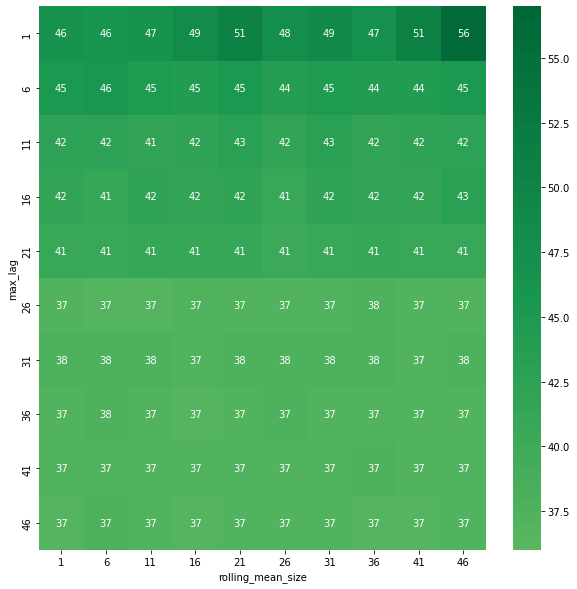

In [30]:
plt.figure(figsize = (10, 10))
pivot = result2.pivot_table(index = 'max_lag', columns = 'rolling_mean_size', values = 'score', aggfunc = 'mean')
sns.heatmap(pivot, xticklabels=pivot.index, yticklabels=pivot.columns, cmap='RdYlGn', center=0, annot=True, vmin=36, vmax=57)

Вот и заметна тенденция, отставание сильно влияет, а скользящая в некоторых случаях( при малых значениях отставания) 

Так то очевидно, чем больше окно мы создаем, тем модель лучше понимает данные и скорей всего сглаживающая скользящая добавляет ошибку, тем самым она минимальна. 

Проведем контрольную на CatBoostRegressor c max_lag = 36 и rolling_mean_size = 1: 

In [25]:
data_t = make_features(data, 'num_orders', 36, 1)
data_t = data_t.dropna()
train, test = train_test_split(data_t, shuffle = False, test_size = 0.1)
model = CatBoostRegressor(loss_function='RMSE', 
                          iterations=500, 
                          learning_rate=0.1, 
                          thread_count=-1, 
                          random_state=12345,
                          l2_leaf_reg=3)
model.fit(train.drop(columns = ['num_orders']), train['num_orders'])
score = mean_squared_error(model.predict(test.drop(columns = ['num_orders'])), test['num_orders'], squared = False)
print(f'rmse = {score}')

0:	learn: 37.0350053	total: 26.1ms	remaining: 13s
1:	learn: 35.5661257	total: 49.3ms	remaining: 12.3s
2:	learn: 34.1974134	total: 72.6ms	remaining: 12s
3:	learn: 32.9973423	total: 95.7ms	remaining: 11.9s
4:	learn: 32.0173337	total: 125ms	remaining: 12.4s
5:	learn: 31.1668349	total: 154ms	remaining: 12.7s
6:	learn: 30.3739661	total: 181ms	remaining: 12.8s
7:	learn: 29.7113944	total: 210ms	remaining: 12.9s
8:	learn: 29.0435614	total: 276ms	remaining: 15.1s
9:	learn: 28.4922228	total: 302ms	remaining: 14.8s
10:	learn: 28.1097693	total: 326ms	remaining: 14.5s
11:	learn: 27.6671791	total: 350ms	remaining: 14.2s
12:	learn: 27.2494950	total: 373ms	remaining: 14s
13:	learn: 26.8702237	total: 396ms	remaining: 13.8s
14:	learn: 26.5347059	total: 420ms	remaining: 13.6s
15:	learn: 26.2459717	total: 443ms	remaining: 13.4s
16:	learn: 25.9679227	total: 473ms	remaining: 13.4s
17:	learn: 25.7408311	total: 532ms	remaining: 14.2s
18:	learn: 25.4886146	total: 558ms	remaining: 14.1s
19:	learn: 25.2430869	to

161:	learn: 17.6659676	total: 6.08s	remaining: 12.7s
162:	learn: 17.6297079	total: 6.16s	remaining: 12.7s
163:	learn: 17.6271157	total: 6.21s	remaining: 12.7s
164:	learn: 17.5894485	total: 6.23s	remaining: 12.7s
165:	learn: 17.5537125	total: 6.26s	remaining: 12.6s
166:	learn: 17.5228387	total: 6.32s	remaining: 12.6s
167:	learn: 17.4909948	total: 6.34s	remaining: 12.5s
168:	learn: 17.4721553	total: 6.37s	remaining: 12.5s
169:	learn: 17.4455548	total: 6.41s	remaining: 12.4s
170:	learn: 17.3982364	total: 6.44s	remaining: 12.4s
171:	learn: 17.3640805	total: 6.47s	remaining: 12.3s
172:	learn: 17.3176796	total: 6.5s	remaining: 12.3s
173:	learn: 17.2825447	total: 6.55s	remaining: 12.3s
174:	learn: 17.2518786	total: 6.58s	remaining: 12.2s
175:	learn: 17.2173529	total: 6.61s	remaining: 12.2s
176:	learn: 17.1767042	total: 6.63s	remaining: 12.1s
177:	learn: 17.1739924	total: 6.66s	remaining: 12.1s
178:	learn: 17.1521913	total: 6.7s	remaining: 12s
179:	learn: 17.1140223	total: 6.73s	remaining: 12s

317:	learn: 13.6544549	total: 11.2s	remaining: 6.41s
318:	learn: 13.6362244	total: 11.2s	remaining: 6.38s
319:	learn: 13.6151248	total: 11.3s	remaining: 6.34s
320:	learn: 13.6036263	total: 11.3s	remaining: 6.29s
321:	learn: 13.5749407	total: 11.3s	remaining: 6.25s
322:	learn: 13.5738119	total: 11.3s	remaining: 6.21s
323:	learn: 13.5534314	total: 11.4s	remaining: 6.17s
324:	learn: 13.5377239	total: 11.4s	remaining: 6.13s
325:	learn: 13.5363609	total: 11.4s	remaining: 6.1s
326:	learn: 13.5179228	total: 11.5s	remaining: 6.06s
327:	learn: 13.5006632	total: 11.5s	remaining: 6.02s
328:	learn: 13.4699666	total: 11.5s	remaining: 5.98s
329:	learn: 13.4590622	total: 11.5s	remaining: 5.94s
330:	learn: 13.4431907	total: 11.6s	remaining: 5.9s
331:	learn: 13.4369982	total: 11.6s	remaining: 5.86s
332:	learn: 13.4168230	total: 11.6s	remaining: 5.84s
333:	learn: 13.3989238	total: 11.7s	remaining: 5.8s
334:	learn: 13.3822809	total: 11.7s	remaining: 5.76s
335:	learn: 13.3717972	total: 11.7s	remaining: 5.

478:	learn: 10.9399315	total: 16.6s	remaining: 730ms
479:	learn: 10.9385936	total: 16.7s	remaining: 695ms
480:	learn: 10.9120421	total: 16.7s	remaining: 660ms
481:	learn: 10.8981812	total: 16.7s	remaining: 625ms
482:	learn: 10.8971555	total: 16.8s	remaining: 590ms
483:	learn: 10.8797957	total: 16.8s	remaining: 555ms
484:	learn: 10.8629986	total: 16.8s	remaining: 520ms
485:	learn: 10.8480641	total: 16.8s	remaining: 485ms
486:	learn: 10.8267865	total: 16.9s	remaining: 451ms
487:	learn: 10.8176037	total: 16.9s	remaining: 416ms
488:	learn: 10.8010948	total: 16.9s	remaining: 381ms
489:	learn: 10.8004457	total: 17s	remaining: 346ms
490:	learn: 10.7836352	total: 17s	remaining: 312ms
491:	learn: 10.7704213	total: 17s	remaining: 277ms
492:	learn: 10.7554327	total: 17.1s	remaining: 242ms
493:	learn: 10.7341903	total: 17.1s	remaining: 207ms
494:	learn: 10.7120574	total: 17.1s	remaining: 173ms
495:	learn: 10.6961734	total: 17.2s	remaining: 138ms
496:	learn: 10.6798580	total: 17.2s	remaining: 104ms

Контрольная проверка на CatBoost показала RMSE = 40.8, границу в 48 преодолели. 

## Вывод:


Провели анализ временных данных. 

Обучили разные модели с разными скользящими, отставанием.
    
Замечено, что чем шире окно с отставанием, тем точнее модель предсказывает значение. 

Рекомендуемая модель -  CatBoost показала  при скользящей - 1 и отставанием - 46,с такими параметрами модель показала на тестовой выборке RMSE = 40.8.